In [42]:
import os, pickle, sys
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import glob
from prettytable import PrettyTable
from tqdm import tqdm
from torch.utils.data import Dataset

import torch
from torch import nn
from torch.nn import Linear,Sequential
from torch.utils.data import DataLoader
import torch.nn.functional as func
import time
from math import isnan,isinf,log,exp
import random

In [2]:
fname=r'../myp/tensors.p'
rname='CIFAR10'

In [3]:
runs_cifar10=[]
f = open(fname,'rb')
while(1):
    try:
        runs_cifar10.append(pickle.load(f))
    except EOFError:
        break
f.close()
print(fname, len(runs_cifar10))

../myp/tensors.p 15625


In [4]:
# len(runs)
# len(runs[0]['logmeasures']['synflow'])
# runs[0]['logmeasures']['synflow']

In [5]:
x_data_cifar10=[]
y_data_cifar10=[]
for idx in range(len(runs_cifar10)):
    temp=runs_cifar10[idx]['logmeasures']['synflow']
    for i in range(len(temp)):
        temp[i]=temp[i].item()
    temp=torch.tensor(temp,dtype=torch.float64)
    x_data_cifar10.append(temp)
    y_data_cifar10.append(runs_cifar10[idx]['testacc'])

In [6]:
x_data_cifar10=torch.tensor([item.cpu().detach().numpy() for item in x_data_cifar10],dtype=torch.float64).cuda()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_42724\230462777.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  x_data_cifar10=torch.tensor([item.cpu().detach().numpy() for item in x_data_cifar10],dtype=torch.float64).cuda()


In [7]:
y_data_cifar10=torch.tensor(y_data_cifar10,dtype=torch.float64)
y_data_cifar10=y_data_cifar10/100

In [8]:
trainx_cifar10=[]
trainy_cifar10=[]
for i in range (len(x_data_cifar10)):
    if isinf(torch.sum(x_data_cifar10[i]).item()):
        continue
    trainx_cifar10.append(x_data_cifar10[i])
    trainy_cifar10.append(y_data_cifar10[i])
trainx_cifar10=torch.tensor([item.cpu().detach().numpy() for item in trainx_cifar10],dtype=torch.float64)  
trainy_cifar10=torch.tensor(trainy_cifar10,dtype=torch.float64)
trainy_cifar10=torch.reshape(trainy_cifar10,(len(trainy_cifar10),1))
print(len(trainx_cifar10),len(trainy_cifar10))

15625 15625


In [9]:
split_rate=0.2

In [10]:
temp=int(len(trainx_cifar10)*(1-split_rate))
testx_cifar10=trainx_cifar10[temp:]
trainx_cifar10=trainx_cifar10[:temp]
testy_cifar10=trainy_cifar10[temp:]
trainy_cifar10=trainy_cifar10[:temp]

In [11]:
print(len(trainx_cifar10),len(testx_cifar10))

12500 3125


In [12]:
trainx_cifar10=trainx_cifar10.cuda()
trainy_cifar10=trainy_cifar10.cuda()
testx_cifar10=testx_cifar10.cuda()
testy_cifar10=testy_cifar10.cuda()

In [13]:
#这句话很关键，nn默认类型为float32
torch.set_default_dtype(torch.float64)

In [14]:
#损失函数
class SpearmanLossFunc(nn.Module):
    def __init__(self):
        super(SpearmanLossFunc,self).__init__()

    def forward(self, t1,t2):
        t1=t1.cpu().detach().numpy()
        t2=t2.cpu().detach().numpy()
        loss = -abs(stats.spearmanr(t1,t2,nan_policy='omit').correlation)
        loss=torch.tensor(loss,requires_grad=True)
        return loss
    
class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss,self).__init__()

    def forward(self, t1,t2):
        t1=t1.cpu().detach().numpy()
        t2=t2.cpu().detach().numpy()
        loss=0
        sample_size=500
        sample=random.sample(range(len(trainx)),sample_size)
        t1=t1.reshape(-1,)
        for i in range(sample_size):
            for j in range(sample_size):
                if i==j:
                    continue
                loss+=log(1+exp(-np.sign((t1[sample[i]]-t1[sample[j]])*(t2[sample[i]]-t2[sample[j]]))))
        #loss=loss/(sample_size*(sample_size-1))
        loss=torch.tensor(loss,requires_grad=True)
        return loss

In [15]:
class zyt(nn.Module):
    def __init__(self):
        super(zyt,self).__init__()
        self.model1=Sequential(
            nn.LayerNorm(188),
            Linear(188,128),
#             nn.BatchNorm1d(128),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            Linear(128,64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
            Linear(64,10),
#             nn.BatchNorm1d(10),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            Linear(10,1),             
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x=self.model1(x)
        return x
zyt1=zyt()
zyt1=zyt1.cuda()

In [16]:
# loss_fn=torch.nn.MSELoss()#SpearmanLossFunc()
loss_fn=torch.nn.MSELoss()
loss_fn=loss_fn.cuda()
#优化器
learning_rate=0.001
optimizer=torch.optim.Adam(zyt1.parameters(),lr=learning_rate)
#训练的轮数
epoch=5000

In [17]:
maxspear=0
for i in range(epoch):
    zyt1.train()
    print("------第{}轮训练开始-------".format(i+1))
#     start_time=time.time()
    output=zyt1(trainx_cifar10)
    print(output)
    curspear=abs(stats.spearmanr(output.cpu().detach().numpy(),trainy_cifar10.cpu().detach().numpy(),nan_policy='omit').correlation)
    print(curspear)
    if (curspear>maxspear):
        maxspear=curspear
        maxepoch=i
    loss=loss_fn(output,trainy_cifar10)
    #优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()                
    print("train_loss:{}".format(loss.item()))
#     end_time=time.time()
#     print("time_cost:{}".format(end_time-start_time))
    #测试步骤开始
#     zyt1.eval() #让网络进入测试状态
#     #no_grad()保证不影响梯度，不会进行调优
#     with torch.no_grad():
#         test_output=zyt1(testx_cifar10)
#         test_loss=loss_fn(test_output,testy_cifar10)
#         print("test_loss:{}".format(test_loss.item()))

------第1轮训练开始-------
tensor([[0.5561],
        [0.5580],
        [0.5526],
        ...,
        [0.5535],
        [0.5564],
        [0.5597]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.13347839940428388
train_loss:0.09299858241921172
------第2轮训练开始-------
tensor([[0.5641],
        [0.5723],
        [0.5629],
        ...,
        [0.5622],
        [0.5644],
        [0.5685]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.2692730049987984
train_loss:0.08693748388821675
------第3轮训练开始-------
tensor([[0.5712],
        [0.5884],
        [0.5749],
        ...,
        [0.5706],
        [0.5730],
        [0.5782]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.3645379329055402
train_loss:0.0806910885542253
------第4轮训练开始-------
tensor([[0.5790],
        [0.6047],
        [0.5881],
        ...,
        [0.5810],
        [0.5819],
        [0.5882]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.40599085914331406
train_loss:0.07427452889501651
------第5轮训练开始-------
tensor([[0.5882],
        

0.6024330208292242
train_loss:0.008855679812450593
------第43轮训练开始-------
tensor([[0.7909],
        [0.8650],
        [0.8375],
        ...,
        [0.8280],
        [0.8051],
        [0.7857]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6039828447239454
train_loss:0.008756081933205385
------第44轮训练开始-------
tensor([[0.7928],
        [0.8663],
        [0.8391],
        ...,
        [0.8300],
        [0.8083],
        [0.7897]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6054509211208305
train_loss:0.008606500609972183
------第45轮训练开始-------
tensor([[0.7955],
        [0.8686],
        [0.8415],
        ...,
        [0.8327],
        [0.8125],
        [0.7947]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6071348702606056
train_loss:0.00842311551610847
------第46轮训练开始-------
tensor([[0.7990],
        [0.8712],
        [0.8444],
        ...,
        [0.8360],
        [0.8172],
        [0.8001]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6087336247465803
train_loss:0.008226596

tensor([[0.8246],
        [0.8872],
        [0.8663],
        ...,
        [0.8585],
        [0.8403],
        [0.8200]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6778481695544345
train_loss:0.006522808174759776
------第79轮训练开始-------
tensor([[0.8262],
        [0.8881],
        [0.8666],
        ...,
        [0.8596],
        [0.8411],
        [0.8207]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6789476445033067
train_loss:0.006483793669290328
------第80轮训练开始-------
tensor([[0.8277],
        [0.8889],
        [0.8668],
        ...,
        [0.8607],
        [0.8419],
        [0.8213]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6803079369766374
train_loss:0.006446804319844626
------第81轮训练开始-------
tensor([[0.8291],
        [0.8897],
        [0.8671],
        ...,
        [0.8615],
        [0.8427],
        [0.8220]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6817801532969451
train_loss:0.006411955208477967
------第82轮训练开始-------
tensor([[0.8302],
        [0.8902],
    

train_loss:0.005546738484280141
------第115轮训练开始-------
tensor([[0.8340],
        [0.8882],
        [0.8716],
        ...,
        [0.8521],
        [0.8397],
        [0.8147]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7415737466840813
train_loss:0.005508733840269006
------第116轮训练开始-------
tensor([[0.8342],
        [0.8883],
        [0.8717],
        ...,
        [0.8520],
        [0.8400],
        [0.8147]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7428315527929543
train_loss:0.005469184965818238
------第117轮训练开始-------
tensor([[0.8346],
        [0.8884],
        [0.8717],
        ...,
        [0.8521],
        [0.8403],
        [0.8148]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.744544655380345
train_loss:0.005428070180219386
------第118轮训练开始-------
tensor([[0.8351],
        [0.8887],
        [0.8718],
        ...,
        [0.8524],
        [0.8407],
        [0.8148]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7460376535032727
train_loss:0.005385528164633834
-----

tensor([[0.8390],
        [0.8907],
        [0.8638],
        ...,
        [0.8492],
        [0.8388],
        [0.8123]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7889672822040128
train_loss:0.0032708557938657223
------第152轮训练开始-------
tensor([[0.8392],
        [0.8906],
        [0.8638],
        ...,
        [0.8491],
        [0.8390],
        [0.8127]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7895650929348429
train_loss:0.003203202746382708
------第153轮训练开始-------
tensor([[0.8393],
        [0.8904],
        [0.8638],
        ...,
        [0.8489],
        [0.8389],
        [0.8128]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7900924241311149
train_loss:0.0031361403280145512
------第154轮训练开始-------
tensor([[0.8392],
        [0.8901],
        [0.8637],
        ...,
        [0.8487],
        [0.8387],
        [0.8128]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7908665354350244
train_loss:0.0030697582347666585
------第155轮训练开始-------
tensor([[0.8391],
        [0.8904

tensor([[0.8333],
        [0.8914],
        [0.8647],
        ...,
        [0.8533],
        [0.8353],
        [0.8174]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8104659514218052
train_loss:0.0018653204995870943
------第188轮训练开始-------
tensor([[0.8332],
        [0.8915],
        [0.8647],
        ...,
        [0.8535],
        [0.8353],
        [0.8170]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8111309262053061
train_loss:0.0018602126227275607
------第189轮训练开始-------
tensor([[0.8333],
        [0.8914],
        [0.8648],
        ...,
        [0.8535],
        [0.8355],
        [0.8168]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8117242487351064
train_loss:0.0018553670513413397
------第190轮训练开始-------
tensor([[0.8334],
        [0.8908],
        [0.8647],
        ...,
        [0.8533],
        [0.8358],
        [0.8170]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8121571911850836
train_loss:0.0018515576856100524
------第191轮训练开始-------
tensor([[0.8335],
        [0.890

tensor([[0.8283],
        [0.8877],
        [0.8606],
        ...,
        [0.8528],
        [0.8368],
        [0.8200]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8245685533202154
train_loss:0.0017788867636554708
------第224轮训练开始-------
tensor([[0.8283],
        [0.8876],
        [0.8605],
        ...,
        [0.8528],
        [0.8370],
        [0.8200]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8247933288028215
train_loss:0.0017771678222399557
------第225轮训练开始-------
tensor([[0.8284],
        [0.8874],
        [0.8605],
        ...,
        [0.8528],
        [0.8371],
        [0.8201]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8250934619392559
train_loss:0.0017754621509008894
------第226轮训练开始-------
tensor([[0.8283],
        [0.8870],
        [0.8604],
        ...,
        [0.8527],
        [0.8371],
        [0.8203]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8253826855038388
train_loss:0.0017736916364257287
------第227轮训练开始-------
tensor([[0.8281],
        [0.886

tensor([[0.8247],
        [0.8838],
        [0.8590],
        ...,
        [0.8530],
        [0.8397],
        [0.8238]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8314941823255965
train_loss:0.0017232237099619797
------第260轮训练开始-------
tensor([[0.8244],
        [0.8842],
        [0.8589],
        ...,
        [0.8528],
        [0.8398],
        [0.8236]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8315921462732553
train_loss:0.0017218893098486752
------第261轮训练开始-------
tensor([[0.8242],
        [0.8842],
        [0.8588],
        ...,
        [0.8532],
        [0.8399],
        [0.8237]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8317435536802993
train_loss:0.0017206730418165442
------第262轮训练开始-------
tensor([[0.8241],
        [0.8840],
        [0.8588],
        ...,
        [0.8537],
        [0.8400],
        [0.8239]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8318454598022907
train_loss:0.0017194916881650613
------第263轮训练开始-------
tensor([[0.8238],
        [0.884

0.8352912903691341
train_loss:0.001689455653541796
------第296轮训练开始-------
tensor([[0.8248],
        [0.8815],
        [0.8581],
        ...,
        [0.8533],
        [0.8425],
        [0.8281]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8354087316536517
train_loss:0.001688760648504923
------第297轮训练开始-------
tensor([[0.8248],
        [0.8812],
        [0.8580],
        ...,
        [0.8532],
        [0.8425],
        [0.8280]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8355368977664134
train_loss:0.0016880463577829026
------第298轮训练开始-------
tensor([[0.8249],
        [0.8808],
        [0.8579],
        ...,
        [0.8535],
        [0.8426],
        [0.8280]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8356716801610892
train_loss:0.001687442734971387
------第299轮训练开始-------
tensor([[0.8251],
        [0.8812],
        [0.8577],
        ...,
        [0.8536],
        [0.8428],
        [0.8281]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.835755859296539
train_loss:0.0016

0.8391748385792379
train_loss:0.0016693167923920453
------第333轮训练开始-------
tensor([[0.8255],
        [0.8824],
        [0.8571],
        ...,
        [0.8542],
        [0.8438],
        [0.8317]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8391491933835343
train_loss:0.0016688778233633907
------第334轮训练开始-------
tensor([[0.8257],
        [0.8824],
        [0.8571],
        ...,
        [0.8547],
        [0.8440],
        [0.8317]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8392272844361247
train_loss:0.0016684700326656703
------第335轮训练开始-------
tensor([[0.8256],
        [0.8825],
        [0.8570],
        ...,
        [0.8545],
        [0.8440],
        [0.8311]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.83953528132241
train_loss:0.0016680413160655412
------第336轮训练开始-------
tensor([[0.8253],
        [0.8825],
        [0.8570],
        ...,
        [0.8542],
        [0.8438],
        [0.8316]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.83962258374746
train_loss:0.0016

0.8423474333207749
train_loss:0.0016568161088292659
------第369轮训练开始-------
tensor([[0.8256],
        [0.8821],
        [0.8555],
        ...,
        [0.8548],
        [0.8443],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8424188153400959
train_loss:0.0016565143257815259
------第370轮训练开始-------
tensor([[0.8257],
        [0.8817],
        [0.8555],
        ...,
        [0.8547],
        [0.8444],
        [0.8322]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8425101188231053
train_loss:0.0016562396390303706
------第371轮训练开始-------
tensor([[0.8258],
        [0.8821],
        [0.8555],
        ...,
        [0.8552],
        [0.8445],
        [0.8325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8424321240077418
train_loss:0.0016559655890123512
------第372轮训练开始-------
tensor([[0.8257],
        [0.8819],
        [0.8554],
        ...,
        [0.8547],
        [0.8443],
        [0.8319]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8426402625450872
train_loss:0.

train_loss:0.0016470423137169427
------第406轮训练开始-------
tensor([[0.8260],
        [0.8816],
        [0.8540],
        ...,
        [0.8556],
        [0.8449],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8442397120857354
train_loss:0.0016467838002793493
------第407轮训练开始-------
tensor([[0.8259],
        [0.8818],
        [0.8541],
        ...,
        [0.8551],
        [0.8449],
        [0.8320]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8446011805890521
train_loss:0.0016465792842942583
------第408轮训练开始-------
tensor([[0.8258],
        [0.8820],
        [0.8540],
        ...,
        [0.8549],
        [0.8450],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8444424567621427
train_loss:0.0016463227979809693
------第409轮训练开始-------
tensor([[0.8261],
        [0.8820],
        [0.8540],
        ...,
        [0.8556],
        [0.8453],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8443084793901923
train_loss:0.0016460478129695748

train_loss:0.001637681304751035
------第443轮训练开始-------
tensor([[0.8268],
        [0.8826],
        [0.8539],
        ...,
        [0.8565],
        [0.8462],
        [0.8332]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8461565358652859
train_loss:0.0016373968608184488
------第444轮训练开始-------
tensor([[0.8260],
        [0.8823],
        [0.8537],
        ...,
        [0.8545],
        [0.8455],
        [0.8339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.84651538629239
train_loss:0.001637184934294693
------第445轮训练开始-------
tensor([[0.8261],
        [0.8827],
        [0.8537],
        ...,
        [0.8554],
        [0.8453],
        [0.8331]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8463831507776411
train_loss:0.0016370603589670545
------第446轮训练开始-------
tensor([[0.8265],
        [0.8823],
        [0.8537],
        ...,
        [0.8561],
        [0.8458],
        [0.8330]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8463822567992122
train_loss:0.001636842884607399
----

train_loss:0.001629612157771668
------第480轮训练开始-------
tensor([[0.8252],
        [0.8829],
        [0.8539],
        ...,
        [0.8534],
        [0.8441],
        [0.8312]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8491829695331499
train_loss:0.0016284549637454755
------第481轮训练开始-------
tensor([[0.8268],
        [0.8830],
        [0.8541],
        ...,
        [0.8566],
        [0.8460],
        [0.8319]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8478748623917808
train_loss:0.001627783761362833
------第482轮训练开始-------
tensor([[0.8271],
        [0.8829],
        [0.8535],
        ...,
        [0.8575],
        [0.8463],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.846932781192255
train_loss:0.0016277699928783106
------第483轮训练开始-------
tensor([[0.8256],
        [0.8832],
        [0.8536],
        ...,
        [0.8542],
        [0.8445],
        [0.8321]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8483025544160189
train_loss:0.0016277334619605917
--

0.8503790193864174
train_loss:0.0016187387741117853
------第517轮训练开始-------
tensor([[0.8274],
        [0.8850],
        [0.8529],
        ...,
        [0.8573],
        [0.8469],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8488578117315961
train_loss:0.001618401680946521
------第518轮训练开始-------
tensor([[0.8266],
        [0.8839],
        [0.8529],
        ...,
        [0.8557],
        [0.8454],
        [0.8342]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8495709521693908
train_loss:0.0016181663713972444
------第519轮训练开始-------
tensor([[0.8264],
        [0.8843],
        [0.8536],
        ...,
        [0.8563],
        [0.8441],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8504005167284434
train_loss:0.001617723348058009
------第520轮训练开始-------
tensor([[0.8271],
        [0.8844],
        [0.8538],
        ...,
        [0.8572],
        [0.8454],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.850198836412975
train_loss:0.001

train_loss:0.0016111769471739443
------第552轮训练开始-------
tensor([[0.8278],
        [0.8862],
        [0.8517],
        ...,
        [0.8579],
        [0.8468],
        [0.8339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8506046542610264
train_loss:0.001610807448797524
------第553轮训练开始-------
tensor([[0.8258],
        [0.8839],
        [0.8513],
        ...,
        [0.8541],
        [0.8449],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8516879796264655
train_loss:0.00161015734717993
------第554轮训练开始-------
tensor([[0.8270],
        [0.8842],
        [0.8518],
        ...,
        [0.8580],
        [0.8454],
        [0.8347]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8509541896444632
train_loss:0.0016096686632611397
------第555轮训练开始-------
tensor([[0.8266],
        [0.8849],
        [0.8513],
        ...,
        [0.8567],
        [0.8455],
        [0.8317]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8511567926131521
train_loss:0.0016094623851524894
--

tensor([[0.8261],
        [0.8837],
        [0.8511],
        ...,
        [0.8548],
        [0.8460],
        [0.8341]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8529419670922195
train_loss:0.0016037617610379943
------第590轮训练开始-------
tensor([[0.8268],
        [0.8858],
        [0.8504],
        ...,
        [0.8564],
        [0.8463],
        [0.8335]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8517794293767686
train_loss:0.0016035975896209259
------第591轮训练开始-------
tensor([[0.8268],
        [0.8865],
        [0.8511],
        ...,
        [0.8581],
        [0.8455],
        [0.8343]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8519168735562
train_loss:0.00160270881962236
------第592轮训练开始-------
tensor([[0.8253],
        [0.8841],
        [0.8511],
        ...,
        [0.8547],
        [0.8447],
        [0.8331]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8530032393524188
train_loss:0.0016033077477143737
------第593轮训练开始-------
tensor([[0.8282],
        [0.8872],
 

train_loss:0.0015891526091068088
------第626轮训练开始-------
tensor([[0.8276],
        [0.8857],
        [0.8499],
        ...,
        [0.8571],
        [0.8469],
        [0.8334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8530336362796946
train_loss:0.0015888938491054154
------第627轮训练开始-------
tensor([[0.8262],
        [0.8853],
        [0.8501],
        ...,
        [0.8553],
        [0.8456],
        [0.8341]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8540792695992684
train_loss:0.0015888951470988083
------第628轮训练开始-------
tensor([[0.8268],
        [0.8854],
        [0.8500],
        ...,
        [0.8570],
        [0.8461],
        [0.8343]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8537028215641856
train_loss:0.0015884306991883483
------第629轮训练开始-------
tensor([[0.8268],
        [0.8845],
        [0.8498],
        ...,
        [0.8567],
        [0.8466],
        [0.8325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8537709018850661
train_loss:0.0015883402904602567

0.85529382642168
train_loss:0.0015837113020912303
------第663轮训练开始-------
tensor([[0.8265],
        [0.8857],
        [0.8482],
        ...,
        [0.8569],
        [0.8457],
        [0.8342]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8548538841689631
train_loss:0.0015835188360647828
------第664轮训练开始-------
tensor([[0.8271],
        [0.8855],
        [0.8476],
        ...,
        [0.8564],
        [0.8473],
        [0.8329]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8549092242184663
train_loss:0.0015831145988062733
------第665轮训练开始-------
tensor([[0.8268],
        [0.8856],
        [0.8470],
        ...,
        [0.8558],
        [0.8472],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8545637790426583
train_loss:0.0015833744770978484
------第666轮训练开始-------
tensor([[0.8271],
        [0.8864],
        [0.8484],
        ...,
        [0.8579],
        [0.8465],
        [0.8354]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8543955574857659
train_loss:0.00

tensor([[0.8266],
        [0.8845],
        [0.8462],
        ...,
        [0.8559],
        [0.8448],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8556644230869169
train_loss:0.00157852202938538
------第700轮训练开始-------
tensor([[0.8278],
        [0.8856],
        [0.8464],
        ...,
        [0.8569],
        [0.8470],
        [0.8347]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8551564311037432
train_loss:0.001578469295141095
------第701轮训练开始-------
tensor([[0.8277],
        [0.8849],
        [0.8461],
        ...,
        [0.8554],
        [0.8481],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8555502731662213
train_loss:0.0015783528000363981
------第702轮训练开始-------
tensor([[0.8278],
        [0.8856],
        [0.8462],
        ...,
        [0.8570],
        [0.8472],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8553860906902507
train_loss:0.0015782835266395627
------第703轮训练开始-------
tensor([[0.8261],
        [0.8841],

train_loss:0.0015751640870767028
------第736轮训练开始-------
tensor([[0.8261],
        [0.8845],
        [0.8454],
        ...,
        [0.8550],
        [0.8461],
        [0.8351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8565627925385348
train_loss:0.001574947535063054
------第737轮训练开始-------
tensor([[0.8271],
        [0.8861],
        [0.8451],
        ...,
        [0.8565],
        [0.8470],
        [0.8348]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8558279888678499
train_loss:0.0015746516095197748
------第738轮训练开始-------
tensor([[0.8272],
        [0.8854],
        [0.8448],
        ...,
        [0.8558],
        [0.8472],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8561947669496828
train_loss:0.0015744846917177234
------第739轮训练开始-------
tensor([[0.8270],
        [0.8848],
        [0.8451],
        ...,
        [0.8562],
        [0.8466],
        [0.8362]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8564190007853516
train_loss:0.0015744202750658878


0.8551452895723977
train_loss:0.0015753840489110937
------第773轮训练开始-------
tensor([[0.8240],
        [0.8837],
        [0.8435],
        ...,
        [0.8518],
        [0.8444],
        [0.8323]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8567114545717065
train_loss:0.00157461012385581
------第774轮训练开始-------
tensor([[0.8287],
        [0.8868],
        [0.8446],
        ...,
        [0.8597],
        [0.8488],
        [0.8371]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8556317974517376
train_loss:0.0015739791939151477
------第775轮训练开始-------
tensor([[0.8251],
        [0.8849],
        [0.8439],
        ...,
        [0.8529],
        [0.8471],
        [0.8311]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8572553552014909
train_loss:0.0015725783435690892
------第776轮训练开始-------
tensor([[0.8270],
        [0.8861],
        [0.8446],
        ...,
        [0.8579],
        [0.8474],
        [0.8364]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.856047914644031
train_loss:0.001

tensor([[0.8249],
        [0.8849],
        [0.8439],
        ...,
        [0.8540],
        [0.8472],
        [0.8317]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8576192680743545
train_loss:0.0015680986787665724
------第810轮训练开始-------
tensor([[0.8273],
        [0.8871],
        [0.8446],
        ...,
        [0.8584],
        [0.8487],
        [0.8379]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8567649856325147
train_loss:0.0015696353224025693
------第811轮训练开始-------
tensor([[0.8242],
        [0.8844],
        [0.8436],
        ...,
        [0.8522],
        [0.8471],
        [0.8311]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.857881817973247
train_loss:0.0015704813529443236
------第812轮训练开始-------
tensor([[0.8279],
        [0.8872],
        [0.8447],
        ...,
        [0.8599],
        [0.8492],
        [0.8363]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8561278265169309
train_loss:0.0015704095743951845
------第813轮训练开始-------
tensor([[0.8243],
        [0.8846

tensor([[0.8232],
        [0.8850],
        [0.8442],
        ...,
        [0.8546],
        [0.8476],
        [0.8335]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8582099861769567
train_loss:0.0015643816101180796
------第846轮训练开始-------
tensor([[0.8237],
        [0.8866],
        [0.8443],
        ...,
        [0.8570],
        [0.8474],
        [0.8347]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.85787733092332
train_loss:0.0015643580504514354
------第847轮训练开始-------
tensor([[0.8224],
        [0.8855],
        [0.8440],
        ...,
        [0.8548],
        [0.8467],
        [0.8322]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8584621708035199
train_loss:0.0015645112162441985
------第848轮训练开始-------
tensor([[0.8239],
        [0.8864],
        [0.8445],
        ...,
        [0.8568],
        [0.8476],
        [0.8363]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8581548248959406
train_loss:0.0015650685362196698
------第849轮训练开始-------
tensor([[0.8218],
        [0.8837]

train_loss:0.0015609737336184783
------第882轮训练开始-------
tensor([[0.8219],
        [0.8859],
        [0.8437],
        ...,
        [0.8551],
        [0.8479],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8585646077071845
train_loss:0.0015608252039251442
------第883轮训练开始-------
tensor([[0.8208],
        [0.8851],
        [0.8435],
        ...,
        [0.8548],
        [0.8467],
        [0.8342]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8591986586000729
train_loss:0.0015610253819807601
------第884轮训练开始-------
tensor([[0.8227],
        [0.8855],
        [0.8440],
        ...,
        [0.8576],
        [0.8477],
        [0.8360]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8587731960009936
train_loss:0.0015611173101501038
------第885轮训练开始-------
tensor([[0.8205],
        [0.8849],
        [0.8433],
        ...,
        [0.8529],
        [0.8470],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8589933052697032
train_loss:0.0015614909724885014

0.8586496169560052
train_loss:0.0015697246275126846
------第919轮训练开始-------
tensor([[0.8270],
        [0.8871],
        [0.8456],
        ...,
        [0.8575],
        [0.8465],
        [0.8391]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8576120550372301
train_loss:0.0015713418521938563
------第920轮训练开始-------
tensor([[0.8245],
        [0.8841],
        [0.8448],
        ...,
        [0.8514],
        [0.8452],
        [0.8311]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8593237259768267
train_loss:0.001569584299235914
------第921轮训练开始-------
tensor([[0.8289],
        [0.8852],
        [0.8450],
        ...,
        [0.8581],
        [0.8477],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8577473066708479
train_loss:0.0015687692179055775
------第922轮训练开始-------
tensor([[0.8274],
        [0.8871],
        [0.8437],
        ...,
        [0.8547],
        [0.8467],
        [0.8356]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8592141658872657
train_loss:0.0

tensor([[0.8234],
        [0.8855],
        [0.8414],
        ...,
        [0.8552],
        [0.8473],
        [0.8334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8602609280536765
train_loss:0.001561903325050227
------第956轮训练开始-------
tensor([[0.8229],
        [0.8859],
        [0.8412],
        ...,
        [0.8558],
        [0.8464],
        [0.8320]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8604135237858938
train_loss:0.0015618760260509414
------第957轮训练开始-------
tensor([[0.8231],
        [0.8856],
        [0.8407],
        ...,
        [0.8555],
        [0.8470],
        [0.8352]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8603139576820802
train_loss:0.0015616342323842543
------第958轮训练开始-------
tensor([[0.8234],
        [0.8855],
        [0.8404],
        ...,
        [0.8547],
        [0.8479],
        [0.8329]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8603242301356248
train_loss:0.0015614586820967512
------第959轮训练开始-------
tensor([[0.8235],
        [0.8861

0.8591018901086155
train_loss:0.001564085378593996
------第992轮训练开始-------
tensor([[0.8187],
        [0.8821],
        [0.8390],
        ...,
        [0.8488],
        [0.8471],
        [0.8277]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8605504102869141
train_loss:0.0015671742602132834
------第993轮训练开始-------
tensor([[0.8258],
        [0.8885],
        [0.8430],
        ...,
        [0.8647],
        [0.8486],
        [0.8416]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.854423895433773
train_loss:0.001574680281180169
------第994轮训练开始-------
tensor([[0.8157],
        [0.8843],
        [0.8393],
        ...,
        [0.8464],
        [0.8453],
        [0.8254]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.861584115532962
train_loss:0.0015730997284828677
------第995轮训练开始-------
tensor([[0.8265],
        [0.8865],
        [0.8426],
        ...,
        [0.8650],
        [0.8502],
        [0.8421]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8552110053147078
train_loss:0.0015

0.8620113520983385
train_loss:0.001555684733011355
------第1029轮训练开始-------
tensor([[0.8217],
        [0.8874],
        [0.8415],
        ...,
        [0.8567],
        [0.8471],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8614878882290543
train_loss:0.0015554486572012906
------第1030轮训练开始-------
tensor([[0.8215],
        [0.8857],
        [0.8404],
        ...,
        [0.8546],
        [0.8476],
        [0.8314]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8608492119586949
train_loss:0.0015546993541171083
------第1031轮训练开始-------
tensor([[0.8220],
        [0.8869],
        [0.8403],
        ...,
        [0.8547],
        [0.8479],
        [0.8325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.861160438638777
train_loss:0.0015543991796610256
------第1032轮训练开始-------
tensor([[0.8223],
        [0.8872],
        [0.8415],
        ...,
        [0.8556],
        [0.8480],
        [0.8351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8614015193279583
train_loss:

0.8623251828092178
train_loss:0.0015494590196772164
------第1066轮训练开始-------
tensor([[0.8206],
        [0.8859],
        [0.8401],
        ...,
        [0.8533],
        [0.8480],
        [0.8311]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.862496753776977
train_loss:0.0015497601533156298
------第1067轮训练开始-------
tensor([[0.8223],
        [0.8879],
        [0.8413],
        ...,
        [0.8570],
        [0.8483],
        [0.8356]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8621499795762124
train_loss:0.0015505537961666672
------第1068轮训练开始-------
tensor([[0.8192],
        [0.8844],
        [0.8398],
        ...,
        [0.8525],
        [0.8471],
        [0.8310]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8624098756427452
train_loss:0.0015510351400169647
------第1069轮训练开始-------
tensor([[0.8230],
        [0.8876],
        [0.8415],
        ...,
        [0.8589],
        [0.8487],
        [0.8370]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8614304577963662
train_loss

0.8629320942864068
train_loss:0.0015462235784195117
------第1103轮训练开始-------
tensor([[0.8206],
        [0.8874],
        [0.8405],
        ...,
        [0.8558],
        [0.8482],
        [0.8327]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8630861031359922
train_loss:0.0015457980842696725
------第1104轮训练开始-------
tensor([[0.8202],
        [0.8876],
        [0.8394],
        ...,
        [0.8549],
        [0.8481],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8631830940632692
train_loss:0.0015455401109189888
------第1105轮训练开始-------
tensor([[0.8194],
        [0.8873],
        [0.8395],
        ...,
        [0.8538],
        [0.8477],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8633069965530223
train_loss:0.001545638635690709
------第1106轮训练开始-------
tensor([[0.8208],
        [0.8877],
        [0.8409],
        ...,
        [0.8565],
        [0.8480],
        [0.8345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8628481497502221
train_loss

0.8639732142836315
train_loss:0.0015448181844836383
------第1140轮训练开始-------
tensor([[0.8202],
        [0.8882],
        [0.8407],
        ...,
        [0.8586],
        [0.8488],
        [0.8356]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8626405872693526
train_loss:0.0015450316221826555
------第1141轮训练开始-------
tensor([[0.8160],
        [0.8866],
        [0.8382],
        ...,
        [0.8520],
        [0.8474],
        [0.8306]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8639254061004775
train_loss:0.0015443440662411066
------第1142轮训练开始-------
tensor([[0.8189],
        [0.8878],
        [0.8405],
        ...,
        [0.8569],
        [0.8485],
        [0.8358]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8637826844234204
train_loss:0.0015440745591654504
------第1143轮训练开始-------
tensor([[0.8157],
        [0.8842],
        [0.8386],
        ...,
        [0.8522],
        [0.8476],
        [0.8317]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8641025756670926
train_los

0.8535584083334299
train_loss:0.0015659285029128993
------第1176轮训练开始-------
tensor([[0.8165],
        [0.8809],
        [0.8385],
        ...,
        [0.8550],
        [0.8494],
        [0.8307]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8588817677304661
train_loss:0.0015493179250837827
------第1177轮训练开始-------
tensor([[0.8104],
        [0.8888],
        [0.8378],
        ...,
        [0.8460],
        [0.8455],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8627186517205176
train_loss:0.0015514884718117782
------第1178轮训练开始-------
tensor([[0.8211],
        [0.8899],
        [0.8391],
        ...,
        [0.8629],
        [0.8489],
        [0.8378]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8591200146177858
train_loss:0.001559311635398699
------第1179轮训练开始-------
tensor([[0.8160],
        [0.8816],
        [0.8354],
        ...,
        [0.8534],
        [0.8489],
        [0.8236]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8584203579821148
train_loss

0.8653096314404902
train_loss:0.001535561691789956
------第1212轮训练开始-------
tensor([[0.8110],
        [0.8881],
        [0.8391],
        ...,
        [0.8551],
        [0.8481],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8661853128194038
train_loss:0.0015353199866363799
------第1213轮训练开始-------
tensor([[0.8090],
        [0.8871],
        [0.8391],
        ...,
        [0.8522],
        [0.8482],
        [0.8331]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8666190927685546
train_loss:0.0015351638996987794
------第1214轮训练开始-------
tensor([[0.8119],
        [0.8866],
        [0.8387],
        ...,
        [0.8557],
        [0.8489],
        [0.8343]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.865614062988527
train_loss:0.0015348482658240619
------第1215轮训练开始-------
tensor([[0.8104],
        [0.8875],
        [0.8382],
        ...,
        [0.8553],
        [0.8481],
        [0.8318]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8661798802299819
train_loss:

train_loss:0.0015316141571918697
------第1248轮训练开始-------
tensor([[0.8087],
        [0.8862],
        [0.8373],
        ...,
        [0.8529],
        [0.8483],
        [0.8319]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.867089536603486
train_loss:0.0015317936759152286
------第1249轮训练开始-------
tensor([[0.8119],
        [0.8876],
        [0.8389],
        ...,
        [0.8564],
        [0.8490],
        [0.8348]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8668431574331292
train_loss:0.0015320017201224606
------第1250轮训练开始-------
tensor([[0.8084],
        [0.8856],
        [0.8374],
        ...,
        [0.8526],
        [0.8484],
        [0.8320]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.866820051989452
train_loss:0.0015322034351727969
------第1251轮训练开始-------
tensor([[0.8123],
        [0.8878],
        [0.8390],
        ...,
        [0.8562],
        [0.8494],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8672124809984505
train_loss:0.00153247156174225

tensor([[0.8065],
        [0.8854],
        [0.8360],
        ...,
        [0.8516],
        [0.8479],
        [0.8314]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8680581354598745
train_loss:0.001530704170085473
------第1285轮训练开始-------
tensor([[0.8117],
        [0.8875],
        [0.8381],
        ...,
        [0.8564],
        [0.8492],
        [0.8345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8679525511355579
train_loss:0.0015288405803795145
------第1286轮训练开始-------
tensor([[0.8094],
        [0.8868],
        [0.8371],
        ...,
        [0.8536],
        [0.8489],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8682209295194951
train_loss:0.001527692740764983
------第1287轮训练开始-------
tensor([[0.8098],
        [0.8866],
        [0.8371],
        ...,
        [0.8538],
        [0.8489],
        [0.8338]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8683594371675056
train_loss:0.0015275083631691951
------第1288轮训练开始-------
tensor([[0.8114],
        [0.8

train_loss:0.001531925076365848
------第1321轮训练开始-------
tensor([[0.8055],
        [0.8847],
        [0.8355],
        ...,
        [0.8503],
        [0.8476],
        [0.8304]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8674217841843105
train_loss:0.0015319176833089871
------第1322轮训练开始-------
tensor([[0.8151],
        [0.8890],
        [0.8397],
        ...,
        [0.8585],
        [0.8499],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8673991439487376
train_loss:0.0015332241893952086
------第1323轮训练开始-------
tensor([[0.8053],
        [0.8853],
        [0.8355],
        ...,
        [0.8496],
        [0.8482],
        [0.8300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8681065152645154
train_loss:0.0015315291330652474
------第1324轮训练开始-------
tensor([[0.8153],
        [0.8881],
        [0.8389],
        ...,
        [0.8592],
        [0.8499],
        [0.8359]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8678523576550791
train_loss:0.0015309188695509

train_loss:0.0015256666990967273
------第1357轮训练开始-------
tensor([[0.8157],
        [0.8888],
        [0.8394],
        ...,
        [0.8580],
        [0.8498],
        [0.8369]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8683914947406656
train_loss:0.0015269791349722102
------第1358轮训练开始-------
tensor([[0.8068],
        [0.8847],
        [0.8357],
        ...,
        [0.8507],
        [0.8477],
        [0.8306]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8683951138050654
train_loss:0.0015264228574615988
------第1359轮训练开始-------
tensor([[0.8156],
        [0.8884],
        [0.8390],
        ...,
        [0.8582],
        [0.8497],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8679606033204954
train_loss:0.00152598630231685
------第1360轮训练开始-------
tensor([[0.8078],
        [0.8851],
        [0.8350],
        ...,
        [0.8509],
        [0.8485],
        [0.8321]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.86863720995218
train_loss:0.001523547993083633


tensor([[0.8114],
        [0.8872],
        [0.8359],
        ...,
        [0.8542],
        [0.8494],
        [0.8338]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8697889260574662
train_loss:0.0015174565943660726
------第1394轮训练开始-------
tensor([[0.8132],
        [0.8876],
        [0.8374],
        ...,
        [0.8561],
        [0.8492],
        [0.8343]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8695617290134509
train_loss:0.0015185284534705483
------第1395轮训练开始-------
tensor([[0.8068],
        [0.8859],
        [0.8356],
        ...,
        [0.8510],
        [0.8477],
        [0.8315]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8692371205096954
train_loss:0.0015214453798727625
------第1396轮训练开始-------
tensor([[0.8163],
        [0.8889],
        [0.8384],
        ...,
        [0.8584],
        [0.8499],
        [0.8367]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.868609343740566
train_loss:0.0015252166653675328
------第1397轮训练开始-------
tensor([[0.8064],
        [0.

tensor([[0.8080],
        [0.8858],
        [0.8342],
        ...,
        [0.8516],
        [0.8487],
        [0.8315]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.869597695520512
train_loss:0.0015174052011365218
------第1431轮训练开始-------
tensor([[0.8141],
        [0.8888],
        [0.8387],
        ...,
        [0.8581],
        [0.8495],
        [0.8356]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8692660961204111
train_loss:0.0015203750543873714
------第1432轮训练开始-------
tensor([[0.8048],
        [0.8853],
        [0.8342],
        ...,
        [0.8499],
        [0.8480],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8696149615960003
train_loss:0.0015221452959986554
------第1433轮训练开始-------
tensor([[0.8167],
        [0.8891],
        [0.8387],
        ...,
        [0.8587],
        [0.8508],
        [0.8366]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8690634366068231
train_loss:0.0015247678457158452
------第1434轮训练开始-------
tensor([[0.8054],
        [0.

        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8705884492020639
train_loss:0.0015127637486267128
------第1467轮训练开始-------
tensor([[0.8110],
        [0.8875],
        [0.8365],
        ...,
        [0.8542],
        [0.8494],
        [0.8339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8705545080432364
train_loss:0.001512192061655325
------第1468轮训练开始-------
tensor([[0.8099],
        [0.8877],
        [0.8366],
        ...,
        [0.8542],
        [0.8489],
        [0.8334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8708650099883594
train_loss:0.0015119237131731732
------第1469轮训练开始-------
tensor([[0.8095],
        [0.8874],
        [0.8353],
        ...,
        [0.8541],
        [0.8488],
        [0.8330]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8705859710819007
train_loss:0.0015119545395636063
------第1470轮训练开始-------
tensor([[0.8110],
        [0.8878],
        [0.8359],
        ...,
        [0.8547],
        [0.8492],
        [0.8342]], device='cu

train_loss:0.001513810363096803
------第1502轮训练开始-------
tensor([[0.8062],
        [0.8860],
        [0.8325],
        ...,
        [0.8519],
        [0.8485],
        [0.8310]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.870409964367724
train_loss:0.0015144692291435655
------第1503轮训练开始-------
tensor([[0.8145],
        [0.8886],
        [0.8372],
        ...,
        [0.8573],
        [0.8501],
        [0.8373]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.87061874037737
train_loss:0.001516089306914959
------第1504轮训练开始-------
tensor([[0.8057],
        [0.8856],
        [0.8322],
        ...,
        [0.8501],
        [0.8482],
        [0.8306]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8703035527509083
train_loss:0.0015161240010736806
------第1505轮训练开始-------
tensor([[0.8151],
        [0.8892],
        [0.8387],
        ...,
        [0.8585],
        [0.8498],
        [0.8358]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.869718948032835
train_loss:0.0015172281340999536
-

tensor([[0.8166],
        [0.8900],
        [0.8393],
        ...,
        [0.8593],
        [0.8503],
        [0.8383]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8694039170614751
train_loss:0.0015233205353290486
------第1538轮训练开始-------
tensor([[0.8038],
        [0.8860],
        [0.8299],
        ...,
        [0.8490],
        [0.8479],
        [0.8300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8706687961977806
train_loss:0.0015198951274988234
------第1539轮训练开始-------
tensor([[0.8172],
        [0.8886],
        [0.8398],
        ...,
        [0.8599],
        [0.8505],
        [0.8353]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8702257222085424
train_loss:0.001518744492343639
------第1540轮训练开始-------
tensor([[0.8052],
        [0.8868],
        [0.8305],
        ...,
        [0.8505],
        [0.8480],
        [0.8318]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8713267010717011
train_loss:0.001513564453944714
------第1541轮训练开始-------
tensor([[0.8126],
        [0.8

tensor([[0.8065],
        [0.8855],
        [0.8311],
        ...,
        [0.8502],
        [0.8487],
        [0.8306]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8702909856068908
train_loss:0.001513459089867778
------第1574轮训练开始-------
tensor([[0.8174],
        [0.8899],
        [0.8382],
        ...,
        [0.8586],
        [0.8514],
        [0.8382]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8704875150090117
train_loss:0.0015181365013545232
------第1575轮训练开始-------
tensor([[0.8045],
        [0.8861],
        [0.8283],
        ...,
        [0.8492],
        [0.8484],
        [0.8300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8709709866573293
train_loss:0.001516935506064431
------第1576轮训练开始-------
tensor([[0.8160],
        [0.8893],
        [0.8395],
        ...,
        [0.8594],
        [0.8496],
        [0.8358]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8706505520375317
train_loss:0.0015162862965992046
------第1577轮训练开始-------
tensor([[0.8055],
        [0.8

0.8720412322587091
train_loss:0.00150368620567031
------第1608轮训练开始-------
tensor([[0.8111],
        [0.8880],
        [0.8333],
        ...,
        [0.8545],
        [0.8496],
        [0.8341]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8720506350515465
train_loss:0.0015032247176660304
------第1609轮训练开始-------
tensor([[0.8109],
        [0.8881],
        [0.8341],
        ...,
        [0.8546],
        [0.8495],
        [0.8339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8722191976847566
train_loss:0.0015031722417940866
------第1610轮训练开始-------
tensor([[0.8083],
        [0.8878],
        [0.8320],
        ...,
        [0.8530],
        [0.8487],
        [0.8325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8722657496083841
train_loss:0.001503543443876451
------第1611轮训练开始-------
tensor([[0.8120],
        [0.8885],
        [0.8346],
        ...,
        [0.8558],
        [0.8493],
        [0.8343]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8722729304137081
train_loss:0

tensor([[0.8156],
        [0.8892],
        [0.8376],
        ...,
        [0.8585],
        [0.8499],
        [0.8362]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8714845336837211
train_loss:0.0015115058546376356
------第1644轮训练开始-------
tensor([[0.8062],
        [0.8863],
        [0.8312],
        ...,
        [0.8505],
        [0.8483],
        [0.8304]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8715194719249584
train_loss:0.0015082361711366533
------第1645轮训练开始-------
tensor([[0.8152],
        [0.8891],
        [0.8352],
        ...,
        [0.8570],
        [0.8503],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8720863277217527
train_loss:0.0015064900804516977
------第1646轮训练开始-------
tensor([[0.8084],
        [0.8873],
        [0.8301],
        ...,
        [0.8520],
        [0.8490],
        [0.8317]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8727739565965369
train_loss:0.0015037019271769974
------第1647轮训练开始-------
tensor([[0.8118],
        [0

tensor([[0.8146],
        [0.8891],
        [0.8367],
        ...,
        [0.8575],
        [0.8498],
        [0.8356]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8719853747915404
train_loss:0.001505605205600006
------第1680轮训练开始-------
tensor([[0.8081],
        [0.8877],
        [0.8317],
        ...,
        [0.8527],
        [0.8484],
        [0.8317]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8724011178275156
train_loss:0.001500683000548736
------第1681轮训练开始-------
tensor([[0.8106],
        [0.8880],
        [0.8324],
        ...,
        [0.8540],
        [0.8496],
        [0.8344]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8725548840278238
train_loss:0.0014993134381671568
------第1682轮训练开始-------
tensor([[0.8133],
        [0.8887],
        [0.8357],
        ...,
        [0.8558],
        [0.8506],
        [0.8351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8727316558215946
train_loss:0.0015009686070754844
------第1683轮训练开始-------
tensor([[0.8059],
        [0.8

tensor([[0.8157],
        [0.8898],
        [0.8385],
        ...,
        [0.8578],
        [0.8503],
        [0.8364]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8722872684124113
train_loss:0.0015077420732228146
------第1715轮训练开始-------
tensor([[0.8046],
        [0.8866],
        [0.8277],
        ...,
        [0.8501],
        [0.8482],
        [0.8308]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8725499730060153
train_loss:0.0015077145586734116
------第1716轮训练开始-------
tensor([[0.8162],
        [0.8900],
        [0.8376],
        ...,
        [0.8590],
        [0.8503],
        [0.8355]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8716897509845984
train_loss:0.0015095275455448496
------第1717轮训练开始-------
tensor([[0.8038],
        [0.8872],
        [0.8283],
        ...,
        [0.8496],
        [0.8482],
        [0.8302]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8724069649927656
train_loss:0.0015083089067031979
------第1718轮训练开始-------
tensor([[0.8168],
        [0

tensor([[0.8072],
        [0.8881],
        [0.8293],
        ...,
        [0.8521],
        [0.8486],
        [0.8316]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8730568807781368
train_loss:0.001498603702014896
------第1751轮训练开始-------
tensor([[0.8139],
        [0.8895],
        [0.8358],
        ...,
        [0.8566],
        [0.8502],
        [0.8360]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8733320389695324
train_loss:0.0015013357305025147
------第1752轮训练开始-------
tensor([[0.8051],
        [0.8867],
        [0.8291],
        ...,
        [0.8509],
        [0.8484],
        [0.8305]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8727222162316068
train_loss:0.0015039768739981538
------第1753轮训练开始-------
tensor([[0.8161],
        [0.8906],
        [0.8369],
        ...,
        [0.8591],
        [0.8503],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8715074038315624
train_loss:0.0015089427031274344
------第1754轮训练开始-------
tensor([[0.8028],
        [0.

tensor([[0.8120],
        [0.8888],
        [0.8317],
        ...,
        [0.8545],
        [0.8497],
        [0.8323]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8730846635304312
train_loss:0.0014936053625881122
------第1793轮训练开始-------
tensor([[0.8087],
        [0.8867],
        [0.8316],
        ...,
        [0.8517],
        [0.8495],
        [0.8319]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.872532255430446
train_loss:0.0014957375015862506
------第1794轮训练开始-------
tensor([[0.8130],
        [0.8905],
        [0.8355],
        ...,
        [0.8567],
        [0.8495],
        [0.8383]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8721391737327511
train_loss:0.0014990058072012497
------第1795轮训练开始-------
tensor([[0.8061],
        [0.8884],
        [0.8277],
        ...,
        [0.8515],
        [0.8483],
        [0.8287]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8731549704693761
train_loss:0.0015009008252591764
------第1796轮训练开始-------
tensor([[0.8164],
        [0.

train_loss:0.0014949474855520857
------第1829轮训练开始-------
tensor([[0.8109],
        [0.8900],
        [0.8413],
        ...,
        [0.8554],
        [0.8503],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8731783467491626
train_loss:0.0014968447418350597
------第1830轮训练开始-------
tensor([[0.8047],
        [0.8875],
        [0.8323],
        ...,
        [0.8524],
        [0.8483],
        [0.8331]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8724141686762399
train_loss:0.0014974409927077429
------第1831轮训练开始-------
tensor([[0.8152],
        [0.8896],
        [0.8295],
        ...,
        [0.8572],
        [0.8501],
        [0.8389]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8720172217939615
train_loss:0.0015013048567774161
------第1832轮训练开始-------
tensor([[0.8048],
        [0.8885],
        [0.8354],
        ...,
        [0.8493],
        [0.8482],
        [0.8266]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8733546464794236
train_loss:0.001500161599962

tensor([[0.8034],
        [0.8884],
        [0.8273],
        ...,
        [0.8479],
        [0.8485],
        [0.8276]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8737641339836624
train_loss:0.0015027341756494144
------第1865轮训练开始-------
tensor([[0.8195],
        [0.8895],
        [0.8379],
        ...,
        [0.8605],
        [0.8509],
        [0.8376]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8724935940919967
train_loss:0.0015052328442942628
------第1866轮训练开始-------
tensor([[0.8037],
        [0.8880],
        [0.8275],
        ...,
        [0.8502],
        [0.8477],
        [0.8315]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8734161257736808
train_loss:0.001503810005971726
------第1867轮训练开始-------
tensor([[0.8159],
        [0.8903],
        [0.8364],
        ...,
        [0.8573],
        [0.8509],
        [0.8345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8730477729766595
train_loss:0.0015048523505686365
------第1868轮训练开始-------
tensor([[0.8044],
        [0.

tensor([[0.8165],
        [0.8906],
        [0.8357],
        ...,
        [0.8589],
        [0.8507],
        [0.8361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8726024620306897
train_loss:0.0015027613695871662
------第1902轮训练开始-------
tensor([[0.8030],
        [0.8883],
        [0.8292],
        ...,
        [0.8504],
        [0.8477],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8740086376068571
train_loss:0.0014973815059702489
------第1903轮训练开始-------
tensor([[0.8159],
        [0.8888],
        [0.8373],
        ...,
        [0.8577],
        [0.8505],
        [0.8368]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8734098355134413
train_loss:0.0014948407549832672
------第1904轮训练开始-------
tensor([[0.8069],
        [0.8885],
        [0.8293],
        ...,
        [0.8515],
        [0.8491],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8744163500388805
train_loss:0.0014903147931151538
------第1905轮训练开始-------
tensor([[0.8118],
        [0

tensor([[0.8177],
        [0.8895],
        [0.8381],
        ...,
        [0.8590],
        [0.8509],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8729624213941689
train_loss:0.0015000428565518887
------第1938轮训练开始-------
tensor([[0.8050],
        [0.8878],
        [0.8288],
        ...,
        [0.8508],
        [0.8482],
        [0.8302]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8743076339662268
train_loss:0.0014933913898262123
------第1939轮训练开始-------
tensor([[0.8142],
        [0.8892],
        [0.8343],
        ...,
        [0.8566],
        [0.8500],
        [0.8354]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8740012219504562
train_loss:0.0014893701454250215
------第1940轮训练开始-------
tensor([[0.8090],
        [0.8883],
        [0.8309],
        ...,
        [0.8529],
        [0.8493],
        [0.8325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8744871583508692
train_loss:0.001486607737956403
------第1941轮训练开始-------
tensor([[0.8110],
        [0.

tensor([[0.8123],
        [0.8886],
        [0.8354],
        ...,
        [0.8556],
        [0.8500],
        [0.8360]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8744746286278453
train_loss:0.0014867143588813741
------第1972轮训练开始-------
tensor([[0.8077],
        [0.8882],
        [0.8314],
        ...,
        [0.8530],
        [0.8490],
        [0.8338]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8748021714802134
train_loss:0.001484731287241726
------第1973轮训练开始-------
tensor([[0.8113],
        [0.8888],
        [0.8327],
        ...,
        [0.8551],
        [0.8495],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8745576054543285
train_loss:0.0014841218121533846
------第1974轮训练开始-------
tensor([[0.8114],
        [0.8888],
        [0.8333],
        ...,
        [0.8545],
        [0.8497],
        [0.8334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8747194468168201
train_loss:0.0014840625113991801
------第1975轮训练开始-------
tensor([[0.8080],
        [0.

0.8744870656809156
train_loss:0.0014916101401742684
------第2008轮训练开始-------
tensor([[0.8175],
        [0.8895],
        [0.8380],
        ...,
        [0.8582],
        [0.8511],
        [0.8376]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8742146756537594
train_loss:0.0014968995097390534
------第2009轮训练开始-------
tensor([[0.8028],
        [0.8866],
        [0.8275],
        ...,
        [0.8491],
        [0.8480],
        [0.8304]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8744335554575251
train_loss:0.0014973957488378577
------第2010轮训练开始-------
tensor([[0.8189],
        [0.8895],
        [0.8405],
        ...,
        [0.8603],
        [0.8505],
        [0.8368]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8728824101994015
train_loss:0.001500281636281459
------第2011轮训练开始-------
tensor([[0.8029],
        [0.8875],
        [0.8283],
        ...,
        [0.8488],
        [0.8481],
        [0.8293]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8745223347382365
train_loss

train_loss:0.0015029920241002612
------第2043轮训练开始-------
tensor([[0.8020],
        [0.8859],
        [0.8292],
        ...,
        [0.8480],
        [0.8480],
        [0.8296]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8738875251974201
train_loss:0.0014991862982466284
------第2044轮训练开始-------
tensor([[0.8209],
        [0.8895],
        [0.8393],
        ...,
        [0.8604],
        [0.8516],
        [0.8369]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8730839488885523
train_loss:0.0014998448690719261
------第2045轮训练开始-------
tensor([[0.8038],
        [0.8876],
        [0.8267],
        ...,
        [0.8497],
        [0.8482],
        [0.8304]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8753676765378778
train_loss:0.0014932097242824128
------第2046轮训练开始-------
tensor([[0.8153],
        [0.8880],
        [0.8380],
        ...,
        [0.8578],
        [0.8500],
        [0.8360]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8741150961422268
train_loss:0.001489056827507

0.87333582122987
train_loss:0.0014879273269351183
------第2079轮训练开始-------
tensor([[0.8076],
        [0.8881],
        [0.8297],
        ...,
        [0.8517],
        [0.8488],
        [0.8299]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8747276213548644
train_loss:0.0014837369121186062
------第2080轮训练开始-------
tensor([[0.8142],
        [0.8874],
        [0.8362],
        ...,
        [0.8550],
        [0.8507],
        [0.8364]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.874459546960285
train_loss:0.0014819472920364458
------第2081轮训练开始-------
tensor([[0.8090],
        [0.8873],
        [0.8304],
        ...,
        [0.8533],
        [0.8490],
        [0.8361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8755782813241872
train_loss:0.0014796568984139181
------第2082轮训练开始-------
tensor([[0.8098],
        [0.8884],
        [0.8310],
        ...,
        [0.8547],
        [0.8484],
        [0.8303]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.874860304580561
train_loss:0.

0.8759172619436495
train_loss:0.0014780859147073124
------第2115轮训练开始-------
tensor([[0.8114],
        [0.8879],
        [0.8337],
        ...,
        [0.8556],
        [0.8492],
        [0.8354]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8752552004506908
train_loss:0.0014781993926155901
------第2116轮训练开始-------
tensor([[0.8080],
        [0.8884],
        [0.8295],
        ...,
        [0.8528],
        [0.8486],
        [0.8305]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.875517088333445
train_loss:0.0014793210150508584
------第2117轮训练开始-------
tensor([[0.8145],
        [0.8888],
        [0.8340],
        ...,
        [0.8559],
        [0.8504],
        [0.8344]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8750881135452568
train_loss:0.0014804027055369416
------第2118轮训练开始-------
tensor([[0.8080],
        [0.8865],
        [0.8291],
        ...,
        [0.8520],
        [0.8492],
        [0.8331]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8747983351032531
train_loss

0.8754135568084249
train_loss:0.0014786634680973303
------第2150轮训练开始-------
tensor([[0.8082],
        [0.8881],
        [0.8292],
        ...,
        [0.8521],
        [0.8492],
        [0.8302]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8754403336293536
train_loss:0.0014806649222380125
------第2151轮训练开始-------
tensor([[0.8161],
        [0.8892],
        [0.8350],
        ...,
        [0.8568],
        [0.8507],
        [0.8359]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8751758201687785
train_loss:0.0014829378298432424
------第2152轮训练开始-------
tensor([[0.8047],
        [0.8869],
        [0.8282],
        ...,
        [0.8509],
        [0.8479],
        [0.8317]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8752508496593754
train_loss:0.0014843238097415959
------第2153轮训练开始-------
tensor([[0.8162],
        [0.8891],
        [0.8382],
        ...,
        [0.8582],
        [0.8500],
        [0.8363]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8749589763243207
train_los

train_loss:0.00148125548401678
------第2184轮训练开始-------
tensor([[0.8024],
        [0.8880],
        [0.8274],
        ...,
        [0.8517],
        [0.8471],
        [0.8272]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8753420335181047
train_loss:0.0014867629402666768
------第2185轮训练开始-------
tensor([[0.8169],
        [0.8897],
        [0.8395],
        ...,
        [0.8591],
        [0.8507],
        [0.8343]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8735147201935758
train_loss:0.0014943252816600069
------第2186轮训练开始-------
tensor([[0.8026],
        [0.8849],
        [0.8289],
        ...,
        [0.8479],
        [0.8493],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8744367682752217
train_loss:0.0014947730883775648
------第2187轮训练开始-------
tensor([[0.8221],
        [0.8889],
        [0.8426],
        ...,
        [0.8604],
        [0.8521],
        [0.8373]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8740171284119717
train_loss:0.00149726219741350

train_loss:0.0014764822515539004
------第2221轮训练开始-------
tensor([[0.8104],
        [0.8879],
        [0.8353],
        ...,
        [0.8550],
        [0.8487],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8762045039695644
train_loss:0.001474866094023555
------第2222轮训练开始-------
tensor([[0.8094],
        [0.8879],
        [0.8323],
        ...,
        [0.8541],
        [0.8487],
        [0.8336]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8758047255217205
train_loss:0.0014738838010769839
------第2223轮训练开始-------
tensor([[0.8123],
        [0.8879],
        [0.8337],
        ...,
        [0.8540],
        [0.8504],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8764226919316538
train_loss:0.0014738364787828227
------第2224轮训练开始-------
tensor([[0.8134],
        [0.8884],
        [0.8341],
        ...,
        [0.8549],
        [0.8504],
        [0.8345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.876237434891976
train_loss:0.00147438100773284

train_loss:0.0014744967514956756
------第2258轮训练开始-------
tensor([[0.8130],
        [0.8890],
        [0.8366],
        ...,
        [0.8563],
        [0.8496],
        [0.8348]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8758399500424119
train_loss:0.0014756074873744042
------第2259轮训练开始-------
tensor([[0.8094],
        [0.8882],
        [0.8291],
        ...,
        [0.8523],
        [0.8499],
        [0.8314]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8756661301979474
train_loss:0.0014772437032711243
------第2260轮训练开始-------
tensor([[0.8159],
        [0.8890],
        [0.8365],
        ...,
        [0.8565],
        [0.8510],
        [0.8366]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8764794521194353
train_loss:0.0014802837926397412
------第2261轮训练开始-------
tensor([[0.8028],
        [0.8877],
        [0.8278],
        ...,
        [0.8512],
        [0.8471],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8761531225368844
train_loss:0.001482058282834

tensor([[0.8054],
        [0.8866],
        [0.8306],
        ...,
        [0.8502],
        [0.8490],
        [0.8321]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8753468861886312
train_loss:0.0014802200050793273
------第2296轮训练开始-------
tensor([[0.8172],
        [0.8891],
        [0.8365],
        ...,
        [0.8585],
        [0.8504],
        [0.8353]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8754257033304945
train_loss:0.0014831306181209852
------第2297轮训练开始-------
tensor([[0.8032],
        [0.8879],
        [0.8256],
        ...,
        [0.8506],
        [0.8473],
        [0.8298]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8763852061429933
train_loss:0.0014843588902623344
------第2298轮训练开始-------
tensor([[0.8184],
        [0.8895],
        [0.8412],
        ...,
        [0.8590],
        [0.8506],
        [0.8374]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8756675040683118
train_loss:0.0014890702588038767
------第2299轮训练开始-------
tensor([[0.8039],
        [0

tensor([[0.7995],
        [0.8880],
        [0.8263],
        ...,
        [0.8510],
        [0.8450],
        [0.8258]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8766836788111749
train_loss:0.001485785989866252
------第2332轮训练开始-------
tensor([[0.8193],
        [0.8889],
        [0.8313],
        ...,
        [0.8575],
        [0.8513],
        [0.8378]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8746849564317224
train_loss:0.0014799545021481494
------第2333轮训练开始-------
tensor([[0.8133],
        [0.8871],
        [0.8389],
        ...,
        [0.8509],
        [0.8517],
        [0.8323]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8751591551277335
train_loss:0.001473226110609797
------第2334轮训练开始-------
tensor([[0.8127],
        [0.8880],
        [0.8357],
        ...,
        [0.8547],
        [0.8497],
        [0.8332]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8761904448552007
train_loss:0.001471145024052005
------第2335轮训练开始-------
tensor([[0.8133],
        [0.88

tensor([[0.8165],
        [0.8885],
        [0.8378],
        ...,
        [0.8575],
        [0.8508],
        [0.8366]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8764395081780982
train_loss:0.0014766116592384562
------第2368轮训练开始-------
tensor([[0.8031],
        [0.8873],
        [0.8263],
        ...,
        [0.8524],
        [0.8470],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8766398332415342
train_loss:0.0014751641177140086
------第2369轮训练开始-------
tensor([[0.8123],
        [0.8898],
        [0.8373],
        ...,
        [0.8565],
        [0.8491],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8755788786543864
train_loss:0.0014742963202491212
------第2370轮训练开始-------
tensor([[0.8108],
        [0.8879],
        [0.8331],
        ...,
        [0.8525],
        [0.8500],
        [0.8306]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8754486622637537
train_loss:0.0014726104336464107
------第2371轮训练开始-------
tensor([[0.8165],
        [0

tensor([[0.8062],
        [0.8900],
        [0.8309],
        ...,
        [0.8570],
        [0.8451],
        [0.8286]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8745145782882144
train_loss:0.001473842994848331
------第2403轮训练开始-------
tensor([[0.8055],
        [0.8883],
        [0.8327],
        ...,
        [0.8537],
        [0.8462],
        [0.8321]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8755435861913986
train_loss:0.0014701968996491835
------第2404轮训练开始-------
tensor([[0.8179],
        [0.8866],
        [0.8323],
        ...,
        [0.8538],
        [0.8523],
        [0.8377]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8729252440528724
train_loss:0.0014718357713640173
------第2405轮训练开始-------
tensor([[0.8183],
        [0.8883],
        [0.8401],
        ...,
        [0.8537],
        [0.8528],
        [0.8351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8757475047519087
train_loss:0.0014714081251125432
------第2406轮训练开始-------
tensor([[0.8096],
        [0.

tensor([[0.8130],
        [0.8881],
        [0.8414],
        ...,
        [0.8574],
        [0.8499],
        [0.8366]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8757280192778503
train_loss:0.0014752327658712377
------第2438轮训练开始-------
tensor([[0.8033],
        [0.8875],
        [0.8301],
        ...,
        [0.8519],
        [0.8470],
        [0.8299]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8747712303567509
train_loss:0.001476455326153793
------第2439轮训练开始-------
tensor([[0.8195],
        [0.8898],
        [0.8352],
        ...,
        [0.8579],
        [0.8511],
        [0.8363]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8756948426740396
train_loss:0.0014818371872396237
------第2440轮训练开始-------
tensor([[0.8078],
        [0.8872],
        [0.8258],
        ...,
        [0.8502],
        [0.8487],
        [0.8303]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8771527835757988
train_loss:0.0014823345646154925
------第2441轮训练开始-------
tensor([[0.8212],
        [0.

tensor([[0.8195],
        [0.8887],
        [0.8368],
        ...,
        [0.8568],
        [0.8519],
        [0.8373]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8767154829532737
train_loss:0.0014753524297129541
------第2474轮训练开始-------
tensor([[0.8114],
        [0.8876],
        [0.8255],
        ...,
        [0.8501],
        [0.8473],
        [0.8286]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8766760783866366
train_loss:0.0014815803445626637
------第2475轮训练开始-------
tensor([[0.8174],
        [0.8901],
        [0.8425],
        ...,
        [0.8608],
        [0.8486],
        [0.8380]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8744410920976385
train_loss:0.0014899023200430385
------第2476轮训练开始-------
tensor([[0.8100],
        [0.8873],
        [0.8300],
        ...,
        [0.8485],
        [0.8480],
        [0.8294]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8755776665461185
train_loss:0.0014859619374190316
------第2477轮训练开始-------
tensor([[0.8205],
        [0

tensor([[0.8028],
        [0.8872],
        [0.8328],
        ...,
        [0.8498],
        [0.8466],
        [0.8280]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8736070686723789
train_loss:0.001478586997519467
------第2511轮训练开始-------
tensor([[0.8199],
        [0.8881],
        [0.8395],
        ...,
        [0.8580],
        [0.8516],
        [0.8365]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8764675677262406
train_loss:0.0014737070420357784
------第2512轮训练开始-------
tensor([[0.8112],
        [0.8875],
        [0.8291],
        ...,
        [0.8523],
        [0.8508],
        [0.8332]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8772458797819216
train_loss:0.0014695938659771083
------第2513轮训练开始-------
tensor([[0.8108],
        [0.8892],
        [0.8307],
        ...,
        [0.8554],
        [0.8489],
        [0.8352]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.876705496732409
train_loss:0.0014673767593937966
------第2514轮训练开始-------
tensor([[0.8061],
        [0.8

0.8777087147980042
train_loss:0.0014634872652593113
------第2548轮训练开始-------
tensor([[0.8120],
        [0.8883],
        [0.8357],
        ...,
        [0.8558],
        [0.8496],
        [0.8335]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8775962123209796
train_loss:0.001465484377199909
------第2549轮训练开始-------
tensor([[0.8074],
        [0.8878],
        [0.8312],
        ...,
        [0.8518],
        [0.8497],
        [0.8307]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.876775700088946
train_loss:0.0014678087238910937
------第2550轮训练开始-------
tensor([[0.8171],
        [0.8899],
        [0.8388],
        ...,
        [0.8580],
        [0.8511],
        [0.8382]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8770197415689095
train_loss:0.0014728491783042405
------第2551轮训练开始-------
tensor([[0.8044],
        [0.8877],
        [0.8282],
        ...,
        [0.8509],
        [0.8477],
        [0.8288]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8775761093572346
train_loss:

0.8768984150123287
train_loss:0.0014637253328040256
------第2584轮训练开始-------
tensor([[0.8165],
        [0.8878],
        [0.8350],
        ...,
        [0.8546],
        [0.8512],
        [0.8367]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.876585350694477
train_loss:0.0014643598674894892
------第2585轮训练开始-------
tensor([[0.8158],
        [0.8883],
        [0.8316],
        ...,
        [0.8526],
        [0.8516],
        [0.8305]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.877192132905883
train_loss:0.0014658152671781085
------第2586轮训练开始-------
tensor([[0.8161],
        [0.8896],
        [0.8356],
        ...,
        [0.8573],
        [0.8499],
        [0.8347]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8773932994465968
train_loss:0.0014678952548527458
------第2587轮训练开始-------
tensor([[0.8011],
        [0.8873],
        [0.8279],
        ...,
        [0.8518],
        [0.8456],
        [0.8319]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.877167502161512
train_loss:0

tensor([[0.8206],
        [0.8896],
        [0.8417],
        ...,
        [0.8590],
        [0.8507],
        [0.8365]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8752563865070492
train_loss:0.0014759501073741104
------第2620轮训练开始-------
tensor([[0.8166],
        [0.8884],
        [0.8285],
        ...,
        [0.8534],
        [0.8500],
        [0.8303]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8775058592701007
train_loss:0.0014659026087633406
------第2621轮训练开始-------
tensor([[0.8154],
        [0.8874],
        [0.8296],
        ...,
        [0.8530],
        [0.8488],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8765996311644011
train_loss:0.0014649395228282863
------第2622轮训练开始-------
tensor([[0.8160],
        [0.8879],
        [0.8403],
        ...,
        [0.8572],
        [0.8482],
        [0.8382]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8769240823200277
train_loss:0.0014688178555487595
------第2623轮训练开始-------
tensor([[0.8054],
        [0

0.8781798674580857
train_loss:0.0014639117397449498
------第2656轮训练开始-------
tensor([[0.8149],
        [0.8894],
        [0.8363],
        ...,
        [0.8571],
        [0.8500],
        [0.8303]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8773827317360613
train_loss:0.0014641302123249143
------第2657轮训练开始-------
tensor([[0.8102],
        [0.8886],
        [0.8322],
        ...,
        [0.8546],
        [0.8486],
        [0.8313]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8772223959685933
train_loss:0.0014618655180710404
------第2658轮训练开始-------
tensor([[0.8113],
        [0.8875],
        [0.8358],
        ...,
        [0.8536],
        [0.8495],
        [0.8361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8772834624236273
train_loss:0.0014623744418822554
------第2659轮训练开始-------
tensor([[0.8109],
        [0.8876],
        [0.8336],
        ...,
        [0.8550],
        [0.8491],
        [0.8347]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8781708632703704
train_los

train_loss:0.001471548796304383
------第2692轮训练开始-------
tensor([[0.7999],
        [0.8875],
        [0.8293],
        ...,
        [0.8502],
        [0.8467],
        [0.8302]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8751436915001084
train_loss:0.0014748793582021172
------第2693轮训练开始-------
tensor([[0.8221],
        [0.8894],
        [0.8391],
        ...,
        [0.8608],
        [0.8516],
        [0.8364]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8771277070997001
train_loss:0.0014785954633336669
------第2694轮训练开始-------
tensor([[0.8070],
        [0.8880],
        [0.8255],
        ...,
        [0.8495],
        [0.8487],
        [0.8310]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8785790128522657
train_loss:0.001477473524436678
------第2695轮训练开始-------
tensor([[0.8209],
        [0.8898],
        [0.8374],
        ...,
        [0.8588],
        [0.8496],
        [0.8361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8768228208314016
train_loss:0.00147427812895969

tensor([[0.8248],
        [0.8908],
        [0.8421],
        ...,
        [0.8637],
        [0.8511],
        [0.8394]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8743353518288712
train_loss:0.0015124634212290045
------第2729轮训练开始-------
tensor([[0.8045],
        [0.8873],
        [0.8257],
        ...,
        [0.8482],
        [0.8457],
        [0.8269]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8780979850345083
train_loss:0.0014943225111900917
------第2730轮训练开始-------
tensor([[0.8227],
        [0.8889],
        [0.8416],
        ...,
        [0.8602],
        [0.8507],
        [0.8376]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8764646020562503
train_loss:0.0014860093914915314
------第2731轮训练开始-------
tensor([[0.8154],
        [0.8867],
        [0.8305],
        ...,
        [0.8507],
        [0.8486],
        [0.8314]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8769689356931861
train_loss:0.0014683808391162416
------第2732轮训练开始-------
tensor([[0.8179],
        [0

tensor([[0.8112],
        [0.8878],
        [0.8280],
        ...,
        [0.8511],
        [0.8499],
        [0.8312]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8774189901059756
train_loss:0.0014692815986126653
------第2765轮训练开始-------
tensor([[0.8173],
        [0.8907],
        [0.8365],
        ...,
        [0.8578],
        [0.8504],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8770652701932816
train_loss:0.001469413789403269
------第2766轮训练开始-------
tensor([[0.8023],
        [0.8885],
        [0.8296],
        ...,
        [0.8526],
        [0.8466],
        [0.8281]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8780563631191605
train_loss:0.0014670530914712959
------第2767轮训练开始-------
tensor([[0.8155],
        [0.8891],
        [0.8373],
        ...,
        [0.8578],
        [0.8497],
        [0.8361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.877796900741574
train_loss:0.0014663629024262049
------第2768轮训练开始-------
tensor([[0.8072],
        [0.8

train_loss:0.0014622201433155165
------第2801轮训练开始-------
tensor([[0.8128],
        [0.8893],
        [0.8315],
        ...,
        [0.8544],
        [0.8495],
        [0.8334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8782441003761559
train_loss:0.0014585527252439128
------第2802轮训练开始-------
tensor([[0.8083],
        [0.8904],
        [0.8306],
        ...,
        [0.8566],
        [0.8461],
        [0.8266]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8752434425142306
train_loss:0.0014634167346169967
------第2803轮训练开始-------
tensor([[0.8117],
        [0.8891],
        [0.8354],
        ...,
        [0.8559],
        [0.8485],
        [0.8367]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8789597878797464
train_loss:0.0014603765015055565
------第2804轮训练开始-------
tensor([[0.8100],
        [0.8859],
        [0.8295],
        ...,
        [0.8512],
        [0.8499],
        [0.8348]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8740880956780583
train_loss:0.001466293435770

0.8787558303915459
train_loss:0.0014761605253133616
------第2838轮训练开始-------
tensor([[0.8212],
        [0.8899],
        [0.8366],
        ...,
        [0.8610],
        [0.8496],
        [0.8368]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.877470326625226
train_loss:0.001473630612316332
------第2839轮训练开始-------
tensor([[0.8028],
        [0.8887],
        [0.8304],
        ...,
        [0.8504],
        [0.8468],
        [0.8281]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8784369890728605
train_loss:0.0014675613209680308
------第2840轮训练开始-------
tensor([[0.8195],
        [0.8896],
        [0.8394],
        ...,
        [0.8583],
        [0.8507],
        [0.8361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8777981091931374
train_loss:0.001463613135958702
------第2841轮训练开始-------
tensor([[0.8115],
        [0.8879],
        [0.8305],
        ...,
        [0.8528],
        [0.8495],
        [0.8335]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8782165667200734
train_loss:0

0.8789980542540258
train_loss:0.0014646895717144327
------第2874轮训练开始-------
tensor([[0.8188],
        [0.8890],
        [0.8354],
        ...,
        [0.8587],
        [0.8501],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8780827357132647
train_loss:0.0014666060172955986
------第2875轮训练开始-------
tensor([[0.8074],
        [0.8871],
        [0.8298],
        ...,
        [0.8503],
        [0.8487],
        [0.8325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8775969846122178
train_loss:0.001467164978367122
------第2876轮训练开始-------
tensor([[0.8211],
        [0.8908],
        [0.8391],
        ...,
        [0.8597],
        [0.8508],
        [0.8361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8769399485644007
train_loss:0.0014708148429603803
------第2877轮训练开始-------
tensor([[0.8052],
        [0.8891],
        [0.8274],
        ...,
        [0.8513],
        [0.8474],
        [0.8272]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8781792558565772
train_loss

0.8776075229029927
train_loss:0.0014757860827351475
------第2910轮训练开始-------
tensor([[0.8064],
        [0.8884],
        [0.8282],
        ...,
        [0.8496],
        [0.8478],
        [0.8265]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8763147756044208
train_loss:0.0014791174578072548
------第2911轮训练开始-------
tensor([[0.8231],
        [0.8902],
        [0.8437],
        ...,
        [0.8607],
        [0.8521],
        [0.8378]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8777403768114975
train_loss:0.0014876350993199977
------第2912轮训练开始-------
tensor([[0.8031],
        [0.8871],
        [0.8264],
        ...,
        [0.8494],
        [0.8470],
        [0.8308]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8784093835823571
train_loss:0.0014829600758427322
------第2913轮训练开始-------
tensor([[0.8214],
        [0.8909],
        [0.8374],
        ...,
        [0.8616],
        [0.8495],
        [0.8383]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8764437692704308
train_los

tensor([[0.8002],
        [0.8887],
        [0.8282],
        ...,
        [0.8497],
        [0.8455],
        [0.8247]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8777168990988766
train_loss:0.001483338124749568
------第2948轮训练开始-------
tensor([[0.8228],
        [0.8901],
        [0.8400],
        ...,
        [0.8614],
        [0.8514],
        [0.8393]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8776879644005907
train_loss:0.0014854902126568653
------第2949轮训练开始-------
tensor([[0.8053],
        [0.8866],
        [0.8270],
        ...,
        [0.8493],
        [0.8486],
        [0.8321]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8774205248468668
train_loss:0.0014781596532453883
------第2950轮训练开始-------
tensor([[0.8208],
        [0.8904],
        [0.8403],
        ...,
        [0.8602],
        [0.8500],
        [0.8373]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.876922333981092
train_loss:0.0014712588662281216
------第2951轮训练开始-------
tensor([[0.8050],
        [0.8

tensor([[0.8194],
        [0.8890],
        [0.8367],
        ...,
        [0.8564],
        [0.8511],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8797256537840833
train_loss:0.001457244122397209
------第2987轮训练开始-------
tensor([[0.8106],
        [0.8879],
        [0.8286],
        ...,
        [0.8525],
        [0.8495],
        [0.8346]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8785853241412015
train_loss:0.0014591979837380539
------第2988轮训练开始-------
tensor([[0.8147],
        [0.8901],
        [0.8365],
        ...,
        [0.8583],
        [0.8489],
        [0.8356]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8786899944139926
train_loss:0.0014599530660248362
------第2989轮训练开始-------
tensor([[0.8020],
        [0.8891],
        [0.8312],
        ...,
        [0.8525],
        [0.8461],
        [0.8267]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8783649157549341
train_loss:0.0014638305193387258
------第2990轮训练开始-------
tensor([[0.8210],
        [0.

train_loss:0.0014539375595919416
------第3024轮训练开始-------
tensor([[0.8143],
        [0.8884],
        [0.8330],
        ...,
        [0.8542],
        [0.8503],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8793742201567049
train_loss:0.0014532908102732184
------第3025轮训练开始-------
tensor([[0.8125],
        [0.8888],
        [0.8316],
        ...,
        [0.8553],
        [0.8493],
        [0.8347]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8795564647580347
train_loss:0.0014523623310927708
------第3026轮训练开始-------
tensor([[0.8093],
        [0.8899],
        [0.8345],
        ...,
        [0.8560],
        [0.8478],
        [0.8319]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.87942834098656
train_loss:0.0014528389141672856
------第3027轮训练开始-------
tensor([[0.8085],
        [0.8894],
        [0.8311],
        ...,
        [0.8550],
        [0.8480],
        [0.8308]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8794468991088219
train_loss:0.00145325551405507

0.8781858324216933
train_loss:0.0014700967276801969
------第3060轮训练开始-------
tensor([[0.8002],
        [0.8895],
        [0.8294],
        ...,
        [0.8514],
        [0.8451],
        [0.8243]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8766107513454683
train_loss:0.0014728682137708138
------第3061轮训练开始-------
tensor([[0.8226],
        [0.8903],
        [0.8391],
        ...,
        [0.8605],
        [0.8508],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8781191833554448
train_loss:0.0014732406537545845
------第3062轮训练开始-------
tensor([[0.8079],
        [0.8860],
        [0.8297],
        ...,
        [0.8494],
        [0.8494],
        [0.8340]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8772555852802065
train_loss:0.0014722437948703022
------第3063轮训练开始-------
tensor([[0.8224],
        [0.8899],
        [0.8391],
        ...,
        [0.8603],
        [0.8507],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.878407123555467
train_loss

0.8794907929688555
train_loss:0.001454396294114423
------第3097轮训练开始-------
tensor([[0.8145],
        [0.8905],
        [0.8368],
        ...,
        [0.8578],
        [0.8490],
        [0.8334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8790136987306866
train_loss:0.0014546485992271256
------第3098轮训练开始-------
tensor([[0.8062],
        [0.8896],
        [0.8319],
        ...,
        [0.8539],
        [0.8473],
        [0.8285]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8790682426774542
train_loss:0.0014560816174453942
------第3099轮训练开始-------
tensor([[0.8170],
        [0.8898],
        [0.8360],
        ...,
        [0.8573],
        [0.8506],
        [0.8366]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8801853301628525
train_loss:0.0014573221730133253
------第3100轮训练开始-------
tensor([[0.8086],
        [0.8879],
        [0.8279],
        ...,
        [0.8527],
        [0.8492],
        [0.8332]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8788780894762755
train_loss

0.8795673631480077
train_loss:0.0014568763213166367
------第3134轮训练开始-------
tensor([[0.8161],
        [0.8868],
        [0.8318],
        ...,
        [0.8544],
        [0.8512],
        [0.8375]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8764171560946943
train_loss:0.0014567163172633517
------第3135轮训练开始-------
tensor([[0.8152],
        [0.8887],
        [0.8343],
        ...,
        [0.8557],
        [0.8498],
        [0.8345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8802169696244273
train_loss:0.0014516720414341382
------第3136轮训练开始-------
tensor([[0.8115],
        [0.8907],
        [0.8336],
        ...,
        [0.8564],
        [0.8470],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8781188147756808
train_loss:0.0014535064976374963
------第3137轮训练开始-------
tensor([[0.8098],
        [0.8899],
        [0.8306],
        ...,
        [0.8550],
        [0.8469],
        [0.8302]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8773903637196513
train_los

0.8791578367534909
train_loss:0.0014582975354448392
------第3170轮训练开始-------
tensor([[0.8143],
        [0.8888],
        [0.8346],
        ...,
        [0.8579],
        [0.8472],
        [0.8292]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8780125291427013
train_loss:0.0014523871778692715
------第3171轮训练开始-------
tensor([[0.8067],
        [0.8884],
        [0.8327],
        ...,
        [0.8550],
        [0.8479],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.880397997817697
train_loss:0.0014513634413880793
------第3172轮训练开始-------
tensor([[0.8101],
        [0.8894],
        [0.8360],
        ...,
        [0.8535],
        [0.8512],
        [0.8377]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8808872239573451
train_loss:0.0014574912928832164
------第3173轮训练开始-------
tensor([[0.8092],
        [0.8883],
        [0.8285],
        ...,
        [0.8536],
        [0.8496],
        [0.8299]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8800068645287736
train_loss

0.8799834135782458
train_loss:0.0014575335194891071
------第3206轮训练开始-------
tensor([[0.8114],
        [0.8882],
        [0.8305],
        ...,
        [0.8548],
        [0.8485],
        [0.8284]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8781999875804326
train_loss:0.0014605315762515193
------第3207轮训练开始-------
tensor([[0.8157],
        [0.8903],
        [0.8392],
        ...,
        [0.8555],
        [0.8513],
        [0.8399]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8803201962414349
train_loss:0.0014631844120225875
------第3208轮训练开始-------
tensor([[0.8062],
        [0.8886],
        [0.8272],
        ...,
        [0.8540],
        [0.8479],
        [0.8297]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8803440995303419
train_loss:0.0014574128615633783
------第3209轮训练开始-------
tensor([[0.8134],
        [0.8895],
        [0.8365],
        ...,
        [0.8555],
        [0.8489],
        [0.8321]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8802586706327016
train_los

0.8806791903270492
train_loss:0.0014483011796113715
------第3242轮训练开始-------
tensor([[0.8163],
        [0.8891],
        [0.8308],
        ...,
        [0.8565],
        [0.8497],
        [0.8339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8804398970559415
train_loss:0.0014480346655041275
------第3243轮训练开始-------
tensor([[0.8114],
        [0.8898],
        [0.8331],
        ...,
        [0.8553],
        [0.8490],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8810410019117744
train_loss:0.0014483386456539294
------第3244轮训练开始-------
tensor([[0.8081],
        [0.8888],
        [0.8329],
        ...,
        [0.8547],
        [0.8480],
        [0.8325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8811544403616854
train_loss:0.0014483161265047787
------第3245轮训练开始-------
tensor([[0.8151],
        [0.8888],
        [0.8337],
        ...,
        [0.8561],
        [0.8498],
        [0.8341]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8808964241587138
train_los

tensor([[0.8064],
        [0.8873],
        [0.8283],
        ...,
        [0.8550],
        [0.8472],
        [0.8296]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8782980791900287
train_loss:0.0014598236686955905
------第3281轮训练开始-------
tensor([[0.8135],
        [0.8901],
        [0.8393],
        ...,
        [0.8560],
        [0.8500],
        [0.8384]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8792319503792014
train_loss:0.0014580167905820839
------第3282轮训练开始-------
tensor([[0.8102],
        [0.8892],
        [0.8298],
        ...,
        [0.8554],
        [0.8489],
        [0.8284]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.879909334925133
train_loss:0.0014532685461434126
------第3283轮训练开始-------
tensor([[0.8158],
        [0.8889],
        [0.8343],
        ...,
        [0.8568],
        [0.8505],
        [0.8338]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8804428913156885
train_loss:0.0014499426901495515
------第3284轮训练开始-------
tensor([[0.8092],
        [0.

0.8811220323300993
train_loss:0.0014464356442433623
------第3318轮训练开始-------
tensor([[0.8113],
        [0.8886],
        [0.8325],
        ...,
        [0.8563],
        [0.8492],
        [0.8344]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.880667721104769
train_loss:0.0014465781066790846
------第3319轮训练开始-------
tensor([[0.8147],
        [0.8891],
        [0.8341],
        ...,
        [0.8567],
        [0.8501],
        [0.8321]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8814011751480972
train_loss:0.0014467286113940135
------第3320轮训练开始-------
tensor([[0.8126],
        [0.8893],
        [0.8294],
        ...,
        [0.8562],
        [0.8489],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.881068251288474
train_loss:0.001446973912411074
------第3321轮训练开始-------
tensor([[0.8142],
        [0.8893],
        [0.8350],
        ...,
        [0.8562],
        [0.8489],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8811755337943978
train_loss:0

0.8791881565855034
train_loss:0.0014490147297735935
------第3354轮训练开始-------
tensor([[0.8119],
        [0.8896],
        [0.8347],
        ...,
        [0.8554],
        [0.8505],
        [0.8365]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8815429565198906
train_loss:0.0014516950865172491
------第3355轮训练开始-------
tensor([[0.8022],
        [0.8886],
        [0.8260],
        ...,
        [0.8536],
        [0.8477],
        [0.8296]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8812713076599474
train_loss:0.0014536374956246503
------第3356轮训练开始-------
tensor([[0.8177],
        [0.8904],
        [0.8355],
        ...,
        [0.8571],
        [0.8494],
        [0.8380]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8800406529861867
train_loss:0.0014552026535695618
------第3357轮训练开始-------
tensor([[0.8167],
        [0.8884],
        [0.8309],
        ...,
        [0.8572],
        [0.8479],
        [0.8288]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.877769408810495
train_loss

0.8814418821199014
train_loss:0.0014507838244519266
------第3391轮训练开始-------
tensor([[0.8109],
        [0.8882],
        [0.8287],
        ...,
        [0.8556],
        [0.8484],
        [0.8321]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8800262475627236
train_loss:0.001453070971183783
------第3392轮训练开始-------
tensor([[0.8187],
        [0.8902],
        [0.8391],
        ...,
        [0.8571],
        [0.8510],
        [0.8352]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8808992148625672
train_loss:0.0014587646663240432
------第3393轮训练开始-------
tensor([[0.8065],
        [0.8880],
        [0.8270],
        ...,
        [0.8548],
        [0.8471],
        [0.8288]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.880187112521279
train_loss:0.0014605279168831862
------第3394轮训练开始-------
tensor([[0.8180],
        [0.8902],
        [0.8427],
        ...,
        [0.8571],
        [0.8505],
        [0.8379]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8805581139479826
train_loss:

0.8813365278239018
train_loss:0.0014466221323244182
------第3428轮训练开始-------
tensor([[0.8103],
        [0.8884],
        [0.8288],
        ...,
        [0.8557],
        [0.8483],
        [0.8325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8811306051661401
train_loss:0.0014464702411712297
------第3429轮训练开始-------
tensor([[0.8145],
        [0.8891],
        [0.8381],
        ...,
        [0.8571],
        [0.8484],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8810912761542739
train_loss:0.0014478602030061983
------第3430轮训练开始-------
tensor([[0.8136],
        [0.8887],
        [0.8315],
        ...,
        [0.8567],
        [0.8484],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8805358854157314
train_loss:0.0014474724114928081
------第3431轮训练开始-------
tensor([[0.8173],
        [0.8895],
        [0.8348],
        ...,
        [0.8568],
        [0.8508],
        [0.8344]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8816491012175725
train_los

tensor([[0.8119],
        [0.8890],
        [0.8312],
        ...,
        [0.8566],
        [0.8488],
        [0.8303]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8812343460533866
train_loss:0.001446496799563762
------第3467轮训练开始-------
tensor([[0.8101],
        [0.8893],
        [0.8356],
        ...,
        [0.8566],
        [0.8482],
        [0.8365]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8821469099087209
train_loss:0.001448800116800412
------第3468轮训练开始-------
tensor([[0.8057],
        [0.8884],
        [0.8271],
        ...,
        [0.8552],
        [0.8469],
        [0.8307]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.880309190592489
train_loss:0.0014514705718125095
------第3469轮训练开始-------
tensor([[0.8189],
        [0.8909],
        [0.8400],
        ...,
        [0.8573],
        [0.8514],
        [0.8362]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8810846017652367
train_loss:0.0014573107384250853
------第3470轮训练开始-------
tensor([[0.8139],
        [0.88

tensor([[0.8139],
        [0.8886],
        [0.8329],
        ...,
        [0.8573],
        [0.8474],
        [0.8342]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8802633806830837
train_loss:0.001445278326858281
------第3503轮训练开始-------
tensor([[0.8180],
        [0.8895],
        [0.8354],
        ...,
        [0.8573],
        [0.8512],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8814436341141452
train_loss:0.0014451583336322254
------第3504轮训练开始-------
tensor([[0.8125],
        [0.8889],
        [0.8296],
        ...,
        [0.8553],
        [0.8501],
        [0.8319]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8816516854752225
train_loss:0.0014460866071936086
------第3505轮训练开始-------
tensor([[0.8088],
        [0.8895],
        [0.8336],
        ...,
        [0.8557],
        [0.8485],
        [0.8354]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8821935334188159
train_loss:0.001446800249357938
------第3506轮训练开始-------
tensor([[0.8067],
        [0.8

tensor([[0.8146],
        [0.8885],
        [0.8362],
        ...,
        [0.8569],
        [0.8491],
        [0.8332]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8814484584556905
train_loss:0.0014449220883424668
------第3539轮训练开始-------
tensor([[0.8062],
        [0.8876],
        [0.8355],
        ...,
        [0.8558],
        [0.8472],
        [0.8360]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8801337618477733
train_loss:0.0014455556123786014
------第3540轮训练开始-------
tensor([[0.8102],
        [0.8891],
        [0.8334],
        ...,
        [0.8557],
        [0.8490],
        [0.8295]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8820392685901038
train_loss:0.001444006170391344
------第3541轮训练开始-------
tensor([[0.8165],
        [0.8901],
        [0.8308],
        ...,
        [0.8565],
        [0.8512],
        [0.8357]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8808863681958238
train_loss:0.0014458722719311904
------第3542轮训练开始-------
tensor([[0.8118],
        [0.

0.881691128798316
train_loss:0.001442646110928416
------第3576轮训练开始-------
tensor([[0.8128],
        [0.8892],
        [0.8323],
        ...,
        [0.8561],
        [0.8487],
        [0.8339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8822977397263756
train_loss:0.0014422893715042085
------第3577轮训练开始-------
tensor([[0.8094],
        [0.8890],
        [0.8345],
        ...,
        [0.8558],
        [0.8478],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8824008411131078
train_loss:0.001442759370829112
------第3578轮训练开始-------
tensor([[0.8144],
        [0.8893],
        [0.8320],
        ...,
        [0.8565],
        [0.8494],
        [0.8348]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8818619568712838
train_loss:0.0014426124637156328
------第3579轮训练开始-------
tensor([[0.8142],
        [0.8889],
        [0.8320],
        ...,
        [0.8565],
        [0.8496],
        [0.8323]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8822751281671717
train_loss:0

train_loss:0.001444662059552996
------第3612轮训练开始-------
tensor([[0.8177],
        [0.8883],
        [0.8247],
        ...,
        [0.8587],
        [0.8506],
        [0.8317]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8763826108897124
train_loss:0.0014520806685247134
------第3613轮训练开始-------
tensor([[0.8070],
        [0.8887],
        [0.8472],
        ...,
        [0.8568],
        [0.8494],
        [0.8353]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8785962631352918
train_loss:0.0014532905630244037
------第3614轮训练开始-------
tensor([[0.7910],
        [0.8893],
        [0.8376],
        ...,
        [0.8535],
        [0.8467],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8806968640847057
train_loss:0.001454197313928367
------第3615轮训练开始-------
tensor([[0.8191],
        [0.8912],
        [0.8235],
        ...,
        [0.8570],
        [0.8522],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.877153079872106
train_loss:0.001465754205219636

tensor([[0.8145],
        [0.8893],
        [0.8307],
        ...,
        [0.8566],
        [0.8486],
        [0.8307]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8816158959211509
train_loss:0.0014428996629192211
------第3648轮训练开始-------
tensor([[0.8164],
        [0.8881],
        [0.8339],
        ...,
        [0.8575],
        [0.8498],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8798100640856338
train_loss:0.0014435305343057589
------第3649轮训练开始-------
tensor([[0.8105],
        [0.8890],
        [0.8386],
        ...,
        [0.8565],
        [0.8494],
        [0.8351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8824443064536093
train_loss:0.0014431741803011986
------第3650轮训练开始-------
tensor([[0.8066],
        [0.8893],
        [0.8288],
        ...,
        [0.8555],
        [0.8486],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8823541799178306
train_loss:0.0014426906768011515
------第3651轮训练开始-------
tensor([[0.8123],
        [0

tensor([[0.8161],
        [0.8807],
        [0.8319],
        ...,
        [0.8556],
        [0.8522],
        [0.8325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8604759901236932
train_loss:0.0015047994503304169
------第3683轮训练开始-------
tensor([[0.8105],
        [0.8854],
        [0.8263],
        ...,
        [0.8562],
        [0.8473],
        [0.8265]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8719917613913104
train_loss:0.001466857896589381
------第3684轮训练开始-------
tensor([[0.8127],
        [0.8922],
        [0.8431],
        ...,
        [0.8586],
        [0.8490],
        [0.8380]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8692515758386092
train_loss:0.0014770096679847804
------第3685轮训练开始-------
tensor([[0.8120],
        [0.8931],
        [0.8344],
        ...,
        [0.8573],
        [0.8507],
        [0.8332]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8723539692786247
train_loss:0.0014712558867479165
------第3686轮训练开始-------
tensor([[0.8106],
        [0.

0.8811247067484305
train_loss:0.001450383665662492
------第3719轮训练开始-------
tensor([[0.8100],
        [0.8894],
        [0.8397],
        ...,
        [0.8554],
        [0.8485],
        [0.8363]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8806386015746541
train_loss:0.0014483757674140947
------第3720轮训练开始-------
tensor([[0.8126],
        [0.8880],
        [0.8337],
        ...,
        [0.8556],
        [0.8480],
        [0.8320]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8798929429689963
train_loss:0.0014443641703476356
------第3721轮训练开始-------
tensor([[0.8181],
        [0.8872],
        [0.8361],
        ...,
        [0.8574],
        [0.8507],
        [0.8308]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8802977742719575
train_loss:0.0014439954863974505
------第3722轮训练开始-------
tensor([[0.8166],
        [0.8880],
        [0.8356],
        ...,
        [0.8569],
        [0.8503],
        [0.8369]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8813787175979435
train_loss

tensor([[0.8172],
        [0.8897],
        [0.8353],
        ...,
        [0.8572],
        [0.8507],
        [0.8323]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8815369351096183
train_loss:0.0014444731181596055
------第3758轮训练开始-------
tensor([[0.8142],
        [0.8873],
        [0.8283],
        ...,
        [0.8555],
        [0.8495],
        [0.8296]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8802600209302024
train_loss:0.001451186718396715
------第3759轮训练开始-------
tensor([[0.8165],
        [0.8899],
        [0.8448],
        ...,
        [0.8569],
        [0.8500],
        [0.8391]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8807309553473077
train_loss:0.0014615069285604995
------第3760轮训练开始-------
tensor([[0.8006],
        [0.8885],
        [0.8322],
        ...,
        [0.8546],
        [0.8455],
        [0.8282]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8803084639300978
train_loss:0.0014672285281179581
------第3761轮训练开始-------
tensor([[0.8223],
        [0.

tensor([[0.8115],
        [0.8883],
        [0.8311],
        ...,
        [0.8570],
        [0.8484],
        [0.8345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8809726485576485
train_loss:0.0014500997286861603
------第3795轮训练开始-------
tensor([[0.8142],
        [0.8897],
        [0.8379],
        ...,
        [0.8572],
        [0.8493],
        [0.8363]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8822002755786467
train_loss:0.0014513915980076634
------第3796轮训练开始-------
tensor([[0.8035],
        [0.8883],
        [0.8273],
        ...,
        [0.8546],
        [0.8467],
        [0.8256]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8811176856960737
train_loss:0.0014511690809259346
------第3797轮训练开始-------
tensor([[0.8174],
        [0.8903],
        [0.8361],
        ...,
        [0.8573],
        [0.8508],
        [0.8396]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.880975900326413
train_loss:0.001450696187252483
------第3798轮训练开始-------
tensor([[0.8151],
        [0.8

0.8816130944567969
train_loss:0.0014425957589517477
------第3831轮训练开始-------
tensor([[0.8073],
        [0.8902],
        [0.8361],
        ...,
        [0.8550],
        [0.8471],
        [0.8334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8809653764125306
train_loss:0.0014424791156323932
------第3832轮训练开始-------
tensor([[0.8129],
        [0.8883],
        [0.8320],
        ...,
        [0.8555],
        [0.8492],
        [0.8323]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8821053666600396
train_loss:0.001444436704437924
------第3833轮训练开始-------
tensor([[0.8194],
        [0.8896],
        [0.8369],
        ...,
        [0.8578],
        [0.8526],
        [0.8350]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8819667179614568
train_loss:0.0014485048467371485
------第3834轮训练开始-------
tensor([[0.8072],
        [0.8891],
        [0.8301],
        ...,
        [0.8559],
        [0.8482],
        [0.8295]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.881090570997984
train_loss:

train_loss:0.0014431148404769256
------第3867轮训练开始-------
tensor([[0.8070],
        [0.8884],
        [0.8344],
        ...,
        [0.8555],
        [0.8470],
        [0.8330]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8811200973672821
train_loss:0.0014441134218495851
------第3868轮训练开始-------
tensor([[0.8200],
        [0.8893],
        [0.8365],
        ...,
        [0.8580],
        [0.8524],
        [0.8315]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8822695401267872
train_loss:0.0014459112339691895
------第3869轮训练开始-------
tensor([[0.8158],
        [0.8890],
        [0.8275],
        ...,
        [0.8565],
        [0.8500],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8816847199174759
train_loss:0.0014460472098997057
------第3870轮训练开始-------
tensor([[0.8140],
        [0.8900],
        [0.8382],
        ...,
        [0.8564],
        [0.8482],
        [0.8370]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8819475944911103
train_loss:0.001445863456821

tensor([[0.8185],
        [0.8889],
        [0.8361],
        ...,
        [0.8577],
        [0.8514],
        [0.8329]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8813611860052962
train_loss:0.0014448963733769051
------第3905轮训练开始-------
tensor([[0.8090],
        [0.8869],
        [0.8312],
        ...,
        [0.8561],
        [0.8484],
        [0.8382]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8787896629834743
train_loss:0.0014474232741286193
------第3906轮训练开始-------
tensor([[0.8078],
        [0.8894],
        [0.8365],
        ...,
        [0.8559],
        [0.8474],
        [0.8346]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8817703264247841
train_loss:0.0014415814643662045
------第3907轮训练开始-------
tensor([[0.8156],
        [0.8902],
        [0.8356],
        ...,
        [0.8567],
        [0.8493],
        [0.8238]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8785794362536561
train_loss:0.0014472104232257546
------第3908轮训练开始-------
tensor([[0.8181],
        [0

train_loss:0.0014582479904853255
------第3941轮训练开始-------
tensor([[0.8198],
        [0.8900],
        [0.8380],
        ...,
        [0.8585],
        [0.8519],
        [0.8332]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8815881864286311
train_loss:0.0014521062358119506
------第3942轮训练开始-------
tensor([[0.8166],
        [0.8863],
        [0.8314],
        ...,
        [0.8576],
        [0.8506],
        [0.8366]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8756347781899891
train_loss:0.0014567909355261545
------第3943轮训练开始-------
tensor([[0.8152],
        [0.8910],
        [0.8381],
        ...,
        [0.8573],
        [0.8498],
        [0.8389]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8817099939847575
train_loss:0.0014534250993957325
------第3944轮训练开始-------
tensor([[0.7942],
        [0.8912],
        [0.8294],
        ...,
        [0.8536],
        [0.8449],
        [0.8240]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8799556912729898
train_loss:0.001456111739563

tensor([[0.8185],
        [0.8908],
        [0.8404],
        ...,
        [0.8583],
        [0.8504],
        [0.8394]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8813270534972621
train_loss:0.0014637899920799927
------第3978轮训练开始-------
tensor([[0.8022],
        [0.8882],
        [0.8323],
        ...,
        [0.8555],
        [0.8460],
        [0.8259]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8807358149913498
train_loss:0.001459133048491431
------第3979轮训练开始-------
tensor([[0.8198],
        [0.8902],
        [0.8398],
        ...,
        [0.8582],
        [0.8518],
        [0.8381]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8823154915092614
train_loss:0.0014594933480214752
------第3980轮训练开始-------
tensor([[0.8114],
        [0.8879],
        [0.8268],
        ...,
        [0.8552],
        [0.8486],
        [0.8311]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8817835100193397
train_loss:0.001451805754963775
------第3981轮训练开始-------
tensor([[0.8156],
        [0.8

0.8788366698648009
train_loss:0.0014451520740118486
------第4014轮训练开始-------
tensor([[0.8152],
        [0.8881],
        [0.8370],
        ...,
        [0.8567],
        [0.8479],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8808529342711817
train_loss:0.0014429946860461426
------第4015轮训练开始-------
tensor([[0.8202],
        [0.8876],
        [0.8358],
        ...,
        [0.8577],
        [0.8520],
        [0.8405]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8799521193890206
train_loss:0.0014462720398134082
------第4016轮训练开始-------
tensor([[0.8092],
        [0.8889],
        [0.8279],
        ...,
        [0.8550],
        [0.8487],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8826924528588176
train_loss:0.001444636166287918
------第4017轮训练开始-------
tensor([[0.8094],
        [0.8908],
        [0.8373],
        ...,
        [0.8559],
        [0.8478],
        [0.8286]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8821198085248445
train_loss

train_loss:0.0014376436028406966
------第4050轮训练开始-------
tensor([[0.8136],
        [0.8898],
        [0.8350],
        ...,
        [0.8567],
        [0.8490],
        [0.8303]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8831214008558633
train_loss:0.001437873491266769
------第4051轮训练开始-------
tensor([[0.8164],
        [0.8895],
        [0.8338],
        ...,
        [0.8573],
        [0.8496],
        [0.8343]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8830354578977604
train_loss:0.0014374855506523432
------第4052轮训练开始-------
tensor([[0.8162],
        [0.8893],
        [0.8333],
        ...,
        [0.8571],
        [0.8494],
        [0.8345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.882812763226964
train_loss:0.0014377608028755407
------第4053轮训练开始-------
tensor([[0.8100],
        [0.8893],
        [0.8338],
        ...,
        [0.8558],
        [0.8482],
        [0.8311]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.883299522869577
train_loss:0.001437374953879026

0.8777995395746374
train_loss:0.0014602861377383558
------第4086轮训练开始-------
tensor([[0.8199],
        [0.8896],
        [0.8356],
        ...,
        [0.8582],
        [0.8522],
        [0.8392]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8817591850262685
train_loss:0.0014486436323443862
------第4087轮训练开始-------
tensor([[0.8164],
        [0.8881],
        [0.8291],
        ...,
        [0.8561],
        [0.8502],
        [0.8323]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8795307435511531
train_loss:0.0014471843902585262
------第4088轮训练开始-------
tensor([[0.8075],
        [0.8890],
        [0.8331],
        ...,
        [0.8547],
        [0.8463],
        [0.8340]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8826731601715461
train_loss:0.0014410158281553255
------第4089轮训练开始-------
tensor([[0.8151],
        [0.8906],
        [0.8402],
        ...,
        [0.8570],
        [0.8476],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8790728557556367
train_los

0.8828894505706614
train_loss:0.0014375402058469304
------第4123轮训练开始-------
tensor([[0.8167],
        [0.8899],
        [0.8373],
        ...,
        [0.8571],
        [0.8496],
        [0.8340]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8829332687739153
train_loss:0.0014380537650705465
------第4124轮训练开始-------
tensor([[0.8144],
        [0.8891],
        [0.8322],
        ...,
        [0.8559],
        [0.8482],
        [0.8298]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8830762649665861
train_loss:0.0014383773597660982
------第4125轮训练开始-------
tensor([[0.8156],
        [0.8895],
        [0.8347],
        ...,
        [0.8563],
        [0.8492],
        [0.8369]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8833358054677589
train_loss:0.0014398149519847018
------第4126轮训练开始-------
tensor([[0.8081],
        [0.8884],
        [0.8317],
        ...,
        [0.8557],
        [0.8481],
        [0.8314]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8825206621892907
train_los

0.8810049765839016
train_loss:0.0014536154817629458
------第4159轮训练开始-------
tensor([[0.8232],
        [0.8899],
        [0.8393],
        ...,
        [0.8592],
        [0.8533],
        [0.8340]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8819074648555495
train_loss:0.0014548999903283924
------第4160轮训练开始-------
tensor([[0.8213],
        [0.8870],
        [0.8271],
        ...,
        [0.8580],
        [0.8515],
        [0.8350]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8786676990316521
train_loss:0.001452918296334919
------第4161轮训练开始-------
tensor([[0.8190],
        [0.8910],
        [0.8376],
        ...,
        [0.8569],
        [0.8490],
        [0.8390]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8825082503881068
train_loss:0.0014490302414574678
------第4162轮训练开始-------
tensor([[0.8102],
        [0.8907],
        [0.8312],
        ...,
        [0.8531],
        [0.8433],
        [0.8235]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.881790051717453
train_loss:

0.8795512684074875
train_loss:0.001447913373617351
------第4195轮训练开始-------
tensor([[0.8129],
        [0.8911],
        [0.8385],
        ...,
        [0.8580],
        [0.8495],
        [0.8359]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8826869399027665
train_loss:0.0014450682241257302
------第4196轮训练开始-------
tensor([[0.8078],
        [0.8908],
        [0.8322],
        ...,
        [0.8556],
        [0.8466],
        [0.8255]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8806679072128982
train_loss:0.0014437941859996516
------第4197轮训练开始-------
tensor([[0.8130],
        [0.8889],
        [0.8361],
        ...,
        [0.8566],
        [0.8506],
        [0.8340]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8827756605403665
train_loss:0.0014409825528911055
------第4198轮训练开始-------
tensor([[0.8135],
        [0.8878],
        [0.8316],
        ...,
        [0.8572],
        [0.8509],
        [0.8367]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8813397016046736
train_loss

train_loss:0.0014504193136394407
------第4230轮训练开始-------
tensor([[0.8049],
        [0.8913],
        [0.8374],
        ...,
        [0.8557],
        [0.8438],
        [0.8232]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8748274630944832
train_loss:0.001451584528086787
------第4231轮训练开始-------
tensor([[0.8122],
        [0.8888],
        [0.8330],
        ...,
        [0.8571],
        [0.8491],
        [0.8279]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8797767138111142
train_loss:0.0014446528155234888
------第4232轮训练开始-------
tensor([[0.8165],
        [0.8871],
        [0.8328],
        ...,
        [0.8583],
        [0.8530],
        [0.8390]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.879512860588156
train_loss:0.0014425319217129767
------第4233轮训练开始-------
tensor([[0.8116],
        [0.8880],
        [0.8341],
        ...,
        [0.8569],
        [0.8506],
        [0.8364]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8790190016384901
train_loss:0.00144929609825553

tensor([[0.8084],
        [0.8904],
        [0.8353],
        ...,
        [0.8560],
        [0.8475],
        [0.8319]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.881813088022191
train_loss:0.0014393331235788504
------第4267轮训练开始-------
tensor([[0.8135],
        [0.8906],
        [0.8345],
        ...,
        [0.8581],
        [0.8505],
        [0.8363]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8830431862534047
train_loss:0.0014395277391267372
------第4268轮训练开始-------
tensor([[0.8124],
        [0.8889],
        [0.8271],
        ...,
        [0.8574],
        [0.8499],
        [0.8291]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.882370441766663
train_loss:0.0014437350507244793
------第4269轮训练开始-------
tensor([[0.8137],
        [0.8905],
        [0.8396],
        ...,
        [0.8580],
        [0.8503],
        [0.8370]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8832779735812026
train_loss:0.0014469806750832175
------第4270轮训练开始-------
tensor([[0.8061],
        [0.8

0.8823117995478218
train_loss:0.0014492701864417636
------第4303轮训练开始-------
tensor([[0.8122],
        [0.8881],
        [0.8302],
        ...,
        [0.8565],
        [0.8507],
        [0.8327]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8796030409288038
train_loss:0.0014523362214142555
------第4304轮训练开始-------
tensor([[0.8123],
        [0.8901],
        [0.8328],
        ...,
        [0.8569],
        [0.8502],
        [0.8381]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8827889472898404
train_loss:0.0014483619146890118
------第4305轮训练开始-------
tensor([[0.8060],
        [0.8899],
        [0.8307],
        ...,
        [0.8557],
        [0.8449],
        [0.8265]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8818003697165208
train_loss:0.0014447935630205865
------第4306轮训练开始-------
tensor([[0.8120],
        [0.8902],
        [0.8409],
        ...,
        [0.8584],
        [0.8485],
        [0.8307]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.881735803776873
train_loss

0.8835067937013419
train_loss:0.0014444817046132888
------第4339轮训练开始-------
tensor([[0.8135],
        [0.8870],
        [0.8247],
        ...,
        [0.8571],
        [0.8505],
        [0.8300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8788350995958562
train_loss:0.0014501329364703902
------第4340轮训练开始-------
tensor([[0.8132],
        [0.8903],
        [0.8395],
        ...,
        [0.8573],
        [0.8500],
        [0.8389]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8828534069826899
train_loss:0.001453356030135699
------第4341轮训练开始-------
tensor([[0.8029],
        [0.8892],
        [0.8331],
        ...,
        [0.8538],
        [0.8442],
        [0.8270]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8817931174082209
train_loss:0.0014577000632797045
------第4342轮训练开始-------
tensor([[0.8151],
        [0.8901],
        [0.8385],
        ...,
        [0.8583],
        [0.8508],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8831376206431305
train_loss

0.8836519885857901
train_loss:0.001437092063600645
------第4375轮训练开始-------
tensor([[0.8102],
        [0.8886],
        [0.8297],
        ...,
        [0.8560],
        [0.8494],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8838205168296168
train_loss:0.001436948525936095
------第4376轮训练开始-------
tensor([[0.8114],
        [0.8898],
        [0.8371],
        ...,
        [0.8568],
        [0.8495],
        [0.8341]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8838827528696818
train_loss:0.0014378570893333247
------第4377轮训练开始-------
tensor([[0.8095],
        [0.8890],
        [0.8324],
        ...,
        [0.8565],
        [0.8479],
        [0.8310]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8830983596140501
train_loss:0.0014382637250849974
------第4378轮训练开始-------
tensor([[0.8139],
        [0.8897],
        [0.8353],
        ...,
        [0.8581],
        [0.8506],
        [0.8359]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8837591591144682
train_loss:

0.8828772811193188
train_loss:0.0014369465834285274
------第4412轮训练开始-------
tensor([[0.8125],
        [0.8891],
        [0.8339],
        ...,
        [0.8571],
        [0.8503],
        [0.8339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.884193664113791
train_loss:0.001435975133399231
------第4413轮训练开始-------
tensor([[0.8116],
        [0.8883],
        [0.8297],
        ...,
        [0.8572],
        [0.8494],
        [0.8348]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8832978457686248
train_loss:0.0014367431417480416
------第4414轮训练开始-------
tensor([[0.8118],
        [0.8901],
        [0.8351],
        ...,
        [0.8577],
        [0.8490],
        [0.8351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8837939080922562
train_loss:0.00143655072641557
------第4415轮训练开始-------
tensor([[0.8089],
        [0.8895],
        [0.8318],
        ...,
        [0.8563],
        [0.8473],
        [0.8278]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8826465381894245
train_loss:0.

tensor([[0.8152],
        [0.8878],
        [0.8255],
        ...,
        [0.8572],
        [0.8513],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8803400205786727
train_loss:0.001448565356391448
------第4448轮训练开始-------
tensor([[0.8148],
        [0.8908],
        [0.8340],
        ...,
        [0.8569],
        [0.8510],
        [0.8396]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8830002438446302
train_loss:0.0014423851095778544
------第4449轮训练开始-------
tensor([[0.8067],
        [0.8906],
        [0.8342],
        ...,
        [0.8538],
        [0.8458],
        [0.8295]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8830480685707941
train_loss:0.0014376094333201758
------第4450轮训练开始-------
tensor([[0.8094],
        [0.8897],
        [0.8355],
        ...,
        [0.8551],
        [0.8471],
        [0.8297]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8830835981292255
train_loss:0.0014374727162576495
------第4451轮训练开始-------
tensor([[0.8160],
        [0.

train_loss:0.0014413343776929803
------第4485轮训练开始-------
tensor([[0.8066],
        [0.8902],
        [0.8346],
        ...,
        [0.8555],
        [0.8461],
        [0.8294]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8817310279379308
train_loss:0.0014440877805032939
------第4486轮训练开始-------
tensor([[0.8141],
        [0.8896],
        [0.8365],
        ...,
        [0.8585],
        [0.8497],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8838822551797477
train_loss:0.0014435615350857438
------第4487轮训练开始-------
tensor([[0.8120],
        [0.8872],
        [0.8253],
        ...,
        [0.8574],
        [0.8493],
        [0.8319]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8811749894755918
train_loss:0.001447002511185258
------第4488轮训练开始-------
tensor([[0.8142],
        [0.8910],
        [0.8384],
        ...,
        [0.8582],
        [0.8508],
        [0.8407]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8825970770582764
train_loss:0.0014497285565973

0.8828814466396644
train_loss:0.0014387864166285841
------第4521轮训练开始-------
tensor([[0.8119],
        [0.8894],
        [0.8378],
        ...,
        [0.8584],
        [0.8492],
        [0.8316]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8830459294229637
train_loss:0.0014362067713024895
------第4522轮训练开始-------
tensor([[0.8129],
        [0.8878],
        [0.8331],
        ...,
        [0.8578],
        [0.8507],
        [0.8348]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8817063971928359
train_loss:0.0014372184700855446
------第4523轮训练开始-------
tensor([[0.8125],
        [0.8884],
        [0.8314],
        ...,
        [0.8566],
        [0.8510],
        [0.8347]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8839863301678175
train_loss:0.001435956047626978
------第4524轮训练开始-------
tensor([[0.8081],
        [0.8896],
        [0.8322],
        ...,
        [0.8554],
        [0.8477],
        [0.8295]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8843916349756583
train_loss

train_loss:0.001435431945014684
------第4557轮训练开始-------
tensor([[0.8113],
        [0.8886],
        [0.8315],
        ...,
        [0.8569],
        [0.8497],
        [0.8321]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8842710858898598
train_loss:0.0014357277865833429
------第4558轮训练开始-------
tensor([[0.8115],
        [0.8897],
        [0.8335],
        ...,
        [0.8572],
        [0.8499],
        [0.8329]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8842359171800982
train_loss:0.001433981074404485
------第4559轮训练开始-------
tensor([[0.8093],
        [0.8893],
        [0.8345],
        ...,
        [0.8569],
        [0.8482],
        [0.8327]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8831089087928596
train_loss:0.001437976436229984
------第4560轮训练开始-------
tensor([[0.8129],
        [0.8898],
        [0.8380],
        ...,
        [0.8584],
        [0.8499],
        [0.8369]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8843497139862864
train_loss:0.001441494731838556

tensor([[0.8116],
        [0.8909],
        [0.8422],
        ...,
        [0.8592],
        [0.8469],
        [0.8307]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8790823821693156
train_loss:0.0014479629060884709
------第4594轮训练开始-------
tensor([[0.8096],
        [0.8904],
        [0.8348],
        ...,
        [0.8577],
        [0.8480],
        [0.8286]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8799370379117601
train_loss:0.0014578034576402514
------第4595轮训练开始-------
tensor([[0.8166],
        [0.8897],
        [0.8343],
        ...,
        [0.8578],
        [0.8542],
        [0.8399]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8819959042693313
train_loss:0.0014601323371624053
------第4596轮训练开始-------
tensor([[0.8071],
        [0.8856],
        [0.8191],
        ...,
        [0.8540],
        [0.8490],
        [0.8284]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8784418069311684
train_loss:0.0014691344555575173
------第4597轮训练开始-------
tensor([[0.8100],
        [0

0.8838558619226473
train_loss:0.0014354073473620103
------第4630轮训练开始-------
tensor([[0.8096],
        [0.8891],
        [0.8397],
        ...,
        [0.8559],
        [0.8485],
        [0.8356]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8841892152905747
train_loss:0.0014355624137234594
------第4631轮训练开始-------
tensor([[0.8087],
        [0.8893],
        [0.8349],
        ...,
        [0.8553],
        [0.8479],
        [0.8277]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.883353157437258
train_loss:0.001435699925676467
------第4632轮训练开始-------
tensor([[0.8126],
        [0.8902],
        [0.8311],
        ...,
        [0.8570],
        [0.8501],
        [0.8364]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8825058887766677
train_loss:0.0014365393750438251
------第4633轮训练开始-------
tensor([[0.8125],
        [0.8892],
        [0.8306],
        ...,
        [0.8575],
        [0.8501],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8840672983789868
train_loss:

tensor([[0.8092],
        [0.8891],
        [0.8269],
        ...,
        [0.8560],
        [0.8483],
        [0.8277]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8831700980270305
train_loss:0.001440057511596088
------第4665轮训练开始-------
tensor([[0.8137],
        [0.8893],
        [0.8392],
        ...,
        [0.8581],
        [0.8507],
        [0.8379]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8844194982619898
train_loss:0.0014429044770597297
------第4666轮训练开始-------
tensor([[0.8086],
        [0.8876],
        [0.8306],
        ...,
        [0.8563],
        [0.8477],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8831510650825051
train_loss:0.0014430399850144473
------第4667轮训练开始-------
tensor([[0.8133],
        [0.8911],
        [0.8342],
        ...,
        [0.8581],
        [0.8501],
        [0.8361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8825406844066949
train_loss:0.0014447974644483954
------第4668轮训练开始-------
tensor([[0.8088],
        [0.

0.8741755134693041
train_loss:0.0014576125071914506
------第4701轮训练开始-------
tensor([[0.8105],
        [0.8907],
        [0.8333],
        ...,
        [0.8570],
        [0.8481],
        [0.8297]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8792317695747572
train_loss:0.0014400152300364333
------第4702轮训练开始-------
tensor([[0.8139],
        [0.8887],
        [0.8481],
        ...,
        [0.8578],
        [0.8511],
        [0.8362]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.878117664519241
train_loss:0.0014505444852650454
------第4703轮训练开始-------
tensor([[0.8112],
        [0.8879],
        [0.8400],
        ...,
        [0.8566],
        [0.8498],
        [0.8329]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.877648003432873
train_loss:0.0014452148412810093
------第4704轮训练开始-------
tensor([[0.8098],
        [0.8912],
        [0.8310],
        ...,
        [0.8567],
        [0.8482],
        [0.8365]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8824857367969132
train_loss:

tensor([[0.8110],
        [0.8904],
        [0.8326],
        ...,
        [0.8569],
        [0.8493],
        [0.8322]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8846233398928826
train_loss:0.0014327358301497138
------第4738轮训练开始-------
tensor([[0.8099],
        [0.8905],
        [0.8326],
        ...,
        [0.8563],
        [0.8485],
        [0.8319]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8845055298946248
train_loss:0.0014328427434505476
------第4739轮训练开始-------
tensor([[0.8106],
        [0.8893],
        [0.8335],
        ...,
        [0.8568],
        [0.8486],
        [0.8335]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8849412215690986
train_loss:0.0014325117480033498
------第4740轮训练开始-------
tensor([[0.8122],
        [0.8889],
        [0.8333],
        ...,
        [0.8578],
        [0.8496],
        [0.8336]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8841308302997265
train_loss:0.0014325480890465762
------第4741轮训练开始-------
tensor([[0.8124],
        [0

0.8819029102216969
train_loss:0.001442143163597807
------第4773轮训练开始-------
tensor([[0.8116],
        [0.8917],
        [0.8346],
        ...,
        [0.8585],
        [0.8487],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8832440908477674
train_loss:0.0014357213129817744
------第4774轮训练开始-------
tensor([[0.8118],
        [0.8925],
        [0.8329],
        ...,
        [0.8583],
        [0.8488],
        [0.8296]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8803302796400053
train_loss:0.001439791102359237
------第4775轮训练开始-------
tensor([[0.8110],
        [0.8891],
        [0.8323],
        ...,
        [0.8563],
        [0.8496],
        [0.8296]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8846660139135492
train_loss:0.001433994786650559
------第4776轮训练开始-------
tensor([[0.8115],
        [0.8876],
        [0.8344],
        ...,
        [0.8562],
        [0.8502],
        [0.8389]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8824204346729579
train_loss:0

tensor([[0.8071],
        [0.8918],
        [0.8281],
        ...,
        [0.8562],
        [0.8464],
        [0.8236]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8792002029263152
train_loss:0.00144819770782736
------第4808轮训练开始-------
tensor([[0.8147],
        [0.8896],
        [0.8395],
        ...,
        [0.8583],
        [0.8511],
        [0.8359]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8842211464504003
train_loss:0.0014411946427827754
------第4809轮训练开始-------
tensor([[0.8117],
        [0.8868],
        [0.8326],
        ...,
        [0.8567],
        [0.8500],
        [0.8364]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8795259822977216
train_loss:0.0014435876932258039
------第4810轮训练开始-------
tensor([[0.8115],
        [0.8912],
        [0.8342],
        ...,
        [0.8572],
        [0.8492],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8845707950061731
train_loss:0.001437028691323073
------第4811轮训练开始-------
tensor([[0.8076],
        [0.89

0.8851132886339964
train_loss:0.0014319404234356653
------第4844轮训练开始-------
tensor([[0.8086],
        [0.8908],
        [0.8310],
        ...,
        [0.8558],
        [0.8478],
        [0.8298]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.882652493838291
train_loss:0.0014352463547316282
------第4845轮训练开始-------
tensor([[0.8115],
        [0.8894],
        [0.8342],
        ...,
        [0.8572],
        [0.8491],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8848773795888164
train_loss:0.0014334911488437733
------第4846轮训练开始-------
tensor([[0.8107],
        [0.8878],
        [0.8298],
        ...,
        [0.8572],
        [0.8483],
        [0.8325]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8831612297167304
train_loss:0.0014376309774991678
------第4847轮训练开始-------
tensor([[0.8137],
        [0.8911],
        [0.8349],
        ...,
        [0.8584],
        [0.8499],
        [0.8367]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8845259408380551
train_loss

train_loss:0.0014375315019254445
------第4880轮训练开始-------
tensor([[0.8135],
        [0.8894],
        [0.8357],
        ...,
        [0.8580],
        [0.8506],
        [0.8332]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8843223142824698
train_loss:0.0014332802078598195
------第4881轮训练开始-------
tensor([[0.8108],
        [0.8913],
        [0.8288],
        ...,
        [0.8568],
        [0.8496],
        [0.8342]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8835265308953869
train_loss:0.0014354862540664542
------第4882轮训练开始-------
tensor([[0.8084],
        [0.8907],
        [0.8277],
        ...,
        [0.8559],
        [0.8482],
        [0.8304]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8844659941629697
train_loss:0.0014332668741361097
------第4883轮训练开始-------
tensor([[0.8098],
        [0.8890],
        [0.8351],
        ...,
        [0.8572],
        [0.8485],
        [0.8327]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8840651286562089
train_loss:0.001434332585526

train_loss:0.0014526339286938857
------第4916轮训练开始-------
tensor([[0.8163],
        [0.8906],
        [0.8395],
        ...,
        [0.8597],
        [0.8505],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8833395990287335
train_loss:0.0014420089804020484
------第4917轮训练开始-------
tensor([[0.8147],
        [0.8869],
        [0.8379],
        ...,
        [0.8586],
        [0.8499],
        [0.8357]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8788399073617698
train_loss:0.0014479195563887482
------第4918轮训练开始-------
tensor([[0.8149],
        [0.8900],
        [0.8380],
        ...,
        [0.8573],
        [0.8507],
        [0.8359]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8844593603305864
train_loss:0.0014372253249186674
------第4919轮训练开始-------
tensor([[0.8080],
        [0.8914],
        [0.8228],
        ...,
        [0.8541],
        [0.8472],
        [0.8277]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8815524221196208
train_loss:0.001444650260915

0.8837309446422799
train_loss:0.0014511135180740133
------第4952轮训练开始-------
tensor([[0.8160],
        [0.8905],
        [0.8354],
        ...,
        [0.8576],
        [0.8491],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.883407500685377
train_loss:0.0014407133336688657
------第4953轮训练开始-------
tensor([[0.8140],
        [0.8897],
        [0.8316],
        ...,
        [0.8571],
        [0.8475],
        [0.8315]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8800930942272568
train_loss:0.0014370200208057128
------第4954轮训练开始-------
tensor([[0.8141],
        [0.8887],
        [0.8337],
        ...,
        [0.8564],
        [0.8495],
        [0.8289]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8841346097890809
train_loss:0.0014356302663777168
------第4955轮训练开始-------
tensor([[0.8152],
        [0.8895],
        [0.8343],
        ...,
        [0.8567],
        [0.8515],
        [0.8379]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8842904738936632
train_loss

0.8845137652265049
train_loss:0.001433663497054083
------第4988轮训练开始-------
tensor([[0.8076],
        [0.8911],
        [0.8268],
        ...,
        [0.8556],
        [0.8484],
        [0.8244]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8831625162425986
train_loss:0.0014371834211136293
------第4989轮训练开始-------
tensor([[0.8161],
        [0.8904],
        [0.8350],
        ...,
        [0.8574],
        [0.8501],
        [0.8371]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8846121009518945
train_loss:0.0014326961918719571
------第4990轮训练开始-------
tensor([[0.8163],
        [0.8886],
        [0.8379],
        ...,
        [0.8577],
        [0.8501],
        [0.8370]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.8831782688241099
train_loss:0.0014354959101291745
------第4991轮训练开始-------
tensor([[0.8162],
        [0.8902],
        [0.8349],
        ...,
        [0.8575],
        [0.8497],
        [0.8300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.884687858625768
train_loss:

In [18]:
print(maxspear)

0.885600370166439


In [19]:
print(maxepoch)

4890


In [20]:
abs(stats.spearmanr(output.cpu().detach().numpy(),trainy_cifar10.cpu().detach().numpy(),nan_policy='omit').correlation)

0.8833530719444964

In [21]:
output

tensor([[0.8083],
        [0.8897],
        [0.8292],
        ...,
        [0.8557],
        [0.8473],
        [0.8278]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [22]:
trainy_cifar10

tensor([[0.8152],
        [0.9051],
        [0.8184],
        ...,
        [0.8584],
        [0.8183],
        [0.8466]], device='cuda:0')

In [23]:
test_output

NameError: name 'test_output' is not defined

In [ ]:
testy_cifar10

In [ ]:
abs(stats.spearmanr(test_output.cpu().detach().numpy(),testy_cifar10.cpu().detach().numpy(),nan_policy='omit').correlation)

In [58]:
torch.save(zyt1.state_dict(),"../my_model/zyt1_woBN_full.pth")

# CIFAR 100测试

In [43]:
torch.set_default_dtype(torch.float64)

In [44]:
class zyt(nn.Module):
    def __init__(self):
        super(zyt,self).__init__()
        self.model1=Sequential(
            nn.LayerNorm(188),
            Linear(188,128),
            #nn.BatchNorm1d(128),
            nn.ReLU(),
            Linear(128,64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
            Linear(64,10),
            nn.ReLU(),
            Linear(10,1),             
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x=self.model1(x)
        return x
zyt1=zyt()
zyt1.load_state_dict(torch.load("../my_model/zyt1_woBN_full.pth"))

<All keys matched successfully>

In [45]:
zyt1=zyt1.cuda()

In [46]:
fname=r'../myp/CIFAR100_tensors.p'
rname='CIFAR100'

In [47]:
runs_cifar100=[]
f = open(fname,'rb')
while(1):
    try:
        runs_cifar100.append(pickle.load(f))
    except EOFError:
        break
f.close()
print(fname, len(runs_cifar100))

../myp/CIFAR100_tensors.p 15625


In [48]:
x_data_cifar100=[]
y_data_cifar100=[]
for idx in range(len(runs_cifar100)):
    temp=runs_cifar100[idx]['logmeasures']['synflow']
    temp=torch.tensor(temp,dtype=torch.float64)
    x_data_cifar100.append(temp)
    y_data_cifar100.append(runs_cifar100[idx]['testacc'])

In [49]:
x_data_cifar100=torch.tensor([item.cpu().detach().numpy() for item in x_data_cifar100],dtype=torch.float64).cuda()
y_data_cifar100=torch.tensor(y_data_cifar100,dtype=torch.float64)
y_data_cifar100=y_data_cifar100/100

In [50]:
testx_cifar100=[]
testy_cifar100=[]
for i in range (len(x_data_cifar100)):
    if isinf(torch.sum(x_data_cifar100[i]).item()):
        continue
    testx_cifar100.append(x_data_cifar100[i])
    testy_cifar100.append(y_data_cifar100[i])

In [51]:
testx_cifar100=torch.tensor([item.cpu().detach().numpy() for item in testx_cifar100],dtype=torch.float64)
testy_cifar100=torch.tensor(testy_cifar100,dtype=torch.float64)
testy_cifar100=torch.reshape(testy_cifar100,(len(testx_cifar100),1))

In [52]:
testx_cifar100=testx_cifar100.cuda()
testy_cifar100=testy_cifar100.cuda()
loss_fn=torch.nn.MSELoss()
loss_fn=loss_fn.cuda()

In [34]:
zyt1.eval()
with torch.no_grad():
    test_output=zyt1(testx_cifar100)
    test_loss=loss_fn(test_output,testy_cifar100)
    print("test_loss:{}".format(test_loss.item()))

test_loss:0.05042259003157354


In [35]:
print(test_output,testy_cifar100)

tensor([[0.8123],
        [0.8908],
        [0.8340],
        ...,
        [0.8956],
        [0.7104],
        [0.8535]], device='cuda:0') tensor([[0.5291],
        [0.7029],
        [0.5487],
        ...,
        [0.6978],
        [0.4061],
        [0.5522]], device='cuda:0')


In [36]:
abs(stats.spearmanr(test_output.cpu().detach().numpy(),testy_cifar100.cpu().detach().numpy(),nan_policy='omit').correlation)

0.8980423820209321

In [37]:
x_data_cifar10[0]

tensor([1.2686e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2637e+15, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.1794e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1639e+15, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.4302e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3816e+15, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.2137e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3449e+15, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.2911e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2297e+15, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.3860e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.2943e+16, 4.1980e+08, 4.3555e+09, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.8172e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7563e+15,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [38]:
testx_cifar100[0]

tensor([1.2247e+17, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1160e+16, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0346e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0197e+16, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.2768e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2298e+16, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0677e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1944e+16, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.1425e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.0832e+16, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.2340e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.2495e+17, 4.0522e+09, 4.2045e+10, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.6504e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.5915e+16,
        0.0000e+00, 0.0000e+00, 0.0000e+

# ImageNet测试

In [39]:
torch.set_default_dtype(torch.float64)
class zyt(nn.Module):
    def __init__(self):
        super(zyt,self).__init__()
        self.model1=Sequential(
            nn.LayerNorm(188),
            Linear(188,128),
            #nn.BatchNorm1d(128),
            nn.ReLU(),
            Linear(128,64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
            Linear(64,10),
            nn.ReLU(),
            Linear(10,1),             
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x=self.model1(x)
        return x
zyt1=zyt()
zyt1.load_state_dict(torch.load("../my_model/zyt1_woBN_full.pth"))
zyt1=zyt1.cuda()

In [40]:
fname=r'../myp/ImageNet_tensors.p'
rname='ImageNet16-120'

In [41]:
runs_imgnet=[]
f = open(fname,'rb')
while(1):
    try:
        runs_imgnet.append(pickle.load(f))
    except EOFError:
        break
f.close()
print(fname, len(runs_imgnet))

../myp/ImageNet_tensors.p 15625


In [42]:
x_data_imgnet=[]
y_data_imgnet=[]
for idx in range(len(runs_imgnet)):
    temp=runs_imgnet[idx]['logmeasures']['synflow']
    temp=torch.tensor(temp,dtype=torch.float64)
    x_data_imgnet.append(temp)
    y_data_imgnet.append(runs_imgnet[idx]['testacc'])

In [43]:
x_data_imgnet=torch.tensor([item.cpu().detach().numpy() for item in x_data_imgnet],dtype=torch.float64).cuda()
y_data_imgnet=torch.tensor(y_data_imgnet,dtype=torch.float64)
y_data_imgnet=y_data_imgnet/100

In [44]:
testx_imgnet=[]
testy_imgnet=[]
for i in range (len(x_data_imgnet)):
    if isinf(torch.sum(x_data_imgnet[i]).item()):
        continue
    testx_imgnet.append(x_data_imgnet[i])
    testy_imgnet.append(y_data_imgnet[i])

In [45]:
testx_imgnet=torch.tensor([item.cpu().detach().numpy() for item in testx_imgnet],dtype=torch.float64)
testy_imgnet=torch.tensor(testy_imgnet,dtype=torch.float64)
testy_imgnet=torch.reshape(testy_imgnet,(len(testx_imgnet),1))

In [46]:
testx_imgnet=testx_imgnet.cuda()
testy_imgnet=testy_imgnet.cuda()
loss_fn=torch.nn.MSELoss()
loss_fn=loss_fn.cuda()

In [47]:
zyt1.eval()
with torch.no_grad():
    test_output=zyt1(testx_imgnet)
    test_loss=loss_fn(test_output,testy_imgnet)
    print("test_loss:{}".format(test_loss.item()))

test_loss:0.248051582517821


In [48]:
abs(stats.spearmanr(test_output.cpu().detach().numpy(),testy_imgnet.cpu().detach().numpy(),nan_policy='omit').correlation)

0.8600963076874124

In [49]:
test_output

tensor([[0.8122],
        [0.8896],
        [0.8360],
        ...,
        [0.8957],
        [0.7097],
        [0.8558]], device='cuda:0')

In [50]:
testy_imgnet

tensor([[0.2663],
        [0.4403],
        [0.2726],
        ...,
        [0.4274],
        [0.1408],
        [0.2141]], device='cuda:0')

In [51]:
x_data_cifar10[0]

tensor([1.2686e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2637e+15, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.1794e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.1639e+15, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.4302e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3816e+15, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.2137e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.3449e+15, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.2911e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2297e+15, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.3860e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.2943e+16, 4.1980e+08, 4.3555e+09, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.8172e+15, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7563e+15,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [52]:
testx_imgnet[0]

tensor([1.4272e+17, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7952e+16, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.7006e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.6852e+16, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.9851e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.9307e+16, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.7417e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8894e+16, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.8290e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.7598e+16, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 4.9357e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.4569e+17, 2.4583e+10, 1.1121e+11, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.4209e+16, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.3523e+16,
        0.0000e+00, 0.0000e+00, 0.0000e+

# 观察参数

In [53]:
torch.set_default_dtype(torch.float64)
class zyt(nn.Module):
    def __init__(self):
        super(zyt,self).__init__()
        self.model1=Sequential(
            nn.LayerNorm(188),
            Linear(188,128),
            #nn.BatchNorm1d(128),
            nn.ReLU(),
            Linear(128,64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
            Linear(64,10),
            nn.ReLU(),
            Linear(10,1),             
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x=self.model1(x)
        return x
zyt1=zyt()
zyt1.load_state_dict(torch.load("../my_model/zyt1_wo_BN.pth"))

<All keys matched successfully>

In [54]:
for name,param in zyt1.named_parameters():
    print(name)
    print(param)
    print(len(param))

model1.0.weight
Parameter containing:
tensor([1.0303, 1.0300, 1.0095, 1.0322, 1.0283, 1.0601, 1.0340, 1.0419, 1.0407,
        1.0614, 1.0295, 1.0065, 1.0288, 1.0211, 1.0256, 1.0335, 1.0316, 1.0961,
        1.0441, 1.0538, 1.0269, 1.0416, 1.0361, 1.0405, 1.0330, 1.0236, 0.9969,
        1.0387, 1.0330, 1.0391, 1.0339, 1.0312, 1.0119, 1.0565, 1.0321, 1.0283,
        1.0274, 1.0227, 1.0247, 1.0349, 1.0673, 1.0486, 1.0602, 1.0486, 1.0238,
        1.0319, 1.0542, 1.0390, 1.0226, 1.0162, 0.9829, 1.0321, 1.0713, 1.0466,
        1.0474, 1.0658, 1.0348, 1.0908, 1.0489, 1.0569, 1.0293, 1.0695, 1.0810,
        1.1892, 1.0047, 1.0100, 1.0065, 0.9989, 1.0327, 1.0049, 1.0071, 1.0265,
        0.9982, 1.0421, 0.9991, 1.0105, 1.0194, 1.0094, 1.0178, 1.0268, 1.0163,
        1.0382, 0.9987, 1.0190, 1.0258, 1.0077, 1.0162, 1.0274, 1.0239, 1.0043,
        1.0076, 1.0178, 1.0270, 1.0370, 1.0160, 1.0038, 0.9989, 1.0677, 0.9851,
        1.0049, 1.0176, 1.0053, 1.0128, 1.0130, 1.0071, 1.0650, 1.0188, 1.0097,
  

In [55]:
for name,param in zyt1.named_parameters():
    print(name)
    print(param)
    print(len(param))

model1.0.weight
Parameter containing:
tensor([1.0303, 1.0300, 1.0095, 1.0322, 1.0283, 1.0601, 1.0340, 1.0419, 1.0407,
        1.0614, 1.0295, 1.0065, 1.0288, 1.0211, 1.0256, 1.0335, 1.0316, 1.0961,
        1.0441, 1.0538, 1.0269, 1.0416, 1.0361, 1.0405, 1.0330, 1.0236, 0.9969,
        1.0387, 1.0330, 1.0391, 1.0339, 1.0312, 1.0119, 1.0565, 1.0321, 1.0283,
        1.0274, 1.0227, 1.0247, 1.0349, 1.0673, 1.0486, 1.0602, 1.0486, 1.0238,
        1.0319, 1.0542, 1.0390, 1.0226, 1.0162, 0.9829, 1.0321, 1.0713, 1.0466,
        1.0474, 1.0658, 1.0348, 1.0908, 1.0489, 1.0569, 1.0293, 1.0695, 1.0810,
        1.1892, 1.0047, 1.0100, 1.0065, 0.9989, 1.0327, 1.0049, 1.0071, 1.0265,
        0.9982, 1.0421, 0.9991, 1.0105, 1.0194, 1.0094, 1.0178, 1.0268, 1.0163,
        1.0382, 0.9987, 1.0190, 1.0258, 1.0077, 1.0162, 1.0274, 1.0239, 1.0043,
        1.0076, 1.0178, 1.0270, 1.0370, 1.0160, 1.0038, 0.9989, 1.0677, 0.9851,
        1.0049, 1.0176, 1.0053, 1.0128, 1.0130, 1.0071, 1.0650, 1.0188, 1.0097,
  

In [56]:
para=[]
for name,param in zyt1.named_parameters():
    para.append(param)

In [57]:
torch.sum(para[2],dim=0)

tensor([ 0.3639, -0.1055, -1.2801, -1.7993,  1.0745, -1.4552, -0.2038, -0.6880,
         0.0088, -0.2796, -0.0829, -0.3689, -0.2743, -0.3502,  0.3411, -1.8467,
         1.0196, -0.5013,  0.1269, -0.6899,  0.7620, -0.3560,  0.6968,  0.6444,
         0.9131, -0.3307,  0.3565, -1.7094,  0.4605, -0.2189,  0.0225, -0.0638,
         1.6656, -0.3728,  0.5349,  0.2668, -0.3603, -1.1243, -1.1775, -0.8265,
         0.9145, -1.2422,  0.8342, -0.9184, -0.8878,  0.5680,  0.1901,  0.9671,
         1.4825, -0.9603, -0.4633, -1.4301,  1.8190, -1.1679,  0.3172,  0.0454,
        -0.7394, -0.0235, -0.5998, -0.0880, -0.2240,  1.7817, -2.1419, -5.2598,
         0.4797,  0.0128, -0.2078,  0.1398,  1.4086, -0.0945, -0.5613,  0.4598,
        -0.6035,  0.4451, -0.5770,  0.8856, -0.1510,  0.3873,  0.2478,  0.6492,
         0.5912,  0.7755, -0.1351, -0.1946,  0.6613,  1.4773,  0.0986,  0.5432,
        -0.2916,  0.5970,  0.4852,  0.1257,  0.0641,  0.7374, -0.3615, -0.9485,
         0.3255,  1.2605, -0.8445, -0.01

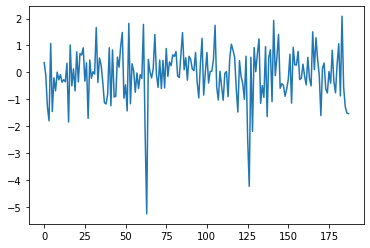

In [58]:
xpoints=range(188)
ypoints=torch.sum(para[2],dim=0).detach().numpy()
plt.plot(xpoints,ypoints)
plt.show()

# 简化模型并绘制图像

In [59]:
class zyt(nn.Module):
    def __init__(self):
        super(zyt,self).__init__()
        self.model1=Sequential(
            nn.LayerNorm(188),
            Linear(188,1),
            nn.ReLU(),
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x=self.model1(x)
        return x
zyt1=zyt()
zyt1=zyt1.cuda()

In [60]:
# loss_fn=torch.nn.MSELoss()#SpearmanLossFunc()
loss_fn=torch.nn.MSELoss()
loss_fn=loss_fn.cuda()
#优化器
learning_rate=0.001
optimizer=torch.optim.Adam(zyt1.parameters(),lr=learning_rate)
#训练的轮数
epoch=5000

In [61]:
maxspear=0
for i in range(epoch):
    zyt1.train()
    print("------第{}轮训练开始-------".format(i+1))
#     start_time=time.time()
    output=zyt1(trainx_cifar10)
    print(output)
    curspear=abs(stats.spearmanr(output.cpu().detach().numpy(),trainy_cifar10.cpu().detach().numpy(),nan_policy='omit').correlation)
    print(curspear)
    if (curspear>maxspear):
        maxspear=curspear
        maxepoch=i
    loss=loss_fn(output,trainy_cifar10)
    #优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()                
    print("train_loss:{}".format(loss.item()))
#     end_time=time.time()
#     print("time_cost:{}".format(end_time-start_time))
    #测试步骤开始
    zyt1.eval() #让网络进入测试状态
    #no_grad()保证不影响梯度，不会进行调优
    with torch.no_grad():
        test_output=zyt1(testx_cifar10)
        test_loss=loss_fn(test_output,testy_cifar10)
        print("test_loss:{}".format(test_loss.item()))

------第1轮训练开始-------
tensor([[0.6381],
        [0.5000],
        [0.5885],
        ...,
        [0.6076],
        [0.6074],
        [0.6209]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.2431264705630458
train_loss:0.10421070053031688
test_loss:0.10166895079993087
------第2轮训练开始-------
tensor([[0.6390],
        [0.5000],
        [0.6037],
        ...,
        [0.6069],
        [0.6085],
        [0.6374]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.2283023908415918
train_loss:0.1006841321620905
test_loss:0.0981166849212199
------第3轮训练开始-------
tensor([[0.6405],
        [0.5000],
        [0.6190],
        ...,
        [0.6067],
        [0.6099],
        [0.6468]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.21842730501103624
train_loss:0.09716339610306923
test_loss:0.09469438588894553
------第4轮训练开始-------
tensor([[0.6421],
        [0.5000],
        [0.6336],
        ...,
        [0.6068],
        [0.6113],
        [0.6543]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.1951515

test_loss:0.024871612535637074
------第39轮训练开始-------
tensor([[0.7280],
        [0.7842],
        [0.7505],
        ...,
        [0.6863],
        [0.6541],
        [0.6463]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.11997754422521721
train_loss:0.024627228625188676
test_loss:0.023945549075703888
------第40轮训练开始-------
tensor([[0.7353],
        [0.7918],
        [0.7520],
        ...,
        [0.6938],
        [0.6595],
        [0.6440]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.11825012306441056
train_loss:0.023650321417954777
test_loss:0.02309489726882237
------第41轮训练开始-------
tensor([[0.7426],
        [0.7990],
        [0.7536],
        ...,
        [0.7010],
        [0.6653],
        [0.6418]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.1166499648177209
train_loss:0.022740098589330807
test_loss:0.022324731579494522
------第42轮训练开始-------
tensor([[0.7498],
        [0.8058],
        [0.7552],
        ...,
        [0.7080],
        [0.6715],
        [0.6401]], device='cud

0.023468861639217648
train_loss:0.015957453135453034
test_loss:0.017143248846899467
------第70轮训练开始-------
tensor([[0.8436],
        [0.8716],
        [0.8033],
        ...,
        [0.7744],
        [0.7864],
        [0.7433]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.02659234323847065
train_loss:0.015917577836324633
test_loss:0.0171072667974732
------第71轮训练开始-------
tensor([[0.8442],
        [0.8712],
        [0.8049],
        ...,
        [0.7746],
        [0.7873],
        [0.7474]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.028848264516569983
train_loss:0.015880025487891664
test_loss:0.017072679135420196
------第72轮训练开始-------
tensor([[0.8447],
        [0.8707],
        [0.8066],
        ...,
        [0.7748],
        [0.7882],
        [0.7511]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.031011053363672315
train_loss:0.015844604127870754
test_loss:0.01703938781839744
------第73轮训练开始-------
tensor([[0.8451],
        [0.8702],
        [0.8082],
        ...,
        [0.7

train_loss:0.015113116509178072
test_loss:0.016181130363614963
------第111轮训练开始-------
tensor([[0.8440],
        [0.8520],
        [0.8343],
        ...,
        [0.7723],
        [0.7910],
        [0.7773]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.04532452537986697
train_loss:0.015098842424697119
test_loss:0.016162174438304647
------第112轮训练开始-------
tensor([[0.8440],
        [0.8519],
        [0.8344],
        ...,
        [0.7723],
        [0.7909],
        [0.7768]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.04460090477671729
train_loss:0.015084591331272029
test_loss:0.016143230057448686
------第113轮训练开始-------
tensor([[0.8439],
        [0.8519],
        [0.8344],
        ...,
        [0.7722],
        [0.7909],
        [0.7764]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.04449061339197316
train_loss:0.015070353665036215
test_loss:0.0161242885261234
------第114轮训练开始-------
tensor([[0.8438],
        [0.8518],
        [0.8345],
        ...,
        [0.7721],
        [0.7

test_loss:0.015575777676857475
------第142轮训练开始-------
tensor([[0.8425],
        [0.8518],
        [0.8342],
        ...,
        [0.7711],
        [0.7913],
        [0.7713]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.03842369356843165
train_loss:0.01463963227585747
test_loss:0.015555226183668999
------第143轮训练开始-------
tensor([[0.8424],
        [0.8518],
        [0.8341],
        ...,
        [0.7712],
        [0.7913],
        [0.7712]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0380962555536379
train_loss:0.014623826052610686
test_loss:0.01553459770126182
------第144轮训练开始-------
tensor([[0.8424],
        [0.8518],
        [0.8341],
        ...,
        [0.7712],
        [0.7913],
        [0.7712]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.037723803141338746
train_loss:0.014607949559974305
test_loss:0.015513891500176149
------第145轮训练开始-------
tensor([[0.8424],
        [0.8518],
        [0.8341],
        ...,
        [0.7712],
        [0.7913],
        [0.7712]], device=

train_loss:0.013916913937293465
test_loss:0.014617692317094358
------第185轮训练开始-------
tensor([[0.8407],
        [0.8523],
        [0.8320],
        ...,
        [0.7731],
        [0.7897],
        [0.7700]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.020297505032155164
train_loss:0.013898278487378757
test_loss:0.014593586424230327
------第186轮训练开始-------
tensor([[0.8407],
        [0.8523],
        [0.8320],
        ...,
        [0.7731],
        [0.7897],
        [0.7700]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.019820612619435084
train_loss:0.013879578429343606
test_loss:0.014569401460037094
------第187轮训练开始-------
tensor([[0.8406],
        [0.8524],
        [0.8319],
        ...,
        [0.7731],
        [0.7896],
        [0.7699]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01927777109985262
train_loss:0.01386081390540449
test_loss:0.01454513783590585
------第188轮训练开始-------
tensor([[0.8405],
        [0.8524],
        [0.8319],
        ...,
        [0.7732],
        [0

0.0022524351752791294
train_loss:0.013101503370609167
test_loss:0.013568353784808465
------第226轮训练开始-------
tensor([[0.8386],
        [0.8528],
        [0.8298],
        ...,
        [0.7749],
        [0.7878],
        [0.7684]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0029408918644930433
train_loss:0.013080347924289967
test_loss:0.013541293051449141
------第227轮训练开始-------
tensor([[0.8386],
        [0.8528],
        [0.8298],
        ...,
        [0.7749],
        [0.7878],
        [0.7683]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0035902316821920777
train_loss:0.013059134849363203
test_loss:0.013514167311937072
------第228轮训练开始-------
tensor([[0.8386],
        [0.8528],
        [0.8297],
        ...,
        [0.7750],
        [0.7878],
        [0.7683]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004302869251424394
train_loss:0.013037864371100927
test_loss:0.013486976946119097
------第229轮训练开始-------
tensor([[0.8385],
        [0.8529],
        [0.8297],
        ...,
 

train_loss:0.01214331651213105
test_loss:0.012351729582548274
------第269轮训练开始-------
tensor([[0.8367],
        [0.8537],
        [0.8277],
        ...,
        [0.7775],
        [0.7861],
        [0.7669]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.04898994969136412
train_loss:0.012119967951109265
test_loss:0.012322326078359843
------第270轮训练开始-------
tensor([[0.8367],
        [0.8538],
        [0.8276],
        ...,
        [0.7776],
        [0.7861],
        [0.7668]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.05018291401471578
train_loss:0.012096578140640319
test_loss:0.012292883057502434
------第271轮训练开始-------
tensor([[0.8367],
        [0.8538],
        [0.8276],
        ...,
        [0.7776],
        [0.7860],
        [0.7668]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.05138054490927522
train_loss:0.012073147693942096
test_loss:0.012263401437324944
------第272轮训练开始-------
tensor([[0.8366],
        [0.8538],
        [0.8275],
        ...,
        [0.7777],
        [0.

0.11831633450932655
train_loss:0.011095267108528165
test_loss:0.011065129095331515
------第313轮训练开始-------
tensor([[0.8354],
        [0.8554],
        [0.8258],
        ...,
        [0.7812],
        [0.7849],
        [0.7661]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.11994331890929304
train_loss:0.011071574292744708
test_loss:0.011037361225591681
------第314轮训练开始-------
tensor([[0.8354],
        [0.8555],
        [0.8258],
        ...,
        [0.7813],
        [0.7849],
        [0.7661]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.1219115780711569
train_loss:0.011047885316715368
test_loss:0.011009608186304918
------第315轮训练开始-------
tensor([[0.8353],
        [0.8555],
        [0.8257],
        ...,
        [0.7815],
        [0.7849],
        [0.7661]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.12388015084842577
train_loss:0.011024200404664558
test_loss:0.01098186984548318
------第316轮训练开始-------
tensor([[0.8353],
        [0.8556],
        [0.8257],
        ...,
        [0

0.19241172888977554
train_loss:0.010407909724480238
test_loss:0.010326893189165545
------第352轮训练开始-------
tensor([[0.8418],
        [0.8615],
        [0.8313],
        ...,
        [0.7921],
        [0.7919],
        [0.7743]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.19431452637058813
train_loss:0.010396086029056603
test_loss:0.010315120096762685
------第353轮训练开始-------
tensor([[0.8419],
        [0.8616],
        [0.8315],
        ...,
        [0.7923],
        [0.7921],
        [0.7745]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.19626275561550488
train_loss:0.01038429261235786
test_loss:0.010303365928344702
------第354轮训练开始-------
tensor([[0.8420],
        [0.8617],
        [0.8317],
        ...,
        [0.7924],
        [0.7924],
        [0.7748]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.1985932046094537
train_loss:0.010372517715289648
test_loss:0.010291620664680744
------第355轮训练开始-------
tensor([[0.8421],
        [0.8617],
        [0.8319],
        ...,
        [0

------第393轮训练开始-------
tensor([[0.8407],
        [0.8625],
        [0.8314],
        ...,
        [0.7947],
        [0.7921],
        [0.7736]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.3258442102184895
train_loss:0.009908873154501587
test_loss:0.009827724324874578
------第394轮训练开始-------
tensor([[0.8406],
        [0.8626],
        [0.8314],
        ...,
        [0.7948],
        [0.7921],
        [0.7736]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.33011026262050336
train_loss:0.009896954639098138
test_loss:0.009815844591953928
------第395轮训练开始-------
tensor([[0.8406],
        [0.8626],
        [0.8313],
        ...,
        [0.7949],
        [0.7921],
        [0.7736]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.33399804628488194
train_loss:0.009885036787277418
test_loss:0.009803971744600197
------第396轮训练开始-------
tensor([[0.8406],
        [0.8627],
        [0.8313],
        ...,
        [0.7950],
        [0.7920],
        [0.7736]], device='cuda:0', grad_fn=<SigmoidBack

train_loss:0.00943960434580967
test_loss:0.009368044435121918
------第434轮训练开始-------
tensor([[0.8405],
        [0.8648],
        [0.8306],
        ...,
        [0.7993],
        [0.7920],
        [0.7742]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.4666818865244824
train_loss:0.009428113424256567
test_loss:0.00935690571006846
------第435轮训练开始-------
tensor([[0.8406],
        [0.8649],
        [0.8306],
        ...,
        [0.7994],
        [0.7920],
        [0.7742]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.469757652997418
train_loss:0.00941663629011931
test_loss:0.009345783376507742
------第436轮训练开始-------
tensor([[0.8406],
        [0.8649],
        [0.8306],
        ...,
        [0.7996],
        [0.7920],
        [0.7743]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.4728198932299386
train_loss:0.009405173138039194
test_loss:0.00933467753777893
------第437轮训练开始-------
tensor([[0.8406],
        [0.8650],
        [0.8306],
        ...,
        [0.7997],
        [0.7920],


train_loss:0.008972641719877479
test_loss:0.008922132025594543
------第476轮训练开始-------
tensor([[0.8412],
        [0.8674],
        [0.8306],
        ...,
        [0.8041],
        [0.7925],
        [0.7750]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.5987544789951942
train_loss:0.008961999285371395
test_loss:0.008912073386156393
------第477轮训练开始-------
tensor([[0.8412],
        [0.8675],
        [0.8306],
        ...,
        [0.8042],
        [0.7925],
        [0.7750]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6007690957203454
train_loss:0.00895137991624178
test_loss:0.00890203895108568
------第478轮训练开始-------
tensor([[0.8413],
        [0.8675],
        [0.8306],
        ...,
        [0.8043],
        [0.7925],
        [0.7751]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6024620139485964
train_loss:0.008940783684692904
test_loss:0.008892028796608163
------第479轮训练开始-------
tensor([[0.8413],
        [0.8676],
        [0.8306],
        ...,
        [0.8044],
        [0.7925

tensor([[0.8426],
        [0.8701],
        [0.8314],
        ...,
        [0.8085],
        [0.7934],
        [0.7762]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6736619543451183
train_loss:0.008527087400410048
test_loss:0.008503699922256407
------第520轮训练开始-------
tensor([[0.8427],
        [0.8702],
        [0.8314],
        ...,
        [0.8086],
        [0.7934],
        [0.7762]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6746928057659335
train_loss:0.008517510704891554
test_loss:0.008494782086073233
------第521轮训练开始-------
tensor([[0.8427],
        [0.8703],
        [0.8314],
        ...,
        [0.8087],
        [0.7934],
        [0.7762]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.6756173235730424
train_loss:0.008507958114021203
test_loss:0.008485890379442468
------第522轮训练开始-------
tensor([[0.8427],
        [0.8703],
        [0.8314],
        ...,
        [0.8088],
        [0.7935],
        [0.7762]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.676483461215551

0.7110941000386181
train_loss:0.008144414603798396
test_loss:0.00815054758279092
------第562轮训练开始-------
tensor([[0.8448],
        [0.8728],
        [0.8328],
        ...,
        [0.8124],
        [0.7945],
        [0.7775]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7116480523901906
train_loss:0.008135750849332789
test_loss:0.00814263697314747
------第563轮训练开始-------
tensor([[0.8448],
        [0.8729],
        [0.8328],
        ...,
        [0.8125],
        [0.7945],
        [0.7775]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7121401087210811
train_loss:0.008127105562180891
test_loss:0.00813474733384046
------第564轮训练开始-------
tensor([[0.8449],
        [0.8729],
        [0.8329],
        ...,
        [0.8126],
        [0.7946],
        [0.7775]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7126424519607268
train_loss:0.00811847856355205
test_loss:0.008126878492627655
------第565轮训练开始-------
tensor([[0.8449],
        [0.8730],
        [0.8329],
        ...,
        [0.8127]

train_loss:0.007802389529427555
test_loss:0.007841525431087883
------第603轮训练开始-------
tensor([[0.8473],
        [0.8751],
        [0.8346],
        ...,
        [0.8154],
        [0.7955],
        [0.7786]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7307501463631069
train_loss:0.007794332658845395
test_loss:0.007834329595012946
------第604轮训练开始-------
tensor([[0.8474],
        [0.8752],
        [0.8346],
        ...,
        [0.8154],
        [0.7956],
        [0.7786]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7310837468854955
train_loss:0.0077862868196438475
test_loss:0.007827147514018959
------第605轮训练开始-------
tensor([[0.8474],
        [0.8752],
        [0.8347],
        ...,
        [0.8155],
        [0.7956],
        [0.7787]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7314003408597368
train_loss:0.007778251844347118
test_loss:0.007819979021314294
------第606轮训练开始-------
tensor([[0.8475],
        [0.8753],
        [0.8347],
        ...,
        [0.8156],
        [0.7

test_loss:0.007556135192939997
------第644轮训练开始-------
tensor([[0.8501],
        [0.8772],
        [0.8366],
        ...,
        [0.8175],
        [0.7963],
        [0.7795]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7411995680898662
train_loss:0.0074717538140253925
test_loss:0.007549381605269278
------第645轮训练开始-------
tensor([[0.8502],
        [0.8772],
        [0.8366],
        ...,
        [0.8176],
        [0.7964],
        [0.7795]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.741440698081147
train_loss:0.007464034869220754
test_loss:0.007542636154216854
------第646轮训练开始-------
tensor([[0.8502],
        [0.8773],
        [0.8367],
        ...,
        [0.8176],
        [0.7964],
        [0.7795]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7416778690845398
train_loss:0.007456321399238583
test_loss:0.007535898739066849
------第647轮训练开始-------
tensor([[0.8503],
        [0.8773],
        [0.8367],
        ...,
        [0.8177],
        [0.7964],
        [0.7795]], device='

train_loss:0.007166565586578032
test_loss:0.007285025951787833
------第685轮训练开始-------
tensor([[0.8531],
        [0.8789],
        [0.8387],
        ...,
        [0.8190],
        [0.7969],
        [0.7801]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7470086104744839
train_loss:0.007159015688430134
test_loss:0.007278543228638456
------第686轮训练开始-------
tensor([[0.8531],
        [0.8790],
        [0.8388],
        ...,
        [0.8191],
        [0.7969],
        [0.7801]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7470917643104013
train_loss:0.007151469244878713
test_loss:0.007272066024055249
------第687轮训练开始-------
tensor([[0.8532],
        [0.8790],
        [0.8388],
        ...,
        [0.8191],
        [0.7969],
        [0.7801]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7471667728343113
train_loss:0.007143926244439351
test_loss:0.007265594310819491
------第688轮训练开始-------
tensor([[0.8533],
        [0.8790],
        [0.8389],
        ...,
        [0.8191],
        [0.79

0.7478936451051104
train_loss:0.0068747064949045995
test_loss:0.007036162716924338
------第724轮训练开始-------
tensor([[0.8560],
        [0.8804],
        [0.8408],
        ...,
        [0.8200],
        [0.7971],
        [0.7804]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7479668236542641
train_loss:0.006867297172105408
test_loss:0.007029888379802202
------第725轮训练开始-------
tensor([[0.8561],
        [0.8804],
        [0.8409],
        ...,
        [0.8200],
        [0.7971],
        [0.7804]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7479895242797465
train_loss:0.006859891977046217
test_loss:0.007023619542798995
------第726轮训练开始-------
tensor([[0.8562],
        [0.8804],
        [0.8409],
        ...,
        [0.8200],
        [0.7972],
        [0.7804]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7481052665353678
train_loss:0.006852490952669742
test_loss:0.007017356229550839
------第727轮训练开始-------
tensor([[0.8562],
        [0.8805],
        [0.8410],
        ...,
        [0.

0.7477229065777822
train_loss:0.006567663569661053
test_loss:0.00677774481636415
------第766轮训练开始-------
tensor([[0.8592],
        [0.8818],
        [0.8431],
        ...,
        [0.8206],
        [0.7973],
        [0.7805]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7476892482577271
train_loss:0.006560474596218555
test_loss:0.006771731440005986
------第767轮训练开始-------
tensor([[0.8593],
        [0.8819],
        [0.8432],
        ...,
        [0.8206],
        [0.7973],
        [0.7805]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7476652572008612
train_loss:0.006553292253556224
test_loss:0.006765725230498998
------第768轮训练开始-------
tensor([[0.8594],
        [0.8819],
        [0.8432],
        ...,
        [0.8206],
        [0.7973],
        [0.7805]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7476784018694997
train_loss:0.006546116613839725
test_loss:0.006759726239930367
------第769轮训练开始-------
tensor([[0.8595],
        [0.8819],
        [0.8433],
        ...,
        [0.82

tensor([[0.8624],
        [0.8831],
        [0.8454],
        ...,
        [0.8210],
        [0.7974],
        [0.7806]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.745988584467842
train_loss:0.006279148525898259
test_loss:0.006537657037281766
------第807轮训练开始-------
tensor([[0.8625],
        [0.8832],
        [0.8454],
        ...,
        [0.8210],
        [0.7974],
        [0.7806]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7459169939978523
train_loss:0.006272293074871896
test_loss:0.00653198295978664
------第808轮训练开始-------
tensor([[0.8625],
        [0.8832],
        [0.8455],
        ...,
        [0.8211],
        [0.7974],
        [0.7806]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7458535454664044
train_loss:0.0062654473684627815
test_loss:0.006526318363135484
------第809轮训练开始-------
tensor([[0.8626],
        [0.8832],
        [0.8456],
        ...,
        [0.8211],
        [0.7974],
        [0.7806]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7457801516839263

0.7430383366015948
train_loss:0.005994081505719385
test_loss:0.006302929232224739
------第850轮训练开始-------
tensor([[0.8659],
        [0.8846],
        [0.8479],
        ...,
        [0.8215],
        [0.7975],
        [0.7807]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7429497860505863
train_loss:0.0059877113317555125
test_loss:0.0062977131025945855
------第851轮训练开始-------
tensor([[0.8660],
        [0.8846],
        [0.8480],
        ...,
        [0.8215],
        [0.7975],
        [0.7807]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7428465448099878
train_loss:0.005981353959802336
test_loss:0.006292508773018003
------第852轮训练开始-------
tensor([[0.8660],
        [0.8846],
        [0.8481],
        ...,
        [0.8215],
        [0.7975],
        [0.7807]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7427739075460289
train_loss:0.005975009452938865
test_loss:0.006287316291128188
------第853轮训练开始-------
tensor([[0.8661],
        [0.8847],
        [0.8481],
        ...,
        [0

0.7436046960300539
train_loss:0.005819733308718223
test_loss:0.006162891640136927
------第892轮训练开始-------
tensor([[0.8718],
        [0.8878],
        [0.8539],
        ...,
        [0.8274],
        [0.8034],
        [0.7865]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7436847099170345
train_loss:0.005817859703562663
test_loss:0.0061604140816347895
------第893轮训练开始-------
tensor([[0.8719],
        [0.8879],
        [0.8540],
        ...,
        [0.8275],
        [0.8034],
        [0.7865]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7438085468044686
train_loss:0.005815227495371708
test_loss:0.006157531692122005
------第894轮训练开始-------
tensor([[0.8720],
        [0.8880],
        [0.8540],
        ...,
        [0.8277],
        [0.8035],
        [0.7865]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7439855026681875
train_loss:0.005811891706436732
test_loss:0.006155412208241799
------第895轮训练开始-------
tensor([[0.8720],
        [0.8882],
        [0.8542],
        ...,
        [0.

train_loss:0.005737013600500887
test_loss:0.0060921491215709745
------第934轮训练开始-------
tensor([[0.8740],
        [0.8908],
        [0.8561],
        ...,
        [0.8313],
        [0.8059],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.749252597170875
train_loss:0.0057346737494704215
test_loss:0.006091001899628457
------第935轮训练开始-------
tensor([[0.8740],
        [0.8907],
        [0.8561],
        ...,
        [0.8313],
        [0.8058],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7492555458539382
train_loss:0.005733756786075939
test_loss:0.006090207840074613
------第936轮训练开始-------
tensor([[0.8740],
        [0.8907],
        [0.8561],
        ...,
        [0.8313],
        [0.8058],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7493093768858724
train_loss:0.005733016288113939
test_loss:0.006089115660783746
------第937轮训练开始-------
tensor([[0.8740],
        [0.8908],
        [0.8561],
        ...,
        [0.8314],
        [0.8

test_loss:0.006056446419022133
------第974轮训练开始-------
tensor([[0.8758],
        [0.8927],
        [0.8581],
        ...,
        [0.8343],
        [0.8080],
        [0.7914]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7515158812250026
train_loss:0.0056909393362081714
test_loss:0.006056570833090257
------第975轮训练开始-------
tensor([[0.8759],
        [0.8928],
        [0.8583],
        ...,
        [0.8344],
        [0.8082],
        [0.7916]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7516021199607041
train_loss:0.005690623249431845
test_loss:0.006056041792198212
------第976轮训练开始-------
tensor([[0.8759],
        [0.8929],
        [0.8583],
        ...,
        [0.8345],
        [0.8083],
        [0.7916]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7516327526050436
train_loss:0.005689919346275939
test_loss:0.006054471391074726
------第977轮训练开始-------
tensor([[0.8759],
        [0.8928],
        [0.8583],
        ...,
        [0.8345],
        [0.8082],
        [0.7916]], device=

tensor([[0.8769],
        [0.8938],
        [0.8594],
        ...,
        [0.8364],
        [0.8093],
        [0.7926]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7523074062933269
train_loss:0.005667660252565102
test_loss:0.006037320464726816
------第1014轮训练开始-------
tensor([[0.8769],
        [0.8939],
        [0.8595],
        ...,
        [0.8364],
        [0.8094],
        [0.7927]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7523791965602831
train_loss:0.005667097567833172
test_loss:0.006036886642832615
------第1015轮训练开始-------
tensor([[0.8769],
        [0.8940],
        [0.8596],
        ...,
        [0.8364],
        [0.8095],
        [0.7928]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7524847466684211
train_loss:0.005666256125755845
test_loss:0.006036401019427604
------第1016轮训练开始-------
tensor([[0.8769],
        [0.8941],
        [0.8597],
        ...,
        [0.8363],
        [0.8097],
        [0.7930]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.752604962425

train_loss:0.005651101013766579
test_loss:0.006025509069147318
------第1052轮训练开始-------
tensor([[0.8777],
        [0.8951],
        [0.8608],
        ...,
        [0.8380],
        [0.8108],
        [0.7941]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7532122448891058
train_loss:0.005650753894904207
test_loss:0.006025551341535148
------第1053轮训练开始-------
tensor([[0.8778],
        [0.8951],
        [0.8609],
        ...,
        [0.8381],
        [0.8109],
        [0.7941]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7532384674920022
train_loss:0.005650635117552706
test_loss:0.006025019907202627
------第1054轮训练开始-------
tensor([[0.8778],
        [0.8951],
        [0.8608],
        ...,
        [0.8381],
        [0.8108],
        [0.7941]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7532003206765548
train_loss:0.005650300720391603
test_loss:0.006024795444321513
------第1055轮训练开始-------
tensor([[0.8778],
        [0.8951],
        [0.8608],
        ...,
        [0.8382],
        [

0.7540027517329922
train_loss:0.005641276953568237
test_loss:0.0060175831447283265
------第1091轮训练开始-------
tensor([[0.8782],
        [0.8957],
        [0.8616],
        ...,
        [0.8393],
        [0.8115],
        [0.7947]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7540541599275503
train_loss:0.0056407326782364434
test_loss:0.00601775624183821
------第1092轮训练开始-------
tensor([[0.8783],
        [0.8958],
        [0.8617],
        ...,
        [0.8394],
        [0.8116],
        [0.7949]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7541115505662632
train_loss:0.005640557246660529
test_loss:0.00601717102134511
------第1093轮训练开始-------
tensor([[0.8783],
        [0.8958],
        [0.8617],
        ...,
        [0.8394],
        [0.8116],
        [0.7948]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7541071877871676
train_loss:0.005640009754032953
test_loss:0.006016972184153455
------第1094轮训练开始-------
tensor([[0.8783],
        [0.8958],
        [0.8617],
        ...,
        

train_loss:0.0056332114525268085
test_loss:0.006011245550123711
------第1129轮训练开始-------
tensor([[0.8784],
        [0.8962],
        [0.8622],
        ...,
        [0.8402],
        [0.8119],
        [0.7952]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7549243257218037
train_loss:0.005633142012476857
test_loss:0.0060110734668181
------第1130轮训练开始-------
tensor([[0.8784],
        [0.8961],
        [0.8621],
        ...,
        [0.8402],
        [0.8119],
        [0.7951]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7549299752271952
train_loss:0.005633094565429972
test_loss:0.006010897641805175
------第1131轮训练开始-------
tensor([[0.8784],
        [0.8962],
        [0.8622],
        ...,
        [0.8402],
        [0.8119],
        [0.7951]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7549483799851411
train_loss:0.005632892935964835
test_loss:0.006010719553606861
------第1132轮训练开始-------
tensor([[0.8785],
        [0.8962],
        [0.8622],
        ...,
        [0.8402],
        [0

0.7557715580365097
train_loss:0.005627357723857056
test_loss:0.006005552080012678
------第1171轮训练开始-------
tensor([[0.8785],
        [0.8967],
        [0.8626],
        ...,
        [0.8409],
        [0.8122],
        [0.7954]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7556175783957176
train_loss:0.005626308987551161
test_loss:0.006005280476361593
------第1172轮训练开始-------
tensor([[0.8786],
        [0.8966],
        [0.8625],
        ...,
        [0.8411],
        [0.8121],
        [0.7953]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7554683936155214
train_loss:0.005626516354473576
test_loss:0.0060050483622236745
------第1173轮训练开始-------
tensor([[0.8786],
        [0.8965],
        [0.8625],
        ...,
        [0.8413],
        [0.8120],
        [0.7952]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7553437057770276
train_loss:0.0056265940315724135
test_loss:0.0060048496261357765
------第1174轮训练开始-------
tensor([[0.8787],
        [0.8965],
        [0.8625],
        ...,
     

train_loss:0.005620044976904156
test_loss:0.005998901215949858
------第1214轮训练开始-------
tensor([[0.8786],
        [0.8967],
        [0.8628],
        ...,
        [0.8419],
        [0.8121],
        [0.7953]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.755759728535137
train_loss:0.005620305400425162
test_loss:0.00599868371354585
------第1215轮训练开始-------
tensor([[0.8786],
        [0.8966],
        [0.8627],
        ...,
        [0.8420],
        [0.8121],
        [0.7952]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7556346531917522
train_loss:0.0056204353279967634
test_loss:0.005998510158442358
------第1216轮训练开始-------
tensor([[0.8786],
        [0.8966],
        [0.8627],
        ...,
        [0.8420],
        [0.8120],
        [0.7951]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7555927784626159
train_loss:0.005620417483233001
test_loss:0.005998371927368239
------第1217轮训练开始-------
tensor([[0.8786],
        [0.8966],
        [0.8627],
        ...,
        [0.8420],
        [0

0.7560588768480515
train_loss:0.005614903062842482
test_loss:0.005992480913816964
------第1259轮训练开始-------
tensor([[0.8783],
        [0.8967],
        [0.8628],
        ...,
        [0.8423],
        [0.8119],
        [0.7950]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7560475814540846
train_loss:0.00561491161704911
test_loss:0.005992355062105369
------第1260轮训练开始-------
tensor([[0.8783],
        [0.8967],
        [0.8629],
        ...,
        [0.8422],
        [0.8119],
        [0.7950]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7560733402405752
train_loss:0.005614768915210819
test_loss:0.00599226020349169
------第1261轮训练开始-------
tensor([[0.8783],
        [0.8967],
        [0.8629],
        ...,
        [0.8422],
        [0.8120],
        [0.7950]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7561384624746919
train_loss:0.005614492738726158
test_loss:0.005992196192057636
------第1262轮训练开始-------
tensor([[0.8783],
        [0.8968],
        [0.8630],
        ...,
        [0

test_loss:0.005986709180363046
------第1300轮训练开始-------
tensor([[0.8781],
        [0.8970],
        [0.8632],
        ...,
        [0.8425],
        [0.8122],
        [0.7952]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7567057225931578
train_loss:0.005608451559875332
test_loss:0.0059865439975288395
------第1301轮训练开始-------
tensor([[0.8781],
        [0.8970],
        [0.8632],
        ...,
        [0.8425],
        [0.8122],
        [0.7952]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7567293897216312
train_loss:0.005608286037265106
test_loss:0.005986386314862669
------第1302轮训练开始-------
tensor([[0.8781],
        [0.8970],
        [0.8633],
        ...,
        [0.8425],
        [0.8122],
        [0.7953]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7567541539471907
train_loss:0.005608033065629278
test_loss:0.005987082630839638
------第1303轮训练开始-------
tensor([[0.8781],
        [0.8970],
        [0.8633],
        ...,
        [0.8426],
        [0.8123],
        [0.7953]], dev

0.7569405382215464
train_loss:0.005603578793634976
test_loss:0.00598097951890487
------第1343轮训练开始-------
tensor([[0.8779],
        [0.8970],
        [0.8633],
        ...,
        [0.8429],
        [0.8120],
        [0.7951]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7571021463992752
train_loss:0.005603143469693502
test_loss:0.005981543596815168
------第1344轮训练开始-------
tensor([[0.8779],
        [0.8972],
        [0.8635],
        ...,
        [0.8428],
        [0.8122],
        [0.7953]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572433350366482
train_loss:0.005603313300108421
test_loss:0.005980816339421901
------第1345轮训练开始-------
tensor([[0.8779],
        [0.8971],
        [0.8634],
        ...,
        [0.8428],
        [0.8121],
        [0.7952]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572620528955628
train_loss:0.005602678288897901
test_loss:0.005980604523280993
------第1346轮训练开始-------
tensor([[0.8779],
        [0.8971],
        [0.8634],
        ...,
        [

0.75743320677429
train_loss:0.00559864318870613
test_loss:0.005975064608865992
------第1382轮训练开始-------
tensor([[0.8775],
        [0.8968],
        [0.8631],
        ...,
        [0.8431],
        [0.8116],
        [0.7946]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7573285986009065
train_loss:0.00559900540353641
test_loss:0.005974841719638976
------第1383轮训练开始-------
tensor([[0.8775],
        [0.8967],
        [0.8631],
        ...,
        [0.8431],
        [0.8115],
        [0.7945]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572538270282397
train_loss:0.005599243359704502
test_loss:0.005974674406958899
------第1384轮训练开始-------
tensor([[0.8775],
        [0.8967],
        [0.8630],
        ...,
        [0.8431],
        [0.8114],
        [0.7944]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572271687286535
train_loss:0.0055993276445445465
test_loss:0.00597454819380833
------第1385轮训练开始-------
tensor([[0.8774],
        [0.8967],
        [0.8630],
        ...,
        [0.8

tensor([[0.8772],
        [0.8969],
        [0.8632],
        ...,
        [0.8432],
        [0.8114],
        [0.7943]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7577714307352215
train_loss:0.0055940501885774945
test_loss:0.0059696654469159555
------第1424轮训练开始-------
tensor([[0.8772],
        [0.8970],
        [0.8633],
        ...,
        [0.8432],
        [0.8115],
        [0.7945]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578636050282895
train_loss:0.005593585390770153
test_loss:0.005969723024624682
------第1425轮训练开始-------
tensor([[0.8773],
        [0.8971],
        [0.8634],
        ...,
        [0.8432],
        [0.8117],
        [0.7946]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579229953758774
train_loss:0.00559310654252147
test_loss:0.0059716791478165564
------第1426轮训练开始-------
tensor([[0.8774],
        [0.8973],
        [0.8636],
        ...,
        [0.8433],
        [0.8118],
        [0.7948]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579428845

train_loss:0.005588992740132969
test_loss:0.005963997771783741
------第1464轮训练开始-------
tensor([[0.8773],
        [0.8969],
        [0.8631],
        ...,
        [0.8443],
        [0.8111],
        [0.7941]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574844712688632
train_loss:0.0055892946308773875
test_loss:0.005963742723470719
------第1465轮训练开始-------
tensor([[0.8773],
        [0.8968],
        [0.8631],
        ...,
        [0.8444],
        [0.8110],
        [0.7940]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7573248091022966
train_loss:0.005589491783781999
test_loss:0.00596357264460414
------第1466轮训练开始-------
tensor([[0.8773],
        [0.8967],
        [0.8630],
        ...,
        [0.8444],
        [0.8109],
        [0.7939]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572716467664397
train_loss:0.0055895506408400915
test_loss:0.0059634712577053125
------第1467轮训练开始-------
tensor([[0.8773],
        [0.8967],
        [0.8630],
        ...,
        [0.8444],
       

0.7578876516484877
train_loss:0.005584128055157146
test_loss:0.0059581272294744305
------第1507轮训练开始-------
tensor([[0.8769],
        [0.8969],
        [0.8634],
        ...,
        [0.8441],
        [0.8111],
        [0.7941]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580269636069557
train_loss:0.005583752439873039
test_loss:0.005959412502334223
------第1508轮训练开始-------
tensor([[0.8769],
        [0.8970],
        [0.8635],
        ...,
        [0.8440],
        [0.8113],
        [0.7943]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758156693535582
train_loss:0.005584846518417958
test_loss:0.00595826677343332
------第1509轮训练开始-------
tensor([[0.8768],
        [0.8970],
        [0.8634],
        ...,
        [0.8439],
        [0.8112],
        [0.7942]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7581605953399525
train_loss:0.005583791923251513
test_loss:0.005957590678110521
------第1510轮训练开始-------
tensor([[0.8767],
        [0.8968],
        [0.8632],
        ...,
        [

0.7581482938253471
train_loss:0.005580231025917211
test_loss:0.005952888739489562
------第1548轮训练开始-------
tensor([[0.8767],
        [0.8967],
        [0.8631],
        ...,
        [0.8445],
        [0.8106],
        [0.7935]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579929066076911
train_loss:0.005580454018167793
test_loss:0.005952696291395244
------第1549轮训练开始-------
tensor([[0.8767],
        [0.8966],
        [0.8631],
        ...,
        [0.8446],
        [0.8105],
        [0.7934]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579113255120035
train_loss:0.005580535865329481
test_loss:0.005952574208260593
------第1550轮训练开始-------
tensor([[0.8767],
        [0.8966],
        [0.8630],
        ...,
        [0.8446],
        [0.8105],
        [0.7934]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579233128972073
train_loss:0.005580462714435046
test_loss:0.005952514041674611
------第1551轮训练开始-------
tensor([[0.8766],
        [0.8967],
        [0.8631],
        ...,
        

tensor([[0.8763],
        [0.8969],
        [0.8634],
        ...,
        [0.8442],
        [0.8107],
        [0.7936]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7587934945088083
train_loss:0.005575217024417599
test_loss:0.005948198445942156
------第1591轮训练开始-------
tensor([[0.8763],
        [0.8970],
        [0.8635],
        ...,
        [0.8441],
        [0.8108],
        [0.7938]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7589185385690408
train_loss:0.005574775539356906
test_loss:0.005948014918936531
------第1592轮训练开始-------
tensor([[0.8763],
        [0.8970],
        [0.8635],
        ...,
        [0.8441],
        [0.8108],
        [0.7937]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7588913724852061
train_loss:0.005574790721655887
test_loss:0.005947813201164197
------第1593轮训练开始-------
tensor([[0.8763],
        [0.8970],
        [0.8634],
        ...,
        [0.8443],
        [0.8107],
        [0.7937]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758834115239

tensor([[0.8767],
        [0.8967],
        [0.8631],
        ...,
        [0.8458],
        [0.8102],
        [0.7932]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7581465224362877
train_loss:0.005571380058849041
test_loss:0.005942567348454583
------第1633轮训练开始-------
tensor([[0.8766],
        [0.8966],
        [0.8631],
        ...,
        [0.8458],
        [0.8102],
        [0.7932]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7581037778537562
train_loss:0.005571480204146578
test_loss:0.005942426210892702
------第1634轮训练开始-------
tensor([[0.8765],
        [0.8966],
        [0.8631],
        ...,
        [0.8456],
        [0.8102],
        [0.7932]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7581744399342997
train_loss:0.005571441045078764
test_loss:0.0059423662742233395
------第1635轮训练开始-------
tensor([[0.8764],
        [0.8966],
        [0.8632],
        ...,
        [0.8453],
        [0.8102],
        [0.7932]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.75833893962

0.7591646611205697
train_loss:0.005566912323590082
test_loss:0.005938253776109823
------第1675轮训练开始-------
tensor([[0.8758],
        [0.8970],
        [0.8635],
        ...,
        [0.8445],
        [0.8104],
        [0.7933]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7592845425981415
train_loss:0.005566471561251562
test_loss:0.00594010693756028
------第1676轮训练开始-------
tensor([[0.8759],
        [0.8971],
        [0.8636],
        ...,
        [0.8445],
        [0.8105],
        [0.7935]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7593363462349183
train_loss:0.005568098747629652
test_loss:0.005939216335744718
------第1677轮训练开始-------
tensor([[0.8759],
        [0.8970],
        [0.8636],
        ...,
        [0.8447],
        [0.8105],
        [0.7934]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7592425879815213
train_loss:0.005567361990120531
test_loss:0.005937499228341941
------第1678轮训练开始-------
tensor([[0.8760],
        [0.8968],
        [0.8634],
        ...,
        [

tensor([[0.8759],
        [0.8965],
        [0.8630],
        ...,
        [0.8456],
        [0.8097],
        [0.7925]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7586830820836014
train_loss:0.005563741305083929
test_loss:0.005932679904905613
------第1717轮训练开始-------
tensor([[0.8759],
        [0.8964],
        [0.8630],
        ...,
        [0.8457],
        [0.8096],
        [0.7925]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7585965581420077
train_loss:0.005563868252977593
test_loss:0.005932588244411045
------第1718轮训练开始-------
tensor([[0.8758],
        [0.8964],
        [0.8630],
        ...,
        [0.8456],
        [0.8096],
        [0.7924]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7586343899437898
train_loss:0.005563821097330357
test_loss:0.005932573939196061
------第1719轮训练开始-------
tensor([[0.8758],
        [0.8965],
        [0.8630],
        ...,
        [0.8454],
        [0.8096],
        [0.7925]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758768132989

0.7586786697701837
train_loss:0.005559518625471835
test_loss:0.005928173517088508
------第1757轮训练开始-------
tensor([[0.8757],
        [0.8965],
        [0.8632],
        ...,
        [0.8457],
        [0.8097],
        [0.7926]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7588665502427839
train_loss:0.0055593115844609796
test_loss:0.005928202990917357
------第1758轮训练开始-------
tensor([[0.8756],
        [0.8966],
        [0.8633],
        ...,
        [0.8454],
        [0.8098],
        [0.7927]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.759094044488139
train_loss:0.0055590148871137186
test_loss:0.005928284425332336
------第1759轮训练开始-------
tensor([[0.8754],
        [0.8967],
        [0.8634],
        ...,
        [0.8451],
        [0.8099],
        [0.7928]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7593256985281468
train_loss:0.005558663563577366
test_loss:0.005929042396177686
------第1760轮训练开始-------
tensor([[0.8754],
        [0.8968],
        [0.8635],
        ...,
       

0.7593130076973172
train_loss:0.005556031032802786
test_loss:0.005924903889183752
------第1795轮训练开始-------
tensor([[0.8752],
        [0.8967],
        [0.8635],
        ...,
        [0.8450],
        [0.8098],
        [0.7928]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7595090369353742
train_loss:0.005555730358247123
test_loss:0.005924930133412507
------第1796轮训练开始-------
tensor([[0.8752],
        [0.8968],
        [0.8636],
        ...,
        [0.8448],
        [0.8099],
        [0.7929]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7596308328792869
train_loss:0.005555378729107537
test_loss:0.0059259990285285054
------第1797轮训练开始-------
tensor([[0.8752],
        [0.8969],
        [0.8637],
        ...,
        [0.8448],
        [0.8100],
        [0.7930]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7596794532948236
train_loss:0.005556278017803659
test_loss:0.005924587900562763
------第1798轮训练开始-------
tensor([[0.8752],
        [0.8968],
        [0.8636],
        ...,
       

test_loss:0.005919935403361183
------第1836轮训练开始-------
tensor([[0.8749],
        [0.8966],
        [0.8633],
        ...,
        [0.8452],
        [0.8094],
        [0.7922]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7596899340903942
train_loss:0.005552026682779214
test_loss:0.005919768179439186
------第1837轮训练开始-------
tensor([[0.8750],
        [0.8966],
        [0.8633],
        ...,
        [0.8454],
        [0.8094],
        [0.7922]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7596346761753638
train_loss:0.00555183940040108
test_loss:0.0059196265214677335
------第1838轮训练开始-------
tensor([[0.8751],
        [0.8967],
        [0.8633],
        ...,
        [0.8456],
        [0.8094],
        [0.7922]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7595697593810344
train_loss:0.005551562524568856
test_loss:0.005920854043227155
------第1839轮训练开始-------
tensor([[0.8752],
        [0.8967],
        [0.8634],
        ...,
        [0.8458],
        [0.8095],
        [0.7923]], devi

0.759398663737027
train_loss:0.005550548475055189
test_loss:0.005916002137069311
------第1876轮训练开始-------
tensor([[0.8747],
        [0.8962],
        [0.8628],
        ...,
        [0.8456],
        [0.8087],
        [0.7914]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7595602276401267
train_loss:0.005550468874259655
test_loss:0.005916177456402185
------第1877轮训练开始-------
tensor([[0.8746],
        [0.8964],
        [0.8629],
        ...,
        [0.8453],
        [0.8087],
        [0.7915]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7597597862804254
train_loss:0.005550225781033801
test_loss:0.005916404512296069
------第1878轮训练开始-------
tensor([[0.8745],
        [0.8965],
        [0.8630],
        ...,
        [0.8451],
        [0.8089],
        [0.7917]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7599572932820234
train_loss:0.0055498790477160566
test_loss:0.005916657778930797
------第1879轮训练开始-------
tensor([[0.8745],
        [0.8966],
        [0.8632],
        ...,
        

train_loss:0.005546021139999122
test_loss:0.005913419302800371
------第1918轮训练开始-------
tensor([[0.8748],
        [0.8969],
        [0.8633],
        ...,
        [0.8458],
        [0.8090],
        [0.7920]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7602677422417612
train_loss:0.005545581705873661
test_loss:0.005913980187253208
------第1919轮训练开始-------
tensor([[0.8749],
        [0.8970],
        [0.8635],
        ...,
        [0.8459],
        [0.8092],
        [0.7922]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.760275749146881
train_loss:0.005545466469865328
test_loss:0.00591353275981636
------第1920轮训练开始-------
tensor([[0.8750],
        [0.8970],
        [0.8634],
        ...,
        [0.8462],
        [0.8092],
        [0.7922]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7600995498050278
train_loss:0.0055451723959373455
test_loss:0.005913292563786808
------第1921轮训练开始-------
tensor([[0.8752],
        [0.8969],
        [0.8634],
        ...,
        [0.8466],
        [0

0.7597792768891563
train_loss:0.0055420379515648275
test_loss:0.005909800281834765
------第1961轮训练开始-------
tensor([[0.8754],
        [0.8967],
        [0.8634],
        ...,
        [0.8475],
        [0.8091],
        [0.7922]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7597367401806043
train_loss:0.005542568208001631
test_loss:0.005908670607315633
------第1962轮训练开始-------
tensor([[0.8754],
        [0.8966],
        [0.8633],
        ...,
        [0.8475],
        [0.8089],
        [0.7920]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7596593142384671
train_loss:0.0055420299961846655
test_loss:0.005908323544600599
------第1963轮训练开始-------
tensor([[0.8752],
        [0.8964],
        [0.8633],
        ...,
        [0.8473],
        [0.8089],
        [0.7919]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7596877895980159
train_loss:0.0055421719529707095
test_loss:0.005908101377902243
------第1964轮训练开始-------
tensor([[0.8751],
        [0.8964],
        [0.8632],
        ...,
     

train_loss:0.005540637316523783
test_loss:0.005905009596580447
------第2000轮训练开始-------
tensor([[0.8748],
        [0.8962],
        [0.8630],
        ...,
        [0.8471],
        [0.8084],
        [0.7914]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7599465352731569
train_loss:0.0055406204402878734
test_loss:0.005905081357217241
------第2001轮训练开始-------
tensor([[0.8746],
        [0.8962],
        [0.8631],
        ...,
        [0.8465],
        [0.8085],
        [0.7915]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7602681931797401
train_loss:0.005540464151166698
test_loss:0.0059052497740785205
------第2002轮训练开始-------
tensor([[0.8744],
        [0.8964],
        [0.8632],
        ...,
        [0.8459],
        [0.8086],
        [0.7916]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7605994680884633
train_loss:0.005540222685089407
test_loss:0.005905463428849796
------第2003轮训练开始-------
tensor([[0.8742],
        [0.8965],
        [0.8634],
        ...,
        [0.8455],
       

test_loss:0.005901258186440137
------第2040轮训练开始-------
tensor([[0.8745],
        [0.8963],
        [0.8632],
        ...,
        [0.8468],
        [0.8084],
        [0.7913]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7605989278613909
train_loss:0.005536865203133136
test_loss:0.005901455384321311
------第2041轮训练开始-------
tensor([[0.8743],
        [0.8964],
        [0.8633],
        ...,
        [0.8462],
        [0.8086],
        [0.7915]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7609257585449402
train_loss:0.005536589966380926
test_loss:0.0059016948448914145
------第2042轮训练开始-------
tensor([[0.8741],
        [0.8966],
        [0.8634],
        ...,
        [0.8457],
        [0.8087],
        [0.7916]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.761181447183824
train_loss:0.005536282024668762
test_loss:0.005901893292773477
------第2043轮训练开始-------
tensor([[0.8740],
        [0.8967],
        [0.8636],
        ...,
        [0.8455],
        [0.8088],
        [0.7918]], devi

0.7616169368064816
train_loss:0.005533821065184587
test_loss:0.005900129409708566
------第2081轮训练开始-------
tensor([[0.8740],
        [0.8969],
        [0.8637],
        ...,
        [0.8458],
        [0.8088],
        [0.7917]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.761552257115628
train_loss:0.005533849848137932
test_loss:0.005899197295974471
------第2082轮训练开始-------
tensor([[0.8743],
        [0.8968],
        [0.8635],
        ...,
        [0.8464],
        [0.8086],
        [0.7916]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7612698670058518
train_loss:0.005533317608661135
test_loss:0.00589869290258288
------第2083轮训练开始-------
tensor([[0.8746],
        [0.8967],
        [0.8634],
        ...,
        [0.8471],
        [0.8085],
        [0.7915]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7609489832371347
train_loss:0.00553324571592603
test_loss:0.005898286375414794
------第2084轮训练开始-------
tensor([[0.8748],
        [0.8966],
        [0.8633],
        ...,
        [0.

0.7611698759501974
train_loss:0.0055308376429382125
test_loss:0.005894962083081474
------第2121轮训练开始-------
tensor([[0.8742],
        [0.8964],
        [0.8633],
        ...,
        [0.8470],
        [0.8082],
        [0.7912]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.761134168388228
train_loss:0.005530809480815364
test_loss:0.005894857967506426
------第2122轮训练开始-------
tensor([[0.8743],
        [0.8965],
        [0.8633],
        ...,
        [0.8471],
        [0.8082],
        [0.7912]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.761110251056279
train_loss:0.005530681508037251
test_loss:0.005894792342389457
------第2123轮训练开始-------
tensor([[0.8743],
        [0.8965],
        [0.8633],
        ...,
        [0.8471],
        [0.8083],
        [0.7913]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7611015070260606
train_loss:0.005530466526644222
test_loss:0.0058957052317961155
------第2124轮训练开始-------
tensor([[0.8744],
        [0.8965],
        [0.8634],
        ...,
        

0.7606009621935583
train_loss:0.005529846270887254
test_loss:0.005891867987180312
------第2164轮训练开始-------
tensor([[0.8739],
        [0.8962],
        [0.8630],
        ...,
        [0.8469],
        [0.8077],
        [0.7905]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7611095997817672
train_loss:0.005529577818188457
test_loss:0.005892281306672025
------第2165轮训练开始-------
tensor([[0.8736],
        [0.8964],
        [0.8632],
        ...,
        [0.8462],
        [0.8079],
        [0.7907]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7615303389806791
train_loss:0.005529282066452097
test_loss:0.0058927284233775325
------第2166轮训练开始-------
tensor([[0.8734],
        [0.8965],
        [0.8633],
        ...,
        [0.8456],
        [0.8080],
        [0.7909]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7618524991387836
train_loss:0.005528975995823618
test_loss:0.005893075819553524
------第2167轮训练开始-------
tensor([[0.8734],
        [0.8967],
        [0.8635],
        ...,
       

0.7613151740985946
train_loss:0.0055263026520949035
test_loss:0.005888564855426399
------第2207轮训练开始-------
tensor([[0.8740],
        [0.8964],
        [0.8633],
        ...,
        [0.8473],
        [0.8080],
        [0.7910]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.761292386886435
train_loss:0.0055253508788779895
test_loss:0.00588837486881484
------第2208轮训练开始-------
tensor([[0.8739],
        [0.8963],
        [0.8632],
        ...,
        [0.8472],
        [0.8079],
        [0.7909]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7612638419745456
train_loss:0.005525499221169894
test_loss:0.005888242931748433
------第2209轮训练开始-------
tensor([[0.8739],
        [0.8963],
        [0.8632],
        ...,
        [0.8472],
        [0.8079],
        [0.7909]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7612460259952271
train_loss:0.0055255231638494115
test_loss:0.005888163895566935
------第2210轮训练开始-------
tensor([[0.8739],
        [0.8963],
        [0.8632],
        ...,
       

train_loss:0.005523366435439995
test_loss:0.00588569599654687
------第2247轮训练开始-------
tensor([[0.8738],
        [0.8963],
        [0.8633],
        ...,
        [0.8473],
        [0.8078],
        [0.7907]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.761232209043689
train_loss:0.0055234173568450475
test_loss:0.005885785198524792
------第2248轮训练开始-------
tensor([[0.8735],
        [0.8963],
        [0.8633],
        ...,
        [0.8467],
        [0.8078],
        [0.7907]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7615417838388896
train_loss:0.005523381521310754
test_loss:0.005885871890901256
------第2249轮训练开始-------
tensor([[0.8733],
        [0.8964],
        [0.8634],
        ...,
        [0.8463],
        [0.8079],
        [0.7908]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.761739075677958
train_loss:0.0055232412928261036
test_loss:0.005885889991188759
------第2250轮训练开始-------
tensor([[0.8733],
        [0.8965],
        [0.8634],
        ...,
        [0.8463],
        [0

tensor([[0.8740],
        [0.8963],
        [0.8632],
        ...,
        [0.8482],
        [0.8076],
        [0.7906]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7608762912647926
train_loss:0.005520902552484198
test_loss:0.00588305179926387
------第2287轮训练开始-------
tensor([[0.8741],
        [0.8963],
        [0.8632],
        ...,
        [0.8483],
        [0.8076],
        [0.7906]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7608305681274126
train_loss:0.005520765397599419
test_loss:0.0058834367387956745
------第2288轮训练开始-------
tensor([[0.8741],
        [0.8964],
        [0.8633],
        ...,
        [0.8483],
        [0.8077],
        [0.7907]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7608604844441577
train_loss:0.0055210092207257375
test_loss:0.005882777687790437
------第2289轮训练开始-------
tensor([[0.8740],
        [0.8963],
        [0.8631],
        ...,
        [0.8483],
        [0.8075],
        [0.7905]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.76081592207

0.7594701172622043
train_loss:0.005520594688117842
test_loss:0.005880460084446759
------第2327轮训练开始-------
tensor([[0.8742],
        [0.8959],
        [0.8628],
        ...,
        [0.8491],
        [0.8069],
        [0.7898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7599371152424829
train_loss:0.005520651138937799
test_loss:0.005880662494972092
------第2328轮训练开始-------
tensor([[0.8737],
        [0.8960],
        [0.8629],
        ...,
        [0.8482],
        [0.8070],
        [0.7899]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7605894415928255
train_loss:0.0055204915467793655
test_loss:0.005881073826698476
------第2329轮训练开始-------
tensor([[0.8733],
        [0.8961],
        [0.8630],
        ...,
        [0.8472],
        [0.8072],
        [0.7901]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7611726231432224
train_loss:0.005520268304409142
test_loss:0.00588160816194632
------第2330轮训练开始-------
tensor([[0.8730],
        [0.8963],
        [0.8632],
        ...,
        

test_loss:0.0058796735934243585
------第2369轮训练开始-------
tensor([[0.8729],
        [0.8965],
        [0.8632],
        ...,
        [0.8465],
        [0.8072],
        [0.7903]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7617794265228406
train_loss:0.005517749564379656
test_loss:0.005880210051936731
------第2370轮训练开始-------
tensor([[0.8729],
        [0.8967],
        [0.8634],
        ...,
        [0.8465],
        [0.8074],
        [0.7905]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7618822434198036
train_loss:0.0055174017056156
test_loss:0.005880533558930183
------第2371轮训练开始-------
tensor([[0.8732],
        [0.8968],
        [0.8635],
        ...,
        [0.8469],
        [0.8076],
        [0.7907]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7617847145784944
train_loss:0.005517014004589714
test_loss:0.00588100935251722
------第2372轮训练开始-------
tensor([[0.8736],
        [0.8969],
        [0.8636],
        ...,
        [0.8476],
        [0.8077],
        [0.7909]], device

0.7604318904042786
train_loss:0.0055165877169204664
test_loss:0.005877718125182005
------第2413轮训练开始-------
tensor([[0.8747],
        [0.8964],
        [0.8635],
        ...,
        [0.8502],
        [0.8076],
        [0.7907]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7597726304512348
train_loss:0.0055154559702337595
test_loss:0.005875898943286482
------第2414轮训练开始-------
tensor([[0.8748],
        [0.8961],
        [0.8632],
        ...,
        [0.8507],
        [0.8072],
        [0.7902]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.759155331473112
train_loss:0.0055150676053198535
test_loss:0.005875404395452448
------第2415轮训练开始-------
tensor([[0.8747],
        [0.8959],
        [0.8630],
        ...,
        [0.8506],
        [0.8070],
        [0.7899]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758959726256587
train_loss:0.005515684607537926
test_loss:0.005875179406840834
------第2416轮训练开始-------
tensor([[0.8743],
        [0.8958],
        [0.8629],
        ...,
       

train_loss:0.005514138094767875
test_loss:0.005872586343587194
------第2454轮训练开始-------
tensor([[0.8738],
        [0.8957],
        [0.8626],
        ...,
        [0.8497],
        [0.8063],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7595722043723706
train_loss:0.005514629338729376
test_loss:0.005872753328363092
------第2455轮训练开始-------
tensor([[0.8736],
        [0.8957],
        [0.8626],
        ...,
        [0.8492],
        [0.8063],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7598853578181699
train_loss:0.005514701283966949
test_loss:0.0058730894882636575
------第2456轮训练开始-------
tensor([[0.8732],
        [0.8959],
        [0.8627],
        ...,
        [0.8485],
        [0.8064],
        [0.7894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7604813369103898
train_loss:0.005514480908413813
test_loss:0.005873625490711377
------第2457轮训练开始-------
tensor([[0.8729],
        [0.8961],
        [0.8629],
        ...,
        [0.8477],
        

train_loss:0.00551081671265451
test_loss:0.005872223119621569
------第2494轮训练开始-------
tensor([[0.8736],
        [0.8964],
        [0.8633],
        ...,
        [0.8489],
        [0.8071],
        [0.7906]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7605233095297178
train_loss:0.005510724105305651
test_loss:0.005871816730222086
------第2495轮训练开始-------
tensor([[0.8735],
        [0.8963],
        [0.8632],
        ...,
        [0.8488],
        [0.8070],
        [0.7905]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7604534111551353
train_loss:0.005510748561536486
test_loss:0.005871651705758132
------第2496轮训练开始-------
tensor([[0.8735],
        [0.8962],
        [0.8632],
        ...,
        [0.8487],
        [0.8070],
        [0.7904]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.760407254766782
train_loss:0.005510889489431434
test_loss:0.005871543888016133
------第2497轮训练开始-------
tensor([[0.8734],
        [0.8962],
        [0.8632],
        ...,
        [0.8487],
        [0.

0.7592784863965587
train_loss:0.005509265074113113
test_loss:0.0058702513864885425
------第2537轮训练开始-------
tensor([[0.8744],
        [0.8963],
        [0.8633],
        ...,
        [0.8508],
        [0.8070],
        [0.7904]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7591013848026164
train_loss:0.005509221597502233
test_loss:0.005869929948340586
------第2538轮训练开始-------
tensor([[0.8743],
        [0.8962],
        [0.8634],
        ...,
        [0.8505],
        [0.8071],
        [0.7904]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7591851381040466
train_loss:0.0055090510970094535
test_loss:0.005869734041576979
------第2539轮训练开始-------
tensor([[0.8740],
        [0.8962],
        [0.8634],
        ...,
        [0.8500],
        [0.8072],
        [0.7905]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.759525118668746
train_loss:0.005508781864302974
test_loss:0.005870255839697095
------第2540轮训练开始-------
tensor([[0.8737],
        [0.8963],
        [0.8636],
        ...,
       

0.7600880386336435
train_loss:0.005507318107325646
test_loss:0.005866859605649791
------第2576轮训练开始-------
tensor([[0.8734],
        [0.8961],
        [0.8632],
        ...,
        [0.8494],
        [0.8067],
        [0.7897]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7600752196450086
train_loss:0.00550733806205149
test_loss:0.0058668474931264656
------第2577轮训练开始-------
tensor([[0.8734],
        [0.8962],
        [0.8632],
        ...,
        [0.8493],
        [0.8067],
        [0.7897]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7601443007469129
train_loss:0.005507220220800053
test_loss:0.005866931944717639
------第2578轮训练开始-------
tensor([[0.8733],
        [0.8962],
        [0.8632],
        ...,
        [0.8492],
        [0.8068],
        [0.7898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.760266758269198
train_loss:0.005506990634264989
test_loss:0.00586835568874615
------第2579轮训练开始-------
tensor([[0.8733],
        [0.8963],
        [0.8633],
        ...,
        [0

tensor([[0.8733],
        [0.8963],
        [0.8633],
        ...,
        [0.8494],
        [0.8067],
        [0.7901]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7602248891627015
train_loss:0.005506411195652252
test_loss:0.005865342014920006
------第2619轮训练开始-------
tensor([[0.8732],
        [0.8962],
        [0.8632],
        ...,
        [0.8494],
        [0.8066],
        [0.7899]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7601503283838433
train_loss:0.005505543704154018
test_loss:0.005865178895331892
------第2620轮训练开始-------
tensor([[0.8732],
        [0.8961],
        [0.8631],
        ...,
        [0.8493],
        [0.8065],
        [0.7898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.76012776639661
train_loss:0.00550575304756102
test_loss:0.005865113966321428
------第2621轮训练开始-------
tensor([[0.8731],
        [0.8961],
        [0.8631],
        ...,
        [0.8492],
        [0.8065],
        [0.7898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.760154363036515

0.7600616907445346
train_loss:0.005504091328567566
test_loss:0.005863405956986119
------第2662轮训练开始-------
tensor([[0.8731],
        [0.8961],
        [0.8632],
        ...,
        [0.8494],
        [0.8065],
        [0.7898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7600690336862066
train_loss:0.005504004124256074
test_loss:0.005863402713200524
------第2663轮训练开始-------
tensor([[0.8731],
        [0.8962],
        [0.8632],
        ...,
        [0.8494],
        [0.8066],
        [0.7899]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.760109690882499
train_loss:0.005503808035591378
test_loss:0.005864154026002488
------第2664轮训练开始-------
tensor([[0.8731],
        [0.8963],
        [0.8633],
        ...,
        [0.8494],
        [0.8067],
        [0.7900]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7601631385356733
train_loss:0.005504358151437986
test_loss:0.005863136364796048
------第2665轮训练开始-------
tensor([[0.8731],
        [0.8961],
        [0.8632],
        ...,
        [

train_loss:0.005503697369248146
test_loss:0.005862016257035999
------第2705轮训练开始-------
tensor([[0.8731],
        [0.8962],
        [0.8633],
        ...,
        [0.8496],
        [0.8065],
        [0.7899]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7599634986243176
train_loss:0.005502272945354062
test_loss:0.005861772133102755
------第2706轮训练开始-------
tensor([[0.8730],
        [0.8962],
        [0.8632],
        ...,
        [0.8496],
        [0.8065],
        [0.7898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.759895883083119
train_loss:0.005502433247475468
test_loss:0.005861614400136377
------第2707轮训练开始-------
tensor([[0.8730],
        [0.8961],
        [0.8632],
        ...,
        [0.8496],
        [0.8064],
        [0.7897]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7598556481127109
train_loss:0.005502475234762678
test_loss:0.0058615389024200045
------第2708轮训练开始-------
tensor([[0.8730],
        [0.8961],
        [0.8632],
        ...,
        [0.8496],
        [

train_loss:0.0055014444259901246
test_loss:0.005859834465042495
------第2747轮训练开始-------
tensor([[0.8729],
        [0.8960],
        [0.8631],
        ...,
        [0.8497],
        [0.8062],
        [0.7895]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7597744798203273
train_loss:0.005501355829139772
test_loss:0.005859978988419575
------第2748轮训练开始-------
tensor([[0.8728],
        [0.8961],
        [0.8631],
        ...,
        [0.8496],
        [0.8063],
        [0.7896]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7598888222182225
train_loss:0.005501137129336889
test_loss:0.00586018843248213
------第2749轮训练开始-------
tensor([[0.8728],
        [0.8962],
        [0.8632],
        ...,
        [0.8495],
        [0.8064],
        [0.7897]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7600026071372826
train_loss:0.005500835434548698
test_loss:0.005861444491428747
------第2750轮训练开始-------
tensor([[0.8729],
        [0.8963],
        [0.8634],
        ...,
        [0.8496],
        [

0.7595923317460774
train_loss:0.005499616912405682
test_loss:0.005859050901282672
------第2789轮训练开始-------
tensor([[0.8730],
        [0.8963],
        [0.8633],
        ...,
        [0.8502],
        [0.8064],
        [0.7898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7596809351973599
train_loss:0.005499543434364607
test_loss:0.005858603415529921
------第2790轮训练开始-------
tensor([[0.8730],
        [0.8961],
        [0.8632],
        ...,
        [0.8501],
        [0.8062],
        [0.7896]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7596116646021353
train_loss:0.0054996997913509
test_loss:0.005858454834155471
------第2791轮训练开始-------
tensor([[0.8729],
        [0.8960],
        [0.8631],
        ...,
        [0.8500],
        [0.8061],
        [0.7895]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7595852480313227
train_loss:0.005499938460374115
test_loss:0.0058584167559345285
------第2792轮训练开始-------
tensor([[0.8728],
        [0.8960],
        [0.8631],
        ...,
        [

test_loss:0.005857200509802422
------第2828轮训练开始-------
tensor([[0.8725],
        [0.8963],
        [0.8631],
        ...,
        [0.8498],
        [0.8060],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7602036895967829
train_loss:0.005498164150338706
test_loss:0.005859504150946146
------第2829轮训练开始-------
tensor([[0.8726],
        [0.8965],
        [0.8632],
        ...,
        [0.8497],
        [0.8061],
        [0.7894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7603581995473245
train_loss:0.005500032129232539
test_loss:0.005857500954608425
------第2830轮训练开始-------
tensor([[0.8726],
        [0.8964],
        [0.8631],
        ...,
        [0.8499],
        [0.8060],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7601912095404947
train_loss:0.005498135367974677
test_loss:0.0058573492918981
------第2831轮训练开始-------
tensor([[0.8727],
        [0.8963],
        [0.8630],
        ...,
        [0.8502],
        [0.8059],
        [0.7893]], device

tensor([[0.8729],
        [0.8961],
        [0.8632],
        ...,
        [0.8506],
        [0.8061],
        [0.7895]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7594001777190799
train_loss:0.005497210943155722
test_loss:0.0058557785663447106
------第2871轮训练开始-------
tensor([[0.8730],
        [0.8961],
        [0.8631],
        ...,
        [0.8507],
        [0.8060],
        [0.7894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7592642106772063
train_loss:0.005497411989159644
test_loss:0.005855684864215599
------第2872轮训练开始-------
tensor([[0.8730],
        [0.8960],
        [0.8631],
        ...,
        [0.8508],
        [0.8060],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7592199349269141
train_loss:0.005497469669780249
test_loss:0.00585571677905128
------第2873轮训练开始-------
tensor([[0.8729],
        [0.8961],
        [0.8632],
        ...,
        [0.8507],
        [0.8060],
        [0.7894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.759276711266

train_loss:0.005496598846734111
test_loss:0.0058538742012020865
------第2913轮训练开始-------
tensor([[0.8729],
        [0.8956],
        [0.8627],
        ...,
        [0.8512],
        [0.8054],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758653554341425
train_loss:0.005497541319524159
test_loss:0.005853933859233222
------第2914轮训练开始-------
tensor([[0.8727],
        [0.8955],
        [0.8626],
        ...,
        [0.8509],
        [0.8053],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7587363729356893
train_loss:0.005498170241265741
test_loss:0.005854197653898685
------第2915轮训练开始-------
tensor([[0.8724],
        [0.8956],
        [0.8627],
        ...,
        [0.8503],
        [0.8053],
        [0.7885]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7590762330973116
train_loss:0.005498405142467535
test_loss:0.005854638471923741
------第2916轮训练开始-------
tensor([[0.8721],
        [0.8957],
        [0.8628],
        ...,
        [0.8496],
        [

test_loss:0.00585361895228331
------第2953轮训练开始-------
tensor([[0.8734],
        [0.8956],
        [0.8631],
        ...,
        [0.8520],
        [0.8058],
        [0.7896]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578201307327728
train_loss:0.0054964583520379995
test_loss:0.0058533854995109
------第2954轮训练开始-------
tensor([[0.8729],
        [0.8954],
        [0.8630],
        ...,
        [0.8511],
        [0.8057],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758216771476998
train_loss:0.00549713835132628
test_loss:0.005853514460378479
------第2955轮训练开始-------
tensor([[0.8723],
        [0.8954],
        [0.8630],
        ...,
        [0.8500],
        [0.8057],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7587673284719865
train_loss:0.005497610628368416
test_loss:0.005853863629905156
------第2956轮训练开始-------
tensor([[0.8718],
        [0.8955],
        [0.8631],
        ...,
        [0.8489],
        [0.8058],
        [0.7890]], device='

0.7583455698063699
train_loss:0.005493910944526936
test_loss:0.005853110566446371
------第2994轮训练开始-------
tensor([[0.8731],
        [0.8962],
        [0.8635],
        ...,
        [0.8514],
        [0.8062],
        [0.7899]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758782950640772
train_loss:0.005493723954140939
test_loss:0.0058530893893720265
------第2995轮训练开始-------
tensor([[0.8727],
        [0.8962],
        [0.8636],
        ...,
        [0.8506],
        [0.8063],
        [0.7900]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7592464407420783
train_loss:0.005493542789451055
test_loss:0.00585379849763392
------第2996轮训练开始-------
tensor([[0.8724],
        [0.8963],
        [0.8637],
        ...,
        [0.8501],
        [0.8064],
        [0.7901]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7596680258766706
train_loss:0.005494222477954013
test_loss:0.005852342902186336
------第2997轮训练开始-------
tensor([[0.8723],
        [0.8961],
        [0.8635],
        ...,
        [

tensor([[0.8725],
        [0.8961],
        [0.8632],
        ...,
        [0.8511],
        [0.8057],
        [0.7894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7591678066009692
train_loss:0.005492479028478522
test_loss:0.005850613938400001
------第3038轮训练开始-------
tensor([[0.8725],
        [0.8960],
        [0.8631],
        ...,
        [0.8511],
        [0.8056],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7590626378108433
train_loss:0.00549274486680093
test_loss:0.005850559908576027
------第3039轮训练开始-------
tensor([[0.8725],
        [0.8960],
        [0.8630],
        ...,
        [0.8511],
        [0.8056],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7590246245759467
train_loss:0.005492845249459402
test_loss:0.005850614760607557
------第3040轮训练开始-------
tensor([[0.8725],
        [0.8960],
        [0.8631],
        ...,
        [0.8511],
        [0.8056],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7590606331630

0.7589336572970028
train_loss:0.005491406602331979
test_loss:0.005849437522593349
------第3079轮训练开始-------
tensor([[0.8726],
        [0.8960],
        [0.8632],
        ...,
        [0.8515],
        [0.8057],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7588098939713578
train_loss:0.005491621411751127
test_loss:0.005849341729016773
------第3080轮训练开始-------
tensor([[0.8726],
        [0.8960],
        [0.8631],
        ...,
        [0.8515],
        [0.8056],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758787857889427
train_loss:0.005491681998051489
test_loss:0.005849376538361515
------第3081轮训练开始-------
tensor([[0.8725],
        [0.8960],
        [0.8632],
        ...,
        [0.8515],
        [0.8056],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7588602706160364
train_loss:0.005491583095446322
test_loss:0.00584952245502585
------第3082轮训练开始-------
tensor([[0.8725],
        [0.8961],
        [0.8632],
        ...,
        [0

tensor([[0.8726],
        [0.8960],
        [0.8631],
        ...,
        [0.8519],
        [0.8055],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758678644603313
train_loss:0.005490788281888206
test_loss:0.0058487008917233905
------第3120轮训练开始-------
tensor([[0.8727],
        [0.8960],
        [0.8631],
        ...,
        [0.8520],
        [0.8055],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7585805576983083
train_loss:0.005490870424258276
test_loss:0.0058487174505174305
------第3121轮训练开始-------
tensor([[0.8726],
        [0.8960],
        [0.8631],
        ...,
        [0.8519],
        [0.8055],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7586073169127647
train_loss:0.005490799720912931
test_loss:0.005848850727392309
------第3122轮训练开始-------
tensor([[0.8726],
        [0.8961],
        [0.8632],
        ...,
        [0.8518],
        [0.8056],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.75873737550

train_loss:0.005491257441522626
test_loss:0.005847719570853861
------第3159轮训练开始-------
tensor([[0.8725],
        [0.8961],
        [0.8633],
        ...,
        [0.8518],
        [0.8056],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7587925211230065
train_loss:0.0054894762091544855
test_loss:0.005847473162515256
------第3160轮训练开始-------
tensor([[0.8725],
        [0.8960],
        [0.8632],
        ...,
        [0.8519],
        [0.8055],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758649650682683
train_loss:0.0054896984336145005
test_loss:0.005847370398788237
------第3161轮训练开始-------
tensor([[0.8725],
        [0.8960],
        [0.8631],
        ...,
        [0.8519],
        [0.8054],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7586048925217486
train_loss:0.005489767986722398
test_loss:0.005847401172748243
------第3162轮训练开始-------
tensor([[0.8724],
        [0.8960],
        [0.8632],
        ...,
        [0.8519],
        

tensor([[0.8725],
        [0.8960],
        [0.8632],
        ...,
        [0.8523],
        [0.8054],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7584345392886941
train_loss:0.005489064388802465
test_loss:0.005846865279811177
------第3201轮训练开始-------
tensor([[0.8726],
        [0.8960],
        [0.8631],
        ...,
        [0.8524],
        [0.8054],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7583343235133888
train_loss:0.0054891552357779734
test_loss:0.005846889708320669
------第3202轮训练开始-------
tensor([[0.8726],
        [0.8960],
        [0.8632],
        ...,
        [0.8523],
        [0.8054],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7583745167673215
train_loss:0.0054890872653876495
test_loss:0.005847037620494438
------第3203轮训练开始-------
tensor([[0.8725],
        [0.8960],
        [0.8632],
        ...,
        [0.8521],
        [0.8055],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7585227264

test_loss:0.00584743951372129
------第3239轮训练开始-------
tensor([[0.8724],
        [0.8962],
        [0.8635],
        ...,
        [0.8520],
        [0.8057],
        [0.7894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7587721538189496
train_loss:0.005488696210347849
test_loss:0.005846080896457942
------第3240轮训练开始-------
tensor([[0.8724],
        [0.8961],
        [0.8633],
        ...,
        [0.8522],
        [0.8055],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7585904596816992
train_loss:0.00548788687660775
test_loss:0.005845829245582968
------第3241轮训练开始-------
tensor([[0.8724],
        [0.8960],
        [0.8632],
        ...,
        [0.8523],
        [0.8054],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7584455399125848
train_loss:0.0054881174903147565
test_loss:0.005845726255503169
------第3242轮训练开始-------
tensor([[0.8724],
        [0.8959],
        [0.8631],
        ...,
        [0.8523],
        [0.8053],
        [0.7889]], devic

train_loss:0.00548706931053567
test_loss:0.005845079933361103
------第3280轮训练开始-------
tensor([[0.8723],
        [0.8960],
        [0.8632],
        ...,
        [0.8523],
        [0.8053],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758527426881029
train_loss:0.005487282140544128
test_loss:0.0058449320583064766
------第3281轮训练开始-------
tensor([[0.8722],
        [0.8959],
        [0.8631],
        ...,
        [0.8524],
        [0.8051],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7584288941669649
train_loss:0.005487585049101819
test_loss:0.005844935559269409
------第3282轮训练开始-------
tensor([[0.8722],
        [0.8959],
        [0.8631],
        ...,
        [0.8523],
        [0.8051],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758421393362861
train_loss:0.00548769828557387
test_loss:0.0058450716910716126
------第3283轮训练开始-------
tensor([[0.8722],
        [0.8959],
        [0.8631],
        ...,
        [0.8523],
        [0.

0.7586581912245086
train_loss:0.005486351065588347
test_loss:0.005844773709704255
------第3321轮训练开始-------
tensor([[0.8724],
        [0.8961],
        [0.8633],
        ...,
        [0.8528],
        [0.8053],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7583477324905329
train_loss:0.005486434487013475
test_loss:0.005844518450306272
------第3322轮训练开始-------
tensor([[0.8725],
        [0.8960],
        [0.8632],
        ...,
        [0.8530],
        [0.8052],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7581173641029475
train_loss:0.0054866811313933435
test_loss:0.005844429072911705
------第3323轮训练开始-------
tensor([[0.8725],
        [0.8960],
        [0.8631],
        ...,
        [0.8531],
        [0.8051],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580415252449091
train_loss:0.005486777595373699
test_loss:0.00584449366834513
------第3324轮训练开始-------
tensor([[0.8724],
        [0.8960],
        [0.8632],
        ...,
        

0.7586567470913963
train_loss:0.0054857316981937266
test_loss:0.005844035622020265
------第3362轮训练开始-------
tensor([[0.8722],
        [0.8961],
        [0.8634],
        ...,
        [0.8527],
        [0.8054],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7584017463553234
train_loss:0.005485667793463765
test_loss:0.00584363780539402
------第3363轮训练开始-------
tensor([[0.8723],
        [0.8959],
        [0.8632],
        ...,
        [0.8529],
        [0.8052],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7581529037501747
train_loss:0.0054859422995109045
test_loss:0.005843422652597285
------第3364轮训练开始-------
tensor([[0.8723],
        [0.8958],
        [0.8632],
        ...,
        [0.8530],
        [0.8051],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580226524234531
train_loss:0.00548607219057444
test_loss:0.00584338304593425
------第3365轮训练开始-------
tensor([[0.8723],
        [0.8959],
        [0.8632],
        ...,
        [

train_loss:0.005486231474386641
test_loss:0.005847031280755185
------第3402轮训练开始-------
tensor([[0.8737],
        [0.8965],
        [0.8637],
        ...,
        [0.8553],
        [0.8056],
        [0.7898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7569521891291257
train_loss:0.0054859767101215545
test_loss:0.005848286092037668
------第3403轮训练开始-------
tensor([[0.8738],
        [0.8966],
        [0.8638],
        ...,
        [0.8553],
        [0.8058],
        [0.7901]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757002776997699
train_loss:0.005487161444220647
test_loss:0.005845478292489084
------第3404轮训练开始-------
tensor([[0.8735],
        [0.8963],
        [0.8637],
        ...,
        [0.8548],
        [0.8057],
        [0.7900]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7570824549087148
train_loss:0.005485273703799796
test_loss:0.005844337381552085
------第3405轮训练开始-------
tensor([[0.8730],
        [0.8961],
        [0.8636],
        ...,
        [0.8540],
        [

0.7582351226632804
train_loss:0.005485703124874482
test_loss:0.0058424087941013735
------第3444轮训练开始-------
tensor([[0.8724],
        [0.8960],
        [0.8632],
        ...,
        [0.8538],
        [0.8050],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578970870840386
train_loss:0.0054839723236004695
test_loss:0.005842173727601636
------第3445轮训练开始-------
tensor([[0.8724],
        [0.8959],
        [0.8631],
        ...,
        [0.8539],
        [0.8050],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7577472557776861
train_loss:0.005484229151531916
test_loss:0.005842114712386825
------第3446轮训练开始-------
tensor([[0.8724],
        [0.8959],
        [0.8631],
        ...,
        [0.8537],
        [0.8050],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7577976815365072
train_loss:0.0054843139819579605
test_loss:0.005842210749346214
------第3447轮训练开始-------
tensor([[0.8722],
        [0.8959],
        [0.8632],
        ...,
     

0.7582117071547743
train_loss:0.005483470546625465
test_loss:0.005842662077324519
------第3484轮训练开始-------
tensor([[0.8721],
        [0.8962],
        [0.8635],
        ...,
        [0.8532],
        [0.8053],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7584159042285349
train_loss:0.005483731275803043
test_loss:0.005841728991123575
------第3485轮训练开始-------
tensor([[0.8721],
        [0.8961],
        [0.8633],
        ...,
        [0.8533],
        [0.8051],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7582345164889652
train_loss:0.005483469289914447
test_loss:0.005841455460026964
------第3486轮训练开始-------
tensor([[0.8721],
        [0.8959],
        [0.8632],
        ...,
        [0.8535],
        [0.8050],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580704076327307
train_loss:0.00548372432941664
test_loss:0.0058413398467571116
------第3487轮训练开始-------
tensor([[0.8721],
        [0.8959],
        [0.8632],
        ...,
        

test_loss:0.0058406850864522256
------第3522轮训练开始-------
tensor([[0.8722],
        [0.8958],
        [0.8632],
        ...,
        [0.8538],
        [0.8049],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7577660010583935
train_loss:0.0054834137311916414
test_loss:0.00584086633274552
------第3523轮训练开始-------
tensor([[0.8721],
        [0.8959],
        [0.8633],
        ...,
        [0.8537],
        [0.8050],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579724079911714
train_loss:0.005483172143595551
test_loss:0.0058411901967905045
------第3524轮训练开始-------
tensor([[0.8721],
        [0.8961],
        [0.8634],
        ...,
        [0.8534],
        [0.8051],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7582356255755199
train_loss:0.005482838105454773
test_loss:0.005841965270506344
------第3525轮训练开始-------
tensor([[0.8721],
        [0.8962],
        [0.8635],
        ...,
        [0.8533],
        [0.8053],
        [0.7892]], de

tensor([[0.8730],
        [0.8965],
        [0.8635],
        ...,
        [0.8553],
        [0.8050],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7573837743035956
train_loss:0.005483959746403338
test_loss:0.005844710337953882
------第3565轮训练开始-------
tensor([[0.8735],
        [0.8965],
        [0.8636],
        ...,
        [0.8560],
        [0.8052],
        [0.7894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7568882888932064
train_loss:0.005483826082581256
test_loss:0.005844800384116948
------第3566轮训练开始-------
tensor([[0.8737],
        [0.8966],
        [0.8638],
        ...,
        [0.8562],
        [0.8054],
        [0.7898]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7567263586747873
train_loss:0.005483504142202152
test_loss:0.005845318272773574
------第3567轮训练开始-------
tensor([[0.8736],
        [0.8966],
        [0.8639],
        ...,
        [0.8559],
        [0.8057],
        [0.7901]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.756931753546

train_loss:0.00548273816455595
test_loss:0.0058459271518253395
------第3608轮训练开始-------
tensor([[0.8739],
        [0.8963],
        [0.8637],
        ...,
        [0.8569],
        [0.8056],
        [0.7907]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7561372790215426
train_loss:0.0054848458671300825
test_loss:0.005842023104679922
------第3609轮训练开始-------
tensor([[0.8735],
        [0.8960],
        [0.8636],
        ...,
        [0.8562],
        [0.8056],
        [0.7905]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7562818803461507
train_loss:0.005481945347516462
test_loss:0.005840785904766378
------第3610轮训练开始-------
tensor([[0.8729],
        [0.8958],
        [0.8637],
        ...,
        [0.8549],
        [0.8057],
        [0.7902]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7568563124638557
train_loss:0.005481850769024529
test_loss:0.0058400926407120544
------第3611轮训练开始-------
tensor([[0.8722],
        [0.8957],
        [0.8637],
        ...,
        [0.8535],
       

train_loss:0.005480874182001628
test_loss:0.005839986672658559
------第3648轮训练开始-------
tensor([[0.8721],
        [0.8960],
        [0.8633],
        ...,
        [0.8545],
        [0.8049],
        [0.7892]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578544092893663
train_loss:0.005481520429926675
test_loss:0.0058389022322802514
------第3649轮训练开始-------
tensor([[0.8719],
        [0.8959],
        [0.8632],
        ...,
        [0.8542],
        [0.8048],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757919604003408
train_loss:0.005480997876621812
test_loss:0.005838848175852798
------第3650轮训练开始-------
tensor([[0.8718],
        [0.8959],
        [0.8631],
        ...,
        [0.8540],
        [0.8047],
        [0.7887]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.75803452359112
train_loss:0.005481325348724129
test_loss:0.005838924130263595
------第3651轮训练开始-------
tensor([[0.8717],
        [0.8959],
        [0.8632],
        ...,
        [0.8538],
        [0.

0.7582402850200258
train_loss:0.005480266542505469
test_loss:0.005838545490023014
------第3690轮训练开始-------
tensor([[0.8718],
        [0.8960],
        [0.8633],
        ...,
        [0.8542],
        [0.8047],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7581142221427692
train_loss:0.005480577002699809
test_loss:0.005838375836928261
------第3691轮训练开始-------
tensor([[0.8718],
        [0.8959],
        [0.8632],
        ...,
        [0.8542],
        [0.8046],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579861305969341
train_loss:0.005480939520802806
test_loss:0.005838373915108894
------第3692轮训练开始-------
tensor([[0.8718],
        [0.8958],
        [0.8631],
        ...,
        [0.8543],
        [0.8045],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579185440626615
train_loss:0.005481086776244172
test_loss:0.005838530030476927
------第3693轮训练开始-------
tensor([[0.8718],
        [0.8959],
        [0.8632],
        ...,
        

train_loss:0.005481104774510266
test_loss:0.00583843263567559
------第3732轮训练开始-------
tensor([[0.8719],
        [0.8961],
        [0.8634],
        ...,
        [0.8546],
        [0.8048],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580002592966477
train_loss:0.005479747914765875
test_loss:0.005838009005946069
------第3733轮训练开始-------
tensor([[0.8720],
        [0.8959],
        [0.8633],
        ...,
        [0.8548],
        [0.8047],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7577385713151034
train_loss:0.005480051447312369
test_loss:0.005837798665702034
------第3734轮训练开始-------
tensor([[0.8720],
        [0.8958],
        [0.8632],
        ...,
        [0.8549],
        [0.8046],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7576067612451841
train_loss:0.005480198144747559
test_loss:0.0058377903387259854
------第3735轮训练开始-------
tensor([[0.8720],
        [0.8958],
        [0.8632],
        ...,
        [0.8548],
        [

0.7575960011416836
train_loss:0.005479325612605791
test_loss:0.005837601899364496
------第3774轮训练开始-------
tensor([[0.8722],
        [0.8959],
        [0.8633],
        ...,
        [0.8554],
        [0.8047],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7573786535271169
train_loss:0.005479658026426347
test_loss:0.005837462977509569
------第3775轮训练开始-------
tensor([[0.8721],
        [0.8958],
        [0.8632],
        ...,
        [0.8552],
        [0.8046],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574113682243873
train_loss:0.005479811057284372
test_loss:0.005837538174451675
------第3776轮训练开始-------
tensor([[0.8719],
        [0.8958],
        [0.8633],
        ...,
        [0.8549],
        [0.8047],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7576535239625172
train_loss:0.005479762235378248
test_loss:0.005837775334629303
------第3777轮训练开始-------
tensor([[0.8718],
        [0.8960],
        [0.8634],
        ...,
        

test_loss:0.0058370272999732995
------第3817轮训练开始-------
tensor([[0.8717],
        [0.8959],
        [0.8632],
        ...,
        [0.8549],
        [0.8044],
        [0.7885]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757874962622265
train_loss:0.005479413034829669
test_loss:0.005837361434152413
------第3818轮训练开始-------
tensor([[0.8718],
        [0.8960],
        [0.8633],
        ...,
        [0.8549],
        [0.8045],
        [0.7887]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757959240435715
train_loss:0.005479177221574596
test_loss:0.005837790893126862
------第3819轮训练开始-------
tensor([[0.8718],
        [0.8962],
        [0.8635],
        ...,
        [0.8550],
        [0.8047],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.758044140134058
train_loss:0.005478869812253738
test_loss:0.005838218574299828
------第3820轮训练开始-------
tensor([[0.8720],
        [0.8963],
        [0.8636],
        ...,
        [0.8551],
        [0.8049],
        [0.7891]], device

train_loss:0.0054787853359253656
test_loss:0.005836360611394787
------第3859轮训练开始-------
tensor([[0.8719],
        [0.8958],
        [0.8632],
        ...,
        [0.8555],
        [0.8045],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574952937938041
train_loss:0.00547871595285243
test_loss:0.0058365686123075244
------第3860轮训练开始-------
tensor([[0.8718],
        [0.8959],
        [0.8634],
        ...,
        [0.8552],
        [0.8046],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7577199167996523
train_loss:0.005478458139373477
test_loss:0.005836921628694878
------第3861轮训练开始-------
tensor([[0.8718],
        [0.8961],
        [0.8635],
        ...,
        [0.8550],
        [0.8048],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579748004266701
train_loss:0.0054781100676516035
test_loss:0.005838747326109049
------第3862轮训练开始-------
tensor([[0.8718],
        [0.8962],
        [0.8637],
        ...,
        [0.8550],
       

0.7578576230696846
train_loss:0.005478192502170665
test_loss:0.005836830929033856
------第3902轮训练开始-------
tensor([[0.8718],
        [0.8962],
        [0.8634],
        ...,
        [0.8555],
        [0.8045],
        [0.7887]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580420401769252
train_loss:0.005477829516199784
test_loss:0.005838139495747772
------第3903轮训练开始-------
tensor([[0.8719],
        [0.8964],
        [0.8636],
        ...,
        [0.8556],
        [0.8047],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7581481076570293
train_loss:0.005478255311491508
test_loss:0.0058370531185714825
------第3904轮训练开始-------
tensor([[0.8720],
        [0.8962],
        [0.8634],
        ...,
        [0.8558],
        [0.8045],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578453426040417
train_loss:0.005477863671936922
test_loss:0.0058367086668438895
------第3905轮训练开始-------
tensor([[0.8720],
        [0.8960],
        [0.8633],
        ...,
      

0.7580325271227366
train_loss:0.005477084994238643
test_loss:0.005838668061749937
------第3945轮训练开始-------
tensor([[0.8717],
        [0.8962],
        [0.8637],
        ...,
        [0.8553],
        [0.8049],
        [0.7894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7582114689589509
train_loss:0.00547913552362586
test_loss:0.005835933248894438
------第3946轮训练开始-------
tensor([[0.8717],
        [0.8960],
        [0.8635],
        ...,
        [0.8555],
        [0.8047],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578685438389012
train_loss:0.005477136342065004
test_loss:0.005835427118447248
------第3947轮训练开始-------
tensor([[0.8718],
        [0.8958],
        [0.8633],
        ...,
        [0.8559],
        [0.8045],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7575333571016558
train_loss:0.005477478558528607
test_loss:0.005835195600626451
------第3948轮训练开始-------
tensor([[0.8719],
        [0.8958],
        [0.8632],
        ...,
        [

tensor([[0.8717],
        [0.8959],
        [0.8632],
        ...,
        [0.8559],
        [0.8043],
        [0.7887]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7577594403176106
train_loss:0.005477346519057772
test_loss:0.005835717066169769
------第3984轮训练开始-------
tensor([[0.8718],
        [0.8960],
        [0.8633],
        ...,
        [0.8560],
        [0.8044],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7577638703308347
train_loss:0.005477141955804584
test_loss:0.005836076739525153
------第3985轮训练开始-------
tensor([[0.8718],
        [0.8961],
        [0.8635],
        ...,
        [0.8560],
        [0.8046],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578144833667926
train_loss:0.005476849838514844
test_loss:0.005837173065428663
------第3986轮训练开始-------
tensor([[0.8719],
        [0.8962],
        [0.8637],
        ...,
        [0.8560],
        [0.8048],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757855942711

tensor([[0.8718],
        [0.8959],
        [0.8633],
        ...,
        [0.8565],
        [0.8042],
        [0.7887]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574604840662635
train_loss:0.0054768297770558805
test_loss:0.005835174262663184
------第4026轮训练开始-------
tensor([[0.8717],
        [0.8960],
        [0.8634],
        ...,
        [0.8560],
        [0.8044],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578009908249446
train_loss:0.005476579714903156
test_loss:0.005835600736009477
------第4027轮训练开始-------
tensor([[0.8716],
        [0.8961],
        [0.8636],
        ...,
        [0.8557],
        [0.8046],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7581205890788396
train_loss:0.005476265971051837
test_loss:0.005837755229861148
------第4028轮训练开始-------
tensor([[0.8716],
        [0.8963],
        [0.8637],
        ...,
        [0.8556],
        [0.8048],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.75826497573

tensor([[0.8717],
        [0.8960],
        [0.8634],
        ...,
        [0.8564],
        [0.8043],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7576811162427195
train_loss:0.005476404627161411
test_loss:0.0058354278818092895
------第4068轮训练开始-------
tensor([[0.8718],
        [0.8961],
        [0.8635],
        ...,
        [0.8563],
        [0.8045],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7577771954414942
train_loss:0.0054761048633696855
test_loss:0.005836022918301415
------第4069轮训练开始-------
tensor([[0.8719],
        [0.8962],
        [0.8637],
        ...,
        [0.8564],
        [0.8047],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578525656974637
train_loss:0.005476007475900935
test_loss:0.0058351753854110466
------第4070轮训练开始-------
tensor([[0.8719],
        [0.8960],
        [0.8635],
        ...,
        [0.8565],
        [0.8045],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757557456

0.7578005896739297
train_loss:0.005475906930596048
test_loss:0.005835028281052634
------第4110轮训练开始-------
tensor([[0.8715],
        [0.8961],
        [0.8636],
        ...,
        [0.8560],
        [0.8045],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7581293181266765
train_loss:0.005475588873747912
test_loss:0.005836430052640469
------第4111轮训练开始-------
tensor([[0.8715],
        [0.8963],
        [0.8638],
        ...,
        [0.8559],
        [0.8047],
        [0.7893]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7582488498539686
train_loss:0.005476483485629665
test_loss:0.005834559142907413
------第4112轮训练开始-------
tensor([[0.8716],
        [0.8960],
        [0.8635],
        ...,
        [0.8563],
        [0.8045],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757809584139362
train_loss:0.005475639849004393
test_loss:0.005834013872173815
------第4113轮训练开始-------
tensor([[0.8718],
        [0.8958],
        [0.8634],
        ...,
        [

tensor([[0.8720],
        [0.8964],
        [0.8639],
        ...,
        [0.8570],
        [0.8047],
        [0.7894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578498743518322
train_loss:0.005477463079568843
test_loss:0.005834711325317982
------第4154轮训练开始-------
tensor([[0.8721],
        [0.8961],
        [0.8636],
        ...,
        [0.8574],
        [0.8045],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7573434646289471
train_loss:0.005475129089305538
test_loss:0.005833960443883123
------第4155轮训练开始-------
tensor([[0.8721],
        [0.8958],
        [0.8634],
        ...,
        [0.8575],
        [0.8043],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.75707420098272
train_loss:0.005475455237908145
test_loss:0.005833589639041096
------第4156轮训练开始-------
tensor([[0.8719],
        [0.8957],
        [0.8634],
        ...,
        [0.8572],
        [0.8043],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.75714908361129

0.757331886501775
train_loss:0.0054754593841848664
test_loss:0.005833671307195339
------第4198轮训练开始-------
tensor([[0.8717],
        [0.8958],
        [0.8634],
        ...,
        [0.8570],
        [0.8042],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574294325872157
train_loss:0.005475448942799875
test_loss:0.005833855833794866
------第4199轮训练开始-------
tensor([[0.8716],
        [0.8959],
        [0.8636],
        ...,
        [0.8567],
        [0.8044],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7576896873409321
train_loss:0.0054752435884970994
test_loss:0.005834162316066522
------第4200轮训练开始-------
tensor([[0.8715],
        [0.8960],
        [0.8637],
        ...,
        [0.8564],
        [0.8045],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579464993828613
train_loss:0.005474922968572694
test_loss:0.00583443541931129
------第4201轮训练开始-------
tensor([[0.8715],
        [0.8962],
        [0.8638],
        ...,
        

train_loss:0.0054748563275529615
test_loss:0.005832742914207329
------第4239轮训练开始-------
tensor([[0.8718],
        [0.8957],
        [0.8633],
        ...,
        [0.8576],
        [0.8040],
        [0.7883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572201460156278
train_loss:0.005475046352743419
test_loss:0.0058328855068772705
------第4240轮训练开始-------
tensor([[0.8717],
        [0.8958],
        [0.8634],
        ...,
        [0.8574],
        [0.8041],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574050720255915
train_loss:0.005474929668237728
test_loss:0.005833323944618936
------第4241轮训练开始-------
tensor([[0.8715],
        [0.8960],
        [0.8635],
        ...,
        [0.8570],
        [0.8042],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578164680924803
train_loss:0.0054746244108832874
test_loss:0.0058339255428549895
------第4242轮训练开始-------
tensor([[0.8714],
        [0.8962],
        [0.8637],
        ...,
        [0.8566],
     

        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7570410904874932
train_loss:0.005474417088311821
test_loss:0.005832591796527405
------第4281轮训练开始-------
tensor([[0.8718],
        [0.8957],
        [0.8634],
        ...,
        [0.8577],
        [0.8042],
        [0.7887]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7571547823140827
train_loss:0.005474620150690571
test_loss:0.005832570664228114
------第4282轮训练开始-------
tensor([[0.8715],
        [0.8957],
        [0.8635],
        ...,
        [0.8571],
        [0.8042],
        [0.7887]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7575526128620836
train_loss:0.005474571171443231
test_loss:0.005832817740876454
------第4283轮训练开始-------
tensor([[0.8712],
        [0.8959],
        [0.8636],
        ...,
        [0.8565],
        [0.8043],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580386661223987
train_loss:0.0054743280426901245
test_loss:0.005833143051815993
------第4284轮训练开始-------
tensor([[0

0.7573357753372538
train_loss:0.005473618893408419
test_loss:0.005832096591572711
------第4322轮训练开始-------
tensor([[0.8720],
        [0.8958],
        [0.8635],
        ...,
        [0.8584],
        [0.8040],
        [0.7883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7570194556141749
train_loss:0.005474011859169166
test_loss:0.005831948788596957
------第4323轮训练开始-------
tensor([[0.8718],
        [0.8957],
        [0.8634],
        ...,
        [0.8582],
        [0.8039],
        [0.7882]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7571532367453139
train_loss:0.0054741215133044495
test_loss:0.005832182277965787
------第4324轮训练开始-------
tensor([[0.8715],
        [0.8959],
        [0.8635],
        ...,
        [0.8575],
        [0.8040],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7576567369110765
train_loss:0.0054739335968328594
test_loss:0.005832715689385969
------第4325轮训练开始-------
tensor([[0.8711],
        [0.8961],
        [0.8636],
        ...,
      

0.757282938672948
train_loss:0.005474170200155756
test_loss:0.005832293875189053
------第4365轮训练开始-------
tensor([[0.8715],
        [0.8958],
        [0.8634],
        ...,
        [0.8578],
        [0.8039],
        [0.7883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7575531305535256
train_loss:0.00547402857931806
test_loss:0.005832839107945109
------第4366轮训练开始-------
tensor([[0.8713],
        [0.8960],
        [0.8636],
        ...,
        [0.8573],
        [0.8040],
        [0.7885]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579699108503462
train_loss:0.00547373156651044
test_loss:0.005833476091576094
------第4367轮训练开始-------
tensor([[0.8713],
        [0.8962],
        [0.8637],
        ...,
        [0.8571],
        [0.8042],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7582747288944203
train_loss:0.005473407022303403
test_loss:0.005834969875854339
------第4368轮训练开始-------
tensor([[0.8714],
        [0.8964],
        [0.8639],
        ...,
        [0.

test_loss:0.005832814641215826
------第4409轮训练开始-------
tensor([[0.8712],
        [0.8962],
        [0.8638],
        ...,
        [0.8572],
        [0.8043],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7582525370049792
train_loss:0.005472848773328895
test_loss:0.005835493727095655
------第4410轮训练开始-------
tensor([[0.8713],
        [0.8964],
        [0.8640],
        ...,
        [0.8573],
        [0.8044],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7583396508035217
train_loss:0.005475119922021185
test_loss:0.005832339337267795
------第4411轮训练开始-------
tensor([[0.8715],
        [0.8961],
        [0.8637],
        ...,
        [0.8578],
        [0.8041],
        [0.7888]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578311508725604
train_loss:0.005472890652759805
test_loss:0.005831732265171435
------第4412轮训练开始-------
tensor([[0.8717],
        [0.8958],
        [0.8635],
        ...,
        [0.8583],
        [0.8039],
        [0.7885]], devi

0.7583405313998973
train_loss:0.0054742419132998
test_loss:0.005831529777891831
------第4453轮训练开始-------
tensor([[0.8715],
        [0.8960],
        [0.8636],
        ...,
        [0.8581],
        [0.8040],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7577275628343085
train_loss:0.005472580723637433
test_loss:0.005831142342349731
------第4454轮训练开始-------
tensor([[0.8717],
        [0.8958],
        [0.8634],
        ...,
        [0.8588],
        [0.8037],
        [0.7881]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572552498330458
train_loss:0.005472989737014224
test_loss:0.005831173265384462
------第4455轮训练开始-------
tensor([[0.8717],
        [0.8958],
        [0.8633],
        ...,
        [0.8589],
        [0.8036],
        [0.7881]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7571995461906352
train_loss:0.005473097754497583
test_loss:0.005831565929681896
------第4456轮训练开始-------
tensor([[0.8715],
        [0.8959],
        [0.8634],
        ...,
        [0

0.7577884536165219
train_loss:0.0054720493647502
test_loss:0.005830781925357591
------第4496轮训练开始-------
tensor([[0.8717],
        [0.8958],
        [0.8634],
        ...,
        [0.8589],
        [0.8037],
        [0.7883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572838825874185
train_loss:0.005472470356563864
test_loss:0.005830750740382443
------第4497轮训练开始-------
tensor([[0.8717],
        [0.8958],
        [0.8633],
        ...,
        [0.8590],
        [0.8036],
        [0.7882]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757194150751638
train_loss:0.005472603103569617
test_loss:0.005831086614967371
------第4498轮训练开始-------
tensor([[0.8715],
        [0.8959],
        [0.8634],
        ...,
        [0.8586],
        [0.8037],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7575407558391288
train_loss:0.005472400293862423
test_loss:0.0058317381339479625
------第4499轮训练开始-------
tensor([[0.8712],
        [0.8961],
        [0.8636],
        ...,
        [0

0.7582156768589894
train_loss:0.005471955060575472
test_loss:0.005835154679575718
------第4536轮训练开始-------
tensor([[0.8715],
        [0.8964],
        [0.8641],
        ...,
        [0.8583],
        [0.8044],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580303518132094
train_loss:0.005474477493117742
test_loss:0.00583143520479398
------第4537轮训练开始-------
tensor([[0.8718],
        [0.8960],
        [0.8637],
        ...,
        [0.8590],
        [0.8040],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7573811810348591
train_loss:0.0054718499709903974
test_loss:0.005830750051277169
------第4538轮训练开始-------
tensor([[0.8719],
        [0.8958],
        [0.8635],
        ...,
        [0.8594],
        [0.8038],
        [0.7883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757009461187422
train_loss:0.005472267321771124
test_loss:0.00583054645176075
------第4539轮训练开始-------
tensor([[0.8717],
        [0.8957],
        [0.8634],
        ...,
        [0

train_loss:0.005471500499825202
test_loss:0.00583561511490731
------第4578轮训练开始-------
tensor([[0.8715],
        [0.8964],
        [0.8641],
        ...,
        [0.8585],
        [0.8044],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580308397069403
train_loss:0.005474981009820716
test_loss:0.005831066811353058
------第4579轮训练开始-------
tensor([[0.8718],
        [0.8960],
        [0.8637],
        ...,
        [0.8592],
        [0.8040],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757364662578497
train_loss:0.0054714034192880024
test_loss:0.005830365527944561
------第4580轮训练开始-------
tensor([[0.8718],
        [0.8958],
        [0.8635],
        ...,
        [0.8596],
        [0.8037],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7569919075312732
train_loss:0.005471829294855338
test_loss:0.005830152570299181
------第4581轮训练开始-------
tensor([[0.8716],
        [0.8957],
        [0.8634],
        ...,
        [0.8592],
        [0

train_loss:0.005471557622906501
test_loss:0.005830607246106572
------第4621轮训练开始-------
tensor([[0.8716],
        [0.8957],
        [0.8635],
        ...,
        [0.8592],
        [0.8037],
        [0.7885]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7571764453338571
train_loss:0.00547204318665416
test_loss:0.005830373902336344
------第4622轮训练开始-------
tensor([[0.8716],
        [0.8956],
        [0.8634],
        ...,
        [0.8594],
        [0.8036],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7570186453910719
train_loss:0.00547228989132414
test_loss:0.00583055056536028
------第4623轮训练开始-------
tensor([[0.8715],
        [0.8957],
        [0.8635],
        ...,
        [0.8589],
        [0.8037],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7573473128239578
train_loss:0.005472140299645305
test_loss:0.005831103517894417
------第4624轮训练开始-------
tensor([[0.8712],
        [0.8960],
        [0.8637],
        ...,
        [0.8583],
        [0.8

train_loss:0.0054716098871866355
test_loss:0.005830023433109443
------第4664轮训练开始-------
tensor([[0.8716],
        [0.8957],
        [0.8634],
        ...,
        [0.8595],
        [0.8036],
        [0.7883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7570992187988023
train_loss:0.005471850667082655
test_loss:0.005830222096710282
------第4665轮训练开始-------
tensor([[0.8714],
        [0.8958],
        [0.8635],
        ...,
        [0.8591],
        [0.8037],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574136991610054
train_loss:0.005471708063623271
test_loss:0.005830787652801542
------第4666轮训练开始-------
tensor([[0.8712],
        [0.8960],
        [0.8637],
        ...,
        [0.8585],
        [0.8038],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579518348947011
train_loss:0.005471376842480884
test_loss:0.005831502924770566
------第4667轮训练开始-------
tensor([[0.8710],
        [0.8962],
        [0.8640],
        ...,
        [0.8580],
        

train_loss:0.005471487201540853
test_loss:0.00582988308772859
------第4707轮训练开始-------
tensor([[0.8714],
        [0.8958],
        [0.8635],
        ...,
        [0.8593],
        [0.8036],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574195892851514
train_loss:0.0054713410482787155
test_loss:0.005830463152374122
------第4708轮训练开始-------
tensor([[0.8711],
        [0.8960],
        [0.8637],
        ...,
        [0.8586],
        [0.8038],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7579652490269404
train_loss:0.005471004014688222
test_loss:0.005831197092922783
------第4709轮训练开始-------
tensor([[0.8710],
        [0.8962],
        [0.8640],
        ...,
        [0.8582],
        [0.8040],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7583984945024101
train_loss:0.005470663762762592
test_loss:0.005833556679517747
------第4710轮训练开始-------
tensor([[0.8711],
        [0.8964],
        [0.8641],
        ...,
        [0.8583],
        [

tensor([[0.8715],
        [0.8958],
        [0.8636],
        ...,
        [0.8597],
        [0.8036],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572565272068714
train_loss:0.005470903543409745
test_loss:0.005829374171673265
------第4748轮训练开始-------
tensor([[0.8716],
        [0.8957],
        [0.8635],
        ...,
        [0.8598],
        [0.8035],
        [0.7883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7571030534952413
train_loss:0.005471156265230132
test_loss:0.005829584780118413
------第4749轮训练开始-------
tensor([[0.8714],
        [0.8958],
        [0.8636],
        ...,
        [0.8594],
        [0.8036],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574220406782665
train_loss:0.005471006192468304
test_loss:0.005830180467413218
------第4750轮训练开始-------
tensor([[0.8711],
        [0.8960],
        [0.8638],
        ...,
        [0.8587],
        [0.8038],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757988468998

0.7578320710207178
train_loss:0.00547009361739177
test_loss:0.005829317279937734
------第4789轮训练开始-------
tensor([[0.8715],
        [0.8958],
        [0.8636],
        ...,
        [0.8598],
        [0.8036],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572530412342013
train_loss:0.005470596310631037
test_loss:0.005829100189930753
------第4790轮训练开始-------
tensor([[0.8715],
        [0.8957],
        [0.8635],
        ...,
        [0.8600],
        [0.8035],
        [0.7883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7571035777648577
train_loss:0.0054708540004963085
test_loss:0.005829317150896723
------第4791轮训练开始-------
tensor([[0.8713],
        [0.8958],
        [0.8636],
        ...,
        [0.8595],
        [0.8035],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574266149276295
train_loss:0.005470700144727733
test_loss:0.005829927433051207
------第4792轮训练开始-------
tensor([[0.8711],
        [0.8960],
        [0.8638],
        ...,
        

tensor([[0.8713],
        [0.8960],
        [0.8639],
        ...,
        [0.8594],
        [0.8038],
        [0.7887]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7578335588222752
train_loss:0.005469801639402369
test_loss:0.005829069715422617
------第4831轮训练开始-------
tensor([[0.8715],
        [0.8958],
        [0.8636],
        ...,
        [0.8600],
        [0.8035],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572497123450259
train_loss:0.005470313085619666
test_loss:0.005828851023530329
------第4832轮训练开始-------
tensor([[0.8715],
        [0.8957],
        [0.8635],
        ...,
        [0.8601],
        [0.8034],
        [0.7883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7571028489955952
train_loss:0.005470575697269972
test_loss:0.005829074088483909
------第4833轮训练开始-------
tensor([[0.8713],
        [0.8957],
        [0.8636],
        ...,
        [0.8597],
        [0.8035],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.757435925194

0.7578318790494598
train_loss:0.005469529455369223
test_loss:0.005828842620173495
------第4873轮训练开始-------
tensor([[0.8715],
        [0.8958],
        [0.8636],
        ...,
        [0.8601],
        [0.8035],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7572452764253005
train_loss:0.005470049559735508
test_loss:0.005828622130413939
------第4874轮训练开始-------
tensor([[0.8715],
        [0.8956],
        [0.8635],
        ...,
        [0.8603],
        [0.8034],
        [0.7883]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7570989515543449
train_loss:0.0054703170684632626
test_loss:0.005828851108722329
------第4875轮训练开始-------
tensor([[0.8713],
        [0.8957],
        [0.8636],
        ...,
        [0.8598],
        [0.8035],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574433702467597
train_loss:0.005470155410844422
test_loss:0.005829489995437487
------第4876轮训练开始-------
tensor([[0.8710],
        [0.8960],
        [0.8638],
        ...,
       

0.7570915391552127
train_loss:0.005470074551249984
test_loss:0.005828644351195026
------第4917轮训练开始-------
tensor([[0.8713],
        [0.8957],
        [0.8636],
        ...,
        [0.8599],
        [0.8034],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7574467812739619
train_loss:0.005469908885359333
test_loss:0.005829297357079923
------第4918轮训练开始-------
tensor([[0.8710],
        [0.8960],
        [0.8639],
        ...,
        [0.8592],
        [0.8036],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580400434152117
train_loss:0.005469548382097449
test_loss:0.005830112692674116
------第4919轮训练开始-------
tensor([[0.8708],
        [0.8962],
        [0.8641],
        ...,
        [0.8588],
        [0.8038],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7584662011905933
train_loss:0.00546920304505492
test_loss:0.005832064820686697
------第4920轮训练开始-------
tensor([[0.8710],
        [0.8964],
        [0.8643],
        ...,
        [

train_loss:0.005469675384115352
test_loss:0.0058291176795817615
------第4960轮训练开始-------
tensor([[0.8710],
        [0.8960],
        [0.8639],
        ...,
        [0.8593],
        [0.8036],
        [0.7886]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7580363117046419
train_loss:0.005469309588561295
test_loss:0.005829949445099485
------第4961轮训练开始-------
tensor([[0.8708],
        [0.8963],
        [0.8641],
        ...,
        [0.8589],
        [0.8038],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7584722898288401
train_loss:0.005468962837412643
test_loss:0.00583149575068733
------第4962轮训练开始-------
tensor([[0.8710],
        [0.8964],
        [0.8643],
        ...,
        [0.8592],
        [0.8040],
        [0.7891]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.7584933170547868
train_loss:0.0054697983064339135
test_loss:0.005829191749640464
------第4963轮训练开始-------
tensor([[0.8712],
        [0.8961],
        [0.8639],
        ...,
        [0.8598],
        

In [62]:
print(maxspear)
print(maxepoch)

0.762101727924114
2344


In [63]:
para=[]
for name,param in zyt1.named_parameters():
    para.append(param)

In [64]:
for name,param in zyt1.named_parameters():
    print(name)
    print(param)
    print(len(param))

model1.0.weight
Parameter containing:
tensor([1.2773, 1.0141, 1.0209, 0.9660, 0.9648, 0.9877, 0.9559, 1.0235, 1.4650,
        0.9813, 1.0794, 1.0116, 1.0516, 1.0168, 1.0235, 0.9746, 1.0037, 0.9683,
        1.0434, 1.0090, 1.1379, 0.9806, 1.0039, 0.9932, 0.9939, 1.0151, 0.9795,
        1.0077, 1.0205, 0.9764, 1.0007, 1.0125, 1.1233, 0.9789, 0.9655, 0.9858,
        0.9867, 0.9963, 1.0444, 0.9683, 0.9795, 0.9859, 0.9633, 1.0057, 1.0029,
        0.9755, 1.0022, 1.0039, 1.0233, 1.0137, 0.9716, 0.9752, 0.9643, 1.0643,
        0.9773, 0.9974, 1.0298, 1.1339, 0.9814, 1.0006, 0.9946, 1.1279, 1.8755,
        1.8994, 1.0297, 0.9820, 1.0056, 1.1010, 0.9773, 1.0212, 0.9484, 1.0042,
        0.9838, 0.9994, 0.9695, 1.0334, 0.9782, 1.0605, 1.0030, 1.2504, 1.0417,
        1.0359, 0.9889, 1.2833, 1.0093, 1.2056, 1.0142, 0.9916, 1.0078, 0.9939,
        0.9953, 1.0238, 0.9773, 1.0170, 0.9848, 1.2023, 0.9906, 0.9909, 0.9618,
        0.9746, 1.0301, 1.0668, 1.0024, 1.0523, 0.9770, 0.9916, 0.9707, 1.0831,
  

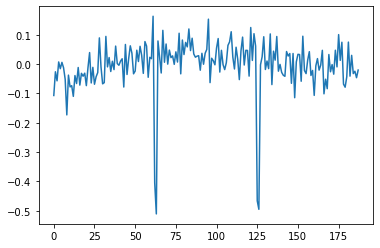

In [65]:
xpoints=range(188)
ypoints=para[2][0].cpu().detach().numpy()
plt.plot(xpoints,ypoints)
plt.show()

In [66]:
para[2][0]

tensor([-1.0716e-01, -2.6373e-02, -5.7248e-02,  7.0663e-03, -1.5747e-02,
         5.7076e-03, -1.2693e-02, -5.2035e-02, -1.7330e-01, -3.7792e-02,
        -7.7970e-02, -7.3716e-02, -1.1014e-01, -3.9278e-02, -6.6432e-02,
        -1.1811e-02, -7.1795e-02, -3.1686e-02, -4.1550e-02, -3.1162e-02,
        -7.3556e-02, -1.2453e-02,  3.9066e-02, -6.4497e-02, -1.1314e-02,
        -6.8900e-02, -4.3336e-02, -2.9147e-02,  8.9061e-02, -9.6577e-03,
        -6.7524e-02, -6.3363e-02,  9.4114e-02, -9.6357e-03,  2.2157e-02,
        -2.5428e-02,  9.4305e-03, -1.9042e-02,  6.1114e-02,  1.5223e-03,
        -4.2304e-03,  9.8260e-03,  1.7993e-02, -7.8348e-02,  6.6617e-02,
        -3.5597e-02,  1.8403e-02,  6.2044e-02,  3.6902e-02, -3.3333e-02,
        -2.3979e-02,  4.7117e-02,  8.5839e-03,  6.0352e-02,  2.9319e-02,
        -3.1807e-02,  7.6524e-02,  6.1135e-02, -4.5147e-02,  2.2888e-02,
         1.8337e-02,  1.6280e-01, -4.0464e-01, -5.1062e-01,  7.8561e-02,
         2.3286e-02, -3.0540e-02,  1.1473e-01,  6.0

In [67]:
para[2][0][62]

tensor(-0.4046, device='cuda:0', grad_fn=<SelectBackward0>)

In [68]:
para[2][0][125]

tensor(-0.4659, device='cuda:0', grad_fn=<SelectBackward0>)

In [69]:
runs_cifar10[0]

{'i': 0,
 'arch': '|avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|',
 'logmeasures': {'synflow': [1.2686003105904548e+16,
   0.0,
   0.0,
   0.0,
   4263677906532854.5,
   0.0,
   0.0,
   0.0,
   4179404740793829.5,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   4163887187678074.5,
   0.0,
   0.0,
   0.0,
   4430217892874988.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   4381552949014535.0,
   0.0,
   0.0,
   0.0,
   4213698143764093.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   4344859253079170.0,
   0.0,
   0.0,
   0.0,
   4291140865680566.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   4229680306490249.0,
   0.0,
   0.0,
   0.0,
   4385965988943797.5,
   0.0,
   0.0,
   0.0,
   0.0,
   1.2942881642305684e+16,
   419795309.93015164,
   4355450593.142634,
   0.0,
   0.0,
   0.0,
   4817216519316228.0,
   0.0,
   0.0,
   0.0,
   4756250513654249.0,
   0.0,
   0.0,
   0.0,
   0.0,
  

In [71]:
from nas_201_api import NASBench201API as API
api = API('../data/NAS-Bench-201-v1_0-e61699.pth')
api.verbose = False
for i, arch_str in enumerate(api): # show every architecturre
    print ('{:5d}/{:5d} : {:}'.format(i, len(api), arch_str))
info = api.query_meta_info_by_index(1) # get metrics of the 1

try to create the NAS-Bench-201 api from ../data/NAS-Bench-201-v1_0-e61699.pth
    0/15625 : |avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|skip_connect~2|
    1/15625 : |nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|skip_connect~2|
    2/15625 : |avg_pool_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|avg_pool_3x3~1|avg_pool_3x3~2|
    3/15625 : |avg_pool_3x3~0|+|skip_connect~0|none~1|+|none~0|none~1|skip_connect~2|
    4/15625 : |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|skip_connect~0|skip_connect~1|nor_conv_1x1~2|
    5/15625 : |nor_conv_1x1~0|+|skip_connect~0|nor_conv_1x1~1|+|nor_conv_3x3~0|none~1|avg_pool_3x3~2|
    6/15625 : |nor_conv_3x3~0|+|none~0|none~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|
    7/15625 : |none~0|+|skip_connect~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|
    8/15625 : |nor_conv_1x1~0|+|avg_pool_3x3~0|skip_connect~1|+|skip_connect~0|none~1|nor_conv_3x

 1434/15625 : |skip_connect~0|+|nor_conv_1x1~0|none~1|+|nor_conv_1x1~0|nor_conv_3x3~1|none~2|
 1435/15625 : |none~0|+|nor_conv_1x1~0|skip_connect~1|+|none~0|none~1|skip_connect~2|
 1436/15625 : |none~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|avg_pool_3x3~2|
 1437/15625 : |none~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|none~1|nor_conv_3x3~2|
 1438/15625 : |nor_conv_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|none~0|nor_conv_3x3~1|nor_conv_3x3~2|
 1439/15625 : |skip_connect~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|
 1440/15625 : |nor_conv_3x3~0|+|none~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|nor_conv_3x3~2|
 1441/15625 : |avg_pool_3x3~0|+|nor_conv_3x3~0|none~1|+|avg_pool_3x3~0|skip_connect~1|avg_pool_3x3~2|
 1442/15625 : |avg_pool_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|skip_connect~1|none~2|
 1443/15625 : |none~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|avg_pool_3x3~1|avg_pool_3x3~2|
 1444/15625 : |nor_c

 2933/15625 : |skip_connect~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|skip_connect~2|
 2934/15625 : |nor_conv_1x1~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|skip_connect~1|nor_conv_3x3~2|
 2935/15625 : |nor_conv_3x3~0|+|none~0|nor_conv_1x1~1|+|skip_connect~0|avg_pool_3x3~1|none~2|
 2936/15625 : |nor_conv_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|none~0|nor_conv_1x1~1|nor_conv_1x1~2|
 2937/15625 : |avg_pool_3x3~0|+|none~0|none~1|+|nor_conv_3x3~0|none~1|none~2|
 2938/15625 : |nor_conv_1x1~0|+|nor_conv_1x1~0|none~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_1x1~2|
 2939/15625 : |none~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|
 2940/15625 : |nor_conv_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|none~1|avg_pool_3x3~2|
 2941/15625 : |nor_conv_3x3~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|nor_conv_3x3~2|
 2942/15625 : |none~0|+|none~0|avg_pool_3x3~1|+|avg_pool_3x3~0|none~1|nor_conv_1x1~2|
 2943/15625 

 4461/15625 : |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|avg_pool_3x3~0|none~1|skip_connect~2|
 4462/15625 : |nor_conv_3x3~0|+|none~0|avg_pool_3x3~1|+|none~0|nor_conv_3x3~1|nor_conv_1x1~2|
 4463/15625 : |nor_conv_3x3~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|none~0|nor_conv_3x3~1|nor_conv_3x3~2|
 4464/15625 : |skip_connect~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_3x3~0|skip_connect~1|avg_pool_3x3~2|
 4465/15625 : |nor_conv_3x3~0|+|none~0|skip_connect~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|
 4466/15625 : |nor_conv_3x3~0|+|skip_connect~0|skip_connect~1|+|avg_pool_3x3~0|avg_pool_3x3~1|avg_pool_3x3~2|
 4467/15625 : |avg_pool_3x3~0|+|none~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|avg_pool_3x3~2|
 4468/15625 : |avg_pool_3x3~0|+|skip_connect~0|nor_conv_3x3~1|+|nor_conv_3x3~0|none~1|skip_connect~2|
 4469/15625 : |none~0|+|none~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|none~2|
 4470/15625 : |skip_connect~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|none~0|none~1|nor_conv_3x3

 6359/15625 : |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|nor_conv_3x3~2|
 6360/15625 : |nor_conv_3x3~0|+|none~0|avg_pool_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|skip_connect~2|
 6361/15625 : |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|
 6362/15625 : |avg_pool_3x3~0|+|skip_connect~0|none~1|+|nor_conv_1x1~0|nor_conv_1x1~1|avg_pool_3x3~2|
 6363/15625 : |none~0|+|none~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|
 6364/15625 : |nor_conv_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|nor_conv_1x1~0|none~1|skip_connect~2|
 6365/15625 : |skip_connect~0|+|avg_pool_3x3~0|none~1|+|skip_connect~0|none~1|nor_conv_1x1~2|
 6366/15625 : |none~0|+|none~0|nor_conv_3x3~1|+|none~0|nor_conv_3x3~1|none~2|
 6367/15625 : |none~0|+|none~0|skip_connect~1|+|nor_conv_3x3~0|none~1|nor_conv_1x1~2|
 6368/15625 : |avg_pool_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_3x3~1|none~2|
 6369/15625 : |avg_pool_3x3~

 8259/15625 : |avg_pool_3x3~0|+|none~0|nor_conv_3x3~1|+|nor_conv_3x3~0|nor_conv_1x1~1|skip_connect~2|
 8260/15625 : |nor_conv_3x3~0|+|none~0|skip_connect~1|+|skip_connect~0|avg_pool_3x3~1|nor_conv_1x1~2|
 8261/15625 : |nor_conv_1x1~0|+|avg_pool_3x3~0|none~1|+|none~0|nor_conv_1x1~1|skip_connect~2|
 8262/15625 : |avg_pool_3x3~0|+|none~0|nor_conv_1x1~1|+|none~0|nor_conv_3x3~1|nor_conv_1x1~2|
 8263/15625 : |nor_conv_3x3~0|+|skip_connect~0|skip_connect~1|+|nor_conv_1x1~0|skip_connect~1|avg_pool_3x3~2|
 8264/15625 : |skip_connect~0|+|skip_connect~0|none~1|+|nor_conv_1x1~0|skip_connect~1|none~2|
 8265/15625 : |avg_pool_3x3~0|+|nor_conv_3x3~0|none~1|+|skip_connect~0|none~1|avg_pool_3x3~2|
 8266/15625 : |nor_conv_3x3~0|+|none~0|skip_connect~1|+|none~0|nor_conv_1x1~1|avg_pool_3x3~2|
 8267/15625 : |none~0|+|skip_connect~0|avg_pool_3x3~1|+|none~0|skip_connect~1|avg_pool_3x3~2|
 8268/15625 : |nor_conv_1x1~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|none~0|avg_pool_3x3~1|none~2|
 8269/15625 : |skip_connect~

10364/15625 : |avg_pool_3x3~0|+|avg_pool_3x3~0|skip_connect~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|
10365/15625 : |avg_pool_3x3~0|+|nor_conv_1x1~0|nor_conv_3x3~1|+|nor_conv_1x1~0|nor_conv_3x3~1|avg_pool_3x3~2|
10366/15625 : |avg_pool_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_1x1~1|nor_conv_1x1~2|
10367/15625 : |none~0|+|none~0|avg_pool_3x3~1|+|avg_pool_3x3~0|skip_connect~1|skip_connect~2|
10368/15625 : |skip_connect~0|+|avg_pool_3x3~0|avg_pool_3x3~1|+|avg_pool_3x3~0|skip_connect~1|none~2|
10369/15625 : |skip_connect~0|+|nor_conv_3x3~0|none~1|+|nor_conv_3x3~0|nor_conv_1x1~1|none~2|
10370/15625 : |nor_conv_3x3~0|+|none~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_3x3~1|skip_connect~2|
10371/15625 : |none~0|+|skip_connect~0|none~1|+|none~0|nor_conv_3x3~1|avg_pool_3x3~2|
10372/15625 : |skip_connect~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_3x3~2|
10373/15625 : |avg_pool_3x3~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_3x3~0|ski

12211/15625 : |skip_connect~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|nor_conv_1x1~1|nor_conv_3x3~2|
12212/15625 : |nor_conv_3x3~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|nor_conv_1x1~0|nor_conv_3x3~1|avg_pool_3x3~2|
12213/15625 : |none~0|+|skip_connect~0|skip_connect~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|
12214/15625 : |none~0|+|skip_connect~0|nor_conv_1x1~1|+|none~0|none~1|nor_conv_3x3~2|
12215/15625 : |none~0|+|skip_connect~0|skip_connect~1|+|nor_conv_3x3~0|nor_conv_1x1~1|avg_pool_3x3~2|
12216/15625 : |nor_conv_3x3~0|+|nor_conv_1x1~0|skip_connect~1|+|none~0|nor_conv_1x1~1|nor_conv_1x1~2|
12217/15625 : |avg_pool_3x3~0|+|nor_conv_3x3~0|skip_connect~1|+|avg_pool_3x3~0|none~1|nor_conv_1x1~2|
12218/15625 : |nor_conv_3x3~0|+|nor_conv_1x1~0|none~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|
12219/15625 : |none~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_3x3~0|avg_pool_3x3~1|nor_conv_1x1~2|
12220/15625 : |nor_conv_1x1~0|+|skip_connect~0|skip_connect~1|+|nor_conv_3x3~0|skip_connec

14430/15625 : |avg_pool_3x3~0|+|none~0|skip_connect~1|+|nor_conv_1x1~0|nor_conv_1x1~1|nor_conv_3x3~2|
14431/15625 : |none~0|+|none~0|avg_pool_3x3~1|+|nor_conv_1x1~0|skip_connect~1|nor_conv_1x1~2|
14432/15625 : |nor_conv_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|nor_conv_1x1~0|nor_conv_1x1~1|skip_connect~2|
14433/15625 : |nor_conv_1x1~0|+|nor_conv_1x1~0|none~1|+|nor_conv_3x3~0|skip_connect~1|skip_connect~2|
14434/15625 : |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|nor_conv_3x3~0|nor_conv_3x3~1|none~2|
14435/15625 : |none~0|+|avg_pool_3x3~0|none~1|+|nor_conv_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|
14436/15625 : |skip_connect~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|skip_connect~0|skip_connect~1|nor_conv_1x1~2|
14437/15625 : |avg_pool_3x3~0|+|none~0|nor_conv_1x1~1|+|none~0|skip_connect~1|skip_connect~2|
14438/15625 : |skip_connect~0|+|avg_pool_3x3~0|none~1|+|nor_conv_3x3~0|nor_conv_1x1~1|avg_pool_3x3~2|
14439/15625 : |nor_conv_1x1~0|+|none~0|none~1|+|none~0|skip_connect~1|nor_conv_1x1~2|
1444

In [72]:
info

ArchResults(arch-index=1, arch=|nor_conv_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|skip_connect~0|nor_conv_3x3~1|skip_connect~2|, 1 runs, clear=True)

# 比较不同数据集上模型的预测得分

In [73]:
torch.set_default_dtype(torch.float64)
class zyt(nn.Module):
    def __init__(self):
        super(zyt,self).__init__()
        self.model1=Sequential(
            nn.LayerNorm(188),
            Linear(188,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            Linear(128,64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
            Linear(64,10),
            nn.ReLU(),
            Linear(10,1),             
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x=self.model1(x)
        return x
zyt1=zyt()
zyt1.load_state_dict(torch.load("../my_model/zyt1_w_BN.pth"))
zyt1=zyt1.cuda()

In [74]:
cifar10_output=zyt1(x_data_cifar10)
cifar100_output=zyt1(x_data_cifar100)
imgnet_output=zyt1(x_data_imgnet)

In [75]:
print(cifar10_output,cifar100_output,imgnet_output)

tensor([[0.8140],
        [0.8928],
        [0.8351],
        ...,
        [0.8867],
        [0.7184],
        [0.8476]], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([[0.8139],
        [0.8934],
        [0.8373],
        ...,
        [0.8865],
        [0.7184],
        [0.8485]], device='cuda:0', grad_fn=<SigmoidBackward0>) tensor([[0.8154],
        [0.8949],
        [0.8439],
        ...,
        [0.8887],
        [0.7183],
        [0.8519]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [76]:
print("模型预测值 spearman")
print("cifar10 vs cifar100:{}".format(abs(stats.spearmanr(cifar10_output.cpu().detach().numpy(),cifar100_output.cpu().detach().numpy(),nan_policy='omit').correlation)))
print("cifar10 vs imgnet:{}".format(abs(stats.spearmanr(cifar10_output.cpu().detach().numpy(),imgnet_output.cpu().detach().numpy(),nan_policy='omit').correlation)))
print("cifar100 vs imgnet:{}".format(abs(stats.spearmanr(cifar100_output.cpu().detach().numpy(),imgnet_output.cpu().detach().numpy(),nan_policy='omit').correlation)))

模型预测值 spearman
cifar10 vs cifar100:0.9956183701654784
cifar10 vs imgnet:0.9880567766147819
cifar100 vs imgnet:0.9877293540624974


In [77]:
print("testacc spearman")
print(abs(stats.spearmanr(y_data_cifar10.cpu().detach().numpy(),y_data_cifar100.cpu().detach().numpy(),nan_policy='omit').correlation))
print(abs(stats.spearmanr(y_data_cifar10.cpu().detach().numpy(),y_data_imgnet.cpu().detach().numpy(),nan_policy='omit').correlation))
print(abs(stats.spearmanr(y_data_cifar100.cpu().detach().numpy(),y_data_imgnet.cpu().detach().numpy(),nan_policy='omit').correlation))

testacc spearman
0.9739899351324866
0.9564843003786774
0.9607774678011815


In [78]:
cifar10_output=torch.reshape(cifar10_output,(len(cifar10_output),))
cifar100_output=torch.reshape(cifar100_output,(len(cifar100_output),))
imgnet_output=torch.reshape(imgnet_output,(len(imgnet_output),))

In [79]:
cifar10_output=cifar10_output.cpu().detach().numpy()
cifar100_output=cifar100_output.cpu().detach().numpy()
imgnet_output=imgnet_output.cpu().detach().numpy()

In [80]:
# cifar10_wo_nan=[]
# cifar100_wo_nan=[]
# imgnet_wo_nan=[]
# for i in range(len(cifar10_output)):
#     if isnan(cifar10_output[i]):
#         continue
#     if isnan(cifar100_output[i]):
#         continue
#     if isnan(imgnet_output[i]):
#         continue
#     cifar10_wo_nan.append(cifar10_output[i].cpu().detach().numpy())
#     cifar100_wo_nan.append(cifar100_output[i].cpu().detach().numpy())
#     imgnet_wo_nan.append(imgnet_output[i].cpu().detach().numpy())

In [81]:
print("模型预测值 pearson")
print("cifar10 vs cifar100:{}".format(stats.pearsonr(cifar10_output,cifar100_output)))
print("cifar10 vs imgnet:{}".format(stats.pearsonr(cifar10_output,imgnet_output)))
print("cifar100 vs imgnet:{}".format(stats.pearsonr(cifar100_output,imgnet_output)))

模型预测值 pearson
cifar10 vs cifar100:(0.999164115398181, 0.0)
cifar10 vs imgnet:(0.9827747868482225, 0.0)
cifar100 vs imgnet:(0.9826246552654695, 0.0)


# 利用模型加速AE

In [54]:
from nas_201_api import NASBench201API as API
api = API('../data/NAS-Bench-201-v1_0-e61699.pth')
api.verbose = False

try to create the NAS-Bench-201 api from ../data/NAS-Bench-201-v1_0-e61699.pth


In [55]:
torch.set_default_dtype(torch.float64)
class zyt(nn.Module):
    def __init__(self):
        super(zyt,self).__init__()
        self.model1=Sequential(
            nn.LayerNorm(188),
            Linear(188,128),
            #nn.BatchNorm1d(128),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            Linear(128,64),
#             nn.BatchNorm1d(64),
            nn.ReLU(),
            Linear(64,10),
            nn.ReLU(),
           #nn.Dropout(p=0.5),
            Linear(10,1),             
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x=self.model1(x)
        return x
zyt1=zyt()
zyt1.load_state_dict(torch.load("../my_model/zyt1_woBN_full.pth"))
zyt1=zyt1.cuda()

In [56]:
fname=r'../myp/CIFAR100_tensors.p'
rname='CIFAR100'
# fname=r'../myp/ImageNet_tensors.p'
# rname='ImageNet16-120'
# fname=r'../myp/tensors.p'
# rname='CIFAR10'
runs_cifar100=[]
f = open(fname,'rb')
while(1):
    try:
        runs_cifar100.append(pickle.load(f))
    except EOFError:
        break
f.close()
print(fname, len(runs_cifar100))
x_data_cifar100=[]
y_data_cifar100=[]
for idx in range(len(runs_cifar100)):
    temp=runs_cifar100[idx]['logmeasures']['synflow']
    temp=torch.tensor(temp,dtype=torch.float64)
    x_data_cifar100.append(temp)
    y_data_cifar100.append(runs_cifar100[idx]['testacc'])
x_data_cifar100=torch.tensor([item.cpu().detach().numpy() for item in x_data_cifar100],dtype=torch.float64).cuda()
y_data_cifar100=torch.tensor(y_data_cifar100,dtype=torch.float64)
y_data_cifar100=y_data_cifar100/100

../myp/CIFAR100_tensors.p 15625


In [57]:
model_proxy_cifar100=zyt1(x_data_cifar100)
model_proxy_cifar100=torch.reshape(model_proxy_cifar100,(len(model_proxy_cifar100),))
model_proxy_cifar100=model_proxy_cifar100.cpu().detach().numpy()

In [58]:
model_proxy_cifar100

array([0.81226126, 0.89083821, 0.83397081, ..., 0.89555149, 0.71035285,
       0.85350013])

In [59]:
synflow_proxy=[]
f = open('../results_release/nasbench2/nb2_cf100_seed42_dlrandom_dlinfo1_initwnone_initbnone.p','rb')
while(1):
    try:
        d = pickle.load(f)
        synflow_proxy.append(d['logmeasures']['synflow'])
    except EOFError:
        break
f.close()

In [60]:
synflow_proxy

[1.873372550841356e+18,
 1.1854389061752024e+34,
 6.757890049935302e+23,
 22431.971707549383,
 7.788033029937863e+21,
 5.540465864685451e+23,
 4.727670007939371e+32,
 2.2472117446187414e+19,
 6.464652148456381e+27,
 23079.440506755025,
 0.0,
 8.0993223653085e+33,
 7.9839998179365335,
 3.6888164637427165e+20,
 4.1801702629376287e+18,
 307145694842.51733,
 2.4189718098849493e+33,
 6.144108619730829e+22,
 2.2182263706953013e+28,
 2.2555943219239416e+19,
 2.159212672122717e+19,
 2.4111451227595546e+26,
 1.3311216437771452e+21,
 1.0238733367211652e+26,
 1575495791807680.8,
 23645.416079718725,
 3.3995741131218424e+23,
 2.4294910382601076e+16,
 1.7156908692016612e+18,
 2.1333042584625754e+19,
 4.1731031229503073e+18,
 1.3632216765884785e+21,
 6.710962321561027e+27,
 1.1526618808815096e+27,
 3.611913214145754e+20,
 3.516001482903243e+20,
 2.5391697019523253e+28,
 2.1381255605727117e+17,
 4.74306660575725e+34,
 2.6526061784150954e+17,
 29629.178443282228,
 585320314500.1691,
 4.380222458426525

In [9]:
# testy_cifar100

In [61]:
stats.spearmanr(model_proxy_cifar100,testy_cifar100.cpu().detach().numpy(),nan_policy='omit').correlation

0.8980423820209321

In [62]:
print(stats.pearsonr(model_proxy_cifar100,testy_cifar100.cpu().detach().numpy()))

(array([0.9198334284219674], dtype=object), 0.0)


In [11]:
_opname_to_index = {
    'none': 0,
    'skip_connect': 1,
    'nor_conv_1x1': 2,
    'nor_conv_3x3': 3,
    'avg_pool_3x3': 4
}

def get_spec_from_arch_str(arch_str):
    nodes = arch_str.split('+')
    nodes = [node[1:-1].split('|') for node in nodes]
    nodes = [[op_and_input.split('~')[0]  for op_and_input in node] for node in nodes]

    spec = [_opname_to_index[op] for node in nodes for op in node]
    return spec

idx_to_spec = {}
for i, arch_str in enumerate(api):
    idx_to_spec[i] = get_spec_from_arch_str(arch_str)

spec_to_idx = {}
for idx,spec in idx_to_spec.items():
    spec_to_idx[str(spec)] = idx

In [12]:
sorted(model_proxy_cifar100,reverse=True)

[0.9066561698336837,
 0.9064343949650945,
 0.9056299205330258,
 0.904172191522873,
 0.9041104413041762,
 0.903478451451883,
 0.9030502961332157,
 0.902886825435794,
 0.9028516387311041,
 0.9028469383412131,
 0.9027062395507055,
 0.9026669839849175,
 0.9026557612206821,
 0.9021848327971608,
 0.9021827754251512,
 0.9021156135678047,
 0.901987389826735,
 0.9019027483112082,
 0.9018948821269166,
 0.9018921402481452,
 0.9016458460843652,
 0.9016286068095982,
 0.901605257269191,
 0.9015633284464829,
 0.9015585552564828,
 0.9014576636652938,
 0.9013586278905316,
 0.9013514260455333,
 0.9012371659904933,
 0.9011933077231175,
 0.9011455210973869,
 0.9010764294887864,
 0.9010662373766009,
 0.9010540357621315,
 0.9010327978657704,
 0.9010080224935636,
 0.9009990814028861,
 0.9009812889595805,
 0.9008332760829731,
 0.9007894454298557,
 0.9007318446345055,
 0.900711513566911,
 0.9006445229509142,
 0.900604147842872,
 0.9005681500087543,
 0.9004936881178167,
 0.9004031964499727,
 0.900401985770034,


In [13]:
import random
import copy
random.seed = 42
def random_spec():
    return random.choice(list(idx_to_spec.values()))

def mutate_spec(old_spec):
    idx_to_change = random.randrange(len(old_spec))
    entry_to_change = old_spec[idx_to_change]
    possible_entries = [x for x in range(5) if x != entry_to_change]
    new_entry = random.choice(possible_entries)
    new_spec = copy.copy(old_spec)
    new_spec[idx_to_change] = new_entry
    return new_spec

def mutate_spec_zero_cost(old_spec,proxy):
    possible_specs = []
    #idx_to_change：mutate的位置
    #possible_entries 可以变异成的cell（5个架构减去原本）
    #new_entry 新cell
    #new_spec 新架构
    #possible_specs 可以变异成的架构
    
    for idx_to_change in range(len(old_spec)): 
        entry_to_change = old_spec[idx_to_change]
        possible_entries = [x for x in range(5) if x != entry_to_change]
        for new_entry in possible_entries:
            new_spec = copy.copy(old_spec)
            new_spec[idx_to_change] = new_entry
            possible_specs.append((proxy[spec_to_idx[str(new_spec)]], new_spec))
    #得分最高的可能架构
    best_new_spec = sorted(possible_specs, key=lambda i:i[0])[-1][1]
    #25%几率随机变异
    if random.random() > 0.75:
        best_new_spec = random.choice(possible_specs)[1]
    return best_new_spec

In [14]:
spec_to_idx[str(random.choice(list(idx_to_spec.values())))]

15177

In [15]:
#tounament selection中的随机采样
def random_combination(iterable, sample_size):
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), sample_size))
    return tuple(pool[i] for i in indices)

In [16]:
def run_evolution_search(max_trained_models=1000, 
                         pool_size=64, 
                         tournament_size=10, 
                         zero_cost_warmup=0, 
                         zero_cost_move=False,
                         proxy=model_proxy_cifar100):
    
    best_valids, best_tests = [0.0], [0.0]
    pool = []   # (validation, spec) tuples
    num_trained_models = 0

    # fill the initial pool
    if zero_cost_warmup > 0:
        zero_cost_pool = []
        for _ in range(zero_cost_warmup):
            spec = random_spec()
            spec_idx = spec_to_idx[str(spec)]
            zero_cost_pool.append((proxy[spec_idx], spec))
            zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)
    for i in range(pool_size):
        if zero_cost_warmup > 0:
            spec = zero_cost_pool[i][1]
        else:
            spec = random_spec()
        info = api.get_more_info(spec_to_idx[str(spec)], 'cifar100', iepoch=None, hp='200', is_random=False)
        num_trained_models += 1
        pool.append((info['valid-accuracy'], spec))

        if info['valid-accuracy'] > best_valids[-1]:
            best_valids.append(info['valid-accuracy'])
        else:
            best_valids.append(best_valids[-1])
            
        if info['test-accuracy'] > best_tests[-1]:
            best_tests.append(info['test-accuracy'])
        else:
            best_tests.append(best_tests[-1])

    # After the pool is seeded, proceed with evolving the population.
    while(1):
        #tournament selection
        sample = random_combination(pool, tournament_size)
        best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
        if zero_cost_move:
            new_spec = mutate_spec_zero_cost(best_spec,proxy=proxy)
        else:
            new_spec = mutate_spec(best_spec)

        info = api.get_more_info(spec_to_idx[str(new_spec)], 'cifar100', iepoch=None, hp='200', is_random=False)
        num_trained_models += 1

        # kill the oldest individual in the population.
        pool.append((info['valid-accuracy'], new_spec))
        pool.pop(0)

        if info['valid-accuracy'] > best_valids[-1]:
            best_valids.append(info['valid-accuracy'])
        else:
            best_valids.append(best_valids[-1])
            
        if info['test-accuracy'] > best_tests[-1]:
            best_tests.append(info['test-accuracy'])
        else:
            best_tests.append(best_tests[-1])

        if num_trained_models >= max_trained_models:
            break
    best_tests.pop(0)
    best_valids.pop(0)
#     if zero_cost_warmup ==1000:
#         return best_valids, best_tests,zero_cost_pool
#     else:
    return best_valids, best_tests

In [17]:
def run_random_search(max_trained_models=1000, 
                      zero_cost_warmup=0,
                      proxy=model_proxy_cifar100):
    
    best_valids, best_tests = [0.0], [0.0]
    pool = []   # (validation, spec) tuples
    num_trained_models = 0

    # fill the initial pool
    if zero_cost_warmup > 0:
        zero_cost_pool = []
        for _ in range(zero_cost_warmup):
            spec = random_spec()
            spec_idx = spec_to_idx[str(spec)]
            zero_cost_pool.append((proxy[spec_idx], spec))
            zero_cost_pool = sorted(zero_cost_pool, key=lambda i:i[0], reverse=True)
    for i in range(max_trained_models):
        if i < zero_cost_warmup:
            spec = zero_cost_pool[i][1]
        else:
            spec = random_spec()
        info = api.get_more_info(spec_to_idx[str(spec)], 'cifar100', iepoch=None, hp='200', is_random=False)

        if info['valid-accuracy'] > best_valids[-1]:
            best_valids.append(info['valid-accuracy'])
        else:
            best_valids.append(best_valids[-1])
            
        if info['test-accuracy'] > best_tests[-1]:
            best_tests.append(info['test-accuracy'])
        else:
            best_tests.append(best_tests[-1])
            
    best_tests.pop(0)
    best_valids.pop(0)
    return best_valids, best_tests

In [18]:
from tqdm import tqdm
num_rounds = 10
length = 300
ae, ae_warmup_synflow1000, ae_warmup_model1000, ae_warmup_synflow, ae_warmup_model, ae_warmup_synflow15625, ae_warmup_model15625, ae_move_synflow, ae_move_model,rand, rand_warmup_synflow, rand_warmup_model, rand_warmup_synflow1000, rand_warmup_model1000,rand_warmup_synflow15625, rand_warmup_model15625 = [], [], [], [], [], [], [], [], [], [], [], [], [],[],[],[]
for _ in tqdm(range(num_rounds)):
    ae_best_valids, ae_best_tests = run_evolution_search(max_trained_models=length)
    ae.append(ae_best_tests)

    ae_warmup_best_valids_synflow1000, ae_warmup_best_tests_synflow1000 = run_evolution_search(max_trained_models=length, zero_cost_warmup=1000,proxy=synflow_proxy)
    ae_warmup_synflow1000.append(ae_warmup_best_tests_synflow1000)

    ae_warmup_best_valids_model1000, ae_warmup_best_tests_model1000 = run_evolution_search(max_trained_models=length, zero_cost_warmup=1000,proxy=model_proxy_cifar100)
    ae_warmup_model1000.append(ae_warmup_best_tests_model1000)

    ae_warmup_best_valids_synflow, ae_warmup_best_tests_synflow = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000,proxy=synflow_proxy)
    ae_warmup_synflow.append(ae_warmup_best_tests_synflow)

    ae_warmup_best_valids_model, ae_warmup_best_tests_model = run_evolution_search(max_trained_models=length, zero_cost_warmup=3000,proxy=model_proxy_cifar100)
    ae_warmup_model.append(ae_warmup_best_tests_model)

    ae_warmup_best_valids_synflow15625, ae_warmup_best_tests_synflow15625 = run_evolution_search(max_trained_models=length, zero_cost_warmup=15625,proxy=synflow_proxy)
    ae_warmup_synflow15625.append(ae_warmup_best_tests_synflow15625)

    ae_warmup_best_valids_model15625, ae_warmup_best_tests_model15625 = run_evolution_search(max_trained_models=length, zero_cost_warmup=15625,proxy=model_proxy_cifar100)
    ae_warmup_model15625.append(ae_warmup_best_tests_model15625)

    ae_move_best_valids_synflow, ae_move_best_tests_synflow = run_evolution_search(max_trained_models=length, zero_cost_move=True,proxy=synflow_proxy)
    ae_move_synflow.append(ae_move_best_tests_synflow)

    ae_move_best_valids_model, ae_move_best_tests_model = run_evolution_search(max_trained_models=length, zero_cost_move=True,proxy=model_proxy_cifar100)
    ae_move_model.append(ae_move_best_tests_model)

    rand_best_valids, rand_best_tests = run_random_search(max_trained_models=length,proxy=model_proxy_cifar100)
    rand.append(rand_best_tests)

    rand_warmup_best_valids_synflow1000, rand_warmup_best_tests_synflow1000 = run_random_search(max_trained_models=length, zero_cost_warmup=1000,proxy=synflow_proxy)
    rand_warmup_synflow1000.append(rand_warmup_best_tests_synflow1000)

    rand_warmup_best_valids_model1000, rand_warmup_best_tests_model1000 = run_random_search(max_trained_models=length, zero_cost_warmup=1000,proxy=model_proxy_cifar100)
    rand_warmup_model1000.append(rand_warmup_best_tests_model1000)

    rand_warmup_best_valids_synflow, rand_warmup_best_tests_synflow = run_random_search(max_trained_models=length, zero_cost_warmup=3000,proxy=synflow_proxy)
    rand_warmup_synflow.append(rand_warmup_best_tests_synflow)

    rand_warmup_best_valids_model, rand_warmup_best_tests_model = run_random_search(max_trained_models=length, zero_cost_warmup=3000,proxy=model_proxy_cifar100)
    rand_warmup_model.append(rand_warmup_best_tests_model)

    rand_warmup_best_valids_synflow15625, rand_warmup_best_tests_synflow15625 = run_random_search(max_trained_models=length, zero_cost_warmup=15625,proxy=synflow_proxy)
    rand_warmup_synflow15625.append(rand_warmup_best_tests_synflow15625)

    rand_warmup_best_valids_model15625, rand_warmup_best_tests_model15625 = run_random_search(max_trained_models=length, zero_cost_warmup=15625,proxy=model_proxy_cifar100)
    rand_warmup_model15625.append(rand_warmup_best_tests_model15625)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:30<00:00, 69.07s/it]


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_experiment(exp_list, title):
    def plot_exp(exp, label):
        exp = np.array(exp) 
        q_75 = np.quantile(exp, .75, axis=0)
        q_25 = np.quantile(exp, .25, axis=0)
        mean = np.mean(exp, axis=0)
        plt.plot(mean, label=label)
        plt.fill_between(range(len(q_25)), q_25, q_75, alpha=0.1)
    for exp,ename in exp_list:
        plot_exp(exp,ename)
    plt.grid()
    plt.xlabel('Trained Models')
    plt.ylabel('Test Accuracy')
    plt.ylim(70,73.6)
    plt.legend()
    plt.title(title)
    plt.show()

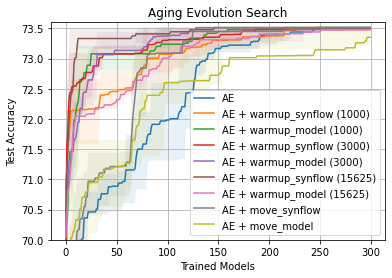

In [20]:
plot_experiment([(ae,'AE'), (ae_warmup_synflow1000,'AE + warmup_synflow (1000)'),(ae_warmup_model1000,'AE + warmup_model (1000)'),
                 (ae_warmup_synflow,'AE + warmup_synflow (3000)'),(ae_warmup_model,'AE + warmup_model (3000)'),
                 (ae_warmup_synflow15625,'AE + warmup_synflow (15625)'),(ae_warmup_model15625,'AE + warmup_model (15625)'),
                 (ae_move_synflow,'AE + move_synflow'),(ae_move_model,'AE + move_model')], 'Aging Evolution Search')

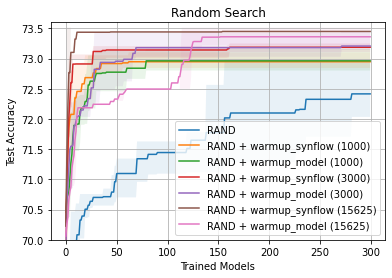

In [21]:
plot_experiment([(rand,'RAND'), 
                 (rand_warmup_synflow1000,'RAND + warmup_synflow (1000)'),(rand_warmup_model1000,'RAND + warmup_model (1000)'),
                (rand_warmup_synflow,'RAND + warmup_synflow (3000)'),(rand_warmup_model,'RAND + warmup_model (3000)'),
                (rand_warmup_synflow15625,'RAND + warmup_synflow (15625)'),(rand_warmup_model15625,'RAND + warmup_model (15625)'),], 
                'Random Search')

# spearman系数高，效果却不好的原因

In [63]:
y_data_cifar100=np.array(y_data_cifar100)
synflow_proxy=np.array(synflow_proxy)

In [64]:
index1 = np.argsort(model_proxy_cifar100)
index2 = np.argsort(synflow_proxy)
index3=np.argsort(y_data_cifar100)
index1=index1[::-1]
index2=index2[::-1]
index3=index3[::-1]

In [65]:
model_proxy_cifar100[index1]

array([0.90665617, 0.90643439, 0.90562992, ..., 0.09925171, 0.09880072,
       0.09875721])

In [66]:
sum1=0
cnt1=0
for i in index1:
    sum1+=y_data_cifar100[i]
#     print(y_data_cifar100[i])
    cnt1+=1
    if cnt1==6000:
        break
print(sum1)

4096.180998363794


In [67]:
sum2=0
cnt2=0
for i in index2:
#     print(y_data_cifar100[i])
    sum2+=y_data_cifar100[i]
    cnt2+=1
    if cnt2==6000:
        break
print(sum2)

4057.5501651047416


In [73]:
sum3=0
cnt=0
for i in index3:
    cnt+=1
    synflow_rank_dif=abs(15625-np.searchsorted(sorted(synflow_proxy),synflow_proxy[i])-cnt)
    model_rank_dif=abs(15625-np.searchsorted(sorted(model_proxy_cifar100),model_proxy_cifar100[i])-cnt)                
    print("synflow:{}".format(synflow_rank_dif))
    print("model:{}".format(model_rank_dif))
    sum3+=model_rank_dif-synflow_rank_dif
    if(cnt==156):
        break
print(sum3)

synflow:2
model:114
synflow:759
model:1424
synflow:141
model:127
synflow:9
model:137
synflow:173
model:114
synflow:41
model:463
synflow:8
model:159
synflow:224
model:227
synflow:474
model:425
synflow:22
model:321
synflow:223
model:370
synflow:770
model:314
synflow:465
model:451
synflow:519
model:316
synflow:1183
model:280
synflow:160
model:345
synflow:1843
model:896
synflow:57
model:816
synflow:111
model:278
synflow:16
model:304
synflow:1184
model:313
synflow:761
model:378
synflow:307
model:559
synflow:121
model:29
synflow:494
model:37
synflow:896
model:2157
synflow:688
model:46
synflow:739
model:54
synflow:500
model:227
synflow:2074
model:702
synflow:249
model:635
synflow:249
model:176
synflow:105
model:24
synflow:108
model:152
synflow:167
model:1088
synflow:2857
model:1035
synflow:3
model:169
synflow:482
model:414
synflow:572
model:2069
synflow:1195
model:3
synflow:1202
model:101
synflow:522
model:128
synflow:174
model:276
synflow:488
model:300
synflow:265
model:409
synflow:113
model

In [74]:
sum3=0
cnt=0
for i in index3:
    cnt+=1
    synflow_rank_dif=abs(15625-np.searchsorted(sorted(synflow_proxy),synflow_proxy[i])-cnt)
    model_rank_dif=abs(15625-np.searchsorted(sorted(model_proxy_cifar100),model_proxy_cifar100[i])-cnt)                
    print("synflow:{}".format(synflow_rank_dif))
    print("model:{}".format(model_rank_dif))
    sum3+=model_rank_dif-synflow_rank_dif
    if(cnt==1562):
        break
print(sum3)

synflow:2
model:114
synflow:759
model:1424
synflow:141
model:127
synflow:9
model:137
synflow:173
model:114
synflow:41
model:463
synflow:8
model:159
synflow:224
model:227
synflow:474
model:425
synflow:22
model:321
synflow:223
model:370
synflow:770
model:314
synflow:465
model:451
synflow:519
model:316
synflow:1183
model:280
synflow:160
model:345
synflow:1843
model:896
synflow:57
model:816
synflow:111
model:278
synflow:16
model:304
synflow:1184
model:313
synflow:761
model:378
synflow:307
model:559
synflow:121
model:29
synflow:494
model:37
synflow:896
model:2157
synflow:688
model:46
synflow:739
model:54
synflow:500
model:227
synflow:2074
model:702
synflow:249
model:635
synflow:249
model:176
synflow:105
model:24
synflow:108
model:152
synflow:167
model:1088
synflow:2857
model:1035
synflow:3
model:169
synflow:482
model:414
synflow:572
model:2069
synflow:1195
model:3
synflow:1202
model:101
synflow:522
model:128
synflow:174
model:276
synflow:488
model:300
synflow:265
model:409
synflow:113
model

synflow:4054
model:860
synflow:1029
model:3288
synflow:2281
model:337
synflow:1233
model:4280
synflow:333
model:1700
synflow:574
model:1002
synflow:517
model:996
synflow:220
model:1037
synflow:1272
model:231
synflow:617
model:417
synflow:2243
model:1433
synflow:4866
model:2879
synflow:1763
model:1387
synflow:137
model:230
synflow:461
model:415
synflow:855
model:655
synflow:1338
model:2582
synflow:687
model:3579
synflow:1373
model:149
synflow:860
model:130
synflow:461
model:204
synflow:258
model:240
synflow:3292
model:339
synflow:273
model:296
synflow:2187
model:1560
synflow:1797
model:537
synflow:11
model:1004
synflow:868
model:5170
synflow:1302
model:341
synflow:33
model:342
synflow:164
model:32
synflow:370
model:190
synflow:2209
model:2892
synflow:402
model:264
synflow:956
model:1163
synflow:19
model:885
synflow:933
model:1144
synflow:600
model:259
synflow:788
model:5465
synflow:1952
model:2124
synflow:1045
model:442
synflow:1983
model:2164
synflow:149
model:66
synflow:1943
model:223

synflow:4451
model:1491
synflow:1888
model:160
synflow:3974
model:885
synflow:1308
model:68
synflow:1197
model:3046
synflow:1442
model:1404
synflow:4361
model:2520
synflow:1228
model:228
synflow:679
model:95
synflow:136
model:365
synflow:1926
model:2658
synflow:213
model:1246
synflow:2356
model:3367
synflow:2442
model:419
synflow:684
model:594
synflow:418
model:198
synflow:1538
model:1872
synflow:904
model:454
synflow:85
model:2793
synflow:673
model:374
synflow:974
model:193
synflow:2647
model:3888
synflow:3209
model:2637
synflow:824
model:782
synflow:700
model:263
synflow:1628
model:1833
synflow:226
model:588
synflow:4654
model:9147
synflow:822
model:4115
synflow:330
model:1982
synflow:169
model:808
synflow:1980
model:769
synflow:2056
model:274
synflow:418
model:969
synflow:1622
model:5365
synflow:218
model:570
synflow:716
model:46
synflow:2410
model:507
synflow:1232
model:193
synflow:3103
model:14
synflow:2936
model:108
synflow:865
model:3888
synflow:1707
model:31
synflow:194
model:4

synflow:392
model:892
synflow:1385
model:1115
synflow:4126
model:1188
synflow:710
model:4891
synflow:848
model:1034
synflow:4054
model:6533
synflow:530
model:911
synflow:900
model:1223
synflow:293
model:725
synflow:389
model:867
synflow:3753
model:110
synflow:562
model:3245
synflow:1500
model:408
synflow:839
model:155
synflow:4140
model:1101
synflow:2091
model:586
synflow:2910
model:2551
synflow:1438
model:4719
synflow:1119
model:947
synflow:1718
model:932
synflow:1537
model:849
synflow:1018
model:1635
synflow:2368
model:2824
synflow:431
model:1078
synflow:1240
model:1392
synflow:4899
model:4173
synflow:2869
model:8172
synflow:1868
model:335
synflow:3113
model:373
synflow:815
model:611
synflow:754
model:303
synflow:559
model:3040
synflow:906
model:398
synflow:4000
model:1151
synflow:777
model:611
synflow:1328
model:1138
synflow:813
model:120
synflow:366
model:396
synflow:832
model:594
synflow:913
model:496
synflow:945
model:4129
synflow:3407
model:1310
synflow:4083
model:2009
synflow:3

synflow:3723
model:3994
synflow:3674
model:227
synflow:281
model:3440
synflow:2622
model:488
synflow:644
model:433
synflow:2073
model:1577
synflow:2070
model:1562
synflow:978
model:213
synflow:1094
model:846
synflow:612
model:608
synflow:288
model:782
synflow:3580
model:4060
synflow:72
model:4461
synflow:85
model:737
synflow:609
model:19
synflow:427
model:1165
synflow:90
model:1050
synflow:2451
model:1506
synflow:3888
model:3949
synflow:436
model:540
synflow:1386
model:645
synflow:43
model:1719
-27970


In [35]:
synflow_proxy_top10=[]
model_proxy_cifar100_top10=[]
cnt=0
for i in index3[::-1]:
    cnt+=1
    synflow_proxy_top10.append(synflow_proxy[i])
    model_proxy_cifar100_top10.append(model_proxy_cifar100[i])
    if cnt>1562:
        break

In [37]:
len(synflow_proxy_top10)

1563

In [39]:
index3=index3[::-1]

In [41]:
stats.spearmanr(synflow_proxy_top10,y_data_cifar100[index3[:1563]],nan_policy='omit').correlation

0.4208848991678316

In [49]:
stats.spearmanr(model_proxy_cifar100_top10,y_data_cifar100[index3[:1563]],nan_policy='omit').correlation

0.23332183996416325

# GNN

In [17]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv,Sequential,LayerNorm
from torch.nn import Linear, ReLU
import torch_geometric.transforms as T

In [18]:
trainy_cifar10=torch.reshape(trainy_cifar10,(len(trainy_cifar10),))

In [19]:
pos=[[i] for i in range(len(trainx_cifar10))]

In [20]:
pos=torch.tensor(pos)

In [21]:
data=Data(x=trainx_cifar10,y=trainy_cifar10,pos=pos)

In [22]:
data

Data(x=[12500, 188], y=[12500], pos=[12500, 1])

In [23]:
data.x

tensor([[1.2686e+16, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         1.2943e+16],
        [3.3874e+31, 2.8923e+31, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.3995e+31],
        [4.1304e+21, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         4.1394e+21],
        ...,
        [3.4700e+09, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 9.6354e+00,
         4.1140e+09],
        [3.4783e+11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.5593e+11],
        [3.1650e+11, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.2391e+11]], device='cuda:0')

In [24]:
tansform=T.KNNGraph(k=5)
data=tansform(data)

In [25]:
data

Data(x=[12500, 188], y=[12500], pos=[12500, 1], edge_index=[2, 62500])

In [26]:
testy_cifar10=torch.reshape(testy_cifar10,(len(testy_cifar10),))

In [27]:
pos=[[i] for i in range(len(testx_cifar10))]

In [28]:
pos=torch.tensor(pos)
testdata=Data(x=testx_cifar10,y=testy_cifar10,pos=pos)

In [29]:
testdata

Data(x=[3125, 188], y=[3125], pos=[3125, 1])

In [30]:
testdata=tansform(testdata)

In [31]:
data.cuda()
testdata.cuda()

Data(x=[3125, 188], y=[3125], pos=[3125, 1], edge_index=[2, 15625])

In [32]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN,self).__init__()
        self.conv1 = GCNConv(data.num_node_features, 16)
        self.conv2 = GCNConv(16, 10)
        self.layernorm1=LayerNorm(data.num_node_features)
        self.linear1=Linear(10,1)
        self.sigmoid=nn.Sigmoid()
    def forward(self,data):
        x,edge_index=data.x,data.edge_index
        x=self.layernorm1(x)
        x=F.relu(self.conv1(x,edge_index))
        x=F.dropout(x,training=self.training)
        x=F.relu(self.conv2(x,edge_index))
        x=F.dropout(x,training=self.training)
        x=self.linear1(x)
        x=self.sigmoid(x)
        return x
GNN1=GNN()
GNN1=GNN1.cuda()

In [33]:
# loss_fn=torch.nn.MSELoss()#SpearmanLossFunc()
loss_fn=torch.nn.MSELoss()
loss_fn=loss_fn.cuda()
#优化器
learning_rate=0.001
optimizer=torch.optim.Adam(GNN1.parameters(),lr=learning_rate)
#训练的轮数
epoch=5000

In [34]:
maxspear=0
for i in range(epoch):
    GNN1.train()
    print("------第{}轮训练开始-------".format(i+1))
#     start_time=time.time()
    output=GNN1(data)
    print(output)
    curspear=abs(stats.spearmanr(output.cpu().detach().numpy(),trainy_cifar10.cpu().detach().numpy(),nan_policy='omit').correlation)
    print(curspear)
    if (curspear>maxspear):
        maxspear=curspear
        maxepoch=i
    loss=loss_fn(output,trainy_cifar10)
    #优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()                
    print("train_loss:{}".format(loss.item()))
#     end_time=time.time()
#     print("time_cost:{}".format(end_time-start_time))
    #测试步骤开始
    GNN1.eval() #让网络进入测试状态
    #no_grad()保证不影响梯度，不会进行调优
    with torch.no_grad():
        test_output=GNN1(testdata)
        test_loss=loss_fn(test_output,testy_cifar10)
        print("test_loss:{}".format(test_loss.item()))

------第1轮训练开始-------
tensor([[0.5519],
        [0.5527],
        [0.5519],
        ...,
        [0.5524],
        [0.5524],
        [0.5530]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008020720603773672


F:\anaconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([12500])) that is different to the input size (torch.Size([12500, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


train_loss:0.09727410779951269
test_loss:0.09432161997133647
------第2轮训练开始-------
tensor([[0.5528],
        [0.5542],
        [0.5539],
        ...,
        [0.5517],
        [0.5541],
        [0.5531]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003973194735500247
train_loss:0.0954292616898026
test_loss:0.09326078052908161
------第3轮训练开始-------
tensor([[0.5523],
        [0.5546],
        [0.5554],
        ...,
        [0.5533],
        [0.5519],
        [0.5565]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001587925353672186
train_loss:0.09447560576790401
test_loss:0.09272378642222119
------第4轮训练开始-------
tensor([[0.5534],
        [0.5556],
        [0.5556],
        ...,
        [0.5530],
        [0.5530],
        [0.5542]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003965822949731997
train_loss:0.09334860582722793
test_loss:0.09223417380710523
------第5轮训练开始-------


F:\anaconda\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([3125])) that is different to the input size (torch.Size([3125, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[0.5537],
        [0.5554],
        [0.5552],
        ...,
        [0.5546],
        [0.5546],
        [0.5536]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006725584993316118
train_loss:0.09304776479021012
test_loss:0.09171178971115453
------第6轮训练开始-------
tensor([[0.5582],
        [0.5522],
        [0.5537],
        ...,
        [0.5551],
        [0.5554],
        [0.5551]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004627011376817185
train_loss:0.09253381234886868
test_loss:0.09126144890998257
------第7轮训练开始-------
tensor([[0.5541],
        [0.5542],
        [0.5555],
        ...,
        [0.5599],
        [0.5601],
        [0.5599]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012532563931843774
train_loss:0.09161163937473114
test_loss:0.09080882388601827
------第8轮训练开始-------
tensor([[0.5598],
        [0.5642],
        [0.5499],
        ...,
        [0.5608],
        [0.5583],
        [0.5576]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004994586209396137
tr

test_loss:0.06736770747945695
------第41轮训练开始-------
tensor([[0.5623],
        [0.5677],
        [0.6133],
        ...,
        [0.5810],
        [0.5375],
        [0.6058]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015551201652509767
train_loss:0.06831011513239027
test_loss:0.06614304797237516
------第42轮训练开始-------
tensor([[0.6554],
        [0.6014],
        [0.6043],
        ...,
        [0.6022],
        [0.6020],
        [0.6010]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008835289143370503
train_loss:0.06722934289818755
test_loss:0.06487952558552586
------第43轮训练开始-------
tensor([[0.5979],
        [0.5542],
        [0.6062],
        ...,
        [0.5579],
        [0.6441],
        [0.6554]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009974606156847372
train_loss:0.0661810853300772
test_loss:0.06352978870027695
------第44轮训练开始-------
tensor([[0.6532],
        [0.5558],
        [0.6288],
        ...,
        [0.6397],
        [0.6952],
        [0.5525]], device='cuda:0

test_loss:0.02099744452239138
------第76轮训练开始-------
tensor([[0.6222],
        [0.8773],
        [0.7933],
        ...,
        [0.8165],
        [0.8217],
        [0.6375]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006860219413327546
train_loss:0.033299147822785896
test_loss:0.020369736812799584
------第77轮训练开始-------
tensor([[0.8799],
        [0.8688],
        [0.8193],
        ...,
        [0.8097],
        [0.7533],
        [0.7533]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.022611463866955315
train_loss:0.032428648583934676
test_loss:0.019821240329687417
------第78轮训练开始-------
tensor([[0.9135],
        [0.6247],
        [0.8190],
        ...,
        [0.9216],
        [0.9207],
        [0.9394]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011988884256997134
train_loss:0.03230382563251581
test_loss:0.01934821707947477
------第79轮训练开始-------
tensor([[0.6661],
        [0.9151],
        [0.9146],
        ...,
        [0.6497],
        [0.9171],
        [0.8046]], device='c

test_loss:0.017808186061014353
------第112轮训练开始-------
tensor([[0.5912],
        [0.9296],
        [0.7925],
        ...,
        [0.9507],
        [0.8719],
        [0.8138]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008957513038980475
train_loss:0.0280087792372804
test_loss:0.01777786960495382
------第113轮训练开始-------
tensor([[0.7608],
        [0.9109],
        [0.9233],
        ...,
        [0.9795],
        [0.8175],
        [0.9335]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001029231141579772
train_loss:0.0282097349279545
test_loss:0.01774615811194064
------第114轮训练开始-------
tensor([[0.9201],
        [0.8102],
        [0.5716],
        ...,
        [0.7991],
        [0.7790],
        [0.7988]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007593185432783079
train_loss:0.027535552040414323
test_loss:0.01771352833205948
------第115轮训练开始-------
tensor([[0.9177],
        [0.8506],
        [0.8355],
        ...,
        [0.7149],
        [0.7780],
        [0.7780]], device='c

tensor([[0.9210],
        [0.8777],
        [0.7673],
        ...,
        [0.8242],
        [0.8886],
        [0.7981]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0020644551630706934
train_loss:0.026180549327762714
test_loss:0.01730100760594622
------第143轮训练开始-------
tensor([[0.9525],
        [0.7713],
        [0.8982],
        ...,
        [0.8244],
        [0.7037],
        [0.8110]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0030963275829276027
train_loss:0.025781230361665037
test_loss:0.01729992070510258
------第144轮训练开始-------
tensor([[0.8133],
        [0.5730],
        [0.6965],
        ...,
        [0.8972],
        [0.6505],
        [0.9292]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01231702196830489
train_loss:0.025826540265404745
test_loss:0.017299256742104006
------第145轮训练开始-------
tensor([[0.8996],
        [0.9765],
        [0.9326],
        ...,
        [0.8689],
        [0.8495],
        [0.7696]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0054697330

test_loss:0.017273346266163954
------第178轮训练开始-------
tensor([[0.7989],
        [0.8512],
        [0.7337],
        ...,
        [0.7670],
        [0.7285],
        [0.7638]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01697383347490467
train_loss:0.024972170473866274
test_loss:0.017271090115422466
------第179轮训练开始-------
tensor([[0.8386],
        [0.7661],
        [0.8058],
        ...,
        [0.5748],
        [0.8260],
        [0.9168]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0011788519338014273
train_loss:0.0249065675903781
test_loss:0.017268713158724663
------第180轮训练开始-------
tensor([[0.9238],
        [0.9613],
        [0.8860],
        ...,
        [0.8295],
        [0.9460],
        [0.9428]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0031342146004241676
train_loss:0.024549176748659803
test_loss:0.017266268007423192
------第181轮训练开始-------
tensor([[0.8417],
        [0.7893],
        [0.6571],
        ...,
        [0.8877],
        [0.8063],
        [0.7835]], dev

tensor([[0.7376],
        [0.6348],
        [0.7777],
        ...,
        [0.7935],
        [0.8767],
        [0.8846]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.014237770789128646
train_loss:0.024286722092429266
test_loss:0.017246005638445028
------第209轮训练开始-------
tensor([[0.8365],
        [0.8822],
        [0.9116],
        ...,
        [0.7922],
        [0.9166],
        [0.8354]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006170703479317858
train_loss:0.02453210809621366
test_loss:0.0172461484588956
------第210轮训练开始-------
tensor([[0.9528],
        [0.7898],
        [0.9135],
        ...,
        [0.6941],
        [0.7834],
        [0.7921]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008410980501189396
train_loss:0.02442091984706268
test_loss:0.017246484348933316
------第211轮训练开始-------
tensor([[0.8881],
        [0.8750],
        [0.7971],
        ...,
        [0.8279],
        [0.9063],
        [0.7467]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0025791301613

test_loss:0.017227655816148258
------第244轮训练开始-------
tensor([[0.7623],
        [0.8769],
        [0.8388],
        ...,
        [0.9425],
        [0.8747],
        [0.8228]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006909478114052918
train_loss:0.024117427417024804
test_loss:0.017226820548367747
------第245轮训练开始-------
tensor([[0.8000],
        [0.7000],
        [0.8815],
        ...,
        [0.8568],
        [0.8908],
        [0.8652]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.023603384620664948
train_loss:0.02417608647983551
test_loss:0.01722554549832164
------第246轮训练开始-------
tensor([[0.8155],
        [0.9270],
        [0.8774],
        ...,
        [0.7552],
        [0.7934],
        [0.7260]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.020742084903561445
train_loss:0.024116687087761678
test_loss:0.01722413287509397
------第247轮训练开始-------
tensor([[0.6922],
        [0.8107],
        [0.8517],
        ...,
        [0.5784],
        [0.8591],
        [0.7983]], devic

test_loss:0.01721070028639904
------第274轮训练开始-------
tensor([[0.9324],
        [0.8851],
        [0.9324],
        ...,
        [0.6605],
        [0.8590],
        [0.8298]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0034191442174747897
train_loss:0.024095762939866115
test_loss:0.017210565281580104
------第275轮训练开始-------
tensor([[0.8376],
        [0.8160],
        [0.9078],
        ...,
        [0.9514],
        [0.9463],
        [0.9529]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.013737700881125855
train_loss:0.023965621115258642
test_loss:0.01721042196048877
------第276轮训练开始-------
tensor([[0.7435],
        [0.7202],
        [0.9062],
        ...,
        [0.8762],
        [0.7706],
        [0.7706]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006251334407592145
train_loss:0.02398601443165787
test_loss:0.01721030619579528
------第277轮训练开始-------
tensor([[0.8750],
        [0.9195],
        [0.9514],
        ...,
        [0.7322],
        [0.9082],
        [0.8334]], devic

test_loss:0.01720645123486696
------第304轮训练开始-------
tensor([[0.8656],
        [0.8841],
        [0.7818],
        ...,
        [0.8584],
        [0.8206],
        [0.8520]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004252760671000865
train_loss:0.02373000039847638
test_loss:0.017206613425892137
------第305轮训练开始-------
tensor([[0.9202],
        [0.6800],
        [0.9463],
        ...,
        [0.8997],
        [0.8613],
        [0.7546]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004957358313747644
train_loss:0.02375011417011575
test_loss:0.017206929071295233
------第306轮训练开始-------
tensor([[0.9269],
        [0.9217],
        [0.8799],
        ...,
        [0.8145],
        [0.8054],
        [0.8790]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008873141765768323
train_loss:0.023962838782454362
test_loss:0.01720668730598025
------第307轮训练开始-------
tensor([[0.7971],
        [0.9069],
        [0.9069],
        ...,
        [0.8141],
        [0.7848],
        [0.7159]], device

test_loss:0.017202822522533103
------第334轮训练开始-------
tensor([[0.8712],
        [0.6962],
        [0.8498],
        ...,
        [0.8823],
        [0.7112],
        [0.8859]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01088996295743672
train_loss:0.023735657281167652
test_loss:0.017202956542534353
------第335轮训练开始-------
tensor([[0.7706],
        [0.6983],
        [0.8971],
        ...,
        [0.6725],
        [0.7332],
        [0.7393]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.018579670268827085
train_loss:0.02341578609061851
test_loss:0.017203137317112132
------第336轮训练开始-------
tensor([[0.7339],
        [0.9044],
        [0.7218],
        ...,
        [0.8039],
        [0.8805],
        [0.8120]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0022606228136508107
train_loss:0.023618449303473045
test_loss:0.01720333029319238
------第337轮训练开始-------
tensor([[0.9046],
        [0.7448],
        [0.6886],
        ...,
        [0.8562],
        [0.7016],
        [0.8510]], devi

0.004326534281726834
train_loss:0.023606927749483322
test_loss:0.01720007193074031
------第365轮训练开始-------
tensor([[0.5857],
        [0.8638],
        [0.8659],
        ...,
        [0.9047],
        [0.9025],
        [0.8415]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00784821508995542
train_loss:0.023498863250691553
test_loss:0.01719996412916572
------第366轮训练开始-------
tensor([[0.9152],
        [0.8986],
        [0.9023],
        ...,
        [0.8290],
        [0.8406],
        [0.8406]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004956309008152897
train_loss:0.023552860393991466
test_loss:0.01719992040150941
------第367轮训练开始-------
tensor([[0.7924],
        [0.5859],
        [0.8821],
        ...,
        [0.8897],
        [0.8363],
        [0.8540]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005753724103447974
train_loss:0.02362379219859732
test_loss:0.017199893712153424
------第368轮训练开始-------
tensor([[0.8698],
        [0.7846],
        [0.8720],
        ...,
        [

tensor([[0.9211],
        [0.9335],
        [0.8003],
        ...,
        [0.7089],
        [0.8145],
        [0.8308]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004548396698745683
train_loss:0.023408232755752805
test_loss:0.017196332619988503
------第401轮训练开始-------
tensor([[0.8805],
        [0.8455],
        [0.8760],
        ...,
        [0.7689],
        [0.7019],
        [0.7689]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00399518284715012
train_loss:0.023419177475322593
test_loss:0.017196270051849954
------第402轮训练开始-------
tensor([[0.8671],
        [0.8687],
        [0.5883],
        ...,
        [0.8845],
        [0.9393],
        [0.8924]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005879946754260817
train_loss:0.023372666146474635
test_loss:0.017196645733796537
------第403轮训练开始-------
tensor([[0.8736],
        [0.5883],
        [0.7089],
        ...,
        [0.8473],
        [0.7155],
        [0.9404]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0145152975

test_loss:0.017192926863349178
------第436轮训练开始-------
tensor([[0.6619],
        [0.7597],
        [0.8619],
        ...,
        [0.6837],
        [0.7923],
        [0.8754]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0065884204254602965
train_loss:0.023280439404397762
test_loss:0.017194003425682208
------第437轮训练开始-------
tensor([[0.7875],
        [0.7009],
        [0.8506],
        ...,
        [0.8837],
        [0.7210],
        [0.7109]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0014824673949970244
train_loss:0.023212677839438495
test_loss:0.017195149598134712
------第438轮训练开始-------
tensor([[0.5908],
        [0.7826],
        [0.6961],
        ...,
        [0.9073],
        [0.9245],
        [0.8763]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006836944957694791
train_loss:0.023141904472443024
test_loss:0.01719637269645913
------第439轮训练开始-------
tensor([[0.8615],
        [0.8778],
        [0.7762],
        ...,
        [0.6911],
        [0.8834],
        [0.6797]], d

test_loss:0.01719319741014567
------第466轮训练开始-------
tensor([[0.9121],
        [0.7915],
        [0.8662],
        ...,
        [0.7345],
        [0.9466],
        [0.9526]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.014549034081299239
train_loss:0.02319773017874714
test_loss:0.01719279392679563
------第467轮训练开始-------
tensor([[0.8849],
        [0.8180],
        [0.7891],
        ...,
        [0.7888],
        [0.8256],
        [0.8171]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011290290679103239
train_loss:0.023102630126456785
test_loss:0.017192661674220847
------第468轮训练开始-------
tensor([[0.8277],
        [0.8196],
        [0.8102],
        ...,
        [0.8906],
        [0.9420],
        [0.5930]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0013733806523207484
train_loss:0.023203378193234196
test_loss:0.01719247924040174
------第469轮训练开始-------
tensor([[0.7647],
        [0.7647],
        [0.7814],
        ...,
        [0.8798],
        [0.8011],
        [0.8011]], devic

test_loss:0.017197946159184407
------第496轮训练开始-------
tensor([[0.8274],
        [0.8274],
        [0.7972],
        ...,
        [0.7813],
        [0.8491],
        [0.8508]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01098617193786383
train_loss:0.023041147591145422
test_loss:0.01719921572999481
------第497轮训练开始-------
tensor([[0.8566],
        [0.9146],
        [0.8447],
        ...,
        [0.8018],
        [0.9179],
        [0.7244]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010540673250180864
train_loss:0.022877847515447795
test_loss:0.017200252696986718
------第498轮训练开始-------
tensor([[0.8889],
        [0.8272],
        [0.8932],
        ...,
        [0.7137],
        [0.7997],
        [0.8189]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002025166743126623
train_loss:0.022879737892084206
test_loss:0.017200709420193958
------第499轮训练开始-------
tensor([[0.9364],
        [0.7253],
        [0.9402],
        ...,
        [0.8887],
        [0.8689],
        [0.7204]], devi

test_loss:0.01719470988698759
------第526轮训练开始-------
tensor([[0.8930],
        [0.8864],
        [0.8160],
        ...,
        [0.8466],
        [0.7741],
        [0.7000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0022992675409794212
train_loss:0.02273292209227481
test_loss:0.017195233767999262
------第527轮训练开始-------
tensor([[0.7457],
        [0.7704],
        [0.7704],
        ...,
        [0.9085],
        [0.8643],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012618015066063398
train_loss:0.02288078395257477
test_loss:0.017195911080750036
------第528轮训练开始-------
tensor([[0.7907],
        [0.9127],
        [0.5976],
        ...,
        [0.8772],
        [0.7053],
        [0.7551]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01280899494897552
train_loss:0.022825553310386854
test_loss:0.017196595724664865
------第529轮训练开始-------
tensor([[0.9668],
        [0.8378],
        [0.7407],
        ...,
        [0.8481],
        [0.8922],
        [0.9123]], devic

test_loss:0.017203754363936778
------第556轮训练开始-------
tensor([[0.8203],
        [0.8916],
        [0.8300],
        ...,
        [0.8701],
        [0.7117],
        [0.9482]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.016654263278666426
train_loss:0.0226769415242077
test_loss:0.01720260613428916
------第557轮训练开始-------
tensor([[0.8997],
        [0.8579],
        [0.8579],
        ...,
        [0.7981],
        [0.7578],
        [0.7452]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0017234700619821763
train_loss:0.0224903308416106
test_loss:0.017201876256129744
------第558轮训练开始-------
tensor([[0.8543],
        [0.8649],
        [0.8106],
        ...,
        [0.8082],
        [0.9232],
        [0.7988]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008800860037090245
train_loss:0.022736743722203048
test_loss:0.017200659810759373
------第559轮训练开始-------
tensor([[0.8069],
        [0.8982],
        [0.6816],
        ...,
        [0.9187],
        [0.7993],
        [0.8147]], device

test_loss:0.01720759234694835
------第586轮训练开始-------
tensor([[0.9030],
        [0.7805],
        [0.7919],
        ...,
        [0.8510],
        [0.9043],
        [0.9046]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005010513309071885
train_loss:0.02256783269317025
test_loss:0.017206662233850378
------第587轮训练开始-------
tensor([[0.8420],
        [0.8420],
        [0.7096],
        ...,
        [0.8991],
        [0.7225],
        [0.9631]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002563467672540038
train_loss:0.022422166256043582
test_loss:0.01720588146280904
------第588轮训练开始-------
tensor([[0.8181],
        [0.8687],
        [0.7976],
        ...,
        [0.8130],
        [0.9563],
        [0.8751]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0008085257167560728
train_loss:0.022493121429217208
test_loss:0.017204857844835098
------第589轮训练开始-------
tensor([[0.8050],
        [0.7833],
        [0.8114],
        ...,
        [0.6975],
        [0.8305],
        [0.8759]], devi

test_loss:0.017211933559607446
------第616轮训练开始-------
tensor([[0.8793],
        [0.9083],
        [0.8189],
        ...,
        [0.8825],
        [0.8824],
        [0.8869]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010693043671538609
train_loss:0.022409220724717176
test_loss:0.017212074339781266
------第617轮训练开始-------
tensor([[0.8986],
        [0.9378],
        [0.8591],
        ...,
        [0.7149],
        [0.8496],
        [0.7931]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00927857352753455
train_loss:0.022370152965812927
test_loss:0.01721213094426781
------第618轮训练开始-------
tensor([[0.8605],
        [0.8971],
        [0.7847],
        ...,
        [0.9010],
        [0.6815],
        [0.8587]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003305207263177824
train_loss:0.022492599680975833
test_loss:0.01721208276602455
------第619轮训练开始-------
tensor([[0.8896],
        [0.8111],
        [0.8193],
        ...,
        [0.9042],
        [0.9030],
        [0.8970]], devic

test_loss:0.017204419213356092
------第646轮训练开始-------
tensor([[0.9120],
        [0.9061],
        [0.8164],
        ...,
        [0.8459],
        [0.7062],
        [0.7614]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012101343734424798
train_loss:0.02241210828017679
test_loss:0.017204542882520105
------第647轮训练开始-------
tensor([[0.8116],
        [0.8078],
        [0.8217],
        ...,
        [0.7089],
        [0.8693],
        [0.8654]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003551702809558775
train_loss:0.022329972936484213
test_loss:0.017204721897859473
------第648轮训练开始-------
tensor([[0.7352],
        [0.9435],
        [0.7263],
        ...,
        [0.8225],
        [0.6877],
        [0.7927]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00784475120807343
train_loss:0.022185772927547063
test_loss:0.017205375621648252
------第649轮训练开始-------
tensor([[0.6869],
        [0.8344],
        [0.7461],
        ...,
        [0.7920],
        [0.8728],
        [0.8577]], devi

test_loss:0.01721027996732078
------第676轮训练开始-------
tensor([[0.9300],
        [0.8130],
        [0.8860],
        ...,
        [0.8575],
        [0.8526],
        [0.9271]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.017846012569358048
train_loss:0.022005825243071025
test_loss:0.01721097085189413
------第677轮训练开始-------
tensor([[0.7947],
        [0.9006],
        [0.9040],
        ...,
        [0.7767],
        [0.8343],
        [0.8373]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0021959721751430416
train_loss:0.022264809504845044
test_loss:0.017212059172848983
------第678轮训练开始-------
tensor([[0.6098],
        [0.6951],
        [0.8873],
        ...,
        [0.7941],
        [0.9171],
        [0.6098]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0007244315528440596
train_loss:0.02244615104549279
test_loss:0.01721306417520575
------第679轮训练开始-------
tensor([[0.8904],
        [0.8936],
        [0.8472],
        ...,
        [0.8147],
        [0.7612],
        [0.8570]], devi

test_loss:0.017216125628780752
------第706轮训练开始-------
tensor([[0.8337],
        [0.6857],
        [0.7605],
        ...,
        [0.9070],
        [0.9128],
        [0.9072]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012256231896107016
train_loss:0.021982213157379086
test_loss:0.017215907079939956
------第707轮训练开始-------
tensor([[0.7932],
        [0.6122],
        [0.7000],
        ...,
        [0.7801],
        [0.7801],
        [0.8529]], device='cuda:0', grad_fn=<SigmoidBackward0>)
8.656588003924988e-06
train_loss:0.022049998589122766
test_loss:0.01721649771654065
------第708轮训练开始-------
tensor([[0.8638],
        [0.7062],
        [0.8614],
        ...,
        [0.8273],
        [0.7147],
        [0.8556]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007844707370323759
train_loss:0.022125166443996157
test_loss:0.017216827809810036
------第709轮训练开始-------
tensor([[0.8785],
        [0.7212],
        [0.7222],
        ...,
        [0.8530],
        [0.7890],
        [0.8484]], de

test_loss:0.01722568231345802
------第736轮训练开始-------
tensor([[0.7195],
        [0.8078],
        [0.9139],
        ...,
        [0.7616],
        [0.9162],
        [0.6991]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0008550758757532038
train_loss:0.02183330300607665
test_loss:0.017226683799679413
------第737轮训练开始-------
tensor([[0.9283],
        [0.8992],
        [0.7041],
        ...,
        [0.8872],
        [0.7723],
        [0.7048]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0019847647689897815
train_loss:0.021875073725449723
test_loss:0.0172280797487795
------第738轮训练开始-------
tensor([[0.8301],
        [0.9223],
        [0.8301],
        ...,
        [0.7975],
        [0.7978],
        [0.8508]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010111584156527378
train_loss:0.021951701895632583
test_loss:0.01722902871806516
------第739轮训练开始-------
tensor([[0.7805],
        [0.9251],
        [0.7806],
        ...,
        [0.8562],
        [0.9075],
        [0.8631]], devic

test_loss:0.01723148524971546
------第766轮训练开始-------
tensor([[0.7307],
        [0.6173],
        [0.9180],
        ...,
        [0.8522],
        [0.8626],
        [0.8601]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009140944268359048
train_loss:0.021743351942695277
test_loss:0.017233294838032553
------第767轮训练开始-------
tensor([[0.8984],
        [0.8007],
        [0.7788],
        ...,
        [0.7082],
        [0.8462],
        [0.8462]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003083182673244556
train_loss:0.021720258572579695
test_loss:0.01723452876368261
------第768轮训练开始-------
tensor([[0.8388],
        [0.8370],
        [0.9036],
        ...,
        [0.7006],
        [0.8256],
        [0.6175]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001100851956157781
train_loss:0.021742423881329468
test_loss:0.017235342541806805
------第769轮训练开始-------
tensor([[0.8284],
        [0.6176],
        [0.8085],
        ...,
        [0.7754],
        [0.6825],
        [0.6942]], devi

tensor([[0.6200],
        [0.8804],
        [0.7992],
        ...,
        [0.8037],
        [0.8225],
        [0.7287]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00037156415106107593
train_loss:0.02163754511955785
test_loss:0.017232258876886404
------第797轮训练开始-------
tensor([[0.7924],
        [0.9033],
        [0.8338],
        ...,
        [0.9299],
        [0.8781],
        [0.8146]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003532718513776075
train_loss:0.021654703314342293
test_loss:0.017231411398765772
------第798轮训练开始-------
tensor([[0.7169],
        [0.7169],
        [0.7977],
        ...,
        [0.8897],
        [0.8468],
        [0.8257]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01436915898229994
train_loss:0.021473811300259646
test_loss:0.017231378421458683
------第799轮训练开始-------
tensor([[0.6958],
        [0.8268],
        [0.8068],
        ...,
        [0.8601],
        [0.8601],
        [0.7576]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002597407

test_loss:0.01723933531296001
------第832轮训练开始-------
tensor([[0.9072],
        [0.8056],
        [0.9155],
        ...,
        [0.8222],
        [0.9270],
        [0.9252]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00781353824550597
train_loss:0.02153066790812275
test_loss:0.01723788442481455
------第833轮训练开始-------
tensor([[0.7797],
        [0.7661],
        [0.7203],
        ...,
        [0.7324],
        [0.9217],
        [0.9201]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00262682851241122
train_loss:0.021443636468975853
test_loss:0.01723669356108088
------第834轮训练开始-------
tensor([[0.8040],
        [0.7208],
        [0.9445],
        ...,
        [0.7743],
        [0.8216],
        [0.8853]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015357316741907243
train_loss:0.021462686197736076
test_loss:0.01723654578187041
------第835轮训练开始-------
tensor([[0.7050],
        [0.6234],
        [0.8296],
        ...,
        [0.8482],
        [0.7920],
        [0.7773]], device='c

test_loss:0.017253235785241395
------第868轮训练开始-------
tensor([[0.7827],
        [0.7857],
        [0.7883],
        ...,
        [0.8874],
        [0.9583],
        [0.8321]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0050838256527103816
train_loss:0.02129399959127248
test_loss:0.017253092441279663
------第869轮训练开始-------
tensor([[0.8175],
        [0.7243],
        [0.8234],
        ...,
        [0.7907],
        [0.8687],
        [0.8516]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0028382222569633695
train_loss:0.021316609967827745
test_loss:0.017253131211411723
------第870轮训练开始-------
tensor([[0.7757],
        [0.7757],
        [0.7900],
        ...,
        [0.7801],
        [0.7738],
        [0.8437]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012830203896902585
train_loss:0.021224039618573273
test_loss:0.01725414875647813
------第871轮训练开始-------
tensor([[0.8588],
        [0.8213],
        [0.8056],
        ...,
        [0.8656],
        [0.6267],
        [0.9049]], de

test_loss:0.01724562611560053
------第904轮训练开始-------
tensor([[0.8687],
        [0.8095],
        [0.9117],
        ...,
        [0.8700],
        [0.8599],
        [0.9032]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008559592349362065
train_loss:0.02120322457161336
test_loss:0.017245323506381794
------第905轮训练开始-------
tensor([[0.8659],
        [0.8188],
        [0.8074],
        ...,
        [0.8176],
        [0.8610],
        [0.7075]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004727384956311289
train_loss:0.021165037574297888
test_loss:0.017244638645462544
------第906轮训练开始-------
tensor([[0.8330],
        [0.8907],
        [0.8209],
        ...,
        [0.7057],
        [0.8787],
        [0.8371]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01261329293658959
train_loss:0.021188435464260667
test_loss:0.01724443297378681
------第907轮训练开始-------
tensor([[0.6299],
        [0.8889],
        [0.8073],
        ...,
        [0.8417],
        [0.8874],
        [0.7917]], device

test_loss:0.017249125880213493
------第934轮训练开始-------
tensor([[0.8278],
        [0.7960],
        [0.8473],
        ...,
        [0.7250],
        [0.9381],
        [0.8000]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00018036473542216863
train_loss:0.020911417786813918
test_loss:0.017249869230570883
------第935轮训练开始-------
tensor([[0.7742],
        [0.7742],
        [0.8284],
        ...,
        [0.7245],
        [0.8094],
        [0.8931]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008221721050667057
train_loss:0.021108922132421905
test_loss:0.017250921486158692
------第936轮训练开始-------
tensor([[0.7220],
        [0.8088],
        [0.8056],
        ...,
        [0.8723],
        [0.8315],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00280251381915149
train_loss:0.02110246160132061
test_loss:0.017251764229221637
------第937轮训练开始-------
tensor([[0.8598],
        [0.7987],
        [0.7996],
        ...,
        [0.8641],
        [0.8495],
        [0.8681]], de

test_loss:0.017253377541668263
------第964轮训练开始-------
tensor([[0.7921],
        [0.8603],
        [0.7954],
        ...,
        [0.8241],
        [0.7417],
        [0.7928]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002000680014421428
train_loss:0.02090860863814217
test_loss:0.017254647141699817
------第965轮训练开始-------
tensor([[0.8574],
        [0.7334],
        [0.9134],
        ...,
        [0.7858],
        [0.8379],
        [0.9158]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007388919319083938
train_loss:0.020863428416905947
test_loss:0.017257074066715367
------第966轮训练开始-------
tensor([[0.8755],
        [0.8689],
        [0.8146],
        ...,
        [0.8018],
        [0.8708],
        [0.8698]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010737432976637127
train_loss:0.020835158945151967
test_loss:0.01725996749443315
------第967轮训练开始-------
tensor([[0.8038],
        [0.7231],
        [0.8792],
        ...,
        [0.7355],
        [0.8824],
        [0.8196]], devi

test_loss:0.01726988209448303
------第994轮训练开始-------
tensor([[0.7743],
        [0.8323],
        [0.7648],
        ...,
        [0.8518],
        [0.8191],
        [0.7871]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0105024955326546
train_loss:0.020845621433133198
test_loss:0.017269406274697845
------第995轮训练开始-------
tensor([[0.8913],
        [0.7864],
        [0.7970],
        ...,
        [0.7814],
        [0.7814],
        [0.8834]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001701181514571397
train_loss:0.020685745496532022
test_loss:0.01726790922270781
------第996轮训练开始-------
tensor([[0.8732],
        [0.8776],
        [0.8361],
        ...,
        [0.8710],
        [0.8695],
        [0.8690]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005518375741600593
train_loss:0.020848500402459103
test_loss:0.017265884756378812
------第997轮训练开始-------
tensor([[0.7776],
        [0.7130],
        [0.8810],
        ...,
        [0.8126],
        [0.7224],
        [0.9030]], device

test_loss:0.01727098750249948
------第1024轮训练开始-------
tensor([[0.7341],
        [0.8760],
        [0.8190],
        ...,
        [0.7253],
        [0.7978],
        [0.9136]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015831647634901684
train_loss:0.020641356122148062
test_loss:0.017271711448367384
------第1025轮训练开始-------
tensor([[0.7771],
        [0.9026],
        [0.6407],
        ...,
        [0.8633],
        [0.9040],
        [0.8633]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012189113289997881
train_loss:0.020665395206998192
test_loss:0.01727318147174644
------第1026轮训练开始-------
tensor([[0.7789],
        [0.8279],
        [0.8993],
        ...,
        [0.9077],
        [0.8028],
        [0.7356]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007257551334941635
train_loss:0.020665797477737873
test_loss:0.01727397566337485
------第1027轮训练开始-------
tensor([[0.6409],
        [0.8621],
        [0.8692],
        ...,
        [0.8182],
        [0.8199],
        [0.8259]], d

test_loss:0.01728849453343356
------第1054轮训练开始-------
tensor([[0.8923],
        [0.8530],
        [0.8608],
        ...,
        [0.8699],
        [0.9407],
        [0.8695]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0009731755773216966
train_loss:0.02048798825057472
test_loss:0.017287591226382088
------第1055轮训练开始-------
tensor([[0.7358],
        [0.7906],
        [0.7906],
        ...,
        [0.7362],
        [0.7401],
        [0.9152]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009870053990028306
train_loss:0.02047094876030511
test_loss:0.017286281647796484
------第1056轮训练开始-------
tensor([[0.8568],
        [0.7277],
        [0.8979],
        ...,
        [0.8541],
        [0.7788],
        [0.7727]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010969273574472057
train_loss:0.020460129465636058
test_loss:0.017284184061097777
------第1057轮训练开始-------
tensor([[0.8514],
        [0.6437],
        [0.8114],
        ...,
        [0.8086],
        [0.7289],
        [0.7929]], 

test_loss:0.01728081737419547
------第1084轮训练开始-------
tensor([[0.8827],
        [0.7463],
        [0.9238],
        ...,
        [0.7333],
        [0.8597],
        [0.8501]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009754845564075321
train_loss:0.020337656538861746
test_loss:0.01727894413103827
------第1085轮训练开始-------
tensor([[0.7338],
        [0.8217],
        [0.8050],
        ...,
        [0.9025],
        [0.7324],
        [0.8034]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0004139434075946605
train_loss:0.020513017257124826
test_loss:0.017277596389910447
------第1086轮训练开始-------
tensor([[0.8488],
        [0.7267],
        [0.8474],
        ...,
        [0.8664],
        [0.7998],
        [0.8129]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0185650265269409
train_loss:0.020382790299242007
test_loss:0.017276362186866578
------第1087轮训练开始-------
tensor([[0.8279],
        [0.7745],
        [0.8202],
        ...,
        [0.7246],
        [0.8374],
        [0.8466]], d

test_loss:0.017282887449080683
------第1114轮训练开始-------
tensor([[0.7412],
        [0.9238],
        [0.8714],
        ...,
        [0.8550],
        [0.7919],
        [0.7986]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015146327250454722
train_loss:0.02028752274687424
test_loss:0.017281321191040908
------第1115轮训练开始-------
tensor([[0.8572],
        [0.7308],
        [0.7308],
        ...,
        [0.9317],
        [0.8966],
        [0.8968]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0037599942783113345
train_loss:0.020335900204929876
test_loss:0.01727975980828557
------第1116轮训练开始-------
tensor([[0.8495],
        [0.8018],
        [0.8436],
        ...,
        [0.8823],
        [0.8824],
        [0.8824]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0004224827061428886
train_loss:0.0202856358292527
test_loss:0.017278381642096885
------第1117轮训练开始-------
tensor([[0.8537],
        [0.7122],
        [0.8614],
        ...,
        [0.9033],
        [0.8635],
        [0.8947]], 

test_loss:0.017284466361864072
------第1144轮训练开始-------
tensor([[0.7853],
        [0.8461],
        [0.8013],
        ...,
        [0.7489],
        [0.8697],
        [0.7359]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0005355883343223772
train_loss:0.020185766712927752
test_loss:0.01728447270407969
------第1145轮训练开始-------
tensor([[0.7166],
        [0.8783],
        [0.8418],
        ...,
        [0.8086],
        [0.8017],
        [0.7318]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007272330919040591
train_loss:0.020178553691661296
test_loss:0.017284424161383594
------第1146轮训练开始-------
tensor([[0.8452],
        [0.8055],
        [0.8022],
        ...,
        [0.8478],
        [0.8956],
        [0.7267]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.021652840843014984
train_loss:0.020150754695749014
test_loss:0.017284095290785926
------第1147轮训练开始-------
tensor([[0.7988],
        [0.8940],
        [0.9240],
        ...,
        [0.8392],
        [0.7435],
        [0.7435]]

test_loss:0.017294645942775633
------第1174轮训练开始-------
tensor([[0.7682],
        [0.8542],
        [0.8137],
        ...,
        [0.9384],
        [0.8761],
        [0.8666]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015395712355015445
train_loss:0.02003165074194988
test_loss:0.017296375830762947
------第1175轮训练开始-------
tensor([[0.7797],
        [0.7783],
        [0.8389],
        ...,
        [0.8151],
        [0.8663],
        [0.8038]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011694054347054303
train_loss:0.020031162624339623
test_loss:0.01729895428872118
------第1176轮训练开始-------
tensor([[0.8003],
        [0.8014],
        [0.8020],
        ...,
        [0.8557],
        [0.7931],
        [0.7387]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00048141119753993455
train_loss:0.02012296840713586
test_loss:0.017301071768082835
------第1177轮训练开始-------
tensor([[0.7969],
        [0.7971],
        [0.7332],
        ...,
        [0.8389],
        [0.7810],
        [0.8030]],

test_loss:0.01729584760143631
------第1204轮训练开始-------
tensor([[0.8757],
        [0.8718],
        [0.8165],
        ...,
        [0.8289],
        [0.7968],
        [0.8342]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0016186868968032662
train_loss:0.019929756032124598
test_loss:0.017296945959558423
------第1205轮训练开始-------
tensor([[0.8865],
        [0.8452],
        [0.8452],
        ...,
        [0.9080],
        [0.8129],
        [0.8034]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007433849268484289
train_loss:0.019933302408536996
test_loss:0.017297774595269627
------第1206轮训练开始-------
tensor([[0.8395],
        [0.8382],
        [0.7875],
        ...,
        [0.8050],
        [0.8436],
        [0.8002]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0015310121764092795
train_loss:0.01986395198700936
test_loss:0.017298645587532052
------第1207轮训练开始-------
tensor([[0.8825],
        [0.8267],
        [0.7926],
        ...,
        [0.8074],
        [0.8561],
        [0.8995]]

test_loss:0.017295278155064507
------第1234轮训练开始-------
tensor([[0.6600],
        [0.8304],
        [0.8253],
        ...,
        [0.8994],
        [0.8570],
        [0.8589]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.014462513250787644
train_loss:0.01980841723288219
test_loss:0.017295666675413317
------第1235轮训练开始-------
tensor([[0.8570],
        [0.8119],
        [0.8025],
        ...,
        [0.8694],
        [0.9083],
        [0.8110]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006424812769107774
train_loss:0.019892088966990327
test_loss:0.01729636706769581
------第1236轮训练开始-------
tensor([[0.8980],
        [0.7516],
        [0.8183],
        ...,
        [0.8642],
        [0.9046],
        [0.8663]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0034728728830201454
train_loss:0.019796955885495827
test_loss:0.01729637413704611
------第1237轮训练开始-------
tensor([[0.8394],
        [0.8670],
        [0.7679],
        ...,
        [0.9244],
        [0.8513],
        [0.7330]], 

test_loss:0.017287520342838526
------第1264轮训练开始-------
tensor([[0.7977],
        [0.8430],
        [0.7894],
        ...,
        [0.8771],
        [0.8789],
        [0.7856]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005772207053357094
train_loss:0.019672032928010064
test_loss:0.017287908475778532
------第1265轮训练开始-------
tensor([[0.8448],
        [0.8448],
        [0.8004],
        ...,
        [0.7896],
        [0.6629],
        [0.7728]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0036508317271743375
train_loss:0.019690517889180026
test_loss:0.01728906094643979
------第1266轮训练开始-------
tensor([[0.8361],
        [0.9176],
        [0.8074],
        ...,
        [0.8534],
        [0.7338],
        [0.8518]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004198129837959861
train_loss:0.019776990536191138
test_loss:0.01729128891409557
------第1267轮训练开始-------
tensor([[0.8430],
        [0.7235],
        [0.6631],
        ...,
        [0.8908],
        [0.8009],
        [0.8523]],

test_loss:0.017299199810402673
------第1294轮训练开始-------
tensor([[0.8971],
        [0.8971],
        [0.8075],
        ...,
        [0.7802],
        [0.7796],
        [0.8398]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005621068427970182
train_loss:0.019621488425727352
test_loss:0.017299124762399996
------第1295轮训练开始-------
tensor([[0.8277],
        [0.7825],
        [0.7294],
        ...,
        [0.8630],
        [0.7498],
        [0.8630]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.022613923849565887
train_loss:0.019528688882039083
test_loss:0.0172979166229541
------第1296轮训练开始-------
tensor([[0.8010],
        [0.8492],
        [0.8036],
        ...,
        [0.8345],
        [0.8744],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001227451968741324
train_loss:0.01955946037881003
test_loss:0.017298029721888947
------第1297轮训练开始-------
tensor([[0.8282],
        [0.8373],
        [0.8637],
        ...,
        [0.8334],
        [0.8270],
        [0.8634]], d

test_loss:0.017304399816672342
------第1324轮训练开始-------
tensor([[0.8463],
        [0.8455],
        [0.7357],
        ...,
        [0.7298],
        [0.7296],
        [0.8122]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0031786226286177497
train_loss:0.019449378748398364
test_loss:0.017303099384609204
------第1325轮训练开始-------
tensor([[0.8671],
        [0.7855],
        [0.8294],
        ...,
        [0.8425],
        [0.8344],
        [0.7242]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0034963216197918846
train_loss:0.019620980417041564
test_loss:0.017302396109204764
------第1326轮训练开始-------
tensor([[0.8501],
        [0.8042],
        [0.8849],
        ...,
        [0.8132],
        [0.7507],
        [0.8658]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012532828337438006
train_loss:0.019533348954636605
test_loss:0.01730229193333361
------第1327轮训练开始-------
tensor([[0.8229],
        [0.8711],
        [0.9093],
        ...,
        [0.8056],
        [0.7942],
        [0.7942]

tensor([[0.7908],
        [0.6715],
        [0.7382],
        ...,
        [0.8570],
        [0.7361],
        [0.8598]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004523842444602412
train_loss:0.019430604153087856
test_loss:0.01731551888467929
------第1360轮训练开始-------
tensor([[0.8836],
        [0.8789],
        [0.7424],
        ...,
        [0.8072],
        [0.9254],
        [0.8064]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0047627126206263035
train_loss:0.019337554802142658
test_loss:0.017314819512047906
------第1361轮训练开始-------
tensor([[0.8136],
        [0.8124],
        [0.8013],
        ...,
        [0.7503],
        [0.8551],
        [0.7408]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.017458302616882554
train_loss:0.019381016056813825
test_loss:0.01731373149481963
------第1362轮训练开始-------
tensor([[0.8108],
        [0.8071],
        [0.8975],
        ...,
        [0.8676],
        [0.8625],
        [0.8052]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0095270

test_loss:0.017311432736710625
------第1395轮训练开始-------
tensor([[0.7948],
        [0.8746],
        [0.7388],
        ...,
        [0.8514],
        [0.8008],
        [0.8020]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012335433056925452
train_loss:0.019151074727816807
test_loss:0.017311673647711686
------第1396轮训练开始-------
tensor([[0.8301],
        [0.8604],
        [0.8194],
        ...,
        [0.8467],
        [0.8849],
        [0.7471]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004862310670160361
train_loss:0.01918835007667699
test_loss:0.017312761510924042
------第1397轮训练开始-------
tensor([[0.7799],
        [0.7833],
        [0.8241],
        ...,
        [0.7484],
        [0.8115],
        [0.7461]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012953340592549895
train_loss:0.019153467009958982
test_loss:0.017315669909317984
------第1398轮训练开始-------
tensor([[0.8669],
        [0.8138],
        [0.7527],
        ...,
        [0.8556],
        [0.8606],
        [0.7414]],

test_loss:0.017321230597601076
------第1425轮训练开始-------
tensor([[0.8435],
        [0.8436],
        [0.8559],
        ...,
        [0.7918],
        [0.6774],
        [0.7949]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006162950836400108
train_loss:0.01905359558426906
test_loss:0.01732122037354858
------第1426轮训练开始-------
tensor([[0.8805],
        [0.8052],
        [0.8458],
        ...,
        [0.8047],
        [0.8475],
        [0.7411]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005045264637249826
train_loss:0.01911617507827625
test_loss:0.01732158176269013
------第1427轮训练开始-------
tensor([[0.8452],
        [0.8782],
        [0.8338],
        ...,
        [0.7363],
        [0.8874],
        [0.7901]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003327255803949715
train_loss:0.019068326872407025
test_loss:0.017322085103116683
------第1428轮训练开始-------
tensor([[0.8722],
        [0.8713],
        [0.8345],
        ...,
        [0.7390],
        [0.7422],
        [0.7950]], de

tensor([[0.8095],
        [0.8576],
        [0.8104],
        ...,
        [0.8037],
        [0.8008],
        [0.8442]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002174417732959692
train_loss:0.019054434815136176
test_loss:0.017315213757747076
------第1456轮训练开始-------
tensor([[0.7398],
        [0.8424],
        [0.8000],
        ...,
        [0.8855],
        [0.8855],
        [0.8835]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005129125618535346
train_loss:0.019097950871650504
test_loss:0.017313108524416518
------第1457轮训练开始-------
tensor([[0.7999],
        [0.8501],
        [0.8486],
        ...,
        [0.8141],
        [0.8131],
        [0.8179]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007661819418530197
train_loss:0.018955127515631175
test_loss:0.01731208796676645
------第1458轮训练开始-------
tensor([[0.6804],
        [0.7897],
        [0.8777],
        ...,
        [0.8960],
        [0.8587],
        [0.8602]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0084305

tensor([[0.7980],
        [0.7980],
        [0.9114],
        ...,
        [0.8284],
        [0.7829],
        [0.8357]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.022194046521231223
train_loss:0.018911742713925588
test_loss:0.017312241084657277
------第1486轮训练开始-------
tensor([[0.8528],
        [0.8581],
        [0.8551],
        ...,
        [0.7983],
        [0.7908],
        [0.7471]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010245334176686412
train_loss:0.018883779998759467
test_loss:0.017317089658909917
------第1487轮训练开始-------
tensor([[0.8717],
        [0.8215],
        [0.8193],
        ...,
        [0.8083],
        [0.8555],
        [0.7431]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002863235704764294
train_loss:0.01896122186398553
test_loss:0.01731205401986574
------第1488轮训练开始-------
tensor([[0.8147],
        [0.8583],
        [0.8574],
        ...,
        [0.7840],
        [0.7853],
        [0.7492]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00294800

test_loss:0.017336012118310453
------第1521轮训练开始-------
tensor([[0.8349],
        [0.7971],
        [0.8733],
        ...,
        [0.8772],
        [0.7487],
        [0.8772]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001720618887097577
train_loss:0.01888383460347744
test_loss:0.017329723336887544
------第1522轮训练开始-------
tensor([[0.8659],
        [0.8555],
        [0.8149],
        ...,
        [0.8074],
        [0.7530],
        [0.8569]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0027536354012532545
train_loss:0.018833284846049618
test_loss:0.017322213283359908
------第1523轮训练开始-------
tensor([[0.7538],
        [0.7536],
        [0.8610],
        ...,
        [0.8004],
        [0.7998],
        [0.8037]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010742417983721457
train_loss:0.018741064654301722
test_loss:0.017316077523531773
------第1524轮训练开始-------
tensor([[0.8753],
        [0.7907],
        [0.8058],
        ...,
        [0.8069],
        [0.8554],
        [0.7559]]

test_loss:0.017338429654657192
------第1551轮训练开始-------
tensor([[0.8083],
        [0.8866],
        [0.8004],
        ...,
        [0.7476],
        [0.7509],
        [0.8461]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012597673890959666
train_loss:0.01866505881088165
test_loss:0.017334981240734668
------第1552轮训练开始-------
tensor([[0.8654],
        [0.8635],
        [0.8633],
        ...,
        [0.8857],
        [0.7456],
        [0.8511]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.013833544463272715
train_loss:0.018789625497945925
test_loss:0.017325444424293464
------第1553轮训练开始-------
tensor([[0.8371],
        [0.7906],
        [0.7407],
        ...,
        [0.8290],
        [0.6888],
        [0.8945]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0069418766877578425
train_loss:0.018719459290384804
test_loss:0.017315836274929244
------第1554轮训练开始-------
tensor([[0.7360],
        [0.9164],
        [0.8842],
        ...,
        [0.8111],
        [0.8052],
        [0.7482]]

0.0010340926855058896
train_loss:0.01870563327302714
test_loss:0.017306028936701964
------第1581轮训练开始-------
tensor([[0.8853],
        [0.7564],
        [0.8038],
        ...,
        [0.8045],
        [0.7546],
        [0.8881]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009625502285333041
train_loss:0.01858886706508838
test_loss:0.017304365665706336
------第1582轮训练开始-------
tensor([[0.8029],
        [0.8533],
        [0.7617],
        ...,
        [0.8017],
        [0.8461],
        [0.8094]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008785840564199527
train_loss:0.018617601630136173
test_loss:0.017307851623499595
------第1583轮训练开始-------
tensor([[0.8801],
        [0.7506],
        [0.8464],
        ...,
        [0.8338],
        [0.9044],
        [0.8427]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008699869678233827
train_loss:0.01863872022471066
test_loss:0.017317493088088387
------第1584轮训练开始-------
tensor([[0.8428],
        [0.7918],
        [0.8127],
        ...,
  

0.0029958244341529707
train_loss:0.018518263151832266
test_loss:0.017313682490659153
------第1611轮训练开始-------
tensor([[0.7434],
        [0.8461],
        [0.8021],
        ...,
        [0.7537],
        [0.8733],
        [0.7537]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.013087143431364264
train_loss:0.018499070573032524
test_loss:0.017311934823288373
------第1612轮训练开始-------
tensor([[0.8496],
        [0.8496],
        [0.8078],
        ...,
        [0.8791],
        [0.8416],
        [0.8069]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003094102007914981
train_loss:0.018521014154930276
test_loss:0.017313475634052836
------第1613轮训练开始-------
tensor([[0.8094],
        [0.8860],
        [0.8110],
        ...,
        [0.8645],
        [0.7902],
        [0.7894]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001607351023635679
train_loss:0.018463011876574047
test_loss:0.017317336560051425
------第1614轮训练开始-------
tensor([[0.8180],
        [0.8472],
        [0.8472],
        ...,

test_loss:0.017326572174675633
------第1641轮训练开始-------
tensor([[0.8901],
        [0.8539],
        [0.8109],
        ...,
        [0.7567],
        [0.8537],
        [0.8890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003192416701301075
train_loss:0.018422675197354462
test_loss:0.017326934501536065
------第1642轮训练开始-------
tensor([[0.7548],
        [0.7988],
        [0.8695],
        ...,
        [0.8406],
        [0.7996],
        [0.7575]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0029350045508946187
train_loss:0.01840404290449398
test_loss:0.017326128743771794
------第1643轮训练开始-------
tensor([[0.8113],
        [0.8434],
        [0.8024],
        ...,
        [0.8990],
        [0.7522],
        [0.6965]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.016005125298407648
train_loss:0.01843680243390801
test_loss:0.017326460064053063
------第1644轮训练开始-------
tensor([[0.8307],
        [0.8018],
        [0.8386],
        ...,
        [0.8175],
        [0.8952],
        [0.8085]],

test_loss:0.017345997615574735
------第1671轮训练开始-------
tensor([[0.8498],
        [0.8053],
        [0.6989],
        ...,
        [0.7520],
        [0.7492],
        [0.8751]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015312110366904313
train_loss:0.0183659474008685
test_loss:0.017338121897424234
------第1672轮训练开始-------
tensor([[0.7339],
        [0.8094],
        [0.8094],
        ...,
        [0.7995],
        [0.7965],
        [0.7577]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007807124111110861
train_loss:0.018371021430324947
test_loss:0.01732895751347791
------第1673轮训练开始-------
tensor([[0.8498],
        [0.8512],
        [0.8517],
        ...,
        [0.8031],
        [0.8134],
        [0.8141]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010154701690253462
train_loss:0.018346116273131388
test_loss:0.017320429017577278
------第1674轮训练开始-------
tensor([[0.8142],
        [0.8569],
        [0.8564],
        ...,
        [0.8771],
        [0.8439],
        [0.7596]], d

test_loss:0.017324480943358866
------第1701轮训练开始-------
tensor([[0.7490],
        [0.7986],
        [0.7490],
        ...,
        [0.8005],
        [0.7986],
        [0.8736]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0057944010675912375
train_loss:0.018273549244781764
test_loss:0.017320028345330304
------第1702轮训练开始-------
tensor([[0.9138],
        [0.8080],
        [0.8490],
        ...,
        [0.8581],
        [0.7842],
        [0.7926]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004491782110455755
train_loss:0.0182632333934904
test_loss:0.017318972407926913
------第1703轮训练开始-------
tensor([[0.8543],
        [0.7625],
        [0.8562],
        ...,
        [0.7819],
        [0.7515],
        [0.8295]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009053323940566137
train_loss:0.018296584992968323
test_loss:0.017317594692362537
------第1704轮训练开始-------
tensor([[0.8666],
        [0.8325],
        [0.7930],
        ...,
        [0.7636],
        [0.8547],
        [0.8899]],

0.0030389068556687412
train_loss:0.018234394110040946
test_loss:0.01731777344475469
------第1732轮训练开始-------
tensor([[0.8866],
        [0.7645],
        [0.8542],
        ...,
        [0.9040],
        [0.8451],
        [0.8396]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0008047953013331467
train_loss:0.018226201780433715
test_loss:0.017319220224997624
------第1733轮训练开始-------
tensor([[0.9121],
        [0.8538],
        [0.7653],
        ...,
        [0.8847],
        [0.8848],
        [0.8847]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.020687462303289467
train_loss:0.018191342205392654
test_loss:0.017324153025154387
------第1734轮训练开始-------
tensor([[0.7988],
        [0.7539],
        [0.7586],
        ...,
        [0.8673],
        [0.7931],
        [0.7605]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0016016687441949278
train_loss:0.01821126192403772
test_loss:0.017329292306937732
------第1735轮训练开始-------
tensor([[0.7518],
        [0.8712],
        [0.7557],
        ...,

test_loss:0.017319620573787577
------第1767轮训练开始-------
tensor([[0.8477],
        [0.8731],
        [0.8778],
        ...,
        [0.7997],
        [0.8371],
        [0.7545]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003024700164795732
train_loss:0.0181579936700087
test_loss:0.017321538441696826
------第1768轮训练开始-------
tensor([[0.8482],
        [0.8452],
        [0.8096],
        ...,
        [0.8116],
        [0.7704],
        [0.8181]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009688776076491067
train_loss:0.018070929284764524
test_loss:0.017322510286207276
------第1769轮训练开始-------
tensor([[0.8539],
        [0.7664],
        [0.7684],
        ...,
        [0.8236],
        [0.8244],
        [0.8209]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01680045701731823
train_loss:0.018103000804349255
test_loss:0.017324625179330515
------第1770轮训练开始-------
tensor([[0.8128],
        [0.8166],
        [0.8517],
        ...,
        [0.8822],
        [0.8509],
        [0.8104]], d

test_loss:0.01732478350161609
------第1797轮训练开始-------
tensor([[0.8819],
        [0.8800],
        [0.9079],
        ...,
        [0.7649],
        [0.8840],
        [0.8502]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002354414993855367
train_loss:0.018015165749791093
test_loss:0.01732129815513685
------第1798轮训练开始-------
tensor([[0.8480],
        [0.8012],
        [0.8423],
        ...,
        [0.8459],
        [0.8059],
        [0.8426]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011291814796714372
train_loss:0.018009314056286325
test_loss:0.017319197761232714
------第1799轮训练开始-------
tensor([[0.8001],
        [0.8386],
        [0.8399],
        ...,
        [0.8789],
        [0.8520],
        [0.7610]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001076771342103687
train_loss:0.018054989962469473
test_loss:0.017318440143525383
------第1800轮训练开始-------
tensor([[0.8350],
        [0.7547],
        [0.8373],
        ...,
        [0.8398],
        [0.8041],
        [0.8978]], 

test_loss:0.017337598761069613
------第1827轮训练开始-------
tensor([[0.8694],
        [0.8408],
        [0.7586],
        ...,
        [0.8159],
        [0.7654],
        [0.8142]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00969644358208196
train_loss:0.018016101123514455
test_loss:0.01733556635372151
------第1828轮训练开始-------
tensor([[0.8022],
        [0.7983],
        [0.7610],
        ...,
        [0.8118],
        [0.8476],
        [0.7649]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0057614265895054315
train_loss:0.01791662934911357
test_loss:0.017333092264548215
------第1829轮训练开始-------
tensor([[0.8737],
        [0.8060],
        [0.8412],
        ...,
        [0.8805],
        [0.8473],
        [0.7604]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004310877464429665
train_loss:0.01795180575706913
test_loss:0.01732994670024418
------第1830轮训练开始-------
tensor([[0.8330],
        [0.8362],
        [0.8274],
        ...,
        [0.8103],
        [0.7568],
        [0.8002]], de

test_loss:0.017338103751276264
------第1857轮训练开始-------
tensor([[0.8043],
        [0.8373],
        [0.8302],
        ...,
        [0.8017],
        [0.8443],
        [0.7632]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011706110167119366
train_loss:0.0178655723534924
test_loss:0.017341549263944635
------第1858轮训练开始-------
tensor([[0.8474],
        [0.8111],
        [0.8128],
        ...,
        [0.7981],
        [0.8910],
        [0.8379]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003721041070122133
train_loss:0.017921169937662514
test_loss:0.017343576461445135
------第1859轮训练开始-------
tensor([[0.8751],
        [0.8498],
        [0.8794],
        ...,
        [0.8708],
        [0.8041],
        [0.7144]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00446225755029931
train_loss:0.01791212620996491
test_loss:0.01733983792267072
------第1860轮训练开始-------
tensor([[0.8160],
        [0.8580],
        [0.8504],
        ...,
        [0.8138],
        [0.8146],
        [0.8459]], dev

tensor([[0.8043],
        [0.8064],
        [0.8074],
        ...,
        [0.7166],
        [0.8966],
        [0.8033]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00865039521200706
train_loss:0.01782417072094856
test_loss:0.01732652379238842
------第1888轮训练开始-------
tensor([[0.8531],
        [0.8146],
        [0.8811],
        ...,
        [0.7568],
        [0.8322],
        [0.8039]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002038279105980202
train_loss:0.017784134896072175
test_loss:0.017327502516584888
------第1889轮训练开始-------
tensor([[0.8741],
        [0.7658],
        [0.8086],
        ...,
        [0.8016],
        [0.8686],
        [0.8702]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.016573869927203378
train_loss:0.017787471021386506
test_loss:0.017328063772006214
------第1890轮训练开始-------
tensor([[0.8102],
        [0.8449],
        [0.8083],
        ...,
        [0.8076],
        [0.8043],
        [0.8416]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.000598453

test_loss:0.017333204637916856
------第1923轮训练开始-------
tensor([[0.8336],
        [0.8614],
        [0.8008],
        ...,
        [0.8431],
        [0.8793],
        [0.8428]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011300789392803582
train_loss:0.01772906330553367
test_loss:0.01733263301235736
------第1924轮训练开始-------
tensor([[0.8080],
        [0.8400],
        [0.8438],
        ...,
        [0.8494],
        [0.8452],
        [0.8458]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01440671192264041
train_loss:0.01773572324905916
test_loss:0.01732988236656006
------第1925轮训练开始-------
tensor([[0.8561],
        [0.8838],
        [0.8838],
        ...,
        [0.8572],
        [0.7195],
        [0.8526]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006518947177083285
train_loss:0.01776150074888732
test_loss:0.017327675438897593
------第1926轮训练开始-------
tensor([[0.7724],
        [0.7196],
        [0.8527],
        ...,
        [0.8783],
        [0.8490],
        [0.9024]], devi

tensor([[0.8392],
        [0.8660],
        [0.8694],
        ...,
        [0.8732],
        [0.8745],
        [0.7706]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00681415203203773
train_loss:0.01773680154464139
test_loss:0.017320929411090556
------第1954轮训练开始-------
tensor([[0.8010],
        [0.7941],
        [0.8777],
        ...,
        [0.8123],
        [0.7681],
        [0.7681]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008514780887573946
train_loss:0.017646253451626466
test_loss:0.017322986858316212
------第1955轮训练开始-------
tensor([[0.7616],
        [0.8053],
        [0.8358],
        ...,
        [0.8313],
        [0.8274],
        [0.8257]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.013274222363526905
train_loss:0.017656807175748544
test_loss:0.0173250795486017
------第1956轮训练开始-------
tensor([[0.8717],
        [0.8441],
        [0.7690],
        ...,
        [0.8687],
        [0.8068],
        [0.7653]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0044780680

test_loss:0.017318777731671776
------第1989轮训练开始-------
tensor([[0.8418],
        [0.8401],
        [0.8055],
        ...,
        [0.8105],
        [0.8104],
        [0.8105]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0035662835486965387
train_loss:0.01754656882117657
test_loss:0.017319227190405007
------第1990轮训练开始-------
tensor([[0.8644],
        [0.8003],
        [0.8353],
        ...,
        [0.8102],
        [0.8131],
        [0.7737]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010603816701615755
train_loss:0.017579444832541927
test_loss:0.017318812868903494
------第1991轮训练开始-------
tensor([[0.7689],
        [0.7595],
        [0.7924],
        ...,
        [0.8123],
        [0.8104],
        [0.8795]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008679388538775057
train_loss:0.017563299268786723
test_loss:0.017319556819683057
------第1992轮训练开始-------
tensor([[0.7675],
        [0.8389],
        [0.7948],
        ...,
        [0.7579],
        [0.8017],
        [0.8572]]

test_loss:0.01731931433355193
------第2019轮训练开始-------
tensor([[0.8349],
        [0.8014],
        [0.8611],
        ...,
        [0.8133],
        [0.8462],
        [0.8104]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0031092113181158993
train_loss:0.017545143579325337
test_loss:0.01732081697609977
------第2020轮训练开始-------
tensor([[0.8399],
        [0.8421],
        [0.8384],
        ...,
        [0.8339],
        [0.8406],
        [0.8066]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01240778646218678
train_loss:0.017540076503812372
test_loss:0.017321503564684256
------第2021轮训练开始-------
tensor([[0.8092],
        [0.8110],
        [0.8386],
        ...,
        [0.8245],
        [0.8276],
        [0.8578]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00140361195758642
train_loss:0.017517680165241488
test_loss:0.01732026516646248
------第2022轮训练开始-------
tensor([[0.7673],
        [0.7673],
        [0.8073],
        ...,
        [0.8050],
        [0.8072],
        [0.8033]], de

tensor([[0.7290],
        [0.8429],
        [0.7703],
        ...,
        [0.8428],
        [0.8721],
        [0.8454]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010720206653929018
train_loss:0.017451088715037314
test_loss:0.017317125554986292
------第2050轮训练开始-------
tensor([[0.8493],
        [0.8191],
        [0.8469],
        ...,
        [0.8464],
        [0.7751],
        [0.7290]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011346546257681101
train_loss:0.017464759736450623
test_loss:0.01732228232646748
------第2051轮训练开始-------
tensor([[0.7734],
        [0.8758],
        [0.8083],
        ...,
        [0.8113],
        [0.8401],
        [0.8086]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005238157692177481
train_loss:0.01743371309441282
test_loss:0.01732477823800915
------第2052轮训练开始-------
tensor([[0.8182],
        [0.8123],
        [0.8879],
        ...,
        [0.8021],
        [0.7952],
        [0.8312]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009507858

test_loss:0.017315706707478205
------第2085轮训练开始-------
tensor([[0.7316],
        [0.8064],
        [0.8396],
        ...,
        [0.8314],
        [0.8269],
        [0.8239]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.017177893185186657
train_loss:0.017385834563402695
test_loss:0.017318067845997185
------第2086轮训练开始-------
tensor([[0.8401],
        [0.8374],
        [0.8431],
        ...,
        [0.8357],
        [0.7704],
        [0.8355]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008858817384587757
train_loss:0.017379697485767058
test_loss:0.017320516161964547
------第2087轮训练开始-------
tensor([[0.8667],
        [0.8097],
        [0.7317],
        ...,
        [0.8693],
        [0.8098],
        [0.8089]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005949013618844086
train_loss:0.01739474227951961
test_loss:0.01732285487021146
------第2088轮训练开始-------
tensor([[0.8098],
        [0.7318],
        [0.8728],
        ...,
        [0.8096],
        [0.8416],
        [0.8109]], 

test_loss:0.01731368037101093
------第2115轮训练开始-------
tensor([[0.7720],
        [0.8908],
        [0.7338],
        ...,
        [0.8661],
        [0.8395],
        [0.8104]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004998450184707248
train_loss:0.017356473804789177
test_loss:0.01731372743297097
------第2116轮训练开始-------
tensor([[0.8070],
        [0.8387],
        [0.8642],
        ...,
        [0.8487],
        [0.8709],
        [0.8687]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00035136712365092094
train_loss:0.01732688889331696
test_loss:0.017312899799984474
------第2117轮训练开始-------
tensor([[0.8596],
        [0.7697],
        [0.7339],
        ...,
        [0.8688],
        [0.7722],
        [0.8104]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005202434682354955
train_loss:0.01732399551000714
test_loss:0.01731200801536017
------第2118轮训练开始-------
tensor([[0.8368],
        [0.8630],
        [0.8363],
        ...,
        [0.8431],
        [0.8431],
        [0.8428]], d

test_loss:0.01731097124254377
------第2145轮训练开始-------
tensor([[0.8634],
        [0.8870],
        [0.8390],
        ...,
        [0.8627],
        [0.8374],
        [0.8366]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01060504056972698
train_loss:0.01729521467525911
test_loss:0.017310815056240464
------第2146轮训练开始-------
tensor([[0.8344],
        [0.8569],
        [0.7681],
        ...,
        [0.8169],
        [0.8764],
        [0.8200]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.024057789677495
train_loss:0.017294987693257352
test_loss:0.017310442033877438
------第2147轮训练开始-------
tensor([[0.8465],
        [0.8460],
        [0.8494],
        ...,
        [0.8430],
        [0.8685],
        [0.8112]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00618308277847963
train_loss:0.017265142314580793
test_loss:0.017310211140133692
------第2148轮训练开始-------
tensor([[0.7715],
        [0.8650],
        [0.8592],
        ...,
        [0.8382],
        [0.8347],
        [0.8058]], devic

test_loss:0.017313936345730578
------第2175轮训练开始-------
tensor([[0.8440],
        [0.7784],
        [0.8652],
        ...,
        [0.8076],
        [0.8319],
        [0.8076]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.018474077810363424
train_loss:0.01724803253431332
test_loss:0.017314886105182725
------第2176轮训练开始-------
tensor([[0.8095],
        [0.8412],
        [0.7765],
        ...,
        [0.8390],
        [0.8107],
        [0.8650]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003310328556143891
train_loss:0.017207630063379938
test_loss:0.017313729708402184
------第2177轮训练开始-------
tensor([[0.8614],
        [0.8076],
        [0.8067],
        ...,
        [0.8363],
        [0.8266],
        [0.8578]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006660006694887126
train_loss:0.01723486347040926
test_loss:0.017312318505100906
------第2178轮训练开始-------
tensor([[0.8371],
        [0.8837],
        [0.8376],
        ...,
        [0.8168],
        [0.7905],
        [0.7766]], 

test_loss:0.01730393553657619
------第2205轮训练开始-------
tensor([[0.8627],
        [0.7756],
        [0.8378],
        ...,
        [0.8324],
        [0.8609],
        [0.8377]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004433153358285188
train_loss:0.017178655818832194
test_loss:0.01730653135585883
------第2206轮训练开始-------
tensor([[0.8089],
        [0.8447],
        [0.8131],
        ...,
        [0.8452],
        [0.8453],
        [0.8169]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0008783723884001225
train_loss:0.01717016633744945
test_loss:0.017309374340405824
------第2207轮训练开始-------
tensor([[0.8642],
        [0.8092],
        [0.7763],
        ...,
        [0.7784],
        [0.8427],
        [0.7791]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0033702857448091703
train_loss:0.017159086055397614
test_loss:0.017312410868776353
------第2208轮训练开始-------
tensor([[0.8206],
        [0.8169],
        [0.7403],
        ...,
        [0.8417],
        [0.7754],
        [0.8175]],

test_loss:0.017309101577038424
------第2235轮训练开始-------
tensor([[0.8417],
        [0.8200],
        [0.7773],
        ...,
        [0.8627],
        [0.8122],
        [0.8379]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00048194781994104007
train_loss:0.017105174723780574
test_loss:0.01730985285657583
------第2236轮训练开始-------
tensor([[0.8091],
        [0.7786],
        [0.7422],
        ...,
        [0.8065],
        [0.8036],
        [0.8297]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0006441502368428011
train_loss:0.017106805480399466
test_loss:0.01731096036052897
------第2237轮训练开始-------
tensor([[0.8071],
        [0.8350],
        [0.8589],
        ...,
        [0.8627],
        [0.8627],
        [0.8088]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0034354853957529255
train_loss:0.017092065960040405
test_loss:0.0173106824650887
------第2238轮训练开始-------
tensor([[0.8394],
        [0.8387],
        [0.8120],
        ...,
        [0.8645],
        [0.8128],
        [0.8402]]

test_loss:0.017295375574423497
------第2265轮训练开始-------
tensor([[0.7955],
        [0.8502],
        [0.8601],
        ...,
        [0.8674],
        [0.8419],
        [0.8431]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.019518104469802466
train_loss:0.0170889992534979
test_loss:0.017294045931550768
------第2266轮训练开始-------
tensor([[0.8388],
        [0.8400],
        [0.8125],
        ...,
        [0.8387],
        [0.8627],
        [0.7796]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002901326412657626
train_loss:0.01706571882770196
test_loss:0.017294153385545456
------第2267轮训练开始-------
tensor([[0.8383],
        [0.8389],
        [0.8843],
        ...,
        [0.8067],
        [0.8312],
        [0.7757]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.017232762894145087
train_loss:0.017047096105188758
test_loss:0.017296112456453162
------第2268轮训练开始-------
tensor([[0.8636],
        [0.8407],
        [0.7818],
        ...,
        [0.8449],
        [0.7849],
        [0.8175]], d

test_loss:0.0173084484445801
------第2295轮训练开始-------
tensor([[0.8136],
        [0.8413],
        [0.8120],
        ...,
        [0.8385],
        [0.7826],
        [0.8467]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002630725853509109
train_loss:0.017044402473064615
test_loss:0.0173066269248748
------第2296轮训练开始-------
tensor([[0.8034],
        [0.8269],
        [0.8085],
        ...,
        [0.8405],
        [0.8148],
        [0.8131]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.017119406208767875
train_loss:0.01701371130049853
test_loss:0.017304873415044775
------第2297轮训练开始-------
tensor([[0.8399],
        [0.8636],
        [0.8393],
        ...,
        [0.8751],
        [0.8112],
        [0.8440]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009450893240134262
train_loss:0.017048479987113292
test_loss:0.017303244676014257
------第2298轮训练开始-------
tensor([[0.7801],
        [0.8120],
        [0.8130],
        ...,
        [0.8124],
        [0.7805],
        [0.8154]], dev

test_loss:0.017295240771674627
------第2325轮训练开始-------
tensor([[0.8561],
        [0.8100],
        [0.7798],
        ...,
        [0.8404],
        [0.8136],
        [0.8639]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002654265888996399
train_loss:0.016984018825311375
test_loss:0.017295503060385
------第2326轮训练开始-------
tensor([[0.8648],
        [0.8130],
        [0.7832],
        ...,
        [0.8350],
        [0.8773],
        [0.8096]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007387197149036474
train_loss:0.01698643796428817
test_loss:0.01729573214412163
------第2327轮训练开始-------
tensor([[0.8328],
        [0.8365],
        [0.8572],
        ...,
        [0.8427],
        [0.8152],
        [0.8417]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006233775876024118
train_loss:0.016959965353589807
test_loss:0.017295691542463902
------第2328轮训练开始-------
tensor([[0.7809],
        [0.8374],
        [0.7826],
        ...,
        [0.8154],
        [0.7483],
        [0.7829]], dev

test_loss:0.017291969155475703
------第2355轮训练开始-------
tensor([[0.8379],
        [0.8124],
        [0.7828],
        ...,
        [0.8430],
        [0.8213],
        [0.7858]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0007122621028536242
train_loss:0.01693953919510744
test_loss:0.01729173684607421
------第2356轮训练开始-------
tensor([[0.8155],
        [0.8174],
        [0.7855],
        ...,
        [0.8628],
        [0.7814],
        [0.8413]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0073770902232010134
train_loss:0.016938842291301735
test_loss:0.017292177462433618
------第2357轮训练开始-------
tensor([[0.7873],
        [0.8362],
        [0.8125],
        ...,
        [0.8601],
        [0.8629],
        [0.8367]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.000958526990388222
train_loss:0.016927247909185143
test_loss:0.017291741745596296
------第2358轮训练开始-------
tensor([[0.8170],
        [0.8432],
        [0.8454],
        ...,
        [0.8412],
        [0.8186],
        [0.8409]]

tensor([[0.8356],
        [0.8356],
        [0.8349],
        ...,
        [0.8451],
        [0.8145],
        [0.8689]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.024510605753363973
train_loss:0.01691105587782069
test_loss:0.017290621132337747
------第2386轮训练开始-------
tensor([[0.8130],
        [0.7823],
        [0.8125],
        ...,
        [0.8418],
        [0.7864],
        [0.8117]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011918549645781337
train_loss:0.016899341657769972
test_loss:0.017291067548870196
------第2387轮训练开始-------
tensor([[0.8828],
        [0.7830],
        [0.8407],
        ...,
        [0.8392],
        [0.8644],
        [0.8412]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005606796992344605
train_loss:0.016895347691474914
test_loss:0.017291720027391835
------第2388轮训练开始-------
tensor([[0.8128],
        [0.8141],
        [0.8432],
        ...,
        [0.8361],
        [0.8390],
        [0.8116]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0120117

test_loss:0.01728524024910868
------第2421轮训练开始-------
tensor([[0.8396],
        [0.8403],
        [0.8405],
        ...,
        [0.8393],
        [0.8615],
        [0.7854]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007683213759427783
train_loss:0.01684018581254302
test_loss:0.017284369750672116
------第2422轮训练开始-------
tensor([[0.8391],
        [0.8343],
        [0.8293],
        ...,
        [0.8800],
        [0.8139],
        [0.8130]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003304544760880752
train_loss:0.016833710700619082
test_loss:0.017284376383685445
------第2423轮训练开始-------
tensor([[0.7894],
        [0.8194],
        [0.7842],
        ...,
        [0.8408],
        [0.7837],
        [0.8281]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005434574430667658
train_loss:0.01685157582492792
test_loss:0.01728519274736137
------第2424轮训练开始-------
tensor([[0.7846],
        [0.8409],
        [0.8615],
        ...,
        [0.8595],
        [0.8564],
        [0.8372]], de

test_loss:0.01728209156848954
------第2451轮训练开始-------
tensor([[0.8153],
        [0.8153],
        [0.8153],
        ...,
        [0.8117],
        [0.7830],
        [0.8094]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0029146614924355258
train_loss:0.016815184513815428
test_loss:0.017281911455785923
------第2452轮训练开始-------
tensor([[0.8443],
        [0.8668],
        [0.8197],
        ...,
        [0.8440],
        [0.8415],
        [0.8162]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00011460693124361847
train_loss:0.016800842001831167
test_loss:0.01728208974726081
------第2453轮训练开始-------
tensor([[0.8353],
        [0.8570],
        [0.8104],
        ...,
        [0.7562],
        [0.7875],
        [0.8370]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0002704225645231055
train_loss:0.01681705145117231
test_loss:0.017282533370987653
------第2454轮训练开始-------
tensor([[0.8561],
        [0.8372],
        [0.8579],
        ...,
        [0.8615],
        [0.8609],
        [0.8610]

test_loss:0.017278796664763865
------第2481轮训练开始-------
tensor([[0.7902],
        [0.8139],
        [0.8542],
        ...,
        [0.8582],
        [0.8407],
        [0.8115]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.016591242303128757
train_loss:0.01677031258862067
test_loss:0.017277420405636002
------第2482轮训练开始-------
tensor([[0.8560],
        [0.8087],
        [0.8578],
        ...,
        [0.8202],
        [0.8158],
        [0.8628]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0014562627695356792
train_loss:0.01675988839695409
test_loss:0.017275628006783807
------第2483轮训练开始-------
tensor([[0.8155],
        [0.8601],
        [0.7882],
        ...,
        [0.8158],
        [0.7891],
        [0.7884]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0031679387313249437
train_loss:0.016762605693897707
test_loss:0.017274370917439004
------第2484轮训练开始-------
tensor([[0.8394],
        [0.8378],
        [0.8599],
        ...,
        [0.8366],
        [0.8583],
        [0.8583]]

test_loss:0.0172751552927591
------第2511轮训练开始-------
tensor([[0.8149],
        [0.8441],
        [0.8646],
        ...,
        [0.8172],
        [0.7870],
        [0.7863]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0003053332322712966
train_loss:0.016738464208958467
test_loss:0.01727518469782114
------第2512轮训练开始-------
tensor([[0.8578],
        [0.8132],
        [0.8365],
        ...,
        [0.7597],
        [0.8557],
        [0.8104]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01100385458124138
train_loss:0.01676209052383807
test_loss:0.017275110051959107
------第2513轮训练开始-------
tensor([[0.8332],
        [0.8743],
        [0.7882],
        ...,
        [0.7882],
        [0.8466],
        [0.7882]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006126929203008656
train_loss:0.016737534534328413
test_loss:0.01727502150401308
------第2514轮训练开始-------
tensor([[0.8157],
        [0.7865],
        [0.7878],
        ...,
        [0.8573],
        [0.8133],
        [0.8128]], dev

test_loss:0.01727150748799051
------第2541轮训练开始-------
tensor([[0.8593],
        [0.8400],
        [0.7878],
        ...,
        [0.8353],
        [0.7905],
        [0.8119]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0016064614410642246
train_loss:0.016696189735146333
test_loss:0.017270978711916483
------第2542轮训练开始-------
tensor([[0.7925],
        [0.8124],
        [0.8124],
        ...,
        [0.8134],
        [0.7881],
        [0.8149]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002753826793702804
train_loss:0.016693888213268466
test_loss:0.017269902840569548
------第2543轮训练开始-------
tensor([[0.8197],
        [0.8624],
        [0.8291],
        ...,
        [0.7898],
        [0.8389],
        [0.8157]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005624832062849668
train_loss:0.016691029671833276
test_loss:0.01726916080795175
------第2544轮训练开始-------
tensor([[0.7879],
        [0.8590],
        [0.8383],
        ...,
        [0.8156],
        [0.8381],
        [0.8396]],

test_loss:0.017265267923034174
------第2571轮训练开始-------
tensor([[0.8353],
        [0.8178],
        [0.7920],
        ...,
        [0.8129],
        [0.8337],
        [0.8146]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.021317338099814783
train_loss:0.016660189152214285
test_loss:0.01726527434147771
------第2572轮训练开始-------
tensor([[0.8558],
        [0.8343],
        [0.8161],
        ...,
        [0.8345],
        [0.8149],
        [0.8354]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007528933081981612
train_loss:0.016662051328856533
test_loss:0.01726562698397593
------第2573轮训练开始-------
tensor([[0.8410],
        [0.8396],
        [0.7633],
        ...,
        [0.8604],
        [0.8604],
        [0.7860]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005812264356513169
train_loss:0.016659332747992455
test_loss:0.017265594231827695
------第2574轮训练开始-------
tensor([[0.8364],
        [0.8361],
        [0.8353],
        ...,
        [0.8386],
        [0.8555],
        [0.8555]], 

test_loss:0.017263342427927646
------第2601轮训练开始-------
tensor([[0.8753],
        [0.8381],
        [0.8163],
        ...,
        [0.7903],
        [0.8138],
        [0.8361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001074286632640664
train_loss:0.016658133024469217
test_loss:0.017262263687882553
------第2602轮训练开始-------
tensor([[0.8100],
        [0.8181],
        [0.8123],
        ...,
        [0.8426],
        [0.8135],
        [0.8370]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0044742080509408335
train_loss:0.016635698927106275
test_loss:0.017261489383328093
------第2603轮训练开始-------
tensor([[0.7929],
        [0.8343],
        [0.7918],
        ...,
        [0.8106],
        [0.8370],
        [0.8199]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007105951178580931
train_loss:0.01663960020477895
test_loss:0.01726100853870607
------第2604轮训练开始-------
tensor([[0.8144],
        [0.8569],
        [0.8151],
        ...,
        [0.8778],
        [0.8149],
        [0.7912]],

test_loss:0.01725429010961666
------第2631轮训练开始-------
tensor([[0.8374],
        [0.7930],
        [0.7931],
        ...,
        [0.8394],
        [0.8200],
        [0.8155]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007372307133635264
train_loss:0.01659986614267277
test_loss:0.0172558254297372
------第2632轮训练开始-------
tensor([[0.8710],
        [0.8545],
        [0.8531],
        ...,
        [0.7666],
        [0.8158],
        [0.7666]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00623411784287342
train_loss:0.016602668574975325
test_loss:0.01725766482494684
------第2633轮训练开始-------
tensor([[0.8353],
        [0.7932],
        [0.8147],
        ...,
        [0.8143],
        [0.8150],
        [0.8139]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005528547001894741
train_loss:0.016586277759708046
test_loss:0.01725933231515527
------第2634轮训练开始-------
tensor([[0.8186],
        [0.8621],
        [0.8427],
        ...,
        [0.8204],
        [0.8618],
        [0.8412]], devic

test_loss:0.017247471333352464
------第2661轮训练开始-------
tensor([[0.8340],
        [0.8130],
        [0.8531],
        ...,
        [0.8170],
        [0.8570],
        [0.7939]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0013186393485541863
train_loss:0.016571447783019905
test_loss:0.017248065693581255
------第2662轮训练开始-------
tensor([[0.8376],
        [0.8372],
        [0.8571],
        ...,
        [0.7936],
        [0.7930],
        [0.8167]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.016663134830333805
train_loss:0.016561714217698722
test_loss:0.01724976457154858
------第2663轮训练开始-------
tensor([[0.8550],
        [0.8353],
        [0.8556],
        ...,
        [0.8166],
        [0.8166],
        [0.8170]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015647189866989857
train_loss:0.016567310434618898
test_loss:0.017251296936305883
------第2664轮训练开始-------
tensor([[0.8360],
        [0.8156],
        [0.8374],
        ...,
        [0.8407],
        [0.8156],
        [0.8165]]

test_loss:0.0172491056240173
------第2691轮训练开始-------
tensor([[0.8138],
        [0.8162],
        [0.8548],
        ...,
        [0.8188],
        [0.8188],
        [0.7957]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011581174503339139
train_loss:0.016542190342482745
test_loss:0.017249163690907426
------第2692轮训练开始-------
tensor([[0.8373],
        [0.8353],
        [0.7947],
        ...,
        [0.8123],
        [0.8368],
        [0.8408]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.014711227399034792
train_loss:0.01654348843704217
test_loss:0.017249124481515242
------第2693轮训练开始-------
tensor([[0.7957],
        [0.7935],
        [0.8188],
        ...,
        [0.8553],
        [0.8157],
        [0.7942]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007221458088058986
train_loss:0.01654648277914288
test_loss:0.017248665485726716
------第2694轮训练开始-------
tensor([[0.8181],
        [0.8202],
        [0.8588],
        ...,
        [0.8545],
        [0.7946],
        [0.8368]], de

test_loss:0.017249192498274113
------第2721轮训练开始-------
tensor([[0.8178],
        [0.8189],
        [0.7964],
        ...,
        [0.8151],
        [0.8216],
        [0.8170]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004678784900071651
train_loss:0.016509662215084295
test_loss:0.017248418959000148
------第2722轮训练开始-------
tensor([[0.7946],
        [0.8150],
        [0.8531],
        ...,
        [0.8155],
        [0.8156],
        [0.8532]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.016867874010945402
train_loss:0.016509210313843094
test_loss:0.0172471800287117
------第2723轮训练开始-------
tensor([[0.8387],
        [0.8571],
        [0.8178],
        ...,
        [0.8404],
        [0.8404],
        [0.8398]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009465664946229793
train_loss:0.01653122853708742
test_loss:0.01724529241473404
------第2724轮训练开始-------
tensor([[0.8383],
        [0.8171],
        [0.8372],
        ...,
        [0.8392],
        [0.8553],
        [0.8374]], de

test_loss:0.017246090703491226
------第2751轮训练开始-------
tensor([[0.8169],
        [0.8694],
        [0.7955],
        ...,
        [0.7962],
        [0.8352],
        [0.8153]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01745971174529312
train_loss:0.0164939329188448
test_loss:0.017247108556158578
------第2752轮训练开始-------
tensor([[0.8356],
        [0.7963],
        [0.8352],
        ...,
        [0.8160],
        [0.8349],
        [0.8350]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007920653543741529
train_loss:0.016499693013913543
test_loss:0.01724802764278564
------第2753轮训练开始-------
tensor([[0.8378],
        [0.8330],
        [0.8365],
        ...,
        [0.7950],
        [0.8365],
        [0.8378]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015569574210743706
train_loss:0.016491151656064677
test_loss:0.01724853094252354
------第2754轮训练开始-------
tensor([[0.8531],
        [0.8163],
        [0.8353],
        ...,
        [0.8685],
        [0.8527],
        [0.7967]], dev

test_loss:0.017239746511955534
------第2781轮训练开始-------
tensor([[0.7974],
        [0.8369],
        [0.8545],
        ...,
        [0.8381],
        [0.8388],
        [0.7964]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002480233461255166
train_loss:0.0164729695471147
test_loss:0.017239816578103955
------第2782轮训练开始-------
tensor([[0.8370],
        [0.8357],
        [0.8174],
        ...,
        [0.7976],
        [0.7976],
        [0.8172]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0006236410664879804
train_loss:0.016468877055916268
test_loss:0.017239905011549213
------第2783轮训练开始-------
tensor([[0.8372],
        [0.8189],
        [0.8364],
        ...,
        [0.8190],
        [0.8209],
        [0.8573]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01384833982959532
train_loss:0.016473359223208434
test_loss:0.017240156810942143
------第2784轮训练开始-------
tensor([[0.8191],
        [0.8380],
        [0.8559],
        ...,
        [0.7958],
        [0.8327],
        [0.8670]], 

tensor([[0.8537],
        [0.8366],
        [0.8537],
        ...,
        [0.8369],
        [0.8172],
        [0.8183]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006054122583878185
train_loss:0.0164388316897411
test_loss:0.017242381787918377
------第2812轮训练开始-------
tensor([[0.8154],
        [0.8538],
        [0.7760],
        ...,
        [0.7967],
        [0.8201],
        [0.8162]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008343493535458237
train_loss:0.016450502902313317
test_loss:0.0172417474059959
------第2813轮训练开始-------
tensor([[0.8180],
        [0.8369],
        [0.7975],
        ...,
        [0.8188],
        [0.8663],
        [0.8346]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002386879262593662
train_loss:0.01644928090547526
test_loss:0.017241454931768735
------第2814轮训练开始-------
tensor([[0.8363],
        [0.7979],
        [0.7981],
        ...,
        [0.8359],
        [0.8351],
        [0.8521]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00610129006

tensor([[0.8172],
        [0.8570],
        [0.8017],
        ...,
        [0.8368],
        [0.8185],
        [0.8371]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.020821823509375902
train_loss:0.01642541220207214
test_loss:0.017234634164515424
------第2842轮训练开始-------
tensor([[0.8196],
        [0.7775],
        [0.7979],
        ...,
        [0.8524],
        [0.8678],
        [0.8532]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015231249681382312
train_loss:0.01642062649477333
test_loss:0.01723540229310622
------第2843轮训练开始-------
tensor([[0.8381],
        [0.8379],
        [0.8192],
        ...,
        [0.8185],
        [0.8183],
        [0.8194]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005072558834851235
train_loss:0.016421847733913066
test_loss:0.017236095358802158
------第2844轮训练开始-------
tensor([[0.7961],
        [0.8372],
        [0.7965],
        ...,
        [0.8169],
        [0.8176],
        [0.8313]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010086630

test_loss:0.017235310525067875
------第2877轮训练开始-------
tensor([[0.8502],
        [0.8169],
        [0.7983],
        ...,
        [0.8192],
        [0.8378],
        [0.8198]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009523987318277196
train_loss:0.01639664514248887
test_loss:0.017235053786758464
------第2878轮训练开始-------
tensor([[0.8200],
        [0.8189],
        [0.7991],
        ...,
        [0.8365],
        [0.8364],
        [0.8193]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006851315673376918
train_loss:0.016398222192808183
test_loss:0.017234501952286777
------第2879轮训练开始-------
tensor([[0.8198],
        [0.8202],
        [0.8548],
        ...,
        [0.8357],
        [0.8342],
        [0.8498]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0030136240433737927
train_loss:0.01638537708312968
test_loss:0.017234041526398756
------第2880轮训练开始-------
tensor([[0.8536],
        [0.8361],
        [0.8371],
        ...,
        [0.8323],
        [0.8349],
        [0.8161]],

tensor([[0.8342],
        [0.7998],
        [0.8331],
        ...,
        [0.7806],
        [0.8004],
        [0.8191]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0151925605122055
train_loss:0.0163699973598975
test_loss:0.0172316682628571
------第2908轮训练开始-------
tensor([[0.7993],
        [0.8187],
        [0.8654],
        ...,
        [0.8209],
        [0.8195],
        [0.8188]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0016270997239632512
train_loss:0.016372568030235124
test_loss:0.017231210443059225
------第2909轮训练开始-------
tensor([[0.8194],
        [0.8186],
        [0.8360],
        ...,
        [0.8191],
        [0.8188],
        [0.8009]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0042729329116701735
train_loss:0.01637284511606492
test_loss:0.017230951511859577
------第2910轮训练开始-------
tensor([[0.8359],
        [0.8176],
        [0.8020],
        ...,
        [0.8245],
        [0.8361],
        [0.8201]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00487332062

test_loss:0.017226407681345295
------第2943轮训练开始-------
tensor([[0.8200],
        [0.8197],
        [0.8370],
        ...,
        [0.7991],
        [0.8494],
        [0.8204]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005762970578484446
train_loss:0.016351516979690388
test_loss:0.01722548216389827
------第2944轮训练开始-------
tensor([[0.8198],
        [0.8349],
        [0.8499],
        ...,
        [0.8358],
        [0.8351],
        [0.7992]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009881494244870722
train_loss:0.016341380341657583
test_loss:0.017224511002915954
------第2945轮训练开始-------
tensor([[0.8530],
        [0.8529],
        [0.8193],
        ...,
        [0.8195],
        [0.8021],
        [0.7824]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.016143504308490368
train_loss:0.01634052671274662
test_loss:0.01722383486067416
------第2946轮训练开始-------
tensor([[0.7825],
        [0.8353],
        [0.7825],
        ...,
        [0.7825],
        [0.8004],
        [0.7825]], d

test_loss:0.01721931193282408
------第2973轮训练开始-------
tensor([[0.8351],
        [0.8507],
        [0.8017],
        ...,
        [0.8345],
        [0.8029],
        [0.8217]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0033066228697862907
train_loss:0.016328555546542323
test_loss:0.017218876097416784
------第2974轮训练开始-------
tensor([[0.8162],
        [0.8005],
        [0.7837],
        ...,
        [0.8646],
        [0.8195],
        [0.8043]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009467353717855325
train_loss:0.016317265825503833
test_loss:0.017218763935556478
------第2975轮训练开始-------
tensor([[0.8369],
        [0.8364],
        [0.8654],
        ...,
        [0.8364],
        [0.8364],
        [0.8046]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.020078575179519786
train_loss:0.01632173069653188
test_loss:0.017218679793537812
------第2976轮训练开始-------
tensor([[0.8027],
        [0.8189],
        [0.8191],
        ...,
        [0.8007],
        [0.8355],
        [0.8359]],

test_loss:0.01721765751324954
------第3003轮训练开始-------
tensor([[0.8024],
        [0.8346],
        [0.8355],
        ...,
        [0.8187],
        [0.8489],
        [0.8639]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.014138604947880192
train_loss:0.016299412559930976
test_loss:0.017217421197695933
------第3004轮训练开始-------
tensor([[0.8045],
        [0.8213],
        [0.8213],
        ...,
        [0.8205],
        [0.8355],
        [0.8360]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008418850401098394
train_loss:0.01630463446710065
test_loss:0.017217143331427695
------第3005轮训练开始-------
tensor([[0.8493],
        [0.8195],
        [0.8495],
        ...,
        [0.8036],
        [0.8201],
        [0.8357]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00788802609184637
train_loss:0.016305200002291145
test_loss:0.017216796673029496
------第3006轮训练开始-------
tensor([[0.8365],
        [0.8365],
        [0.8340],
        ...,
        [0.8215],
        [0.8198],
        [0.8380]], d

test_loss:0.01721399902001009
------第3033轮训练开始-------
tensor([[0.8361],
        [0.8196],
        [0.8174],
        ...,
        [0.8338],
        [0.8338],
        [0.8053]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01638365020237675
train_loss:0.01628218113678538
test_loss:0.0172139919230904
------第3034轮训练开始-------
tensor([[0.8630],
        [0.8355],
        [0.8359],
        ...,
        [0.8489],
        [0.8350],
        [0.8352]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009362501837030062
train_loss:0.016290124036618055
test_loss:0.01721394218729287
------第3035轮训练开始-------
tensor([[0.8496],
        [0.8206],
        [0.8203],
        ...,
        [0.8623],
        [0.8354],
        [0.8355]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006511698559147757
train_loss:0.016292438943514974
test_loss:0.01721381401360799
------第3036轮训练开始-------
tensor([[0.8205],
        [0.8178],
        [0.8345],
        ...,
        [0.8035],
        [0.8353],
        [0.8035]], devic

test_loss:0.017208779098047557
------第3063轮训练开始-------
tensor([[0.8343],
        [0.8038],
        [0.8203],
        ...,
        [0.8351],
        [0.8350],
        [0.8493]], device='cuda:0', grad_fn=<SigmoidBackward0>)
8.857351641658848e-05
train_loss:0.016274741947719627
test_loss:0.01720890246650604
------第3064轮训练开始-------
tensor([[0.8361],
        [0.8364],
        [0.8492],
        ...,
        [0.8351],
        [0.8484],
        [0.8485]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004491847946504558
train_loss:0.016269300934303083
test_loss:0.01720924616514957
------第3065轮训练开始-------
tensor([[0.8482],
        [0.8494],
        [0.8035],
        ...,
        [0.8349],
        [0.8204],
        [0.8500]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005586899905832944
train_loss:0.01627222100334905
test_loss:0.017209518106558946
------第3066轮训练开始-------
tensor([[0.8210],
        [0.7878],
        [0.8363],
        ...,
        [0.8502],
        [0.8065],
        [0.8064]], 

test_loss:0.01720646588177306
------第3093轮训练开始-------
tensor([[0.8057],
        [0.8214],
        [0.8353],
        ...,
        [0.8354],
        [0.8209],
        [0.7889]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0014470239649509021
train_loss:0.016260796430441937
test_loss:0.01720621121634311
------第3094轮训练开始-------
tensor([[0.8210],
        [0.8349],
        [0.8502],
        ...,
        [0.8035],
        [0.8033],
        [0.8214]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.016644036002754325
train_loss:0.01625262452940814
test_loss:0.017206012762246873
------第3095轮训练开始-------
tensor([[0.8487],
        [0.8379],
        [0.8208],
        ...,
        [0.8204],
        [0.8352],
        [0.7890]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0033417905359187355
train_loss:0.01625388865756402
test_loss:0.017205832479057395
------第3096轮训练开始-------
tensor([[0.8474],
        [0.8238],
        [0.8477],
        ...,
        [0.8612],
        [0.8358],
        [0.7891]], 

tensor([[0.8231],
        [0.8380],
        [0.8212],
        ...,
        [0.8222],
        [0.7902],
        [0.8475]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006240155552699882
train_loss:0.016241764007797373
test_loss:0.017201819541093684
------第3124轮训练开始-------
tensor([[0.8210],
        [0.8340],
        [0.8476],
        ...,
        [0.8480],
        [0.8354],
        [0.8480]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015018459206876554
train_loss:0.016236266061062873
test_loss:0.017201728381744243
------第3125轮训练开始-------
tensor([[0.8197],
        [0.8607],
        [0.8343],
        ...,
        [0.8490],
        [0.8369],
        [0.8376]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006083492308772159
train_loss:0.016229902213470777
test_loss:0.017201643122787887
------第3126轮训练开始-------
tensor([[0.8351],
        [0.8478],
        [0.7903],
        ...,
        [0.8361],
        [0.8498],
        [0.8495]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012736

test_loss:0.017196140536637067
------第3159轮训练开始-------
tensor([[0.8487],
        [0.8215],
        [0.8217],
        ...,
        [0.8213],
        [0.8075],
        [0.8216]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009976113957565431
train_loss:0.016217545184564468
test_loss:0.01719601447367696
------第3160轮训练开始-------
tensor([[0.8478],
        [0.8600],
        [0.8486],
        ...,
        [0.8355],
        [0.8213],
        [0.8071]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008515466816042995
train_loss:0.016220715175430906
test_loss:0.017195870847060635
------第3161轮训练开始-------
tensor([[0.8225],
        [0.8477],
        [0.8354],
        ...,
        [0.8476],
        [0.8070],
        [0.8351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002275935075026809
train_loss:0.016219225805414492
test_loss:0.017195737145268907
------第3162轮训练开始-------
tensor([[0.8600],
        [0.8353],
        [0.8074],
        ...,
        [0.8481],
        [0.8350],
        [0.8350]],

test_loss:0.017192498597046784
------第3189轮训练开始-------
tensor([[0.8327],
        [0.8466],
        [0.7928],
        ...,
        [0.8598],
        [0.8183],
        [0.8096]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0014615471239541945
train_loss:0.01620214335723215
test_loss:0.017192396252763285
------第3190轮训练开始-------
tensor([[0.8483],
        [0.7929],
        [0.8206],
        ...,
        [0.8347],
        [0.8220],
        [0.8347]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0011579490914369458
train_loss:0.01620781955955209
test_loss:0.017192287977475858
------第3191轮训练开始-------
tensor([[0.8076],
        [0.8220],
        [0.8353],
        ...,
        [0.8067],
        [0.8220],
        [0.8089]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011216521940004432
train_loss:0.016204851350500746
test_loss:0.017192192767676008
------第3192轮训练开始-------
tensor([[0.8226],
        [0.8074],
        [0.8205],
        ...,
        [0.8356],
        [0.8247],
        [0.8093]]

test_loss:0.017190155403954504
------第3219轮训练开始-------
tensor([[0.8090],
        [0.8092],
        [0.8347],
        ...,
        [0.8220],
        [0.8333],
        [0.8217]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003701277473760481
train_loss:0.01619484753531879
test_loss:0.017190130419501917
------第3220轮训练开始-------
tensor([[0.8220],
        [0.8357],
        [0.8337],
        ...,
        [0.8467],
        [0.8352],
        [0.8469]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004769873372378525
train_loss:0.016189157156652267
test_loss:0.01719010214272444
------第3221轮训练开始-------
tensor([[0.8356],
        [0.8350],
        [0.8222],
        ...,
        [0.8347],
        [0.8085],
        [0.8227]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004861213648513388
train_loss:0.016188269352183794
test_loss:0.017190088935440082
------第3222轮训练开始-------
tensor([[0.8477],
        [0.8223],
        [0.8357],
        ...,
        [0.8073],
        [0.8474],
        [0.8481]], 

test_loss:0.017188964286211694
------第3249轮训练开始-------
tensor([[0.8247],
        [0.8338],
        [0.8076],
        ...,
        [0.8225],
        [0.8341],
        [0.8232]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004746158265468081
train_loss:0.016184024187888432
test_loss:0.01718892649308166
------第3250轮训练开始-------
tensor([[0.8094],
        [0.8473],
        [0.8352],
        ...,
        [0.8473],
        [0.8347],
        [0.8470]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004691993651425491
train_loss:0.01618078299863684
test_loss:0.017188898521176707
------第3251轮训练开始-------
tensor([[0.8226],
        [0.8359],
        [0.8344],
        ...,
        [0.8357],
        [0.8467],
        [0.8357]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0064712889728419775
train_loss:0.016178112576646773
test_loss:0.01718888865676882
------第3252轮训练开始-------
tensor([[0.8225],
        [0.8359],
        [0.8103],
        ...,
        [0.8472],
        [0.8472],
        [0.8226]], 

test_loss:0.017187854378743924
------第3279轮训练开始-------
tensor([[0.8234],
        [0.8104],
        [0.8227],
        ...,
        [0.8234],
        [0.8104],
        [0.8228]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00566429870155735
train_loss:0.016169065119832897
test_loss:0.017187842529793513
------第3280轮训练开始-------
tensor([[0.8341],
        [0.8345],
        [0.8350],
        ...,
        [0.8235],
        [0.8571],
        [0.8109]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01572018595399149
train_loss:0.016164940717827137
test_loss:0.01718781250903296
------第3281轮训练开始-------
tensor([[0.8355],
        [0.8244],
        [0.8580],
        ...,
        [0.8470],
        [0.8207],
        [0.8343]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001432350791046372
train_loss:0.01616518999486835
test_loss:0.0171877755972179
------第3282轮训练开始-------
tensor([[0.8574],
        [0.8469],
        [0.8101],
        ...,
        [0.8349],
        [0.8349],
        [0.8342]], devi

tensor([[0.8347],
        [0.8351],
        [0.8100],
        ...,
        [0.8242],
        [0.8473],
        [0.8475]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008150448711634041
train_loss:0.016150229894347883
test_loss:0.017186745384722552
------第3310轮训练开始-------
tensor([[0.8351],
        [0.8107],
        [0.8349],
        ...,
        [0.8365],
        [0.8464],
        [0.8343]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0028683913696041416
train_loss:0.01615790135558729
test_loss:0.017186697621620544
------第3311轮训练开始-------
tensor([[0.8353],
        [0.8354],
        [0.8232],
        ...,
        [0.8100],
        [0.8231],
        [0.8100]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008520769935373033
train_loss:0.01615646194041405
test_loss:0.01718663965610626
------第3312轮训练开始-------
tensor([[0.7974],
        [0.8351],
        [0.8237],
        ...,
        [0.8350],
        [0.8468],
        [0.8226]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00279795

test_loss:0.01718607891390569
------第3345轮训练开始-------
tensor([[0.8111],
        [0.8113],
        [0.8109],
        ...,
        [0.8345],
        [0.8444],
        [0.8355]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005155106115684054
train_loss:0.016143044249395472
test_loss:0.01718605574344753
------第3346轮训练开始-------
tensor([[0.8236],
        [0.8119],
        [0.8564],
        ...,
        [0.8222],
        [0.8573],
        [0.8361]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0070051643337220425
train_loss:0.01614370408043136
test_loss:0.017186029340594097
------第3347轮训练开始-------
tensor([[0.8232],
        [0.8233],
        [0.8463],
        ...,
        [0.8452],
        [0.8452],
        [0.8230]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0019301188436858568
train_loss:0.01614497915334827
test_loss:0.017185982448558505
------第3348轮训练开始-------
tensor([[0.8462],
        [0.8112],
        [0.8457],
        ...,
        [0.8572],
        [0.8230],
        [0.8356]], 

test_loss:0.01718515419495001
------第3375轮训练开始-------
tensor([[0.8464],
        [0.8122],
        [0.8345],
        ...,
        [0.8238],
        [0.8357],
        [0.8355]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00564002801882961
train_loss:0.01613298642021193
test_loss:0.01718514158447145
------第3376轮训练开始-------
tensor([[0.8364],
        [0.8241],
        [0.8354],
        ...,
        [0.8341],
        [0.8236],
        [0.8243]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008773744277711258
train_loss:0.01613235011571073
test_loss:0.01718511675494747
------第3377轮训练开始-------
tensor([[0.8224],
        [0.8231],
        [0.8236],
        ...,
        [0.8235],
        [0.8462],
        [0.8346]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004293677818923246
train_loss:0.016132018156449417
test_loss:0.017185072997840847
------第3378轮训练开始-------
tensor([[0.8244],
        [0.8351],
        [0.8121],
        ...,
        [0.8128],
        [0.8450],
        [0.8361]], devi

test_loss:0.017183956460221066
------第3405轮训练开始-------
tensor([[0.8358],
        [0.8252],
        [0.8463],
        ...,
        [0.8119],
        [0.8352],
        [0.8341]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006253128750716447
train_loss:0.016122384180264966
test_loss:0.017183917175829955
------第3406轮训练开始-------
tensor([[0.8549],
        [0.8239],
        [0.8250],
        ...,
        [0.8462],
        [0.8463],
        [0.8461]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002541038616767199
train_loss:0.016120748627961465
test_loss:0.017183862235471727
------第3407轮训练开始-------
tensor([[0.8241],
        [0.8559],
        [0.8356],
        ...,
        [0.8349],
        [0.8239],
        [0.8345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0012269794052288448
train_loss:0.01612226876011531
test_loss:0.01718379810601973
------第3408轮训练开始-------
tensor([[0.8127],
        [0.8238],
        [0.8128],
        ...,
        [0.8244],
        [0.8355],
        [0.8345]],

test_loss:0.017183234130160582
------第3435轮训练开始-------
tensor([[0.8343],
        [0.8353],
        [0.8444],
        ...,
        [0.8443],
        [0.8229],
        [0.8249]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00012568541637900067
train_loss:0.016116907924291452
test_loss:0.01718320769367968
------第3436轮训练开始-------
tensor([[0.8348],
        [0.8457],
        [0.8132],
        ...,
        [0.8132],
        [0.8250],
        [0.8254]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0032835065994723297
train_loss:0.016115060207874055
test_loss:0.017183163260043068
------第3437轮训练开始-------
tensor([[0.8348],
        [0.8341],
        [0.8359],
        ...,
        [0.8242],
        [0.8242],
        [0.8350]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009421929843808324
train_loss:0.016114879214692696
test_loss:0.017183123130718184
------第3438轮训练开始-------
tensor([[0.8352],
        [0.8344],
        [0.8016],
        ...,
        [0.8348],
        [0.8352],
        [0.8356

test_loss:0.017182721482186226
------第3465轮训练开始-------
tensor([[0.8146],
        [0.8123],
        [0.8146],
        ...,
        [0.8438],
        [0.8537],
        [0.8352]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001183432145410599
train_loss:0.01610664252064894
test_loss:0.01718267333448949
------第3466轮训练开始-------
tensor([[0.8131],
        [0.8339],
        [0.8350],
        ...,
        [0.8357],
        [0.8560],
        [0.8146]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00792381932252438
train_loss:0.016105480674461603
test_loss:0.0171826548972954
------第3467轮训练开始-------
tensor([[0.8244],
        [0.8151],
        [0.8554],
        ...,
        [0.8134],
        [0.8352],
        [0.8145]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007881510744205577
train_loss:0.016105166587460355
test_loss:0.017182620546279396
------第3468轮训练开始-------
tensor([[0.8242],
        [0.8430],
        [0.8242],
        ...,
        [0.8249],
        [0.8364],
        [0.8246]], dev

test_loss:0.017181877098012697
------第3495轮训练开始-------
tensor([[0.8550],
        [0.8033],
        [0.8550],
        ...,
        [0.8242],
        [0.8259],
        [0.8254]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004718463542678076
train_loss:0.01609679092817868
test_loss:0.017181796218181496
------第3496轮训练开始-------
tensor([[0.8346],
        [0.8440],
        [0.8359],
        ...,
        [0.8228],
        [0.8428],
        [0.8234]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0029987874159434335
train_loss:0.016096103297768016
test_loss:0.017181720382208863
------第3497轮训练开始-------
tensor([[0.8256],
        [0.8353],
        [0.8444],
        ...,
        [0.8443],
        [0.8251],
        [0.8326]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004791186514658032
train_loss:0.01609371347681806
test_loss:0.01718162696165979
------第3498轮训练开始-------
tensor([[0.8149],
        [0.8351],
        [0.8354],
        ...,
        [0.8147],
        [0.8141],
        [0.8247]], 

test_loss:0.017181238258707997
------第3525轮训练开始-------
tensor([[0.8157],
        [0.8455],
        [0.8355],
        ...,
        [0.8251],
        [0.8259],
        [0.8154]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0011618738081930705
train_loss:0.016087226819279075
test_loss:0.017181179868885038
------第3526轮训练开始-------
tensor([[0.8235],
        [0.8434],
        [0.8434],
        ...,
        [0.8244],
        [0.8250],
        [0.8155]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.024421098477529157
train_loss:0.016085988399153334
test_loss:0.017181090309749375
------第3527轮训练开始-------
tensor([[0.8147],
        [0.8147],
        [0.8356],
        ...,
        [0.8263],
        [0.8154],
        [0.8258]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.020712815005626203
train_loss:0.016087131851249246
test_loss:0.01718102159811525
------第3528轮训练开始-------
tensor([[0.8360],
        [0.8359],
        [0.8250],
        ...,
        [0.8256],
        [0.8460],
        [0.8151]]

test_loss:0.017180817448121374
------第3555轮训练开始-------
tensor([[0.8252],
        [0.8436],
        [0.8527],
        ...,
        [0.8051],
        [0.8436],
        [0.8351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0023791938495987615
train_loss:0.01607811286690757
test_loss:0.017180803529152903
------第3556轮训练开始-------
tensor([[0.8440],
        [0.8344],
        [0.8343],
        ...,
        [0.8150],
        [0.8256],
        [0.8350]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01455489911102852
train_loss:0.01608054843101151
test_loss:0.01718080510879388
------第3557轮训练开始-------
tensor([[0.8251],
        [0.8427],
        [0.8343],
        ...,
        [0.8359],
        [0.8348],
        [0.8355]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0024180733791768156
train_loss:0.01607894793711919
test_loss:0.01718076158815217
------第3558轮训练开始-------
tensor([[0.8232],
        [0.8162],
        [0.8236],
        ...,
        [0.8355],
        [0.8444],
        [0.8355]], de

test_loss:0.017180314428562077
------第3585轮训练开始-------
tensor([[0.8155],
        [0.8432],
        [0.8153],
        ...,
        [0.8352],
        [0.8263],
        [0.8155]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0013425077086528412
train_loss:0.016072629247673494
test_loss:0.017180342821573075
------第3586轮训练开始-------
tensor([[0.8253],
        [0.8166],
        [0.8342],
        ...,
        [0.8245],
        [0.8352],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.013133182535956328
train_loss:0.01607196873590231
test_loss:0.017180336556404698
------第3587轮训练开始-------
tensor([[0.8260],
        [0.8261],
        [0.8358],
        ...,
        [0.8353],
        [0.8273],
        [0.8172]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01826485629237497
train_loss:0.016070587391156136
test_loss:0.017180317075598105
------第3588轮训练开始-------
tensor([[0.8342],
        [0.8158],
        [0.8245],
        ...,
        [0.8453],
        [0.8368],
        [0.8273]],

test_loss:0.017179739240092123
------第3615轮训练开始-------
tensor([[0.8410],
        [0.8335],
        [0.8240],
        ...,
        [0.8253],
        [0.8335],
        [0.8253]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.016711959905227742
train_loss:0.016064648131910265
test_loss:0.017179726371174257
------第3616轮训练开始-------
tensor([[0.8249],
        [0.8152],
        [0.8231],
        ...,
        [0.8355],
        [0.8259],
        [0.8438]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0025109946482331125
train_loss:0.01606496560310653
test_loss:0.017179686614947846
------第3617轮训练开始-------
tensor([[0.8350],
        [0.8433],
        [0.8158],
        ...,
        [0.8248],
        [0.8261],
        [0.8343]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0028672710740510793
train_loss:0.016064311734694907
test_loss:0.017179650582330067
------第3618轮训练开始-------
tensor([[0.8329],
        [0.8337],
        [0.8507],
        ...,
        [0.8171],
        [0.8438],
        [0.8173]

test_loss:0.01717897526837022
------第3645轮训练开始-------
tensor([[0.8352],
        [0.8269],
        [0.8176],
        ...,
        [0.8512],
        [0.8173],
        [0.8439]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0024805739187418094
train_loss:0.016059972317561084
test_loss:0.017178966669856494
------第3646轮训练开始-------
tensor([[0.8358],
        [0.8348],
        [0.8347],
        ...,
        [0.8366],
        [0.8279],
        [0.8274]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0015815709397077674
train_loss:0.016060366237083044
test_loss:0.017178979804433822
------第3647轮训练开始-------
tensor([[0.8348],
        [0.8263],
        [0.8178],
        ...,
        [0.8347],
        [0.8077],
        [0.8347]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004790564021152162
train_loss:0.01605910916187166
test_loss:0.0171790252013761
------第3648轮训练开始-------
tensor([[0.8265],
        [0.8358],
        [0.8521],
        ...,
        [0.8170],
        [0.8354],
        [0.8274]], 

test_loss:0.01717933184361489
------第3675轮训练开始-------
tensor([[0.8261],
        [0.8432],
        [0.8426],
        ...,
        [0.8180],
        [0.8338],
        [0.8334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012911691244869256
train_loss:0.016052417602672148
test_loss:0.017179334602434232
------第3676轮训练开始-------
tensor([[0.8325],
        [0.8325],
        [0.8263],
        ...,
        [0.8261],
        [0.8085],
        [0.8274]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012964413368914818
train_loss:0.016056143454318612
test_loss:0.01717928323046174
------第3677轮训练开始-------
tensor([[0.8354],
        [0.8346],
        [0.8174],
        ...,
        [0.8348],
        [0.8348],
        [0.8249]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.017930822551505052
train_loss:0.016052501953546273
test_loss:0.017179219828809416
------第3678轮训练开始-------
tensor([[0.8279],
        [0.8357],
        [0.8270],
        ...,
        [0.8267],
        [0.8256],
        [0.8264]], 

tensor([[0.8379],
        [0.8375],
        [0.8444],
        ...,
        [0.8410],
        [0.8266],
        [0.8339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.027675203337909893
train_loss:0.01604398886878841
test_loss:0.01717850362581996
------第3706轮训练开始-------
tensor([[0.8348],
        [0.8253],
        [0.8341],
        ...,
        [0.8334],
        [0.8171],
        [0.8490]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0010056248544564864
train_loss:0.01604789957326014
test_loss:0.01717846957269591
------第3707轮训练开始-------
tensor([[0.8512],
        [0.8267],
        [0.8354],
        ...,
        [0.8270],
        [0.8270],
        [0.8267]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.022107171845084317
train_loss:0.016043564115703356
test_loss:0.01717843385349657
------第3708轮训练开始-------
tensor([[0.8279],
        [0.8366],
        [0.8180],
        ...,
        [0.8341],
        [0.8348],
        [0.8351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0170566445

test_loss:0.017177698131652215
------第3741轮训练开始-------
tensor([[0.8258],
        [0.8189],
        [0.8257],
        ...,
        [0.8281],
        [0.8288],
        [0.8195]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.013257778035057767
train_loss:0.01604121004995779
test_loss:0.017177626787916615
------第3742轮训练开始-------
tensor([[0.8341],
        [0.8341],
        [0.8351],
        ...,
        [0.8347],
        [0.8193],
        [0.8275]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012538540757442299
train_loss:0.016039974374127318
test_loss:0.017177606327393503
------第3743轮训练开始-------
tensor([[0.8102],
        [0.8339],
        [0.8178],
        ...,
        [0.8353],
        [0.8257],
        [0.8422]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0021435398156527986
train_loss:0.016042162877494957
test_loss:0.01717762490744189
------第3744轮训练开始-------
tensor([[0.8263],
        [0.8347],
        [0.8267],
        ...,
        [0.8275],
        [0.8267],
        [0.8337]],

tensor([[0.8427],
        [0.8266],
        [0.8192],
        ...,
        [0.8182],
        [0.8339],
        [0.8404]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011472732771162158
train_loss:0.01603625695521627
test_loss:0.017177643192945163
------第3772轮训练开始-------
tensor([[0.8271],
        [0.8346],
        [0.8276],
        ...,
        [0.8322],
        [0.8454],
        [0.8258]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002708703444313922
train_loss:0.016036251803477435
test_loss:0.01717770991383049
------第3773轮训练开始-------
tensor([[0.8345],
        [0.8110],
        [0.8418],
        ...,
        [0.8404],
        [0.8249],
        [0.8263]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0009833144831432412
train_loss:0.016034401063814104
test_loss:0.017177746551151528
------第3774轮训练开始-------
tensor([[0.8188],
        [0.8352],
        [0.8352],
        ...,
        [0.8414],
        [0.8276],
        [0.8414]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0086995

test_loss:0.01717729148336277
------第3807轮训练开始-------
tensor([[0.8459],
        [0.8264],
        [0.8186],
        ...,
        [0.8118],
        [0.8268],
        [0.8192]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010990171243470568
train_loss:0.016028870153902287
test_loss:0.01717728012121378
------第3808轮训练开始-------
tensor([[0.8267],
        [0.8338],
        [0.8325],
        ...,
        [0.8256],
        [0.8187],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0006289465552343798
train_loss:0.016030447865245743
test_loss:0.01717725324276346
------第3809轮训练开始-------
tensor([[0.8400],
        [0.8261],
        [0.8272],
        ...,
        [0.8199],
        [0.8389],
        [0.8263]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012154278599493093
train_loss:0.016027564360540647
test_loss:0.017177220394949778
------第3810轮训练开始-------
tensor([[0.8353],
        [0.8203],
        [0.8275],
        ...,
        [0.8389],
        [0.8186],
        [0.8389]], 

0.006516563589377606
train_loss:0.01602515392848706
test_loss:0.017176817289748403
------第3838轮训练开始-------
tensor([[0.8318],
        [0.8188],
        [0.8319],
        ...,
        [0.8468],
        [0.8269],
        [0.8468]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0144931714579831
train_loss:0.01602372477138728
test_loss:0.017176821583898886
------第3839轮训练开始-------
tensor([[0.8433],
        [0.8209],
        [0.8344],
        ...,
        [0.8348],
        [0.8405],
        [0.8269]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0068750850649457185
train_loss:0.01602424260617295
test_loss:0.017176827022698862
------第3840轮训练开始-------
tensor([[0.8263],
        [0.8345],
        [0.8339],
        ...,
        [0.8318],
        [0.8321],
        [0.8376]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.001827822302097996
train_loss:0.016022560348390443
test_loss:0.01717682214536177
------第3841轮训练开始-------
tensor([[0.8194],
        [0.8268],
        [0.8418],
        ...,
     

test_loss:0.017176303670808465
------第3873轮训练开始-------
tensor([[0.8367],
        [0.8280],
        [0.8489],
        ...,
        [0.8197],
        [0.8268],
        [0.8267]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011681609931623498
train_loss:0.016018138756947638
test_loss:0.017176215653602885
------第3874轮训练开始-------
tensor([[0.8477],
        [0.8271],
        [0.8271],
        ...,
        [0.8345],
        [0.8276],
        [0.8134]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.019179440480936765
train_loss:0.016019536974595554
test_loss:0.017176141631367946
------第3875轮训练开始-------
tensor([[0.8292],
        [0.8420],
        [0.8418],
        ...,
        [0.8284],
        [0.8201],
        [0.8280]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0028034954867629273
train_loss:0.016018541924423264
test_loss:0.01717611304002644
------第3876轮训练开始-------
tensor([[0.8340],
        [0.8350],
        [0.8203],
        ...,
        [0.8284],
        [0.8274],
        [0.8327]]

tensor([[0.8286],
        [0.8362],
        [0.8286],
        ...,
        [0.8349],
        [0.8290],
        [0.8275]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005815474224745237
train_loss:0.016014481973405718
test_loss:0.01717616300077991
------第3904轮训练开始-------
tensor([[0.8264],
        [0.8208],
        [0.8381],
        ...,
        [0.8336],
        [0.8402],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01755167137887162
train_loss:0.016015193701948725
test_loss:0.017176135141936576
------第3905轮训练开始-------
tensor([[0.8280],
        [0.8351],
        [0.8339],
        ...,
        [0.8353],
        [0.8271],
        [0.8220]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01688126026132299
train_loss:0.016013790974486207
test_loss:0.01717610229314869
------第3906轮训练开始-------
tensor([[0.8484],
        [0.8484],
        [0.8220],
        ...,
        [0.8471],
        [0.8141],
        [0.8339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0110233542

test_loss:0.01717577786482469
------第3939轮训练开始-------
tensor([[0.8391],
        [0.8397],
        [0.8148],
        ...,
        [0.8357],
        [0.8357],
        [0.8210]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003917738379255895
train_loss:0.016009744839750577
test_loss:0.01717583271412158
------第3940轮训练开始-------
tensor([[0.8406],
        [0.8279],
        [0.8339],
        ...,
        [0.8434],
        [0.8378],
        [0.8434]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0005511125122407785
train_loss:0.01600932491046615
test_loss:0.017175924922149297
------第3941轮训练开始-------
tensor([[0.8353],
        [0.8225],
        [0.8353],
        ...,
        [0.8340],
        [0.8396],
        [0.8336]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.013383421692251748
train_loss:0.01600952822335792
test_loss:0.01717601677294003
------第3942轮训练开始-------
tensor([[0.8465],
        [0.8355],
        [0.8355],
        ...,
        [0.8211],
        [0.8209],
        [0.8211]], de

test_loss:0.017175550032248323
------第3969轮训练开始-------
tensor([[0.8388],
        [0.8277],
        [0.8279],
        ...,
        [0.8284],
        [0.8348],
        [0.8215]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.02684693606169162
train_loss:0.016006939285432967
test_loss:0.01717549792600694
------第3970轮训练开始-------
tensor([[0.8335],
        [0.8449],
        [0.8287],
        ...,
        [0.8388],
        [0.8268],
        [0.8336]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0004194290590449061
train_loss:0.016006248565725596
test_loss:0.01717548416179244
------第3971轮训练开始-------
tensor([[0.8286],
        [0.8226],
        [0.8357],
        ...,
        [0.8433],
        [0.8352],
        [0.8306]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.023161604944387043
train_loss:0.016006999469791897
test_loss:0.01717550931518421
------第3972轮训练开始-------
tensor([[0.8222],
        [0.8213],
        [0.8287],
        ...,
        [0.8290],
        [0.8285],
        [0.8339]], d

test_loss:0.01717525210192724
------第3999轮训练开始-------
tensor([[0.8423],
        [0.8233],
        [0.8287],
        ...,
        [0.8283],
        [0.8332],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.021308894738062186
train_loss:0.016002515678002024
test_loss:0.01717522248850053
------第4000轮训练开始-------
tensor([[0.8347],
        [0.8225],
        [0.8344],
        ...,
        [0.8215],
        [0.8342],
        [0.8281]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008206111119383215
train_loss:0.016002453702045734
test_loss:0.01717520750636685
------第4001轮训练开始-------
tensor([[0.8300],
        [0.8303],
        [0.8230],
        ...,
        [0.8220],
        [0.8217],
        [0.8410]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003180179817814568
train_loss:0.01600386083608476
test_loss:0.017175219786688407
------第4002轮训练开始-------
tensor([[0.8220],
        [0.8356],
        [0.8161],
        ...,
        [0.8383],
        [0.8327],
        [0.8267]], de

0.007140179946348781
train_loss:0.01599816196176317
test_loss:0.017175182519629056
------第4030轮训练开始-------
tensor([[0.8333],
        [0.8331],
        [0.8229],
        ...,
        [0.8310],
        [0.8351],
        [0.8429]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0007660222459716939
train_loss:0.01599889084717446
test_loss:0.017175131172714922
------第4031轮训练开始-------
tensor([[0.8353],
        [0.8225],
        [0.8359],
        ...,
        [0.8341],
        [0.8278],
        [0.8237]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003398967952910753
train_loss:0.016000253959404433
test_loss:0.017175067681801617
------第4032轮训练开始-------
tensor([[0.8381],
        [0.8325],
        [0.8269],
        ...,
        [0.8404],
        [0.8343],
        [0.8229]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0018259033755172811
train_loss:0.01599956533752876
test_loss:0.017175005274698396
------第4033轮训练开始-------
tensor([[0.8356],
        [0.8275],
        [0.8285],
        ...,
 

tensor([[0.8404],
        [0.8344],
        [0.8341],
        ...,
        [0.8402],
        [0.8338],
        [0.8346]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006427188311321404
train_loss:0.015995819402240583
test_loss:0.017174776090258356
------第4066轮训练开始-------
tensor([[0.8423],
        [0.8224],
        [0.8326],
        ...,
        [0.8356],
        [0.8238],
        [0.8287]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01283715347609863
train_loss:0.01599607334154355
test_loss:0.01717474433711945
------第4067轮训练开始-------
tensor([[0.8344],
        [0.8407],
        [0.8226],
        ...,
        [0.8338],
        [0.8346],
        [0.8344]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00436823434610513
train_loss:0.015995976431041135
test_loss:0.01717475787101497
------第4068轮训练开始-------
tensor([[0.8341],
        [0.8327],
        [0.8344],
        ...,
        [0.8234],
        [0.8336],
        [0.8340]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00027586114

test_loss:0.017174778040467624
------第4101轮训练开始-------
tensor([[0.8445],
        [0.8291],
        [0.8279],
        ...,
        [0.8279],
        [0.8324],
        [0.8329]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00835716644037636
train_loss:0.01599173141597643
test_loss:0.01717477897417128
------第4102轮训练开始-------
tensor([[0.8242],
        [0.8394],
        [0.8241],
        ...,
        [0.8331],
        [0.8293],
        [0.8287]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005981205323965451
train_loss:0.01599204771937704
test_loss:0.017174760146052022
------第4103轮训练开始-------
tensor([[0.8337],
        [0.8401],
        [0.8285],
        ...,
        [0.8384],
        [0.8379],
        [0.8384]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005393105537288317
train_loss:0.015991896926242935
test_loss:0.017174714911995934
------第4104轮训练开始-------
tensor([[0.8362],
        [0.8425],
        [0.8412],
        ...,
        [0.8345],
        [0.8242],
        [0.8230]], de

test_loss:0.017174467907711034
------第4131轮训练开始-------
tensor([[0.8237],
        [0.8276],
        [0.8331],
        ...,
        [0.8234],
        [0.8186],
        [0.8383]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010954115573367623
train_loss:0.015990190754577527
test_loss:0.01717446210466108
------第4132轮训练开始-------
tensor([[0.8288],
        [0.8338],
        [0.8338],
        ...,
        [0.8307],
        [0.8356],
        [0.8345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006840026106773726
train_loss:0.01598904676032628
test_loss:0.017174472273435278
------第4133轮训练开始-------
tensor([[0.8303],
        [0.8393],
        [0.8187],
        ...,
        [0.8379],
        [0.8379],
        [0.8297]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009262502558946712
train_loss:0.01598943705551094
test_loss:0.01717447575550943
------第4134轮训练开始-------
tensor([[0.8254],
        [0.8361],
        [0.8304],
        ...,
        [0.8303],
        [0.8291],
        [0.8187]], de

test_loss:0.017174247595410766
------第4161轮训练开始-------
tensor([[0.8368],
        [0.8365],
        [0.8347],
        ...,
        [0.8336],
        [0.8385],
        [0.8334]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005834832800373151
train_loss:0.01598712345727632
test_loss:0.017174237260025354
------第4162轮训练开始-------
tensor([[0.8300],
        [0.8401],
        [0.8298],
        ...,
        [0.8345],
        [0.8288],
        [0.8391]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007651463779184063
train_loss:0.015986460307206015
test_loss:0.017174248642763384
------第4163轮训练开始-------
tensor([[0.8421],
        [0.8307],
        [0.8258],
        ...,
        [0.8350],
        [0.8299],
        [0.8467]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012916672504799139
train_loss:0.015986897481373656
test_loss:0.01717426159279242
------第4164轮训练开始-------
tensor([[0.8344],
        [0.8313],
        [0.8352],
        ...,
        [0.8308],
        [0.8313],
        [0.8344]], 

train_loss:0.01598489547807482
test_loss:0.017174146129447926
------第4191轮训练开始-------
tensor([[0.8333],
        [0.8242],
        [0.8385],
        ...,
        [0.8328],
        [0.8265],
        [0.8328]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015414361650327535
train_loss:0.015984417941555643
test_loss:0.01717416922410667
------第4192轮训练开始-------
tensor([[0.8301],
        [0.8243],
        [0.8292],
        ...,
        [0.8291],
        [0.8342],
        [0.8239]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00550438374648828
train_loss:0.015984542392882932
test_loss:0.017174210352990403
------第4193轮训练开始-------
tensor([[0.8294],
        [0.8394],
        [0.8243],
        ...,
        [0.8295],
        [0.8197],
        [0.8197]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0001892824982382489
train_loss:0.015984520850842517
test_loss:0.01717425221872958
------第4194轮训练开始-------
tensor([[0.8449],
        [0.8244],
        [0.8257],
        ...,
        [0.8284],
      

test_loss:0.01717410357381287
------第4221轮训练开始-------
tensor([[0.8202],
        [0.8202],
        [0.8333],
        ...,
        [0.8342],
        [0.8202],
        [0.8392]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009036589677979115
train_loss:0.015982352305758243
test_loss:0.01717411909669894
------第4222轮训练开始-------
tensor([[0.8315],
        [0.8407],
        [0.8358],
        ...,
        [0.8292],
        [0.8286],
        [0.8331]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012296062820805443
train_loss:0.01598225780694229
test_loss:0.017174111644059433
------第4223轮训练开始-------
tensor([[0.8366],
        [0.8354],
        [0.8355],
        ...,
        [0.8260],
        [0.8259],
        [0.8339]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002446230511412994
train_loss:0.015982183254359527
test_loss:0.01717408696651835
------第4224轮训练开始-------
tensor([[0.8259],
        [0.8255],
        [0.8351],
        ...,
        [0.8243],
        [0.8372],
        [0.8331]], de

tensor([[0.8301],
        [0.8354],
        [0.8247],
        ...,
        [0.8305],
        [0.8258],
        [0.8392]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.012322105471063029
train_loss:0.015980586047631275
test_loss:0.017173943973146172
------第4252轮训练开始-------
tensor([[0.8246],
        [0.8337],
        [0.8286],
        ...,
        [0.8262],
        [0.8290],
        [0.8250]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0011922893258953125
train_loss:0.01597986418249933
test_loss:0.017173955153746517
------第4253轮训练开始-------
tensor([[0.8250],
        [0.8245],
        [0.8284],
        ...,
        [0.8293],
        [0.8309],
        [0.8297]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0005021364722222765
train_loss:0.015979825282367837
test_loss:0.017173961779454794
------第4254轮训练开始-------
tensor([[0.8351],
        [0.8351],
        [0.8279],
        ...,
        [0.8342],
        [0.8353],
        [0.8344]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00413

test_loss:0.017173862584326346
------第4287轮训练开始-------
tensor([[0.8344],
        [0.8298],
        [0.8301],
        ...,
        [0.8253],
        [0.8325],
        [0.8250]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.022911168861864995
train_loss:0.01597740504808116
test_loss:0.01717384935327766
------第4288轮训练开始-------
tensor([[0.8306],
        [0.8301],
        [0.8262],
        ...,
        [0.8389],
        [0.8355],
        [0.8306]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011162547929480631
train_loss:0.015977448677057655
test_loss:0.017173819723829573
------第4289轮训练开始-------
tensor([[0.8348],
        [0.8362],
        [0.8348],
        ...,
        [0.8313],
        [0.8322],
        [0.8323]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00799245641225864
train_loss:0.01597809527759221
test_loss:0.017173812553622936
------第4290轮训练开始-------
tensor([[0.8333],
        [0.8337],
        [0.8337],
        ...,
        [0.8397],
        [0.8254],
        [0.8325]], de

test_loss:0.017173749921327593
------第4317轮训练开始-------
tensor([[0.8358],
        [0.8217],
        [0.8353],
        ...,
        [0.8257],
        [0.8353],
        [0.8315]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004049577862614657
train_loss:0.01597565583519817
test_loss:0.017173741271390947
------第4318轮训练开始-------
tensor([[0.8337],
        [0.8340],
        [0.8335],
        ...,
        [0.8344],
        [0.8265],
        [0.8261]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003981379964240492
train_loss:0.015976168482167475
test_loss:0.017173728641903478
------第4319轮训练开始-------
tensor([[0.8323],
        [0.8274],
        [0.8349],
        ...,
        [0.8303],
        [0.8344],
        [0.8308]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004525491871026233
train_loss:0.015975658768883218
test_loss:0.017173709796995194
------第4320轮训练开始-------
tensor([[0.8368],
        [0.8368],
        [0.8396],
        ...,
        [0.8298],
        [0.8382],
        [0.8342]],

test_loss:0.017173619520765668
------第4347轮训练开始-------
tensor([[0.8360],
        [0.8292],
        [0.8292],
        ...,
        [0.8313],
        [0.8300],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0016017168095090115
train_loss:0.015974149735500903
test_loss:0.01717362282302225
------第4348轮训练开始-------
tensor([[0.8376],
        [0.8337],
        [0.8309],
        ...,
        [0.8322],
        [0.8293],
        [0.8293]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.003105954434113678
train_loss:0.015973922147019023
test_loss:0.017173639785916975
------第4349轮训练开始-------
tensor([[0.8284],
        [0.8347],
        [0.8252],
        ...,
        [0.8308],
        [0.8268],
        [0.8308]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010456134104239448
train_loss:0.015973702479532205
test_loss:0.01717365327741105
------第4350轮训练开始-------
tensor([[0.8325],
        [0.8360],
        [0.8292],
        ...,
        [0.8397],
        [0.8322],
        [0.8268]],

test_loss:0.017173565460370948
------第4377轮训练开始-------
tensor([[0.8331],
        [0.8333],
        [0.8403],
        ...,
        [0.8386],
        [0.8353],
        [0.8314]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005317441377206946
train_loss:0.015972611008988266
test_loss:0.01717353324522564
------第4378轮训练开始-------
tensor([[0.8399],
        [0.8227],
        [0.8263],
        ...,
        [0.8331],
        [0.8331],
        [0.8261]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002933291321321901
train_loss:0.01597280868421304
test_loss:0.01717350470936016
------第4379轮训练开始-------
tensor([[0.8303],
        [0.8332],
        [0.8263],
        ...,
        [0.8315],
        [0.8306],
        [0.8376]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01927239756084627
train_loss:0.01597219592009857
test_loss:0.017173486268158927
------第4380轮训练开始-------
tensor([[0.8310],
        [0.8354],
        [0.8227],
        ...,
        [0.8332],
        [0.8377],
        [0.8358]], dev

test_loss:0.01717345983248746
------第4407轮训练开始-------
tensor([[0.8300],
        [0.8335],
        [0.8335],
        ...,
        [0.8353],
        [0.8278],
        [0.8351]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010030973306518724
train_loss:0.01597124607468615
test_loss:0.0171734562366264
------第4408轮训练开始-------
tensor([[0.8302],
        [0.8306],
        [0.8304],
        ...,
        [0.8298],
        [0.8293],
        [0.8323]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006798963100597684
train_loss:0.015971167263773872
test_loss:0.017173454200936418
------第4409轮训练开始-------
tensor([[0.8344],
        [0.8337],
        [0.8378],
        ...,
        [0.8266],
        [0.8341],
        [0.8300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.007158662842949479
train_loss:0.015970821447575386
test_loss:0.01717345327317825
------第4410轮训练开始-------
tensor([[0.8231],
        [0.8310],
        [0.8297],
        ...,
        [0.8342],
        [0.8304],
        [0.8231]], dev

test_loss:0.01717345669442302
------第4437轮训练开始-------
tensor([[0.8275],
        [0.8305],
        [0.8386],
        ...,
        [0.8376],
        [0.8376],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005536404395397363
train_loss:0.015969178751749313
test_loss:0.01717346405991544
------第4438轮训练开始-------
tensor([[0.8343],
        [0.8301],
        [0.8235],
        ...,
        [0.8353],
        [0.8354],
        [0.8297]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011538451369854987
train_loss:0.015969359283032423
test_loss:0.01717346335366674
------第4439轮训练开始-------
tensor([[0.8397],
        [0.8362],
        [0.8302],
        ...,
        [0.8364],
        [0.8268],
        [0.8392]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011491039441413059
train_loss:0.015969380829612318
test_loss:0.017173456672612598
------第4440轮训练开始-------
tensor([[0.8277],
        [0.8306],
        [0.8307],
        ...,
        [0.8294],
        [0.8267],
        [0.8356]], d

test_loss:0.01717333803138258
------第4467轮训练开始-------
tensor([[0.8270],
        [0.8306],
        [0.8314],
        ...,
        [0.8409],
        [0.8375],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0014048326344619673
train_loss:0.01596820085772501
test_loss:0.017173335012920177
------第4468轮训练开始-------
tensor([[0.8355],
        [0.8309],
        [0.8284],
        ...,
        [0.8364],
        [0.8313],
        [0.8278]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0032995181817984578
train_loss:0.015968025574325174
test_loss:0.01717333836434512
------第4469轮训练开始-------
tensor([[0.8314],
        [0.8311],
        [0.8284],
        ...,
        [0.8275],
        [0.8375],
        [0.8371]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008105305207513439
train_loss:0.015968347262279803
test_loss:0.01717335604605039
------第4470轮训练开始-------
tensor([[0.8356],
        [0.8356],
        [0.8298],
        ...,
        [0.8326],
        [0.8267],
        [0.8268]], 

test_loss:0.0171733502787813
------第4497轮训练开始-------
tensor([[0.8342],
        [0.8270],
        [0.8369],
        ...,
        [0.8243],
        [0.8322],
        [0.8418]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006888212863431528
train_loss:0.015966942951542096
test_loss:0.01717337406181626
------第4498轮训练开始-------
tensor([[0.8325],
        [0.8272],
        [0.8299],
        ...,
        [0.8342],
        [0.8342],
        [0.8356]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00783557919464287
train_loss:0.015967103357499412
test_loss:0.017173379689886876
------第4499轮训练开始-------
tensor([[0.8351],
        [0.8323],
        [0.8353],
        ...,
        [0.8391],
        [0.8377],
        [0.8312]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01703617948481305
train_loss:0.015966684081239302
test_loss:0.017173371152416187
------第4500轮训练开始-------
tensor([[0.8271],
        [0.8354],
        [0.8312],
        ...,
        [0.8363],
        [0.8306],
        [0.8360]], dev

test_loss:0.017173311379924568
------第4527轮训练开始-------
tensor([[0.8276],
        [0.8333],
        [0.8331],
        ...,
        [0.8301],
        [0.8342],
        [0.8311]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.023255964694831408
train_loss:0.015965574472372557
test_loss:0.017173298259353327
------第4528轮训练开始-------
tensor([[0.8283],
        [0.8275],
        [0.8368],
        ...,
        [0.8311],
        [0.8303],
        [0.8338]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0029068844743742146
train_loss:0.015965291992938037
test_loss:0.017173286297519613
------第4529轮训练开始-------
tensor([[0.8311],
        [0.8279],
        [0.8302],
        ...,
        [0.8293],
        [0.8348],
        [0.8315]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015327489895058267
train_loss:0.01596567180495631
test_loss:0.01717327725097023
------第4530轮训练开始-------
tensor([[0.8247],
        [0.8343],
        [0.8273],
        ...,
        [0.8337],
        [0.8400],
        [0.8355]],

test_loss:0.017173259049387952
------第4557轮训练开始-------
tensor([[0.8278],
        [0.8324],
        [0.8318],
        ...,
        [0.8351],
        [0.8412],
        [0.8371]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0027111179028510737
train_loss:0.015964841435360543
test_loss:0.017173265611162718
------第4558轮训练开始-------
tensor([[0.8278],
        [0.8380],
        [0.8275],
        ...,
        [0.8317],
        [0.8275],
        [0.8349]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015026967794050217
train_loss:0.0159647811037005
test_loss:0.017173266257204382
------第4559轮训练开始-------
tensor([[0.8329],
        [0.8356],
        [0.8412],
        ...,
        [0.8347],
        [0.8250],
        [0.8342]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009289178151800456
train_loss:0.01596481105212861
test_loss:0.017173266071130146
------第4560轮训练开始-------
tensor([[0.8317],
        [0.8321],
        [0.8313],
        ...,
        [0.8343],
        [0.8312],
        [0.8366]], 

test_loss:0.017173200519173457
------第4587轮训练开始-------
tensor([[0.8358],
        [0.8334],
        [0.8284],
        ...,
        [0.8280],
        [0.8314],
        [0.8318]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0132907568285079
train_loss:0.015963523938494366
test_loss:0.01717319548992362
------第4588轮训练开始-------
tensor([[0.8284],
        [0.8306],
        [0.8305],
        ...,
        [0.8376],
        [0.8337],
        [0.8284]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.020710410883030547
train_loss:0.015963118615290515
test_loss:0.017173194758947265
------第4589轮训练开始-------
tensor([[0.8328],
        [0.8328],
        [0.8352],
        ...,
        [0.8324],
        [0.8374],
        [0.8397]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0235119580508049
train_loss:0.015963518477287476
test_loss:0.017173199054520912
------第4590轮训练开始-------
tensor([[0.8340],
        [0.8254],
        [0.8340],
        ...,
        [0.8318],
        [0.8343],
        [0.8317]], dev

test_loss:0.017173198887649455
------第4617轮训练开始-------
tensor([[0.8319],
        [0.8372],
        [0.8374],
        ...,
        [0.8280],
        [0.8364],
        [0.8345]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0015695548048157662
train_loss:0.01596260694999243
test_loss:0.0171731983829336
------第4618轮训练开始-------
tensor([[0.8357],
        [0.8357],
        [0.8280],
        ...,
        [0.8281],
        [0.8356],
        [0.8395]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011995471275733336
train_loss:0.015962833037976718
test_loss:0.017173200107100682
------第4619轮训练开始-------
tensor([[0.8286],
        [0.8313],
        [0.8341],
        ...,
        [0.8345],
        [0.8305],
        [0.8340]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002619122166602718
train_loss:0.01596263866083831
test_loss:0.017173201401310016
------第4620轮训练开始-------
tensor([[0.8318],
        [0.8337],
        [0.8319],
        ...,
        [0.8343],
        [0.8341],
        [0.8372]], d

train_loss:0.015961765393107917
test_loss:0.017173185336482974
------第4647轮训练开始-------
tensor([[0.8349],
        [0.8319],
        [0.8306],
        ...,
        [0.8331],
        [0.8312],
        [0.8285]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002844645520207976
train_loss:0.015961472598019992
test_loss:0.017173179730038048
------第4648轮训练开始-------
tensor([[0.8336],
        [0.8315],
        [0.8335],
        ...,
        [0.8360],
        [0.8356],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00830837580924319
train_loss:0.01596169366968343
test_loss:0.017173175450083036
------第4649轮训练开始-------
tensor([[0.8307],
        [0.8332],
        [0.8336],
        ...,
        [0.8327],
        [0.8306],
        [0.8307]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.015066398531399523
train_loss:0.01596151412886411
test_loss:0.017173173842529737
------第4650轮训练开始-------
tensor([[0.8261],
        [0.8341],
        [0.8342],
        ...,
        [0.8339],
      

test_loss:0.017173159495343756
------第4677轮训练开始-------
tensor([[0.8316],
        [0.8334],
        [0.8355],
        ...,
        [0.8309],
        [0.8380],
        [0.8335]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004699779364635724
train_loss:0.015960892545671516
test_loss:0.0171731578988254
------第4678轮训练开始-------
tensor([[0.8357],
        [0.8371],
        [0.8287],
        ...,
        [0.8308],
        [0.8334],
        [0.8335]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01865790416590152
train_loss:0.015960892716120993
test_loss:0.017173159266024078
------第4679轮训练开始-------
tensor([[0.8362],
        [0.8346],
        [0.8363],
        ...,
        [0.8341],
        [0.8293],
        [0.8264]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006605482603293936
train_loss:0.015960754504935545
test_loss:0.017173161020381886
------第4680轮训练开始-------
tensor([[0.8286],
        [0.8349],
        [0.8285],
        ...,
        [0.8285],
        [0.8361],
        [0.8264]], d

test_loss:0.01717314937364702
------第4707轮训练开始-------
tensor([[0.8325],
        [0.8297],
        [0.8340],
        ...,
        [0.8381],
        [0.8341],
        [0.8320]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009835802766681919
train_loss:0.015960151993791652
test_loss:0.017173148680583793
------第4708轮训练开始-------
tensor([[0.8267],
        [0.8328],
        [0.8327],
        ...,
        [0.8287],
        [0.8390],
        [0.8327]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0004842033463476906
train_loss:0.015960206159349448
test_loss:0.017173148140307862
------第4709轮训练开始-------
tensor([[0.8345],
        [0.8304],
        [0.8363],
        ...,
        [0.8372],
        [0.8352],
        [0.8370]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006125622516409418
train_loss:0.015960064201163138
test_loss:0.017173148843844094
------第4710轮训练开始-------
tensor([[0.8267],
        [0.8348],
        [0.8400],
        ...,
        [0.8292],
        [0.8335],
        [0.8332]]

test_loss:0.017173138023700754
------第4737轮训练开始-------
tensor([[0.8348],
        [0.8353],
        [0.8398],
        ...,
        [0.8348],
        [0.8322],
        [0.8317]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0011856849872758232
train_loss:0.01595951455456665
test_loss:0.017173137980949413
------第4738轮训练开始-------
tensor([[0.8292],
        [0.8294],
        [0.8336],
        ...,
        [0.8328],
        [0.8308],
        [0.8346]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011283274271852295
train_loss:0.01595946195916309
test_loss:0.017173137957104283
------第4739轮训练开始-------
tensor([[0.8318],
        [0.8333],
        [0.8317],
        ...,
        [0.8290],
        [0.8294],
        [0.8315]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00635135145169624
train_loss:0.015959327122704828
test_loss:0.017173137886174382
------第4740轮训练开始-------
tensor([[0.8328],
        [0.8309],
        [0.8309],
        ...,
        [0.8309],
        [0.8334],
        [0.8356]], 

test_loss:0.017173137160541863
------第4767轮训练开始-------
tensor([[0.8406],
        [0.8354],
        [0.8371],
        ...,
        [0.8273],
        [0.8345],
        [0.8309]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0062096644333904825
train_loss:0.015958739558778127
test_loss:0.01717313648302971
------第4768轮训练开始-------
tensor([[0.8296],
        [0.8384],
        [0.8318],
        ...,
        [0.8315],
        [0.8273],
        [0.8300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.005694904032836882
train_loss:0.01595868142471267
test_loss:0.0171731346261476
------第4769轮训练开始-------
tensor([[0.8273],
        [0.8319],
        [0.8318],
        ...,
        [0.8316],
        [0.8316],
        [0.8296]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0014277769940511582
train_loss:0.015958771713025167
test_loss:0.01717313288364046
------第4770轮训练开始-------
tensor([[0.8317],
        [0.8345],
        [0.8300],
        ...,
        [0.8291],
        [0.8334],
        [0.8273]], d

test_loss:0.017173131943888434
------第4797轮训练开始-------
tensor([[0.8341],
        [0.8357],
        [0.8357],
        ...,
        [0.8295],
        [0.8318],
        [0.8300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00602632353335037
train_loss:0.01595804050681124
test_loss:0.017173129871159397
------第4798轮训练开始-------
tensor([[0.8348],
        [0.8341],
        [0.8348],
        ...,
        [0.8293],
        [0.8344],
        [0.8302]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0013137093313557214
train_loss:0.015958156792460768
test_loss:0.017173128705864342
------第4799轮训练开始-------
tensor([[0.8338],
        [0.8314],
        [0.8336],
        ...,
        [0.8364],
        [0.8324],
        [0.8377]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.009415151001369141
train_loss:0.015958094198979953
test_loss:0.01717312797084521
------第4800轮训练开始-------
tensor([[0.8329],
        [0.8312],
        [0.8293],
        ...,
        [0.8294],
        [0.8293],
        [0.8349]], 

tensor([[0.8357],
        [0.8320],
        [0.8345],
        ...,
        [0.8278],
        [0.8303],
        [0.8323]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01629495181817217
train_loss:0.015957392144689116
test_loss:0.017173128210608662
------第4828轮训练开始-------
tensor([[0.8345],
        [0.8358],
        [0.8358],
        ...,
        [0.8391],
        [0.8335],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010062749378911696
train_loss:0.01595748160124479
test_loss:0.017173127862029677
------第4829轮训练开始-------
tensor([[0.8324],
        [0.8324],
        [0.8325],
        ...,
        [0.8339],
        [0.8323],
        [0.8364]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0022154958698426953
train_loss:0.015957409241901022
test_loss:0.01717312704017852
------第4830轮训练开始-------
tensor([[0.8364],
        [0.8323],
        [0.8364],
        ...,
        [0.8312],
        [0.8352],
        [0.8335]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00419331

tensor([[0.8313],
        [0.8301],
        [0.8317],
        ...,
        [0.8352],
        [0.8331],
        [0.8314]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0035034756155065136
train_loss:0.015956906908017085
test_loss:0.01717312862390529
------第4858轮训练开始-------
tensor([[0.8306],
        [0.8305],
        [0.8356],
        ...,
        [0.8350],
        [0.8350],
        [0.8313]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008514715985438367
train_loss:0.015956936447892596
test_loss:0.017173129039217996
------第4859轮训练开始-------
tensor([[0.8342],
        [0.8324],
        [0.8325],
        ...,
        [0.8364],
        [0.8281],
        [0.8306]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.006921682184231731
train_loss:0.01595685737529379
test_loss:0.017173128224638505
------第4860轮训练开始-------
tensor([[0.8321],
        [0.8305],
        [0.8345],
        ...,
        [0.8314],
        [0.8344],
        [0.8314]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0074355

test_loss:0.01717313460897746
------第4893轮训练开始-------
tensor([[0.8329],
        [0.8299],
        [0.8314],
        ...,
        [0.8327],
        [0.8330],
        [0.8332]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.018417003054008212
train_loss:0.015956350287211752
test_loss:0.01717313369100982
------第4894轮训练开始-------
tensor([[0.8338],
        [0.8322],
        [0.8330],
        ...,
        [0.8325],
        [0.8367],
        [0.8346]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0023182891907804963
train_loss:0.015956306392023296
test_loss:0.017173131857093082
------第4895轮训练开始-------
tensor([[0.8396],
        [0.8315],
        [0.8336],
        ...,
        [0.8319],
        [0.8307],
        [0.8300]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.010385989849147868
train_loss:0.015956391624565303
test_loss:0.017173129597501592
------第4896轮训练开始-------
tensor([[0.8349],
        [0.8334],
        [0.8351],
        ...,
        [0.8329],
        [0.8300],
        [0.8314]],

tensor([[0.8302],
        [0.8322],
        [0.8319],
        ...,
        [0.8319],
        [0.8335],
        [0.8333]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.01812306144691109
train_loss:0.015955982664071475
test_loss:0.017173129780495525
------第4924轮训练开始-------
tensor([[0.8350],
        [0.8351],
        [0.8335],
        ...,
        [0.8358],
        [0.8354],
        [0.8318]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.021697462533857733
train_loss:0.01595580288271972
test_loss:0.017173130142528838
------第4925轮训练开始-------
tensor([[0.8301],
        [0.8320],
        [0.8341],
        ...,
        [0.8326],
        [0.8326],
        [0.8347]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.008790868472925378
train_loss:0.015955762061878258
test_loss:0.017173132024051362
------第4926轮训练开始-------
tensor([[0.8336],
        [0.8316],
        [0.8319],
        ...,
        [0.8342],
        [0.8346],
        [0.8287]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.00726666

test_loss:0.017173145968287264
------第4959轮训练开始-------
tensor([[0.8325],
        [0.8345],
        [0.8340],
        ...,
        [0.8331],
        [0.8323],
        [0.8329]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.014235856354358539
train_loss:0.015955390051962327
test_loss:0.01717314721331709
------第4960轮训练开始-------
tensor([[0.8341],
        [0.8361],
        [0.8311],
        ...,
        [0.8348],
        [0.8353],
        [0.8324]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0017932896118932242
train_loss:0.01595531867533332
test_loss:0.017173146435342526
------第4961轮训练开始-------
tensor([[0.8317],
        [0.8352],
        [0.8351],
        ...,
        [0.8358],
        [0.8354],
        [0.8306]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.0037595845925795165
train_loss:0.015955297100201875
test_loss:0.01717314426049545
------第4962轮训练开始-------
tensor([[0.8302],
        [0.8329],
        [0.8316],
        ...,
        [0.8327],
        [0.8340],
        [0.8353]],

test_loss:0.017173151648503724
------第4989轮训练开始-------
tensor([[0.8339],
        [0.8339],
        [0.8324],
        ...,
        [0.8342],
        [0.8317],
        [0.8304]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.004303964095737508
train_loss:0.01595496582973355
test_loss:0.01717315263618039
------第4990轮训练开始-------
tensor([[0.8335],
        [0.8369],
        [0.8309],
        ...,
        [0.8331],
        [0.8338],
        [0.8337]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.002215891403723163
train_loss:0.015954987588715826
test_loss:0.017173151905456964
------第4991轮训练开始-------
tensor([[0.8317],
        [0.8317],
        [0.8330],
        ...,
        [0.8343],
        [0.8331],
        [0.8372]], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.011881708842941034
train_loss:0.015954864218750323
test_loss:0.017173150965760376
------第4992轮训练开始-------
tensor([[0.8340],
        [0.8345],
        [0.8345],
        ...,
        [0.8364],
        [0.8352],
        [0.8338]], 

In [35]:
trainy_cifar10

tensor([0.8152, 0.9051, 0.8184,  ..., 0.8584, 0.8183, 0.8466], device='cuda:0')